# Training Neural Networks with Noisy Labels

This notebook implements and evaluates various loss functions for training neural networks with noisy labels. Noisy labels are a common problem in real-world datasets, where annotations might be incorrect due to human error, ambiguity in the data, or problems in the data collection process.

## Background

When training deep neural networks on datasets with noisy labels, standard loss functions like Cross-Entropy (CE) can lead to overfitting to the noisy labels, resulting in poor generalization. This notebook implements several robust loss functions designed to mitigate the impact of label noise.

## Implemented Loss Functions

The code includes the following loss functions:

### Basic Loss Functions:
- **Cross-Entropy (CE)**: Standard classification loss
- **Mean Absolute Error (MAE)**: Less sensitive to outliers than CE
- **Reverse Cross-Entropy (RCE)**: Penalizes the model for being confident on potentially noisy samples
- **Normalized Cross-Entropy (NCE)**: Normalized version of CE
- **Normalized Reverse Cross-Entropy (NRCE)**: Normalized version of RCE
- **Normalized Focal Loss (NFL)**: Focuses on hard examples with normalization

### Combined Loss Functions:
- **NCE+RCE**: Combines the benefits of NCE and RCE
- **NCE+MAE**: Combines NCE with MAE
- **NFL+RCE**: Combines NFL with RCE
- **NFL+MAE**: Combines NFL with MAE
- **NFL+NCE**: Combines NFL with NCE
- **MAE+RCE**: Combines MAE with RCE

## Dataset

The code uses CIFAR-10 with artificially introduced label noise. Two types of noise are supported:
- **Symmetric noise**: Labels are randomly flipped to any other class with equal probability
- **Asymmetric noise**: Labels are flipped to specific classes based on a transition matrix (more realistic)

## Model Architecture

The implementation uses a CNN with 8 layers (CNN8) specifically designed for CIFAR-10 classification:
- 3 blocks of convolutional layers with batch normalization and ReLU activations
- Max pooling after each block
- Fully connected layers for classification

## Key Configuration Parameters

- `noise_rate`: Controls the proportion of noisy labels (0.0 to 1.0)
- `asym`: Controls whether to use asymmetric noise (True) or symmetric noise (False)
- `loss_type`: Specifies which loss function to use
- `alpha` and `beta`: Balance parameters for combined loss functions

## Evaluation

The code evaluates each loss function by training the model and measuring:
- Training and test accuracy
- Training and test loss curves
- Final test accuracy at different noise rates

The results are visualized with plots showing the performance of different loss functions across various noise rates.

## Update: 
The code for RCE and NRCE was revised because of an error 
The revised code is included in the cell but the next cell was not run on the currently defined loss functions

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration
class Config:
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_path = "./data"
    noise_rate = 0.6
    asym = False
    num_classes = 10
    batch_size = 128
    epochs = 200
    lr = 0.01
    momentum = 0.9
    weight_decay = 1e-4
    loss_type = "NCE+RCE"
    alpha = 1.0
    beta = 1.0

# Set seed
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(Config.seed)

# CNN Model
class CNN8(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(nn.Linear(256*4*4, 512), nn.ReLU(), nn.Linear(512, num_classes))
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Dataset with noise
class CIFAR10Noisy(torchvision.datasets.CIFAR10):
    def __init__(self, root, train=True, transform=None, download=True, noise_rate=0.0, asym=False, num_classes=10):
        super().__init__(root, train=train, transform=transform, download=download)
        self.noise_rate = noise_rate
        self.asym = asym
        self.num_classes = num_classes
        self._corrupt_labels()
    def _corrupt_labels(self):
        if self.noise_rate > 0:
            targets = np.array(self.targets)
            n_samples = len(targets)
            n_noisy = int(self.noise_rate * n_samples)
            noisy_idx = np.random.choice(n_samples, n_noisy, replace=False)
            if self.asym:
                transition = {0:0, 1:1, 2:0, 3:5, 4:7, 5:3, 6:6, 7:7, 8:1, 9:9}
                for i in noisy_idx:
                    targets[i] = transition[targets[i]]
            else:
                targets[noisy_idx] = np.random.randint(0, self.num_classes, n_noisy)
            self.targets = targets.tolist()

# Loss Functions
class BaseLoss(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.eps = 1e-4


class CrossEntropy(BaseLoss):
    def forward(self, pred, targets): 
        return nn.functional.cross_entropy(pred, targets)
    
class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()

class MeanAbsoluteError(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(MeanAbsoluteError, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale
        return

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        mae = 1. - torch.sum(label_one_hot * pred, dim=1)
        return self.scale * mae.mean()
    
class NormalizedFocalLoss(torch.nn.Module):
    def __init__(self, scale=1.0, gamma=0, num_classes=10, alpha=None, size_average=True):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma
        self.device =device
        self.size_average = size_average
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, input, target):
        target = target.view(-1, 1)
        logpt = F.log_softmax(input, dim=1)
        normalizor = torch.sum(-1 * (1 - logpt.data.exp()) ** self.gamma * logpt, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = torch.autograd.Variable(logpt.data.exp())
        loss = -1 * (1-pt)**self.gamma * logpt
        loss = self.scale * loss / normalizor

        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

class ReverseCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(ReverseCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        # Apply softmax to get probability distributions
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        
        # Create one-hot encoding of true labels
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        
        # Compute the actual reverse cross entropy
        # This penalizes the model for being confident on incorrect classes
        rce = (-1 * torch.sum((1 - label_one_hot) * torch.log(1 - pred + 1e-7), dim=1))
        
        return self.scale * rce.mean()


class NormalizedReverseCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedReverseCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        # Apply softmax to get probability distributions
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        
        # Create one-hot encoding of true labels
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        
        # Compute the normalized reverse cross entropy
        # The normalization factor scales the loss based on number of classes
        normalizer = 1.0 / (self.num_classes - 1)
        rce = (-1 * torch.sum((1 - label_one_hot) * torch.log(1 - pred + 1e-7), dim=1))
        
        return self.scale * normalizer * rce.mean()

class NFLandRCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes, gamma=0.5):
        super(NFLandRCE, self).__init__()
        self.num_classes = num_classes
        self.nfl = NormalizedFocalLoss(scale=alpha, gamma=gamma, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nfl(pred, labels) + self.rce(pred, labels)


class NFLandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes, gamma=0.5):
        super(NFLandMAE, self).__init__()
        self.num_classes = num_classes
        self.nfl = NormalizedFocalLoss(scale=alpha, gamma=gamma, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nfl(pred, labels) + self.mae(pred, labels)


class NFLandNCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes, gamma=0.5):
        super(NFLandNCE, self).__init__()
        self.num_classes = num_classes
        self.nfl = NormalizedFocalLoss(scale=alpha, gamma=gamma, num_classes=num_classes)
        self.nce = NormalizedCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nfl(pred, labels) + self.nce(pred, labels)
    

class NCEandRCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(NCEandRCE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.rce(pred, labels)
    
class NCEandMAE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(NCEandMAE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.mae = MeanAbsoluteError(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.mae(pred, labels)

class MAEandRCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes):
        super(MAEandRCE, self).__init__()
        self.num_classes = num_classes
        self.mae = MeanAbsoluteError(scale=alpha, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.mae(pred, labels) + self.rce(pred, labels)



# Training & evaluation functions would be added here...
def get_loaders(config):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_set = CIFAR10Noisy(config.data_path, train=True, transform=transform_train,
                           download=True, noise_rate=config.noise_rate,
                           asym=config.asym, num_classes=config.num_classes)
    test_set = torchvision.datasets.CIFAR10(config.data_path, train=False,
                                          transform=transform_test, download=True)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=config.batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=config.batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

# %% [code]
def train_model(config):
    # Initialize components
    model = CNN8(config.num_classes).to(config.device)
    train_loader, test_loader = get_loaders(config)

    # Loss function selection
    def get_criterion():
        num_classes = config.num_classes
        if config.loss_type == 'CE': return CrossEntropy(num_classes)
        if config.loss_type == 'MAE': return MeanAbsoluteError(num_classes=config.num_classes)
        if config.loss_type == 'RCE': return ReverseCrossEntropy(num_classes=config.num_classes)
        if config.loss_type == 'NCE': return NormalizedCrossEntropy(num_classes=config.num_classes)
        if config.loss_type == 'NRCE': return NormalizedReverseCrossEntropy(num_classes=config.num_classes)
        if config.loss_type == 'NFL': return NormalizedFocalLoss(num_classes)
        if config.loss_type == 'NCE+RCE': return NCEandRCE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)#
        if config.loss_type == 'NCE+MAE': return NCEandMAE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)#
        if config.loss_type == 'NFL+RCE': return NFLandRCE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)
        if config.loss_type == 'NFL+MAE': return NFLandMAE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)#
        if config.loss_type == 'NFL+NCE': return NFLandNCE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)
        if config.loss_type == 'MAE+RCE': return  MAEandRCE(alpha=config.alpha, beta=config.beta, num_classes=config.num_classes)
        raise ValueError(f"Unknown loss: {config.loss_type}")

    criterion = get_criterion()
    optimizer = optim.SGD(model.parameters(), lr=config.lr,
                          momentum=config.momentum, weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.epochs)

    # Training metrics storage
    results = {'train_loss': [], 'test_loss': [],
               'train_acc': [], 'test_acc': []}

    # Training loop
    for epoch in range(config.epochs):
        # Train phase
        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.epochs}'):
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        scheduler.step()

        # Eval phase
        model.eval()
        test_loss, test_correct, test_total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(config.device), targets.to(config.device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()

        # Record metrics
        results['train_loss'].append(train_loss/len(train_loader))
        results['test_loss'].append(test_loss/len(test_loader))
        results['train_acc'].append(100.*correct/total)
        results['test_acc'].append(100.*test_correct/test_total)

        print(f"Test Acc: {results['test_acc'][-1]:.2f}% | Test Loss: {results['test_loss'][-1]:.4f}")

    return results

# %% [code]
def plot_results(results, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(results['train_loss'], label='Train Loss')
    plt.plot(results['test_loss'], label='Test Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(results['train_acc'], label='Train Acc')
    plt.plot(results['test_acc'], label='Test Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_group_comparisons(noise_results, noise_type, group1, group2):
    plt.figure(figsize=(12,6))
    markers = ['o', 's', '^', 'D', 'v', '>']
    linestyles = ['--', '-.', ':']
    
    rates = sorted(noise_results.keys())
    group1_losses = loss_groups[group1]
    group2_losses = loss_groups[group2]
    
    # Plot group1 losses
    for idx, loss in enumerate(group1_losses):
        accuracies = []
        for rate in rates:
            acc = noise_results[rate][group1][loss]['test_acc'][-1]
            accuracies.append(acc)
        plt.plot(rates, accuracies, marker=markers[idx], linestyle=linestyles[0], 
                 label=f"{group1}: {loss}")
    
    # Plot group2 losses
    for idx, loss in enumerate(group2_losses):
        accuracies = []
        for rate in rates:
            acc = noise_results[rate][group2][loss]['test_acc'][-1]
            accuracies.append(acc)
        plt.plot(rates, accuracies, marker=markers[idx], linestyle=linestyles[1],
                 label=f"{group2}: {loss}")
    
    plt.title(f"Group Comparison: {group1} vs {group2} ({noise_type} Noise)")
    plt.xlabel("Noise Rate")
    plt.ylabel("Accuracy (%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Experiment Suite Configuration

This cell configures and runs the full experiment suite to systematically evaluate the performance of different loss functions across various noise scenarios. The experiments are organized to provide comprehensive comparisons between loss function categories and their robustness to label noise.

## Experiment Structure

### Loss Function Grouping

The loss functions are organized into three conceptual groups:

```python
loss_groups = {
    'vanilla': ['CE', 'MAE', 'RCE'],           # Standard baseline losses
    'normalized': ['NCE', 'NRCE', 'NFL'],      # Normalized variants
    'apl': ['NCE+RCE', 'NCE+MAE', 'NFL+RCE', 'NFL+MAE', 'NFL+NCE', 'MAE+RCE']  # Combined/APL losses
}
```

- **Vanilla**: Traditional loss functions used as baselines
- **Normalized**: Enhanced versions with normalization to improve robustness
- **APL (Active Passive Losses)**: Combined loss functions that integrate active and passive components

### Noise Configurations

Two types of noise are evaluated at different intensity levels:

```python
noise_levels = {
    "Symmetric": [0.2, 0.4, 0.6, 0.8],        # Random label flips (harder at high rates)
    "Asymmetric": [0.1, 0.2, 0.3, 0.4]        # Class-dependent flips (more realistic but challenging)
}
```

- **Symmetric Noise**: Labels are randomly flipped to any class with equal probability
- **Asymmetric Noise**: Labels are flipped to similar classes based on a transition matrix, simulating more realistic annotation errors

## Running the Experiments

The code systematically:
1. Iterates through each noise type (Symmetric and Asymmetric)
2. For each noise type, tests multiple noise rates
3. At each noise rate, evaluates all loss functions from each group
4. Stores results in a nested dictionary structure for analysis

## Visualization Functions

### Individual Result Plots
For each experiment configuration, the `plot_results()` function generates loss and accuracy curves showing:
- Training vs. test loss over epochs
- Training vs. test accuracy over epochs

### Comparative Analysis
Two types of comparison plots are generated:

1. `plot_final_accuracies()`: Compares the final test accuracy of all loss functions across different noise rates for each noise type

2. `plot_group_comparisons()`: Directly compares performance between two groups of loss functions (e.g., 'vanilla' vs 'normalized')

## Expected Outcomes

The visualizations should reveal:
- How test accuracy degrades with increasing noise rates
- Which loss functions are more robust to label noise
- The relative benefits of normalized and combined loss functions compared to vanilla approaches
- Different patterns of robustness between symmetric and asymmetric noise

This systematic evaluation provides insights into which loss functions should be preferred when training with datasets suspected to contain label noise.


=== Symmetric Noise Experiments ===

Noise Rate: 0.2

Training vanilla Losses...
 - CE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.90it/s]


Test Acc: 59.28% | Test Loss: 1.1917


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 111.26it/s]


Test Acc: 66.85% | Test Loss: 1.0428


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 111.61it/s]


Test Acc: 69.13% | Test Loss: 0.9667


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.56it/s]


Test Acc: 73.62% | Test Loss: 0.8480


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 112.48it/s]


Test Acc: 77.34% | Test Loss: 0.8212


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 74.67% | Test Loss: 0.8559


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.51it/s]


Test Acc: 79.04% | Test Loss: 0.7953


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 75.61% | Test Loss: 0.8525


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.77it/s]


Test Acc: 79.73% | Test Loss: 0.7912


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.63it/s]


Test Acc: 80.53% | Test Loss: 0.6806


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.88it/s]


Test Acc: 79.06% | Test Loss: 0.7652


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.94it/s]


Test Acc: 82.14% | Test Loss: 0.6926


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.43it/s]


Test Acc: 81.07% | Test Loss: 0.6439


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 81.32% | Test Loss: 0.7103


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.72it/s]


Test Acc: 81.88% | Test Loss: 0.6498


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.96it/s]


Test Acc: 82.43% | Test Loss: 0.6498


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.26it/s]


Test Acc: 83.41% | Test Loss: 0.6707


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.65it/s]


Test Acc: 84.12% | Test Loss: 0.6238


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.24it/s]


Test Acc: 82.08% | Test Loss: 0.6553


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.51it/s]


Test Acc: 84.53% | Test Loss: 0.5949


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.37it/s]


Test Acc: 82.97% | Test Loss: 0.6605


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.52it/s]


Test Acc: 83.72% | Test Loss: 0.6450


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.75it/s]


Test Acc: 82.84% | Test Loss: 0.6486


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.57it/s]


Test Acc: 83.06% | Test Loss: 0.6379


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 84.69% | Test Loss: 0.5654


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 83.80% | Test Loss: 0.6424


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.98it/s]


Test Acc: 84.49% | Test Loss: 0.6168


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.41it/s]


Test Acc: 84.72% | Test Loss: 0.5587


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.32it/s]


Test Acc: 83.58% | Test Loss: 0.6361


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 84.26% | Test Loss: 0.6093


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.80it/s]


Test Acc: 84.78% | Test Loss: 0.5529


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.81it/s]


Test Acc: 82.48% | Test Loss: 0.6354


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.26it/s]


Test Acc: 84.27% | Test Loss: 0.6097


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.60it/s]


Test Acc: 82.52% | Test Loss: 0.6257


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.00it/s]


Test Acc: 79.58% | Test Loss: 0.7276


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.85it/s]


Test Acc: 82.36% | Test Loss: 0.6672


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 83.20% | Test Loss: 0.6528


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 83.82% | Test Loss: 0.6018


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.34it/s]


Test Acc: 83.04% | Test Loss: 0.6329


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 82.41% | Test Loss: 0.6444


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.52it/s]


Test Acc: 84.34% | Test Loss: 0.6175


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.43it/s]


Test Acc: 84.07% | Test Loss: 0.5576


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.57it/s]


Test Acc: 82.46% | Test Loss: 0.6220


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.18it/s]


Test Acc: 82.57% | Test Loss: 0.6431


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.01it/s]


Test Acc: 81.11% | Test Loss: 0.6712


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 81.94% | Test Loss: 0.6591


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.85it/s]


Test Acc: 81.80% | Test Loss: 0.6731


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.38it/s]


Test Acc: 81.53% | Test Loss: 0.6727


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.43it/s]


Test Acc: 80.75% | Test Loss: 0.6844


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.89it/s]


Test Acc: 81.33% | Test Loss: 0.6473


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 81.38% | Test Loss: 0.6597


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.56it/s]


Test Acc: 81.69% | Test Loss: 0.6598


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.25it/s]


Test Acc: 81.02% | Test Loss: 0.6745


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.49it/s]


Test Acc: 79.65% | Test Loss: 0.7124


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.56it/s]


Test Acc: 79.20% | Test Loss: 0.7482


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.72it/s]


Test Acc: 80.05% | Test Loss: 0.7134


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.54it/s]


Test Acc: 79.02% | Test Loss: 0.7215


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.90it/s]


Test Acc: 78.94% | Test Loss: 0.7427


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.58it/s]


Test Acc: 78.99% | Test Loss: 0.7377


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.93it/s]


Test Acc: 79.57% | Test Loss: 0.7341


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.44it/s]


Test Acc: 79.27% | Test Loss: 0.7244


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.87it/s]


Test Acc: 79.51% | Test Loss: 0.7290


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.72it/s]


Test Acc: 78.78% | Test Loss: 0.7515


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 112.15it/s]


Test Acc: 77.07% | Test Loss: 0.8166


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.73it/s]


Test Acc: 77.30% | Test Loss: 0.8010


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.42it/s]


Test Acc: 78.83% | Test Loss: 0.7610


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.34it/s]


Test Acc: 78.90% | Test Loss: 0.7906


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.73it/s]


Test Acc: 78.80% | Test Loss: 0.7500


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.97it/s]


Test Acc: 77.26% | Test Loss: 0.8075


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.57it/s]


Test Acc: 76.78% | Test Loss: 0.8254


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.97it/s]


Test Acc: 78.23% | Test Loss: 0.7863


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.78it/s]


Test Acc: 78.07% | Test Loss: 0.8013


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.85it/s]


Test Acc: 77.00% | Test Loss: 0.8358


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.64it/s]


Test Acc: 77.23% | Test Loss: 0.8379


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.10it/s]


Test Acc: 76.45% | Test Loss: 0.8482


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.46it/s]


Test Acc: 78.91% | Test Loss: 0.7912


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 112.20it/s]


Test Acc: 76.30% | Test Loss: 0.8818


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.90it/s]


Test Acc: 76.27% | Test Loss: 0.9031


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 78.03% | Test Loss: 0.8199


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.75it/s]


Test Acc: 79.37% | Test Loss: 0.7870


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.31it/s]


Test Acc: 77.37% | Test Loss: 0.8445


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 78.87% | Test Loss: 0.8178


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.64it/s]


Test Acc: 77.14% | Test Loss: 0.8505


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.63it/s]


Test Acc: 77.14% | Test Loss: 0.8703


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.93it/s]


Test Acc: 78.72% | Test Loss: 0.8337


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 112.07it/s]


Test Acc: 77.29% | Test Loss: 0.8808


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.71it/s]


Test Acc: 78.50% | Test Loss: 0.8597


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.06it/s]


Test Acc: 77.44% | Test Loss: 0.8639


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.78it/s]


Test Acc: 76.92% | Test Loss: 0.9003


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.86it/s]


Test Acc: 77.89% | Test Loss: 0.8601


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.86it/s]


Test Acc: 78.78% | Test Loss: 0.8366


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.78it/s]


Test Acc: 78.31% | Test Loss: 0.8500


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.16it/s]


Test Acc: 76.75% | Test Loss: 0.8888


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.75it/s]


Test Acc: 76.94% | Test Loss: 0.9383


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.81it/s]


Test Acc: 77.47% | Test Loss: 0.8997


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.37it/s]


Test Acc: 77.11% | Test Loss: 0.9002


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.04it/s]


Test Acc: 78.51% | Test Loss: 0.8641


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.14it/s]


Test Acc: 77.77% | Test Loss: 0.8973


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.62it/s]


Test Acc: 78.69% | Test Loss: 0.8950


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.41it/s]


Test Acc: 77.55% | Test Loss: 0.9331


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.27it/s]


Test Acc: 79.05% | Test Loss: 0.8831


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.42it/s]


Test Acc: 78.93% | Test Loss: 0.8823


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.87it/s]


Test Acc: 78.26% | Test Loss: 0.8915


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.41it/s]


Test Acc: 78.33% | Test Loss: 0.8963


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.74it/s]


Test Acc: 77.87% | Test Loss: 0.9066


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.47it/s]


Test Acc: 78.06% | Test Loss: 0.9098


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.37it/s]


Test Acc: 77.96% | Test Loss: 0.9237


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.58it/s]


Test Acc: 77.91% | Test Loss: 0.9244


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.85it/s]


Test Acc: 77.68% | Test Loss: 0.9465


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.72it/s]


Test Acc: 78.14% | Test Loss: 0.9214


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 78.90% | Test Loss: 0.9110


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.82it/s]


Test Acc: 79.41% | Test Loss: 0.9099


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.42it/s]


Test Acc: 79.96% | Test Loss: 0.8959


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.96it/s]


Test Acc: 79.05% | Test Loss: 0.8957


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.88it/s]


Test Acc: 79.31% | Test Loss: 0.9236


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.39it/s]


Test Acc: 77.23% | Test Loss: 0.9685


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.56it/s]


Test Acc: 78.23% | Test Loss: 0.9334


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.78it/s]


Test Acc: 79.27% | Test Loss: 0.9203


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.61it/s]


Test Acc: 78.62% | Test Loss: 0.9285


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.52it/s]


Test Acc: 80.31% | Test Loss: 0.8942


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.33it/s]


Test Acc: 78.88% | Test Loss: 0.9309


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.28it/s]


Test Acc: 78.37% | Test Loss: 0.9496


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.38it/s]


Test Acc: 79.49% | Test Loss: 0.9018


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 112.17it/s]


Test Acc: 79.56% | Test Loss: 0.9157


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.86it/s]


Test Acc: 79.70% | Test Loss: 0.9188


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.69it/s]


Test Acc: 78.71% | Test Loss: 0.9358


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.64it/s]


Test Acc: 79.55% | Test Loss: 0.9361


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.68it/s]


Test Acc: 78.98% | Test Loss: 0.9544


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.72it/s]


Test Acc: 79.17% | Test Loss: 0.9531


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.46it/s]


Test Acc: 78.85% | Test Loss: 0.9567


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.67it/s]


Test Acc: 79.80% | Test Loss: 0.9365


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.80it/s]


Test Acc: 79.68% | Test Loss: 0.9551


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.66it/s]


Test Acc: 79.04% | Test Loss: 0.9631


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.83it/s]


Test Acc: 79.40% | Test Loss: 0.9586


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.70it/s]


Test Acc: 78.79% | Test Loss: 0.9650


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.49it/s]


Test Acc: 79.53% | Test Loss: 0.9447


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.69it/s]


Test Acc: 79.48% | Test Loss: 0.9431


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.94it/s]


Test Acc: 80.14% | Test Loss: 0.9434


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.56it/s]


Test Acc: 79.49% | Test Loss: 0.9364


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.58it/s]


Test Acc: 79.56% | Test Loss: 0.9480


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.44it/s]


Test Acc: 79.99% | Test Loss: 0.9430


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.25it/s]


Test Acc: 79.73% | Test Loss: 0.9473


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.45it/s]


Test Acc: 80.22% | Test Loss: 0.9410


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.77it/s]


Test Acc: 79.62% | Test Loss: 0.9572


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.38it/s]


Test Acc: 79.74% | Test Loss: 0.9430


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.42it/s]


Test Acc: 79.53% | Test Loss: 0.9550


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.98it/s]


Test Acc: 79.70% | Test Loss: 0.9566


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.49it/s]


Test Acc: 79.56% | Test Loss: 0.9548


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.73it/s]


Test Acc: 79.96% | Test Loss: 0.9481


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 112.21it/s]


Test Acc: 79.63% | Test Loss: 0.9584


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.69it/s]


Test Acc: 79.54% | Test Loss: 0.9666


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.43it/s]


Test Acc: 79.67% | Test Loss: 0.9600


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.60it/s]


Test Acc: 79.72% | Test Loss: 0.9568


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.90it/s]


Test Acc: 79.90% | Test Loss: 0.9563


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.60it/s]


Test Acc: 79.95% | Test Loss: 0.9616


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.25it/s]


Test Acc: 79.85% | Test Loss: 0.9579


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.81it/s]


Test Acc: 78.96% | Test Loss: 0.9814


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.49it/s]


Test Acc: 79.89% | Test Loss: 0.9611


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.48it/s]


Test Acc: 80.15% | Test Loss: 0.9472


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.54it/s]


Test Acc: 79.88% | Test Loss: 0.9547


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.32it/s]


Test Acc: 79.66% | Test Loss: 0.9681


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.25it/s]


Test Acc: 79.71% | Test Loss: 0.9563


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.72it/s]


Test Acc: 80.02% | Test Loss: 0.9534


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.81it/s]


Test Acc: 80.28% | Test Loss: 0.9483


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.73it/s]


Test Acc: 80.10% | Test Loss: 0.9505


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.45it/s]


Test Acc: 80.24% | Test Loss: 0.9507


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.06it/s]


Test Acc: 80.01% | Test Loss: 0.9581


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.45it/s]


Test Acc: 80.50% | Test Loss: 0.9474


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.90it/s]


Test Acc: 80.34% | Test Loss: 0.9472


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 80.16% | Test Loss: 0.9500


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.33it/s]


Test Acc: 80.00% | Test Loss: 0.9549


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.31it/s]


Test Acc: 80.18% | Test Loss: 0.9498


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.48it/s]


Test Acc: 80.27% | Test Loss: 0.9538


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.06it/s]


Test Acc: 80.44% | Test Loss: 0.9475


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.83it/s]


Test Acc: 80.41% | Test Loss: 0.9506


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.22it/s]


Test Acc: 80.36% | Test Loss: 0.9560


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.82it/s]


Test Acc: 80.40% | Test Loss: 0.9537


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.27it/s]


Test Acc: 80.32% | Test Loss: 0.9558


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.78it/s]


Test Acc: 80.10% | Test Loss: 0.9570


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.55it/s]


Test Acc: 80.58% | Test Loss: 0.9477


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.58it/s]


Test Acc: 80.38% | Test Loss: 0.9508


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.33it/s]


Test Acc: 80.32% | Test Loss: 0.9532


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.37it/s]


Test Acc: 80.48% | Test Loss: 0.9489


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.66it/s]


Test Acc: 80.45% | Test Loss: 0.9535


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.40it/s]


Test Acc: 80.34% | Test Loss: 0.9538


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.31it/s]


Test Acc: 80.28% | Test Loss: 0.9582


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.20it/s]


Test Acc: 80.56% | Test Loss: 0.9558


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.05it/s]


Test Acc: 80.48% | Test Loss: 0.9533


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.92it/s]


Test Acc: 80.41% | Test Loss: 0.9560


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 80.41% | Test Loss: 0.9511


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.65it/s]


Test Acc: 80.39% | Test Loss: 0.9528


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.42it/s]


Test Acc: 80.33% | Test Loss: 0.9547


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.71it/s]


Test Acc: 80.55% | Test Loss: 0.9536


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.54it/s]


Test Acc: 80.31% | Test Loss: 0.9550


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.56it/s]


Test Acc: 80.52% | Test Loss: 0.9544


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.70it/s]


Test Acc: 80.42% | Test Loss: 0.9521


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.15it/s]


Test Acc: 80.31% | Test Loss: 0.9535


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 80.52% | Test Loss: 0.9502


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.03it/s]


Test Acc: 80.44% | Test Loss: 0.9526


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.41it/s]


Test Acc: 80.35% | Test Loss: 0.9565


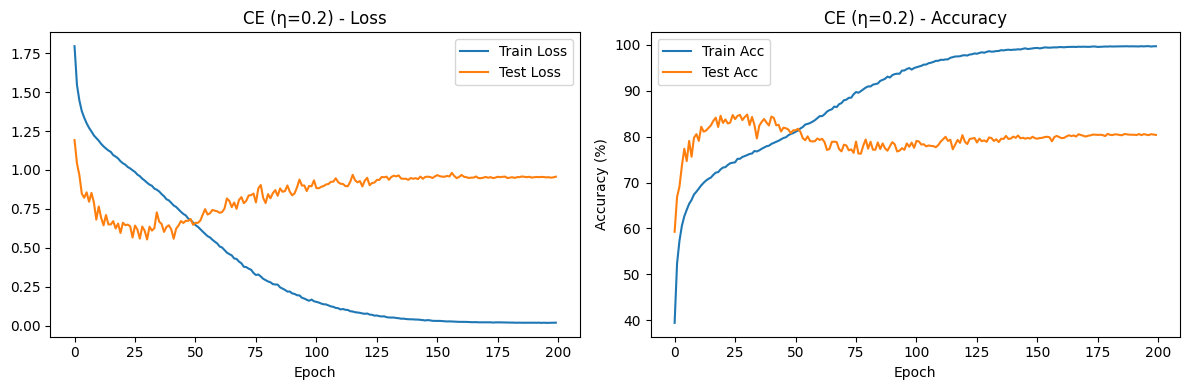

 - MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.41it/s]


Test Acc: 38.12% | Test Loss: 0.6228


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 42.60% | Test Loss: 0.5787


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 111.72it/s]


Test Acc: 43.39% | Test Loss: 0.5681


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.75it/s]


Test Acc: 47.14% | Test Loss: 0.5319


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 47.64% | Test Loss: 0.5259


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 111.20it/s]


Test Acc: 47.86% | Test Loss: 0.5227


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 111.16it/s]


Test Acc: 51.98% | Test Loss: 0.4815


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 111.50it/s]


Test Acc: 52.32% | Test Loss: 0.4792


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.99it/s]


Test Acc: 49.71% | Test Loss: 0.5046


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.33it/s]


Test Acc: 52.95% | Test Loss: 0.4704


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.82it/s]


Test Acc: 53.10% | Test Loss: 0.4703


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.10it/s]


Test Acc: 54.37% | Test Loss: 0.4562


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.87it/s]


Test Acc: 53.44% | Test Loss: 0.4645


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.83it/s]


Test Acc: 55.33% | Test Loss: 0.4483


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.35it/s]


Test Acc: 55.98% | Test Loss: 0.4393


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.85it/s]


Test Acc: 53.31% | Test Loss: 0.4685


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.29it/s]


Test Acc: 55.03% | Test Loss: 0.4499


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.52it/s]


Test Acc: 56.55% | Test Loss: 0.4349


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.99it/s]


Test Acc: 56.38% | Test Loss: 0.4368


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.29it/s]


Test Acc: 56.17% | Test Loss: 0.4374


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.96it/s]


Test Acc: 56.39% | Test Loss: 0.4379


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.39it/s]


Test Acc: 55.73% | Test Loss: 0.4422


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.30it/s]


Test Acc: 56.58% | Test Loss: 0.4336


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.27it/s]


Test Acc: 57.37% | Test Loss: 0.4258


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.00it/s]


Test Acc: 57.36% | Test Loss: 0.4262


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.98it/s]


Test Acc: 57.75% | Test Loss: 0.4235


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.66it/s]


Test Acc: 57.75% | Test Loss: 0.4215


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.40it/s]


Test Acc: 57.94% | Test Loss: 0.4207


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.92it/s]


Test Acc: 59.23% | Test Loss: 0.4079


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.14it/s]


Test Acc: 58.28% | Test Loss: 0.4168


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.80it/s]


Test Acc: 58.63% | Test Loss: 0.4133


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.18it/s]


Test Acc: 59.08% | Test Loss: 0.4096


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.86it/s]


Test Acc: 56.49% | Test Loss: 0.4348


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.29it/s]


Test Acc: 58.26% | Test Loss: 0.4183


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.89it/s]


Test Acc: 59.37% | Test Loss: 0.4077


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.06it/s]


Test Acc: 59.86% | Test Loss: 0.4011


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 59.54% | Test Loss: 0.4035


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.28it/s]


Test Acc: 59.03% | Test Loss: 0.4094


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.92it/s]


Test Acc: 58.96% | Test Loss: 0.4097


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.58it/s]


Test Acc: 59.34% | Test Loss: 0.4057


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.98it/s]


Test Acc: 59.58% | Test Loss: 0.4052


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.12it/s]


Test Acc: 60.48% | Test Loss: 0.3964


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.21it/s]


Test Acc: 60.32% | Test Loss: 0.3970


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.12it/s]


Test Acc: 58.67% | Test Loss: 0.4126


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.21it/s]


Test Acc: 59.50% | Test Loss: 0.4049


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.27it/s]


Test Acc: 59.73% | Test Loss: 0.4037


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.86it/s]


Test Acc: 59.32% | Test Loss: 0.4067


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.34it/s]


Test Acc: 60.29% | Test Loss: 0.3969


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.89it/s]


Test Acc: 60.66% | Test Loss: 0.3931


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.80it/s]


Test Acc: 59.28% | Test Loss: 0.4059


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.18it/s]


Test Acc: 60.40% | Test Loss: 0.3947


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 60.72% | Test Loss: 0.3926


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.47it/s]


Test Acc: 59.79% | Test Loss: 0.4023


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.95it/s]


Test Acc: 59.49% | Test Loss: 0.4064


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.98it/s]


Test Acc: 60.77% | Test Loss: 0.3936


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.83it/s]


Test Acc: 60.85% | Test Loss: 0.3918


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.94it/s]


Test Acc: 61.28% | Test Loss: 0.3875


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.12it/s]


Test Acc: 61.08% | Test Loss: 0.3898


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.76it/s]


Test Acc: 62.95% | Test Loss: 0.3728


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.84it/s]


Test Acc: 64.29% | Test Loss: 0.3581


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 65.16% | Test Loss: 0.3493


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.59it/s]


Test Acc: 64.91% | Test Loss: 0.3536


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.86it/s]


Test Acc: 65.87% | Test Loss: 0.3421


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 66.27% | Test Loss: 0.3391


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.27it/s]


Test Acc: 65.59% | Test Loss: 0.3462


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.75it/s]


Test Acc: 66.34% | Test Loss: 0.3391


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.43it/s]


Test Acc: 66.01% | Test Loss: 0.3418


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.54it/s]


Test Acc: 67.28% | Test Loss: 0.3278


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.16it/s]


Test Acc: 67.16% | Test Loss: 0.3306


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.27it/s]


Test Acc: 65.69% | Test Loss: 0.3437


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.96it/s]


Test Acc: 66.91% | Test Loss: 0.3325


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.90it/s]


Test Acc: 66.08% | Test Loss: 0.3404


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.37it/s]


Test Acc: 67.45% | Test Loss: 0.3267


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.96it/s]


Test Acc: 67.85% | Test Loss: 0.3231


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.96it/s]


Test Acc: 67.12% | Test Loss: 0.3311


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.31it/s]


Test Acc: 67.26% | Test Loss: 0.3277


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 67.95% | Test Loss: 0.3228


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.80it/s]


Test Acc: 67.45% | Test Loss: 0.3271


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.09it/s]


Test Acc: 67.94% | Test Loss: 0.3209


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 67.96% | Test Loss: 0.3228


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.32it/s]


Test Acc: 68.96% | Test Loss: 0.3134


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.92it/s]


Test Acc: 67.31% | Test Loss: 0.3280


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 67.96% | Test Loss: 0.3210


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.40it/s]


Test Acc: 68.49% | Test Loss: 0.3161


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.15it/s]


Test Acc: 67.78% | Test Loss: 0.3220


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.00it/s]


Test Acc: 68.35% | Test Loss: 0.3178


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.72it/s]


Test Acc: 68.09% | Test Loss: 0.3196


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.21it/s]


Test Acc: 68.64% | Test Loss: 0.3148


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.07it/s]


Test Acc: 69.26% | Test Loss: 0.3083


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.92it/s]


Test Acc: 68.21% | Test Loss: 0.3193


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.14it/s]


Test Acc: 69.21% | Test Loss: 0.3103


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 69.01% | Test Loss: 0.3124


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.78it/s]


Test Acc: 68.90% | Test Loss: 0.3119


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.92it/s]


Test Acc: 69.25% | Test Loss: 0.3091


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.26it/s]


Test Acc: 69.48% | Test Loss: 0.3072


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.64it/s]


Test Acc: 69.27% | Test Loss: 0.3101


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.91it/s]


Test Acc: 69.11% | Test Loss: 0.3097


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.87it/s]


Test Acc: 68.91% | Test Loss: 0.3126


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.08it/s]


Test Acc: 69.33% | Test Loss: 0.3077


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.05it/s]


Test Acc: 69.86% | Test Loss: 0.3028


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.83it/s]


Test Acc: 69.44% | Test Loss: 0.3080


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.71it/s]


Test Acc: 69.84% | Test Loss: 0.3033


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.15it/s]


Test Acc: 70.02% | Test Loss: 0.3018


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.72it/s]


Test Acc: 69.97% | Test Loss: 0.3024


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 69.75% | Test Loss: 0.3038


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.80it/s]


Test Acc: 69.27% | Test Loss: 0.3084


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 69.75% | Test Loss: 0.3049


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 68.66% | Test Loss: 0.3146


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.66it/s]


Test Acc: 69.88% | Test Loss: 0.3029


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.67it/s]


Test Acc: 69.91% | Test Loss: 0.3027


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.06it/s]


Test Acc: 69.96% | Test Loss: 0.3014


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.05it/s]


Test Acc: 69.77% | Test Loss: 0.3046


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.14it/s]


Test Acc: 70.28% | Test Loss: 0.2983


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.37it/s]


Test Acc: 70.18% | Test Loss: 0.3007


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.05it/s]


Test Acc: 69.96% | Test Loss: 0.3011


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.87it/s]


Test Acc: 70.19% | Test Loss: 0.2996


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.97it/s]


Test Acc: 69.93% | Test Loss: 0.3031


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.09it/s]


Test Acc: 70.15% | Test Loss: 0.3003


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.44it/s]


Test Acc: 69.65% | Test Loss: 0.3052


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.54it/s]


Test Acc: 69.94% | Test Loss: 0.3024


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.10it/s]


Test Acc: 70.39% | Test Loss: 0.2976


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.51it/s]


Test Acc: 75.42% | Test Loss: 0.2483


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.03it/s]


Test Acc: 76.75% | Test Loss: 0.2367


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.63it/s]


Test Acc: 77.59% | Test Loss: 0.2286


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.88it/s]


Test Acc: 77.85% | Test Loss: 0.2247


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 77.96% | Test Loss: 0.2243


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.58it/s]


Test Acc: 77.86% | Test Loss: 0.2235


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 78.05% | Test Loss: 0.2198


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 78.35% | Test Loss: 0.2195


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 77.96% | Test Loss: 0.2216


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 77.91% | Test Loss: 0.2231


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.94it/s]


Test Acc: 78.25% | Test Loss: 0.2196


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.57it/s]


Test Acc: 78.65% | Test Loss: 0.2158


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.26it/s]


Test Acc: 78.91% | Test Loss: 0.2147


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.08it/s]


Test Acc: 78.52% | Test Loss: 0.2178


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.20it/s]


Test Acc: 78.65% | Test Loss: 0.2160


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.13it/s]


Test Acc: 78.76% | Test Loss: 0.2152


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.47it/s]


Test Acc: 78.78% | Test Loss: 0.2140


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.36it/s]


Test Acc: 78.86% | Test Loss: 0.2138


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.05it/s]


Test Acc: 78.91% | Test Loss: 0.2130


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.73it/s]


Test Acc: 78.66% | Test Loss: 0.2152


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.57it/s]


Test Acc: 78.58% | Test Loss: 0.2172


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.95it/s]


Test Acc: 78.83% | Test Loss: 0.2143


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.12it/s]


Test Acc: 79.04% | Test Loss: 0.2116


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.15it/s]


Test Acc: 79.16% | Test Loss: 0.2106


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.73it/s]


Test Acc: 79.05% | Test Loss: 0.2113


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.91it/s]


Test Acc: 78.86% | Test Loss: 0.2131


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.10it/s]


Test Acc: 78.93% | Test Loss: 0.2118


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.10it/s]


Test Acc: 79.23% | Test Loss: 0.2107


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.28it/s]


Test Acc: 79.11% | Test Loss: 0.2111


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.93it/s]


Test Acc: 79.08% | Test Loss: 0.2120


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.21it/s]


Test Acc: 79.13% | Test Loss: 0.2118


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.39it/s]


Test Acc: 78.91% | Test Loss: 0.2124


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.74it/s]


Test Acc: 78.94% | Test Loss: 0.2126


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.51it/s]


Test Acc: 79.09% | Test Loss: 0.2109


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.01it/s]


Test Acc: 79.30% | Test Loss: 0.2095


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.91it/s]


Test Acc: 79.07% | Test Loss: 0.2106


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.30it/s]


Test Acc: 78.92% | Test Loss: 0.2123


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.68it/s]


Test Acc: 79.00% | Test Loss: 0.2117


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.16it/s]


Test Acc: 79.10% | Test Loss: 0.2107


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.36it/s]


Test Acc: 79.11% | Test Loss: 0.2107


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.97it/s]


Test Acc: 79.38% | Test Loss: 0.2088


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.14it/s]


Test Acc: 79.25% | Test Loss: 0.2093


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.73it/s]


Test Acc: 79.08% | Test Loss: 0.2120


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.98it/s]


Test Acc: 79.07% | Test Loss: 0.2108


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.99it/s]


Test Acc: 78.97% | Test Loss: 0.2119


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.80it/s]


Test Acc: 79.18% | Test Loss: 0.2112


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.62it/s]


Test Acc: 79.11% | Test Loss: 0.2117


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.69it/s]


Test Acc: 79.07% | Test Loss: 0.2113


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.02it/s]


Test Acc: 79.18% | Test Loss: 0.2108


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.67it/s]


Test Acc: 79.23% | Test Loss: 0.2101


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.02it/s]


Test Acc: 79.34% | Test Loss: 0.2096


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.65it/s]


Test Acc: 79.17% | Test Loss: 0.2110


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.42it/s]


Test Acc: 79.10% | Test Loss: 0.2110


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.44it/s]


Test Acc: 79.22% | Test Loss: 0.2096


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 79.29% | Test Loss: 0.2101


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.13it/s]


Test Acc: 79.19% | Test Loss: 0.2101


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.56it/s]


Test Acc: 79.36% | Test Loss: 0.2096


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.77it/s]


Test Acc: 79.18% | Test Loss: 0.2104


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.69it/s]


Test Acc: 79.23% | Test Loss: 0.2107


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.39it/s]


Test Acc: 79.33% | Test Loss: 0.2104


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.43it/s]


Test Acc: 79.11% | Test Loss: 0.2110


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.44it/s]


Test Acc: 79.22% | Test Loss: 0.2105


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.56it/s]


Test Acc: 79.12% | Test Loss: 0.2105


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.04it/s]


Test Acc: 79.14% | Test Loss: 0.2112


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.77it/s]


Test Acc: 79.18% | Test Loss: 0.2100


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.95it/s]


Test Acc: 79.19% | Test Loss: 0.2101


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.43it/s]


Test Acc: 79.18% | Test Loss: 0.2104


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.13it/s]


Test Acc: 79.23% | Test Loss: 0.2102


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 79.22% | Test Loss: 0.2102


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.85it/s]


Test Acc: 79.17% | Test Loss: 0.2103


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 79.18% | Test Loss: 0.2105


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 79.23% | Test Loss: 0.2102


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 79.33% | Test Loss: 0.2102


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.05it/s]


Test Acc: 79.26% | Test Loss: 0.2100


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.34it/s]


Test Acc: 79.28% | Test Loss: 0.2103


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 79.26% | Test Loss: 0.2104


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 79.25% | Test Loss: 0.2101


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.98it/s]


Test Acc: 79.24% | Test Loss: 0.2099


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.85it/s]


Test Acc: 79.20% | Test Loss: 0.2103


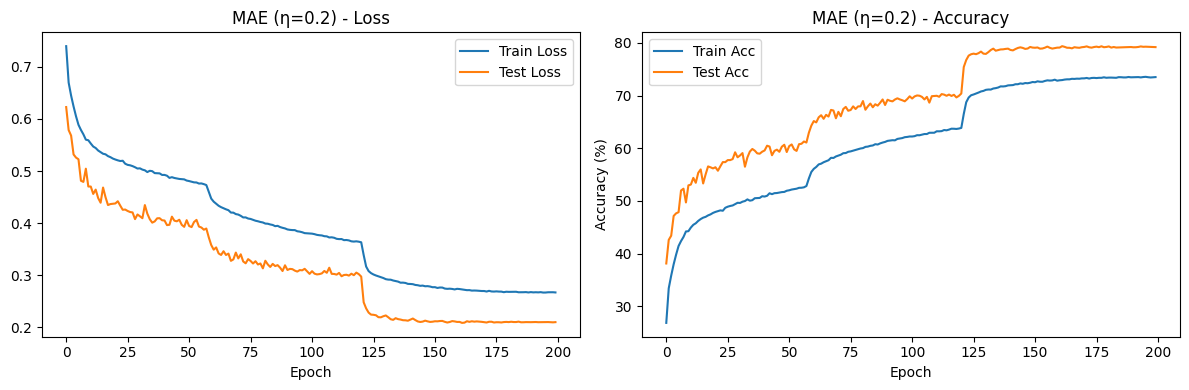

 - RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 24.00% | Test Loss: 6.9912


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 27.85% | Test Loss: 6.6553


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 23.93% | Test Loss: 6.9931


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.34it/s]


Test Acc: 27.60% | Test Loss: 6.6675


Epoch 5/200: 100%|████████████████████████████| 391/391 [00:04<00:00, 96.89it/s]


Test Acc: 26.63% | Test Loss: 6.7713


Epoch 6/200: 100%|████████████████████████████| 391/391 [00:05<00:00, 75.02it/s]


Test Acc: 26.98% | Test Loss: 6.7284


Epoch 7/200: 100%|████████████████████████████| 391/391 [00:04<00:00, 97.55it/s]


Test Acc: 27.27% | Test Loss: 6.6889


Epoch 8/200: 100%|████████████████████████████| 391/391 [00:04<00:00, 95.79it/s]


Test Acc: 27.14% | Test Loss: 6.7134


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.46it/s]


Test Acc: 27.34% | Test Loss: 6.6832


Epoch 10/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 97.94it/s]


Test Acc: 24.53% | Test Loss: 6.9585


Epoch 11/200: 100%|███████████████████████████| 391/391 [00:04<00:00, 87.75it/s]


Test Acc: 21.16% | Test Loss: 7.2828


Epoch 12/200: 100%|███████████████████████████| 391/391 [00:04<00:00, 95.21it/s]


Test Acc: 23.52% | Test Loss: 7.0461


Epoch 13/200: 100%|███████████████████████████| 391/391 [00:04<00:00, 97.15it/s]


Test Acc: 27.70% | Test Loss: 6.6672


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 23.67% | Test Loss: 7.0299


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.07it/s]


Test Acc: 28.92% | Test Loss: 6.5521


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 28.68% | Test Loss: 6.5815


Epoch 17/200: 100%|███████████████████████████| 391/391 [00:04<00:00, 93.82it/s]


Test Acc: 29.51% | Test Loss: 6.5046


Epoch 18/200: 100%|███████████████████████████| 391/391 [00:04<00:00, 92.97it/s]


Test Acc: 26.04% | Test Loss: 6.8003


Epoch 19/200: 100%|███████████████████████████| 391/391 [00:04<00:00, 88.44it/s]


Test Acc: 29.83% | Test Loss: 6.4757


Epoch 20/200: 100%|███████████████████████████| 391/391 [00:04<00:00, 93.15it/s]


Test Acc: 23.99% | Test Loss: 6.9824


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 30.00% | Test Loss: 6.4471


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 27.11% | Test Loss: 6.7027


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 30.90% | Test Loss: 6.3705


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 29.13% | Test Loss: 6.5197


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 29.50% | Test Loss: 6.4767


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 31.15% | Test Loss: 6.3338


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 29.01% | Test Loss: 6.5357


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.78it/s]


Test Acc: 29.48% | Test Loss: 6.4929


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.66it/s]


Test Acc: 28.58% | Test Loss: 6.5681


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 30.72% | Test Loss: 6.3916


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.10it/s]


Test Acc: 30.84% | Test Loss: 6.3704


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 31.64% | Test Loss: 6.2973


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 28.57% | Test Loss: 6.5705


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 30.87% | Test Loss: 6.3679


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 31.13% | Test Loss: 6.3429


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 31.36% | Test Loss: 6.3136


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 32.43% | Test Loss: 6.2254


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 31.31% | Test Loss: 6.3205


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 30.35% | Test Loss: 6.4085


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 29.90% | Test Loss: 6.4411


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 33.21% | Test Loss: 6.1595


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 31.21% | Test Loss: 6.3298


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 28.82% | Test Loss: 6.5471


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 31.52% | Test Loss: 6.3075


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 29.88% | Test Loss: 6.4516


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 30.32% | Test Loss: 6.4268


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 32.16% | Test Loss: 6.2476


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 32.75% | Test Loss: 6.1938


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.60it/s]


Test Acc: 31.22% | Test Loss: 6.3292


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.06it/s]


Test Acc: 32.48% | Test Loss: 6.2139


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.33it/s]


Test Acc: 31.33% | Test Loss: 6.3179


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.10it/s]


Test Acc: 32.16% | Test Loss: 6.2426


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.61it/s]


Test Acc: 32.50% | Test Loss: 6.2187


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.87it/s]


Test Acc: 31.19% | Test Loss: 6.3366


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 31.58% | Test Loss: 6.3151


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 31.74% | Test Loss: 6.2802


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 32.77% | Test Loss: 6.1874


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.53it/s]


Test Acc: 32.24% | Test Loss: 6.2341


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 30.06% | Test Loss: 6.4231


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 32.45% | Test Loss: 6.2286


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 28.98% | Test Loss: 6.5256


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 32.92% | Test Loss: 6.1832


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 32.19% | Test Loss: 6.2462


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 32.87% | Test Loss: 6.1783


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 33.31% | Test Loss: 6.1504


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 33.28% | Test Loss: 6.1583


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 33.33% | Test Loss: 6.1432


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 33.26% | Test Loss: 6.1420


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 32.56% | Test Loss: 6.2035


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 32.49% | Test Loss: 6.2186


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 33.09% | Test Loss: 6.1640


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 33.21% | Test Loss: 6.1530


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 34.05% | Test Loss: 6.0791


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 33.99% | Test Loss: 6.0831


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 32.82% | Test Loss: 6.1766


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.78it/s]


Test Acc: 32.62% | Test Loss: 6.2124


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.52it/s]


Test Acc: 33.88% | Test Loss: 6.0904


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.35it/s]


Test Acc: 33.40% | Test Loss: 6.1234


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 32.27% | Test Loss: 6.2398


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 34.71% | Test Loss: 6.0158


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 34.50% | Test Loss: 6.0299


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.68it/s]


Test Acc: 30.22% | Test Loss: 6.4139


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 33.93% | Test Loss: 6.0759


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 34.21% | Test Loss: 6.0617


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.04it/s]


Test Acc: 33.52% | Test Loss: 6.1248


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 35.58% | Test Loss: 5.9248


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.39it/s]


Test Acc: 32.93% | Test Loss: 6.1798


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.65it/s]


Test Acc: 34.96% | Test Loss: 6.0011


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 35.33% | Test Loss: 5.9612


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.55it/s]


Test Acc: 33.44% | Test Loss: 6.1295


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 30.56% | Test Loss: 6.3900


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 34.59% | Test Loss: 6.0277


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.86it/s]


Test Acc: 34.58% | Test Loss: 6.0351


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 34.59% | Test Loss: 6.0282


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.13it/s]


Test Acc: 34.47% | Test Loss: 6.0399


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.69it/s]


Test Acc: 34.19% | Test Loss: 6.0642


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 34.80% | Test Loss: 6.0152


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 35.87% | Test Loss: 5.9121


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.47it/s]


Test Acc: 34.82% | Test Loss: 5.9989


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 36.80% | Test Loss: 5.8258


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.50it/s]


Test Acc: 35.57% | Test Loss: 5.9385


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.02it/s]


Test Acc: 36.42% | Test Loss: 5.8668


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 36.47% | Test Loss: 5.8627


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 36.16% | Test Loss: 5.8845


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.35it/s]


Test Acc: 35.10% | Test Loss: 5.9878


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 35.87% | Test Loss: 5.9127


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 36.47% | Test Loss: 5.8504


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.95it/s]


Test Acc: 36.24% | Test Loss: 5.8853


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 36.01% | Test Loss: 5.8922


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.66it/s]


Test Acc: 36.84% | Test Loss: 5.8218


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.95it/s]


Test Acc: 36.51% | Test Loss: 5.8529


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 36.26% | Test Loss: 5.8751


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.78it/s]


Test Acc: 36.94% | Test Loss: 5.8049


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 36.57% | Test Loss: 5.8413


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 35.86% | Test Loss: 5.8990


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 36.32% | Test Loss: 5.8632


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 36.34% | Test Loss: 5.8613


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 36.32% | Test Loss: 5.8715


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 36.33% | Test Loss: 5.8703


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.82it/s]


Test Acc: 35.23% | Test Loss: 5.9625


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 35.69% | Test Loss: 5.9276


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 36.18% | Test Loss: 5.8833


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 36.46% | Test Loss: 5.8446


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 35.70% | Test Loss: 5.9207


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 36.49% | Test Loss: 5.8500


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 36.08% | Test Loss: 5.8977


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 37.48% | Test Loss: 5.7652


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 36.99% | Test Loss: 5.8084


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 37.20% | Test Loss: 5.7832


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.56it/s]


Test Acc: 37.65% | Test Loss: 5.7473


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.74it/s]


Test Acc: 37.34% | Test Loss: 5.7769


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.69it/s]


Test Acc: 37.56% | Test Loss: 5.7524


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 37.80% | Test Loss: 5.7296


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 37.41% | Test Loss: 5.7637


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 37.57% | Test Loss: 5.7432


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 37.20% | Test Loss: 5.7777


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 37.70% | Test Loss: 5.7373


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 37.77% | Test Loss: 5.7258


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 37.54% | Test Loss: 5.7519


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 37.11% | Test Loss: 5.7984


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 37.45% | Test Loss: 5.7679


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.92it/s]


Test Acc: 37.77% | Test Loss: 5.7380


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.99it/s]


Test Acc: 38.00% | Test Loss: 5.7104


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.77it/s]


Test Acc: 38.14% | Test Loss: 5.6994


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.58it/s]


Test Acc: 38.05% | Test Loss: 5.7069


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.07it/s]


Test Acc: 38.27% | Test Loss: 5.6872


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.08it/s]


Test Acc: 38.42% | Test Loss: 5.6723


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.07it/s]


Test Acc: 38.66% | Test Loss: 5.6451


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 38.18% | Test Loss: 5.6869


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 38.44% | Test Loss: 5.6663


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.92it/s]


Test Acc: 38.52% | Test Loss: 5.6638


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 38.38% | Test Loss: 5.6757


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 38.38% | Test Loss: 5.6698


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 38.33% | Test Loss: 5.6805


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 38.41% | Test Loss: 5.6676


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 38.47% | Test Loss: 5.6622


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 38.24% | Test Loss: 5.6813


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.47it/s]


Test Acc: 38.39% | Test Loss: 5.6681


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 38.74% | Test Loss: 5.6451


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 38.76% | Test Loss: 5.6429


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.72it/s]


Test Acc: 38.90% | Test Loss: 5.6229


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 38.90% | Test Loss: 5.6244


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 38.68% | Test Loss: 5.6420


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.61it/s]


Test Acc: 38.66% | Test Loss: 5.6440


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.37it/s]


Test Acc: 38.73% | Test Loss: 5.6369


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 38.80% | Test Loss: 5.6316


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.94it/s]


Test Acc: 38.81% | Test Loss: 5.6373


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.13it/s]


Test Acc: 38.65% | Test Loss: 5.6448


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 38.66% | Test Loss: 5.6441


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.00it/s]


Test Acc: 38.80% | Test Loss: 5.6312


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 38.86% | Test Loss: 5.6259


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.66it/s]


Test Acc: 39.09% | Test Loss: 5.6061


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 39.08% | Test Loss: 5.6059


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 39.19% | Test Loss: 5.5960


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 38.95% | Test Loss: 5.6179


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 38.99% | Test Loss: 5.6139


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 38.95% | Test Loss: 5.6234


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.18it/s]


Test Acc: 39.16% | Test Loss: 5.5996


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.30it/s]


Test Acc: 39.02% | Test Loss: 5.6104


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.93it/s]


Test Acc: 39.11% | Test Loss: 5.6029


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 39.13% | Test Loss: 5.6012


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 39.15% | Test Loss: 5.5994


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 39.15% | Test Loss: 5.5994


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.45it/s]


Test Acc: 39.08% | Test Loss: 5.6056


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.29it/s]


Test Acc: 39.21% | Test Loss: 5.5945


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 39.10% | Test Loss: 5.6056


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.20it/s]


Test Acc: 39.22% | Test Loss: 5.5929


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.80it/s]


Test Acc: 39.19% | Test Loss: 5.5960


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.98it/s]


Test Acc: 39.23% | Test Loss: 5.5899


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.78it/s]


Test Acc: 39.22% | Test Loss: 5.5937


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.40it/s]


Test Acc: 39.31% | Test Loss: 5.5842


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.14it/s]


Test Acc: 39.28% | Test Loss: 5.5883


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.87it/s]


Test Acc: 39.25% | Test Loss: 5.5901


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.89it/s]


Test Acc: 39.23% | Test Loss: 5.5925


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.77it/s]


Test Acc: 39.32% | Test Loss: 5.5854


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.07it/s]


Test Acc: 39.33% | Test Loss: 5.5846


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.58it/s]


Test Acc: 39.26% | Test Loss: 5.5970


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.70it/s]


Test Acc: 39.32% | Test Loss: 5.5847


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 39.24% | Test Loss: 5.5939


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.12it/s]


Test Acc: 39.32% | Test Loss: 5.5842


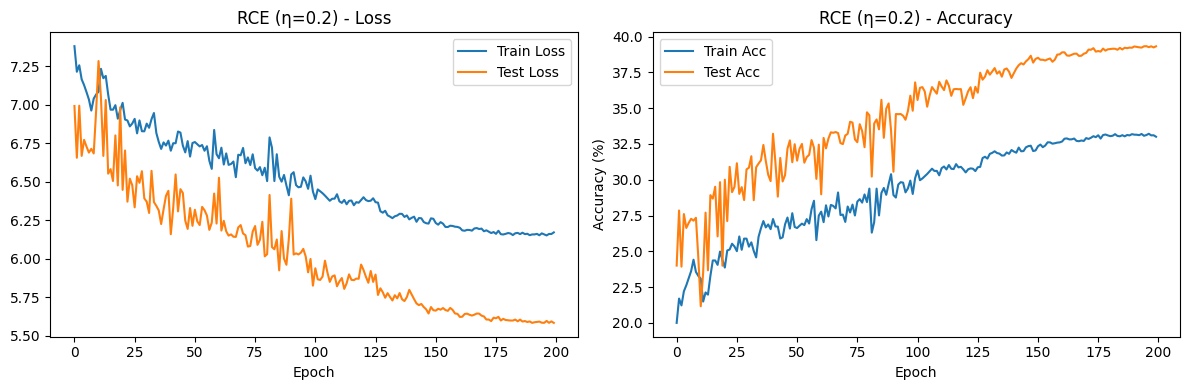


Training normalized Losses...
 - NCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 39.98% | Test Loss: 0.0328


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 43.45% | Test Loss: 0.0243


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 44.51% | Test Loss: 0.0229


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 46.07% | Test Loss: 0.0202


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 48.57% | Test Loss: 0.0180


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 49.49% | Test Loss: 0.0175


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.56it/s]


Test Acc: 51.82% | Test Loss: 0.0156


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 49.40% | Test Loss: 0.0173


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.60it/s]


Test Acc: 53.67% | Test Loss: 0.0145


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.58it/s]


Test Acc: 53.53% | Test Loss: 0.0142


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 53.34% | Test Loss: 0.0138


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.04it/s]


Test Acc: 56.03% | Test Loss: 0.0137


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.97it/s]


Test Acc: 56.45% | Test Loss: 0.0134


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 56.81% | Test Loss: 0.0122


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 58.21% | Test Loss: 0.0119


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 58.88% | Test Loss: 0.0114


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 56.24% | Test Loss: 0.0139


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 59.77% | Test Loss: 0.0105


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 57.98% | Test Loss: 0.0115


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.37it/s]


Test Acc: 61.09% | Test Loss: 0.0100


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 60.48% | Test Loss: 0.0109


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.63it/s]


Test Acc: 61.97% | Test Loss: 0.0095


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 61.77% | Test Loss: 0.0094


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.21it/s]


Test Acc: 63.46% | Test Loss: 0.0094


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 58.94% | Test Loss: 0.0121


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 62.82% | Test Loss: 0.0089


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 63.41% | Test Loss: 0.0089


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 62.32% | Test Loss: 0.0099


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 63.41% | Test Loss: 0.0094


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 64.26% | Test Loss: 0.0083


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 65.30% | Test Loss: 0.0080


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 63.63% | Test Loss: 0.0090


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 64.88% | Test Loss: 0.0085


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.60it/s]


Test Acc: 64.91% | Test Loss: 0.0083


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.32it/s]


Test Acc: 65.13% | Test Loss: 0.0077


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.51it/s]


Test Acc: 65.64% | Test Loss: 0.0083


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 66.72% | Test Loss: 0.0074


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 63.07% | Test Loss: 0.0082


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 64.97% | Test Loss: 0.0086


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 66.54% | Test Loss: 0.0073


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 64.58% | Test Loss: 0.0083


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 67.34% | Test Loss: 0.0070


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.99it/s]


Test Acc: 66.85% | Test Loss: 0.0070


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.59it/s]


Test Acc: 64.68% | Test Loss: 0.0086


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 62.56% | Test Loss: 0.0084


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 67.35% | Test Loss: 0.0071


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.69it/s]


Test Acc: 66.80% | Test Loss: 0.0078


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 67.20% | Test Loss: 0.0071


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 67.31% | Test Loss: 0.0071


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 66.80% | Test Loss: 0.0071


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 67.84% | Test Loss: 0.0072


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 66.31% | Test Loss: 0.0092


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.32it/s]


Test Acc: 67.43% | Test Loss: 0.0070


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 69.20% | Test Loss: 0.0061


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.54it/s]


Test Acc: 68.70% | Test Loss: 0.0063


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 66.19% | Test Loss: 0.0070


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.40it/s]


Test Acc: 69.28% | Test Loss: 0.0063


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 66.93% | Test Loss: 0.0071


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.93it/s]


Test Acc: 68.93% | Test Loss: 0.0059


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 68.47% | Test Loss: 0.0065


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 69.84% | Test Loss: 0.0061


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.61it/s]


Test Acc: 69.66% | Test Loss: 0.0061


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 68.44% | Test Loss: 0.0062


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.90it/s]


Test Acc: 68.87% | Test Loss: 0.0062


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 69.49% | Test Loss: 0.0062


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.34it/s]


Test Acc: 69.54% | Test Loss: 0.0061


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.85it/s]


Test Acc: 69.43% | Test Loss: 0.0062


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 70.27% | Test Loss: 0.0058


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.83it/s]


Test Acc: 68.74% | Test Loss: 0.0084


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.40it/s]


Test Acc: 69.73% | Test Loss: 0.0060


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.51it/s]


Test Acc: 68.26% | Test Loss: 0.0071


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.58it/s]


Test Acc: 68.67% | Test Loss: 0.0064


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.83it/s]


Test Acc: 69.39% | Test Loss: 0.0063


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.69it/s]


Test Acc: 70.06% | Test Loss: 0.0056


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 68.38% | Test Loss: 0.0074


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.31it/s]


Test Acc: 69.78% | Test Loss: 0.0067


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.67it/s]


Test Acc: 69.81% | Test Loss: 0.0062


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 69.68% | Test Loss: 0.0061


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.84it/s]


Test Acc: 69.39% | Test Loss: 0.0073


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 71.04% | Test Loss: 0.0058


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.28it/s]


Test Acc: 69.68% | Test Loss: 0.0057


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 69.18% | Test Loss: 0.0063


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 70.02% | Test Loss: 0.0065


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 68.13% | Test Loss: 0.0070


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.69it/s]


Test Acc: 70.93% | Test Loss: 0.0058


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 70.29% | Test Loss: 0.0065


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 70.35% | Test Loss: 0.0062


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.62it/s]


Test Acc: 69.01% | Test Loss: 0.0064


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.31it/s]


Test Acc: 67.35% | Test Loss: 0.0075


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.59it/s]


Test Acc: 71.02% | Test Loss: 0.0061


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.87it/s]


Test Acc: 70.37% | Test Loss: 0.0060


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.61it/s]


Test Acc: 70.23% | Test Loss: 0.0063


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 69.62% | Test Loss: 0.0063


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 70.74% | Test Loss: 0.0059


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.54it/s]


Test Acc: 70.25% | Test Loss: 0.0061


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 69.10% | Test Loss: 0.0069


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.85it/s]


Test Acc: 71.70% | Test Loss: 0.0062


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.90it/s]


Test Acc: 70.84% | Test Loss: 0.0062


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 68.87% | Test Loss: 0.0074


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.59it/s]


Test Acc: 69.91% | Test Loss: 0.0065


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.26it/s]


Test Acc: 71.01% | Test Loss: 0.0060


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.49it/s]


Test Acc: 69.45% | Test Loss: 0.0064


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 70.47% | Test Loss: 0.0055


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 70.81% | Test Loss: 0.0063


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 69.92% | Test Loss: 0.0067


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 69.62% | Test Loss: 0.0069


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 70.96% | Test Loss: 0.0064


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.26it/s]


Test Acc: 71.15% | Test Loss: 0.0058


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 70.90% | Test Loss: 0.0065


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 70.01% | Test Loss: 0.0064


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.47it/s]


Test Acc: 69.06% | Test Loss: 0.0056


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.56it/s]


Test Acc: 70.08% | Test Loss: 0.0060


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 69.63% | Test Loss: 0.0073


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 70.74% | Test Loss: 0.0062


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 70.21% | Test Loss: 0.0068


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 69.42% | Test Loss: 0.0071


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.71it/s]


Test Acc: 71.74% | Test Loss: 0.0066


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 70.63% | Test Loss: 0.0064


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 70.74% | Test Loss: 0.0060


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 69.82% | Test Loss: 0.0068


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.90it/s]


Test Acc: 69.19% | Test Loss: 0.0063


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 68.81% | Test Loss: 0.0080


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 70.53% | Test Loss: 0.0065


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 70.12% | Test Loss: 0.0060


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.27it/s]


Test Acc: 71.35% | Test Loss: 0.0061


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 71.20% | Test Loss: 0.0062


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.13it/s]


Test Acc: 71.72% | Test Loss: 0.0068


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 71.37% | Test Loss: 0.0056


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 71.89% | Test Loss: 0.0061


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 71.38% | Test Loss: 0.0063


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.61it/s]


Test Acc: 71.36% | Test Loss: 0.0060


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 70.78% | Test Loss: 0.0062


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 72.07% | Test Loss: 0.0057


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 70.38% | Test Loss: 0.0061


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.60it/s]


Test Acc: 71.38% | Test Loss: 0.0062


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.57it/s]


Test Acc: 71.00% | Test Loss: 0.0069


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 71.17% | Test Loss: 0.0061


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 70.86% | Test Loss: 0.0065


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 70.59% | Test Loss: 0.0076


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 71.63% | Test Loss: 0.0059


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 71.46% | Test Loss: 0.0065


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.39it/s]


Test Acc: 71.14% | Test Loss: 0.0077


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.86it/s]


Test Acc: 70.63% | Test Loss: 0.0069


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.13it/s]


Test Acc: 70.82% | Test Loss: 0.0066


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 70.74% | Test Loss: 0.0064


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.55it/s]


Test Acc: 70.91% | Test Loss: 0.0067


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 70.34% | Test Loss: 0.0062


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.93it/s]


Test Acc: 71.46% | Test Loss: 0.0067


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 70.39% | Test Loss: 0.0078


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.66it/s]


Test Acc: 71.71% | Test Loss: 0.0066


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 71.82% | Test Loss: 0.0072


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.54it/s]


Test Acc: 71.25% | Test Loss: 0.0069


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.71it/s]


Test Acc: 71.29% | Test Loss: 0.0058


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 71.16% | Test Loss: 0.0071


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.51it/s]


Test Acc: 71.11% | Test Loss: 0.0067


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 71.56% | Test Loss: 0.0066


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.57it/s]


Test Acc: 70.81% | Test Loss: 0.0070


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 71.38% | Test Loss: 0.0070


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 70.74% | Test Loss: 0.0074


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.89it/s]


Test Acc: 71.44% | Test Loss: 0.0071


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 70.62% | Test Loss: 0.0069


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 71.30% | Test Loss: 0.0063


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 70.99% | Test Loss: 0.0077


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 71.23% | Test Loss: 0.0083


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.40it/s]


Test Acc: 71.12% | Test Loss: 0.0066


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.35it/s]


Test Acc: 71.90% | Test Loss: 0.0070


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.80it/s]


Test Acc: 71.36% | Test Loss: 0.0070


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 71.59% | Test Loss: 0.0069


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 71.57% | Test Loss: 0.0072


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 71.31% | Test Loss: 0.0069


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.74it/s]


Test Acc: 71.55% | Test Loss: 0.0068


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 71.51% | Test Loss: 0.0065


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 71.82% | Test Loss: 0.0069


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.65it/s]


Test Acc: 71.58% | Test Loss: 0.0073


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.13it/s]


Test Acc: 71.16% | Test Loss: 0.0072


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 71.30% | Test Loss: 0.0076


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 71.69% | Test Loss: 0.0069


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 71.19% | Test Loss: 0.0067


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 71.63% | Test Loss: 0.0068


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.43it/s]


Test Acc: 71.41% | Test Loss: 0.0076


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.26it/s]


Test Acc: 71.55% | Test Loss: 0.0073


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 71.33% | Test Loss: 0.0074


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.58it/s]


Test Acc: 71.69% | Test Loss: 0.0072


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.31it/s]


Test Acc: 71.53% | Test Loss: 0.0076


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 71.57% | Test Loss: 0.0074


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 71.78% | Test Loss: 0.0072


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 71.75% | Test Loss: 0.0070


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.85it/s]


Test Acc: 71.52% | Test Loss: 0.0071


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.26it/s]


Test Acc: 71.80% | Test Loss: 0.0070


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.55it/s]


Test Acc: 71.44% | Test Loss: 0.0071


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.27it/s]


Test Acc: 71.51% | Test Loss: 0.0070


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 71.52% | Test Loss: 0.0073


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 71.49% | Test Loss: 0.0073


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.62it/s]


Test Acc: 71.52% | Test Loss: 0.0070


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 71.63% | Test Loss: 0.0073


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 71.59% | Test Loss: 0.0071


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.37it/s]


Test Acc: 71.50% | Test Loss: 0.0073


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 71.44% | Test Loss: 0.0071


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 71.50% | Test Loss: 0.0074


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.56it/s]


Test Acc: 71.48% | Test Loss: 0.0073


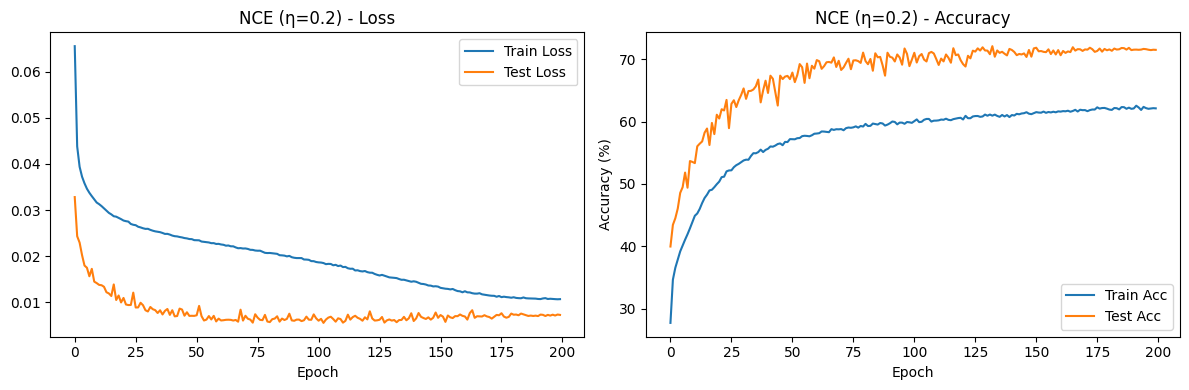

 - NRCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 15.79% | Test Loss: 17.4466


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.88it/s]


Test Acc: 17.40% | Test Loss: 17.1135


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 17.27% | Test Loss: 17.1395


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.54it/s]


Test Acc: 21.92% | Test Loss: 16.1586


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 18.99% | Test Loss: 16.7462


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.46it/s]


Test Acc: 18.00% | Test Loss: 16.9485


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 19.18% | Test Loss: 16.6898


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 17.01% | Test Loss: 17.1241


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.77it/s]


Test Acc: 19.23% | Test Loss: 16.6663


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.05it/s]


Test Acc: 18.30% | Test Loss: 16.8850


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.43it/s]


Test Acc: 20.18% | Test Loss: 16.5025


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 20.49% | Test Loss: 16.4092


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.72it/s]


Test Acc: 19.16% | Test Loss: 16.6841


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 18.39% | Test Loss: 16.8533


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.14it/s]


Test Acc: 17.58% | Test Loss: 17.0198


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.71it/s]


Test Acc: 19.20% | Test Loss: 16.7032


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.81it/s]


Test Acc: 20.16% | Test Loss: 16.4771


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.13it/s]


Test Acc: 19.89% | Test Loss: 16.5300


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.97it/s]


Test Acc: 19.31% | Test Loss: 16.6631


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.66it/s]


Test Acc: 18.10% | Test Loss: 16.9250


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.46it/s]


Test Acc: 19.14% | Test Loss: 16.6850


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.59it/s]


Test Acc: 19.04% | Test Loss: 16.7100


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 20.10% | Test Loss: 16.4909


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 18.80% | Test Loss: 16.7568


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.61it/s]


Test Acc: 19.10% | Test Loss: 16.6945


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.91it/s]


Test Acc: 18.20% | Test Loss: 16.8924


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 16.68% | Test Loss: 17.2172


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 16.54% | Test Loss: 17.2458


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.63it/s]


Test Acc: 16.35% | Test Loss: 17.2866


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 11.66% | Test Loss: 18.2751


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.48it/s]


Test Acc: 12.01% | Test Loss: 18.2063


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.37it/s]


Test Acc: 11.17% | Test Loss: 18.3767


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 12.11% | Test Loss: 18.1975


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.63it/s]


Test Acc: 11.65% | Test Loss: 18.2919


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.64it/s]


Test Acc: 11.63% | Test Loss: 18.2683


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.88it/s]


Test Acc: 11.41% | Test Loss: 18.3276


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 10.83% | Test Loss: 18.4608


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.49it/s]


Test Acc: 10.52% | Test Loss: 18.5234


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 12.83% | Test Loss: 18.0366


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.07it/s]


Test Acc: 12.29% | Test Loss: 18.1614


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 12.52% | Test Loss: 18.1000


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.68it/s]


Test Acc: 12.17% | Test Loss: 18.1725


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.37it/s]


Test Acc: 11.64% | Test Loss: 18.2932


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.71it/s]


Test Acc: 12.30% | Test Loss: 18.1444


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.87it/s]


Test Acc: 12.64% | Test Loss: 18.0755


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 12.83% | Test Loss: 18.0368


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.17it/s]


Test Acc: 12.68% | Test Loss: 18.0817


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.08it/s]


Test Acc: 12.03% | Test Loss: 18.2152


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 12.82% | Test Loss: 18.0379


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.31it/s]


Test Acc: 12.29% | Test Loss: 18.1475


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.35it/s]


Test Acc: 13.18% | Test Loss: 17.9637


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.89it/s]


Test Acc: 13.93% | Test Loss: 17.8118


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 13.66% | Test Loss: 17.8798


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.62it/s]


Test Acc: 12.75% | Test Loss: 18.0684


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.32it/s]


Test Acc: 12.72% | Test Loss: 18.0751


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.91it/s]


Test Acc: 13.50% | Test Loss: 17.9007


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.47it/s]


Test Acc: 13.95% | Test Loss: 17.8076


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 13.36% | Test Loss: 17.9149


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.69it/s]


Test Acc: 13.79% | Test Loss: 17.8253


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.62it/s]


Test Acc: 13.18% | Test Loss: 17.9506


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 14.25% | Test Loss: 17.7454


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 13.55% | Test Loss: 17.8878


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.52it/s]


Test Acc: 14.07% | Test Loss: 17.7820


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 13.69% | Test Loss: 17.8606


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.80it/s]


Test Acc: 13.68% | Test Loss: 17.8759


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.67it/s]


Test Acc: 14.16% | Test Loss: 17.7634


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.25it/s]


Test Acc: 14.26% | Test Loss: 17.7435


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.76it/s]


Test Acc: 14.20% | Test Loss: 17.7554


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 14.50% | Test Loss: 17.6779


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.43it/s]


Test Acc: 14.64% | Test Loss: 17.6677


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 14.52% | Test Loss: 17.6904


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.59it/s]


Test Acc: 14.52% | Test Loss: 17.6897


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.21it/s]


Test Acc: 14.09% | Test Loss: 17.8067


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.72it/s]


Test Acc: 14.38% | Test Loss: 17.7492


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.68it/s]


Test Acc: 14.53% | Test Loss: 17.6890


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.91it/s]


Test Acc: 13.54% | Test Loss: 17.8876


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 13.43% | Test Loss: 17.9141


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 14.15% | Test Loss: 17.7508


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 14.27% | Test Loss: 17.7548


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 14.42% | Test Loss: 17.7096


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.54it/s]


Test Acc: 13.94% | Test Loss: 17.8094


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.12it/s]


Test Acc: 13.98% | Test Loss: 17.8136


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.94it/s]


Test Acc: 13.57% | Test Loss: 17.8991


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.31it/s]


Test Acc: 14.10% | Test Loss: 17.7933


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 13.70% | Test Loss: 17.8724


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.57it/s]


Test Acc: 13.16% | Test Loss: 17.9823


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 13.84% | Test Loss: 17.8458


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 13.73% | Test Loss: 17.8658


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 14.70% | Test Loss: 17.6388


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.10it/s]


Test Acc: 13.99% | Test Loss: 17.7845


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 14.23% | Test Loss: 17.7354


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.48it/s]


Test Acc: 14.43% | Test Loss: 17.7228


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.55it/s]


Test Acc: 14.55% | Test Loss: 17.6988


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 13.83% | Test Loss: 17.8451


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.77it/s]


Test Acc: 12.87% | Test Loss: 18.0302


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 13.01% | Test Loss: 18.0017


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.40it/s]


Test Acc: 14.38% | Test Loss: 17.7036


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 13.90% | Test Loss: 17.8037


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.37it/s]


Test Acc: 13.35% | Test Loss: 17.9168


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.93it/s]


Test Acc: 13.24% | Test Loss: 17.9392


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 13.25% | Test Loss: 17.9370


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.59it/s]


Test Acc: 13.98% | Test Loss: 17.7878


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.65it/s]


Test Acc: 12.92% | Test Loss: 18.0183


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.35it/s]


Test Acc: 14.49% | Test Loss: 17.6862


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 14.26% | Test Loss: 17.7419


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.61it/s]


Test Acc: 14.44% | Test Loss: 17.6944


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.89it/s]


Test Acc: 14.36% | Test Loss: 17.7233


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.41it/s]


Test Acc: 14.40% | Test Loss: 17.7162


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 14.46% | Test Loss: 17.7025


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.58it/s]


Test Acc: 14.80% | Test Loss: 17.6178


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.78it/s]


Test Acc: 14.01% | Test Loss: 17.7950


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 14.13% | Test Loss: 17.7707


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 14.32% | Test Loss: 17.7307


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.70it/s]


Test Acc: 14.37% | Test Loss: 17.7347


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.61it/s]


Test Acc: 13.70% | Test Loss: 17.8734


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.86it/s]


Test Acc: 14.30% | Test Loss: 17.7195


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.47it/s]


Test Acc: 14.51% | Test Loss: 17.6936


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.61it/s]


Test Acc: 14.51% | Test Loss: 17.6916


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.63it/s]


Test Acc: 14.93% | Test Loss: 17.5929


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 14.63% | Test Loss: 17.6696


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.21it/s]


Test Acc: 15.13% | Test Loss: 17.5506


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.83it/s]


Test Acc: 14.67% | Test Loss: 17.6599


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.95it/s]


Test Acc: 14.89% | Test Loss: 17.6156


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 14.58% | Test Loss: 17.6778


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.21it/s]


Test Acc: 14.19% | Test Loss: 17.7720


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.27it/s]


Test Acc: 14.91% | Test Loss: 17.6094


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.78it/s]


Test Acc: 15.03% | Test Loss: 17.5860


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 15.21% | Test Loss: 17.5469


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 14.96% | Test Loss: 17.6025


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.48it/s]


Test Acc: 19.47% | Test Loss: 16.6334


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.41it/s]


Test Acc: 20.50% | Test Loss: 16.4096


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.72it/s]


Test Acc: 20.43% | Test Loss: 16.4203


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.75it/s]


Test Acc: 21.10% | Test Loss: 16.2976


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 21.04% | Test Loss: 16.3084


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 20.46% | Test Loss: 16.4152


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 20.69% | Test Loss: 16.3667


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.60it/s]


Test Acc: 20.96% | Test Loss: 16.3275


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.31it/s]


Test Acc: 20.95% | Test Loss: 16.3323


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 21.09% | Test Loss: 16.2870


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.87it/s]


Test Acc: 21.27% | Test Loss: 16.2619


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 21.54% | Test Loss: 16.1929


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 21.18% | Test Loss: 16.2816


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.02it/s]


Test Acc: 20.99% | Test Loss: 16.3237


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.37it/s]


Test Acc: 21.49% | Test Loss: 16.2182


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 21.87% | Test Loss: 16.1410


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.72it/s]


Test Acc: 21.82% | Test Loss: 16.1379


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.86it/s]


Test Acc: 21.93% | Test Loss: 16.1265


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 21.85% | Test Loss: 16.1450


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.86it/s]


Test Acc: 21.94% | Test Loss: 16.1254


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 21.82% | Test Loss: 16.1569


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.97it/s]


Test Acc: 21.83% | Test Loss: 16.1658


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 21.78% | Test Loss: 16.1588


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.64it/s]


Test Acc: 21.35% | Test Loss: 16.2331


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 21.53% | Test Loss: 16.1963


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 21.46% | Test Loss: 16.2115


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 21.09% | Test Loss: 16.2882


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.73it/s]


Test Acc: 21.34% | Test Loss: 16.2335


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.49it/s]


Test Acc: 21.70% | Test Loss: 16.1610


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 21.90% | Test Loss: 16.1197


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.31it/s]


Test Acc: 22.07% | Test Loss: 16.0873


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 21.95% | Test Loss: 16.1114


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.37it/s]


Test Acc: 21.86% | Test Loss: 16.1408


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.72it/s]


Test Acc: 21.73% | Test Loss: 16.1673


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.35it/s]


Test Acc: 22.07% | Test Loss: 16.0994


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 22.08% | Test Loss: 16.0829


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.82it/s]


Test Acc: 22.16% | Test Loss: 16.0664


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.12it/s]


Test Acc: 22.11% | Test Loss: 16.0770


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 21.94% | Test Loss: 16.1131


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.80it/s]


Test Acc: 22.08% | Test Loss: 16.1000


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.52it/s]


Test Acc: 22.07% | Test Loss: 16.1006


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.74it/s]


Test Acc: 22.25% | Test Loss: 16.0612


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.15it/s]


Test Acc: 22.25% | Test Loss: 16.0644


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 22.28% | Test Loss: 16.0581


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.34it/s]


Test Acc: 22.01% | Test Loss: 16.1114


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.39it/s]


Test Acc: 21.98% | Test Loss: 16.1156


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.94it/s]


Test Acc: 22.09% | Test Loss: 16.0961


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 22.35% | Test Loss: 16.0429


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 22.37% | Test Loss: 16.0388


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 22.36% | Test Loss: 16.0409


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.70it/s]


Test Acc: 22.38% | Test Loss: 16.0375


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.86it/s]


Test Acc: 22.36% | Test Loss: 16.0397


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.92it/s]


Test Acc: 22.34% | Test Loss: 16.0436


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.00it/s]


Test Acc: 22.31% | Test Loss: 16.0512


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.88it/s]


Test Acc: 22.29% | Test Loss: 16.0571


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.35it/s]


Test Acc: 22.23% | Test Loss: 16.0688


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.75it/s]


Test Acc: 22.32% | Test Loss: 16.0469


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.39it/s]


Test Acc: 22.18% | Test Loss: 16.0794


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.76it/s]


Test Acc: 22.21% | Test Loss: 16.0713


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 22.35% | Test Loss: 16.0437


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 22.27% | Test Loss: 16.0606


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.67it/s]


Test Acc: 22.33% | Test Loss: 16.0462


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 111.09it/s]


Test Acc: 22.34% | Test Loss: 16.0442


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 22.33% | Test Loss: 16.0476


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.28it/s]


Test Acc: 22.34% | Test Loss: 16.0449


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 22.28% | Test Loss: 16.0563


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.48it/s]


Test Acc: 22.27% | Test Loss: 16.0584


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.48it/s]


Test Acc: 22.31% | Test Loss: 16.0510


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 22.31% | Test Loss: 16.0522


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.66it/s]


Test Acc: 22.33% | Test Loss: 16.0456


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.87it/s]


Test Acc: 22.31% | Test Loss: 16.0517


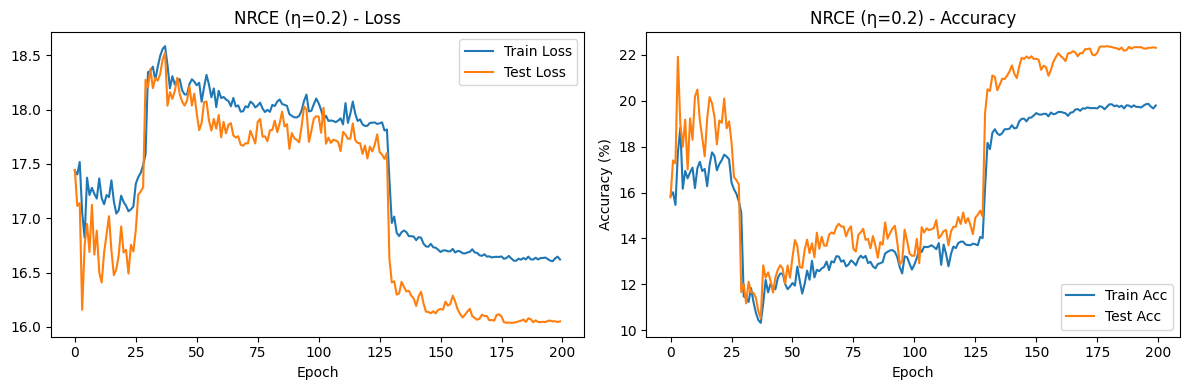

 - NFL


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 44.31% | Test Loss: 0.1862


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 45.52% | Test Loss: 0.1440


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.12it/s]


Test Acc: 42.60% | Test Loss: 0.1296


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.26it/s]


Test Acc: 49.87% | Test Loss: 0.0993


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 54.05% | Test Loss: 0.0805


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 48.18% | Test Loss: 0.0967


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 52.99% | Test Loss: 0.0775


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 55.00% | Test Loss: 0.0745


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 54.90% | Test Loss: 0.0718


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.92it/s]


Test Acc: 53.42% | Test Loss: 0.1074


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 61.95% | Test Loss: 0.0567


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 59.19% | Test Loss: 0.0594


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 58.05% | Test Loss: 0.0575


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 111.10it/s]


Test Acc: 59.04% | Test Loss: 0.0556


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 58.92% | Test Loss: 0.0515


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 63.28% | Test Loss: 0.0482


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 59.76% | Test Loss: 0.0547


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 62.77% | Test Loss: 0.0467


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 61.84% | Test Loss: 0.0648


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 62.57% | Test Loss: 0.0467


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 62.67% | Test Loss: 0.0453


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 64.90% | Test Loss: 0.0430


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.55it/s]


Test Acc: 64.15% | Test Loss: 0.0417


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 64.60% | Test Loss: 0.0402


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 63.88% | Test Loss: 0.0386


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.59it/s]


Test Acc: 65.82% | Test Loss: 0.0384


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.55it/s]


Test Acc: 65.64% | Test Loss: 0.0459


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 66.33% | Test Loss: 0.0435


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 65.14% | Test Loss: 0.0441


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 63.72% | Test Loss: 0.0393


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.61it/s]


Test Acc: 65.62% | Test Loss: 0.0396


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.45it/s]


Test Acc: 60.60% | Test Loss: 0.0374


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 64.73% | Test Loss: 0.0434


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.48it/s]


Test Acc: 60.28% | Test Loss: 0.0421


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.61it/s]


Test Acc: 65.42% | Test Loss: 0.0394


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 66.41% | Test Loss: 0.0406


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 67.45% | Test Loss: 0.0389


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 63.25% | Test Loss: 0.0575


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 66.27% | Test Loss: 0.0475


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 65.91% | Test Loss: 0.0381


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.27it/s]


Test Acc: 65.54% | Test Loss: 0.0393


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 69.46% | Test Loss: 0.0399


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 68.00% | Test Loss: 0.0367


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.71it/s]


Test Acc: 67.62% | Test Loss: 0.0351


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.31it/s]


Test Acc: 67.83% | Test Loss: 0.0373


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.27it/s]


Test Acc: 67.78% | Test Loss: 0.0428


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 68.82% | Test Loss: 0.0344


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 68.86% | Test Loss: 0.0361


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 67.82% | Test Loss: 0.0364


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.62it/s]


Test Acc: 68.46% | Test Loss: 0.0370


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.65it/s]


Test Acc: 66.37% | Test Loss: 0.0394


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 66.72% | Test Loss: 0.0352


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 68.74% | Test Loss: 0.0361


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 65.38% | Test Loss: 0.0323


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 68.56% | Test Loss: 0.0317


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 67.01% | Test Loss: 0.0338


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.45it/s]


Test Acc: 65.66% | Test Loss: 0.0413


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 69.92% | Test Loss: 0.0351


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 70.40% | Test Loss: 0.0388


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 67.48% | Test Loss: 0.0338


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.58it/s]


Test Acc: 67.97% | Test Loss: 0.0335


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 68.13% | Test Loss: 0.0313


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 68.12% | Test Loss: 0.0370


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.39it/s]


Test Acc: 66.07% | Test Loss: 0.0381


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 69.36% | Test Loss: 0.0322


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 69.16% | Test Loss: 0.0351


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.28it/s]


Test Acc: 66.35% | Test Loss: 0.0380


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 66.61% | Test Loss: 0.0335


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 68.73% | Test Loss: 0.0295


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 70.05% | Test Loss: 0.0324


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 69.52% | Test Loss: 0.0307


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 71.10% | Test Loss: 0.0313


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 70.39% | Test Loss: 0.0306


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 67.85% | Test Loss: 0.0318


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.58it/s]


Test Acc: 70.45% | Test Loss: 0.0290


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 68.52% | Test Loss: 0.0407


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.28it/s]


Test Acc: 68.95% | Test Loss: 0.0420


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 69.22% | Test Loss: 0.0314


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 69.89% | Test Loss: 0.0327


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 70.85% | Test Loss: 0.0341


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 67.38% | Test Loss: 0.0360


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 70.42% | Test Loss: 0.0293


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.97it/s]


Test Acc: 68.58% | Test Loss: 0.0350


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.48it/s]


Test Acc: 70.38% | Test Loss: 0.0378


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.73it/s]


Test Acc: 69.06% | Test Loss: 0.0350


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 69.42% | Test Loss: 0.0351


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 70.41% | Test Loss: 0.0324


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 69.08% | Test Loss: 0.0286


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 71.30% | Test Loss: 0.0251


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 70.42% | Test Loss: 0.0373


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.60it/s]


Test Acc: 69.74% | Test Loss: 0.0314


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 69.46% | Test Loss: 0.0385


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 71.91% | Test Loss: 0.0367


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 71.54% | Test Loss: 0.0334


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 70.12% | Test Loss: 0.0425


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 70.63% | Test Loss: 0.0272


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.43it/s]


Test Acc: 70.62% | Test Loss: 0.0281


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 70.41% | Test Loss: 0.0289


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.37it/s]


Test Acc: 70.02% | Test Loss: 0.0318


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.21it/s]


Test Acc: 71.37% | Test Loss: 0.0424


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 71.38% | Test Loss: 0.0312


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 70.93% | Test Loss: 0.0310


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.94it/s]


Test Acc: 71.48% | Test Loss: 0.0343


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 70.57% | Test Loss: 0.0385


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 69.98% | Test Loss: 0.0368


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.58it/s]


Test Acc: 71.62% | Test Loss: 0.0334


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.71it/s]


Test Acc: 70.69% | Test Loss: 0.0298


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.59it/s]


Test Acc: 71.75% | Test Loss: 0.0333


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.51it/s]


Test Acc: 71.88% | Test Loss: 0.0327


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.21it/s]


Test Acc: 72.68% | Test Loss: 0.0340


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 70.62% | Test Loss: 0.0376


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 71.70% | Test Loss: 0.0327


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.32it/s]


Test Acc: 71.64% | Test Loss: 0.0314


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 72.83% | Test Loss: 0.0325


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 71.22% | Test Loss: 0.0338


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.28it/s]


Test Acc: 72.23% | Test Loss: 0.0283


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 72.08% | Test Loss: 0.0299


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 72.24% | Test Loss: 0.0288


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 72.81% | Test Loss: 0.0296


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 73.38% | Test Loss: 0.0333


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 72.25% | Test Loss: 0.0323


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 72.72% | Test Loss: 0.0304


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 72.85% | Test Loss: 0.0286


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 73.25% | Test Loss: 0.0318


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 73.34% | Test Loss: 0.0328


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 72.13% | Test Loss: 0.0337


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 72.22% | Test Loss: 0.0317


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.83it/s]


Test Acc: 73.48% | Test Loss: 0.0324


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 73.51% | Test Loss: 0.0342


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 73.34% | Test Loss: 0.0278


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.79it/s]


Test Acc: 72.35% | Test Loss: 0.0359


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 72.84% | Test Loss: 0.0339


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 72.87% | Test Loss: 0.0321


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 73.54% | Test Loss: 0.0274


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 73.03% | Test Loss: 0.0330


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.34it/s]


Test Acc: 73.57% | Test Loss: 0.0313


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 73.23% | Test Loss: 0.0294


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 72.85% | Test Loss: 0.0314


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 73.17% | Test Loss: 0.0364


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 72.98% | Test Loss: 0.0304


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.59it/s]


Test Acc: 72.61% | Test Loss: 0.0312


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.05it/s]


Test Acc: 73.46% | Test Loss: 0.0351


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 74.03% | Test Loss: 0.0322


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 73.99% | Test Loss: 0.0303


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.37it/s]


Test Acc: 73.43% | Test Loss: 0.0324


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.34it/s]


Test Acc: 74.03% | Test Loss: 0.0277


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 73.88% | Test Loss: 0.0367


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.12it/s]


Test Acc: 73.21% | Test Loss: 0.0346


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 73.42% | Test Loss: 0.0342


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 73.61% | Test Loss: 0.0336


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 73.83% | Test Loss: 0.0342


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.71it/s]


Test Acc: 73.59% | Test Loss: 0.0386


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 73.93% | Test Loss: 0.0314


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.32it/s]


Test Acc: 74.21% | Test Loss: 0.0320


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 74.04% | Test Loss: 0.0298


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.76it/s]


Test Acc: 74.11% | Test Loss: 0.0317


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 73.82% | Test Loss: 0.0346


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.43it/s]


Test Acc: 74.17% | Test Loss: 0.0304


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.48it/s]


Test Acc: 74.43% | Test Loss: 0.0337


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.64it/s]


Test Acc: 74.07% | Test Loss: 0.0360


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 73.87% | Test Loss: 0.0336


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 73.94% | Test Loss: 0.0331


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.58it/s]


Test Acc: 74.06% | Test Loss: 0.0342


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 74.27% | Test Loss: 0.0335


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 74.14% | Test Loss: 0.0320


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 74.54% | Test Loss: 0.0317


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 73.95% | Test Loss: 0.0322


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 74.23% | Test Loss: 0.0326


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.47it/s]


Test Acc: 74.28% | Test Loss: 0.0323


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 74.25% | Test Loss: 0.0327


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.31it/s]


Test Acc: 73.98% | Test Loss: 0.0331


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 74.06% | Test Loss: 0.0322


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 74.15% | Test Loss: 0.0330


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 74.42% | Test Loss: 0.0336


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 74.36% | Test Loss: 0.0335


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.59it/s]


Test Acc: 74.46% | Test Loss: 0.0336


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 74.38% | Test Loss: 0.0329


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 74.27% | Test Loss: 0.0326


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 74.40% | Test Loss: 0.0329


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.28it/s]


Test Acc: 74.22% | Test Loss: 0.0325


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 74.44% | Test Loss: 0.0327


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 74.39% | Test Loss: 0.0326


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 74.30% | Test Loss: 0.0332


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 74.29% | Test Loss: 0.0332


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 74.50% | Test Loss: 0.0325


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 74.31% | Test Loss: 0.0328


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 74.56% | Test Loss: 0.0330


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.54it/s]


Test Acc: 74.46% | Test Loss: 0.0331


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 74.45% | Test Loss: 0.0328


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 74.43% | Test Loss: 0.0328


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 74.34% | Test Loss: 0.0336


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 74.44% | Test Loss: 0.0331


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 74.49% | Test Loss: 0.0327


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.40it/s]


Test Acc: 74.36% | Test Loss: 0.0334


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 74.35% | Test Loss: 0.0329


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 74.47% | Test Loss: 0.0333


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 74.52% | Test Loss: 0.0326


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 74.48% | Test Loss: 0.0333


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 74.36% | Test Loss: 0.0327


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 74.44% | Test Loss: 0.0328


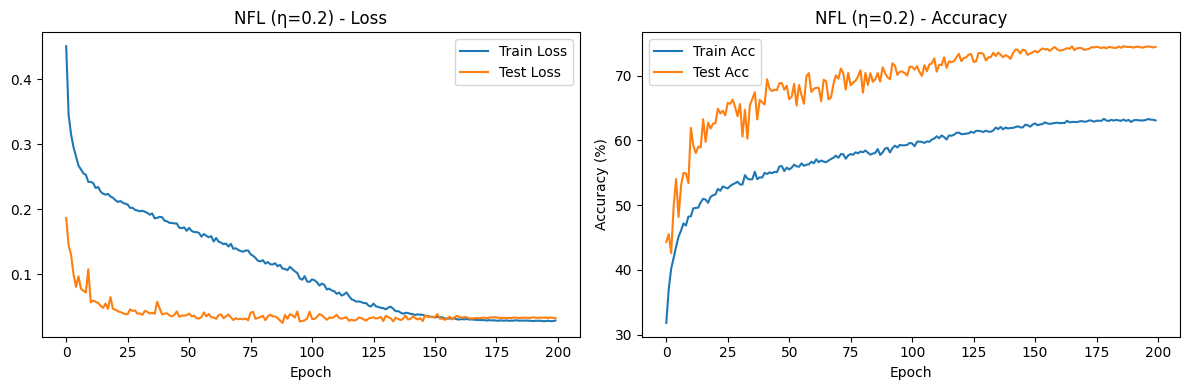


Training apl Losses...
 - NCE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 22.79% | Test Loss: 7.1906


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 25.07% | Test Loss: 6.9550


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 30.25% | Test Loss: 6.4837


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.84it/s]


Test Acc: 30.75% | Test Loss: 6.4291


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 28.12% | Test Loss: 6.6903


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 29.56% | Test Loss: 6.5620


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 31.23% | Test Loss: 6.4012


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 30.93% | Test Loss: 6.4152


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 30.63% | Test Loss: 6.4423


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 30.40% | Test Loss: 6.4636


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 22.87% | Test Loss: 7.1653


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 30.83% | Test Loss: 6.4280


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 29.38% | Test Loss: 6.5579


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 30.74% | Test Loss: 6.4224


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 30.36% | Test Loss: 6.4645


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.28it/s]


Test Acc: 32.03% | Test Loss: 6.3111


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 33.90% | Test Loss: 6.1380


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 33.21% | Test Loss: 6.2119


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 32.66% | Test Loss: 6.2493


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 31.78% | Test Loss: 6.3231


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 31.32% | Test Loss: 6.3871


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 34.65% | Test Loss: 6.0803


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.27it/s]


Test Acc: 33.47% | Test Loss: 6.1990


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 32.44% | Test Loss: 6.2952


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 30.35% | Test Loss: 6.4627


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.21it/s]


Test Acc: 31.73% | Test Loss: 6.3412


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 33.14% | Test Loss: 6.2244


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 33.73% | Test Loss: 6.1630


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 31.50% | Test Loss: 6.3550


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 31.51% | Test Loss: 6.3681


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 30.79% | Test Loss: 6.4395


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 32.95% | Test Loss: 6.2204


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 34.18% | Test Loss: 6.1090


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 33.41% | Test Loss: 6.1791


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 34.68% | Test Loss: 6.0462


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 33.66% | Test Loss: 6.1601


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 36.64% | Test Loss: 5.8866


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 36.01% | Test Loss: 5.9522


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 33.83% | Test Loss: 6.1498


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 36.44% | Test Loss: 5.9195


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 36.91% | Test Loss: 5.8632


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 36.74% | Test Loss: 5.8709


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 35.12% | Test Loss: 6.0315


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 36.09% | Test Loss: 5.9395


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 33.84% | Test Loss: 6.1460


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 34.18% | Test Loss: 6.1197


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 37.47% | Test Loss: 5.8297


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 33.32% | Test Loss: 6.1925


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 36.65% | Test Loss: 5.8722


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 32.59% | Test Loss: 6.2697


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 35.70% | Test Loss: 5.9930


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 34.30% | Test Loss: 6.1104


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 35.47% | Test Loss: 6.0005


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 37.66% | Test Loss: 5.8009


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 31.63% | Test Loss: 6.3552


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 36.73% | Test Loss: 5.8823


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 36.61% | Test Loss: 5.9023


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 33.48% | Test Loss: 6.1933


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 29.18% | Test Loss: 6.6052


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 35.64% | Test Loss: 5.9952


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 36.80% | Test Loss: 5.8850


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.41it/s]


Test Acc: 38.65% | Test Loss: 5.7144


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 36.16% | Test Loss: 5.9493


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 35.29% | Test Loss: 6.0246


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 37.57% | Test Loss: 5.7889


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 40.54% | Test Loss: 5.5199


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 37.98% | Test Loss: 5.7687


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 38.20% | Test Loss: 5.7357


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 37.66% | Test Loss: 5.7863


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 34.75% | Test Loss: 6.0503


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 37.09% | Test Loss: 5.8516


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.21it/s]


Test Acc: 37.56% | Test Loss: 5.7918


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 38.65% | Test Loss: 5.7020


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 37.55% | Test Loss: 5.8147


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 38.43% | Test Loss: 5.7260


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 39.47% | Test Loss: 5.6327


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 40.99% | Test Loss: 5.4863


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 40.60% | Test Loss: 5.5090


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 40.46% | Test Loss: 5.5277


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 38.94% | Test Loss: 5.6746


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 41.62% | Test Loss: 5.4286


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 38.96% | Test Loss: 5.6707


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 40.27% | Test Loss: 5.5605


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 41.66% | Test Loss: 5.4238


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 40.47% | Test Loss: 5.5349


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.53it/s]


Test Acc: 41.01% | Test Loss: 5.4768


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 41.24% | Test Loss: 5.4559


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 37.01% | Test Loss: 5.8526


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 38.77% | Test Loss: 5.6887


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 40.62% | Test Loss: 5.5262


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 40.44% | Test Loss: 5.5490


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 41.95% | Test Loss: 5.3965


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 41.48% | Test Loss: 5.4442


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 40.81% | Test Loss: 5.4967


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 38.53% | Test Loss: 5.7221


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 37.91% | Test Loss: 5.7759


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 43.01% | Test Loss: 5.3053


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 42.78% | Test Loss: 5.3191


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 40.28% | Test Loss: 5.5655


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.45it/s]


Test Acc: 41.36% | Test Loss: 5.4516


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 43.65% | Test Loss: 5.2400


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 43.47% | Test Loss: 5.2572


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 42.21% | Test Loss: 5.3588


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 34.06% | Test Loss: 6.1311


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 42.87% | Test Loss: 5.3115


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 41.56% | Test Loss: 5.4179


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 41.69% | Test Loss: 5.4043


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 41.25% | Test Loss: 5.4468


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 43.41% | Test Loss: 5.2481


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 43.35% | Test Loss: 5.2616


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 42.81% | Test Loss: 5.3245


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 37.90% | Test Loss: 5.7769


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 41.51% | Test Loss: 5.4286


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 42.81% | Test Loss: 5.2942


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.52it/s]


Test Acc: 44.43% | Test Loss: 5.1608


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 44.16% | Test Loss: 5.1814


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 39.69% | Test Loss: 5.6052


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 42.43% | Test Loss: 5.3586


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 43.92% | Test Loss: 5.2067


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 45.62% | Test Loss: 5.0453


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 44.50% | Test Loss: 5.1622


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 43.21% | Test Loss: 5.2838


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 44.07% | Test Loss: 5.1952


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 44.59% | Test Loss: 5.1386


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 44.16% | Test Loss: 5.1908


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 45.05% | Test Loss: 5.1035


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 45.85% | Test Loss: 5.0283


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 43.48% | Test Loss: 5.2465


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.67it/s]


Test Acc: 44.14% | Test Loss: 5.1870


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 44.17% | Test Loss: 5.1816


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 46.14% | Test Loss: 5.0039


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 45.14% | Test Loss: 5.0883


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 46.34% | Test Loss: 4.9952


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 47.17% | Test Loss: 4.9140


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 45.78% | Test Loss: 5.0473


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 46.65% | Test Loss: 4.9672


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 47.61% | Test Loss: 4.8832


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 46.52% | Test Loss: 4.9655


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 46.30% | Test Loss: 4.9856


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 43.70% | Test Loss: 5.2330


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 46.67% | Test Loss: 4.9655


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 47.65% | Test Loss: 4.8705


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 47.50% | Test Loss: 4.8843


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 46.77% | Test Loss: 4.9450


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 47.50% | Test Loss: 4.8832


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 47.47% | Test Loss: 4.8781


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 48.35% | Test Loss: 4.8011


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 48.13% | Test Loss: 4.8174


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 48.28% | Test Loss: 4.8057


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 48.44% | Test Loss: 4.7881


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 48.46% | Test Loss: 4.7816


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 48.23% | Test Loss: 4.8065


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 48.52% | Test Loss: 4.7813


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 48.71% | Test Loss: 4.7575


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 49.65% | Test Loss: 4.6843


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 49.74% | Test Loss: 4.6833


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 50.01% | Test Loss: 4.6447


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.61it/s]


Test Acc: 49.45% | Test Loss: 4.7025


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 49.63% | Test Loss: 4.6806


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 48.53% | Test Loss: 4.7882


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 48.77% | Test Loss: 4.7635


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 48.85% | Test Loss: 4.7581


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 49.02% | Test Loss: 4.7415


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 49.24% | Test Loss: 4.7224


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 49.36% | Test Loss: 4.7095


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 50.53% | Test Loss: 4.6048


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 49.94% | Test Loss: 4.6495


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 49.79% | Test Loss: 4.6707


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 50.27% | Test Loss: 4.6214


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 50.17% | Test Loss: 4.6383


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 50.81% | Test Loss: 4.5773


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 50.81% | Test Loss: 4.5776


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 50.79% | Test Loss: 4.5821


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 50.77% | Test Loss: 4.5810


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 51.34% | Test Loss: 4.5288


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 51.10% | Test Loss: 4.5504


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 51.21% | Test Loss: 4.5414


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 51.00% | Test Loss: 4.5450


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 51.28% | Test Loss: 4.5315


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.46it/s]


Test Acc: 51.49% | Test Loss: 4.5148


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 51.48% | Test Loss: 4.5041


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 51.63% | Test Loss: 4.4879


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 51.70% | Test Loss: 4.4826


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 51.64% | Test Loss: 4.4857


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 51.33% | Test Loss: 4.5169


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 51.87% | Test Loss: 4.4667


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 51.71% | Test Loss: 4.4831


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 51.61% | Test Loss: 4.5027


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 51.66% | Test Loss: 4.4922


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 51.81% | Test Loss: 4.4744


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 51.70% | Test Loss: 4.4850


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.35it/s]


Test Acc: 51.77% | Test Loss: 4.4817


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 51.79% | Test Loss: 4.4825


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 51.84% | Test Loss: 4.4775


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 51.83% | Test Loss: 4.4781


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 51.79% | Test Loss: 4.4793


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 51.88% | Test Loss: 4.4736


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 51.76% | Test Loss: 4.4826


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 51.97% | Test Loss: 4.4628


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 51.87% | Test Loss: 4.4727


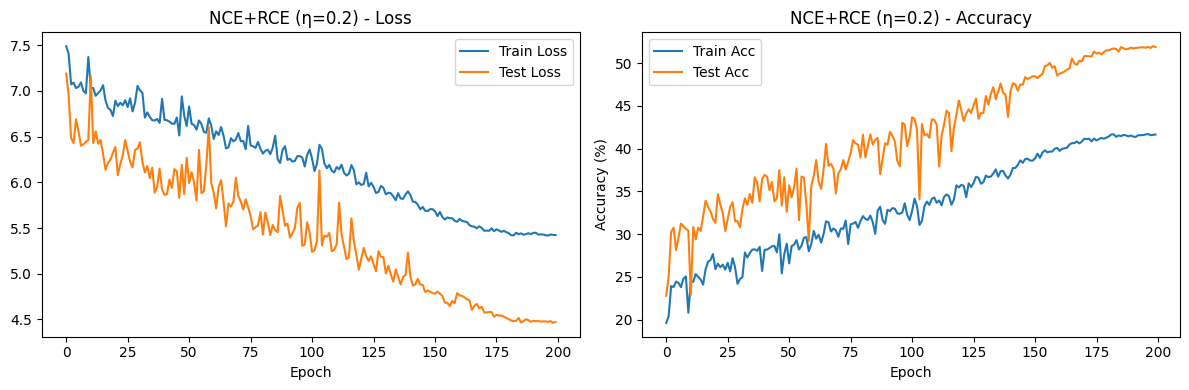

 - NCE+MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 52.22% | Test Loss: 0.5208


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 51.89% | Test Loss: 0.5128


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 62.58% | Test Loss: 0.3976


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 64.18% | Test Loss: 0.3830


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 61.77% | Test Loss: 0.4044


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 69.64% | Test Loss: 0.3197


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 71.11% | Test Loss: 0.3066


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 68.57% | Test Loss: 0.3296


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 74.44% | Test Loss: 0.2715


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 73.60% | Test Loss: 0.2780


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 75.45% | Test Loss: 0.2614


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.05it/s]


Test Acc: 73.75% | Test Loss: 0.2776


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.46it/s]


Test Acc: 76.14% | Test Loss: 0.2507


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 76.21% | Test Loss: 0.2476


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 77.22% | Test Loss: 0.2397


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 77.62% | Test Loss: 0.2338


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 75.93% | Test Loss: 0.2489


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.27it/s]


Test Acc: 78.25% | Test Loss: 0.2269


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 79.64% | Test Loss: 0.2135


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 79.29% | Test Loss: 0.2199


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 75.26% | Test Loss: 0.2623


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 80.81% | Test Loss: 0.1995


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 80.40% | Test Loss: 0.2074


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 80.86% | Test Loss: 0.2013


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 80.25% | Test Loss: 0.2072


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 80.94% | Test Loss: 0.1992


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 81.42% | Test Loss: 0.1942


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 82.19% | Test Loss: 0.1856


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 79.71% | Test Loss: 0.2125


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 80.03% | Test Loss: 0.2092


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 82.20% | Test Loss: 0.1867


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 83.38% | Test Loss: 0.1736


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 83.51% | Test Loss: 0.1712


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 83.56% | Test Loss: 0.1729


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 82.55% | Test Loss: 0.1825


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 82.00% | Test Loss: 0.1868


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 82.92% | Test Loss: 0.1778


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.32it/s]


Test Acc: 83.95% | Test Loss: 0.1680


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 83.10% | Test Loss: 0.1762


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 80.36% | Test Loss: 0.2061


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 84.44% | Test Loss: 0.1622


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 84.04% | Test Loss: 0.1672


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 84.02% | Test Loss: 0.1673


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 83.91% | Test Loss: 0.1666


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 84.73% | Test Loss: 0.1582


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 83.87% | Test Loss: 0.1688


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 85.02% | Test Loss: 0.1566


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 84.44% | Test Loss: 0.1616


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 84.97% | Test Loss: 0.1566


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 84.52% | Test Loss: 0.1622


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 84.75% | Test Loss: 0.1595


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 85.27% | Test Loss: 0.1537


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 85.09% | Test Loss: 0.1581


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 85.62% | Test Loss: 0.1505


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 85.41% | Test Loss: 0.1544


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 84.24% | Test Loss: 0.1627


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 85.71% | Test Loss: 0.1484


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 85.86% | Test Loss: 0.1467


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 85.68% | Test Loss: 0.1501


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 85.99% | Test Loss: 0.1468


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 86.46% | Test Loss: 0.1415


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 86.68% | Test Loss: 0.1392


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 86.00% | Test Loss: 0.1464


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 86.88% | Test Loss: 0.1374


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 86.43% | Test Loss: 0.1413


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 86.23% | Test Loss: 0.1439


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 86.55% | Test Loss: 0.1408


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 86.95% | Test Loss: 0.1368


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 86.54% | Test Loss: 0.1415


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 86.92% | Test Loss: 0.1381


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 85.66% | Test Loss: 0.1503


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 87.09% | Test Loss: 0.1356


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 87.30% | Test Loss: 0.1318


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 86.46% | Test Loss: 0.1416


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 87.05% | Test Loss: 0.1348


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 87.99% | Test Loss: 0.1269


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 87.02% | Test Loss: 0.1359


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 87.20% | Test Loss: 0.1343


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 86.85% | Test Loss: 0.1372


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 87.03% | Test Loss: 0.1363


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 87.07% | Test Loss: 0.1354


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.54it/s]


Test Acc: 86.84% | Test Loss: 0.1364


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 87.82% | Test Loss: 0.1291


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 87.35% | Test Loss: 0.1342


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 87.74% | Test Loss: 0.1282


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 87.17% | Test Loss: 0.1343


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 88.14% | Test Loss: 0.1246


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 87.44% | Test Loss: 0.1315


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 88.20% | Test Loss: 0.1241


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 87.57% | Test Loss: 0.1309


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 87.99% | Test Loss: 0.1261


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 88.16% | Test Loss: 0.1253


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 87.61% | Test Loss: 0.1302


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 88.19% | Test Loss: 0.1241


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 87.71% | Test Loss: 0.1294


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 87.52% | Test Loss: 0.1297


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 87.90% | Test Loss: 0.1263


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 87.52% | Test Loss: 0.1302


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 87.82% | Test Loss: 0.1274


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 87.63% | Test Loss: 0.1279


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 88.35% | Test Loss: 0.1221


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 88.37% | Test Loss: 0.1225


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 88.26% | Test Loss: 0.1220


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 88.52% | Test Loss: 0.1194


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 87.87% | Test Loss: 0.1273


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 88.01% | Test Loss: 0.1252


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 88.42% | Test Loss: 0.1209


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 88.43% | Test Loss: 0.1210


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 88.69% | Test Loss: 0.1197


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 88.20% | Test Loss: 0.1227


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.84it/s]


Test Acc: 88.41% | Test Loss: 0.1214


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.28it/s]


Test Acc: 88.58% | Test Loss: 0.1194


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.70it/s]


Test Acc: 88.85% | Test Loss: 0.1174


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.99it/s]


Test Acc: 88.58% | Test Loss: 0.1192


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.51it/s]


Test Acc: 88.50% | Test Loss: 0.1198


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.93it/s]


Test Acc: 88.55% | Test Loss: 0.1190


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.78it/s]


Test Acc: 88.65% | Test Loss: 0.1183


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.78it/s]


Test Acc: 88.85% | Test Loss: 0.1164


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 88.91% | Test Loss: 0.1166


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 88.56% | Test Loss: 0.1190


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 88.73% | Test Loss: 0.1175


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 88.66% | Test Loss: 0.1175


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 88.81% | Test Loss: 0.1175


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 88.89% | Test Loss: 0.1176


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 89.28% | Test Loss: 0.1133


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 88.88% | Test Loss: 0.1181


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 88.79% | Test Loss: 0.1184


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 88.81% | Test Loss: 0.1173


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 88.81% | Test Loss: 0.1174


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 89.06% | Test Loss: 0.1147


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 88.93% | Test Loss: 0.1165


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 89.19% | Test Loss: 0.1133


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 89.34% | Test Loss: 0.1129


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 89.59% | Test Loss: 0.1105


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 89.16% | Test Loss: 0.1144


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 89.22% | Test Loss: 0.1145


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 89.49% | Test Loss: 0.1117


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 88.93% | Test Loss: 0.1152


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 89.24% | Test Loss: 0.1126


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 88.77% | Test Loss: 0.1179


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 89.19% | Test Loss: 0.1145


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 88.98% | Test Loss: 0.1149


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 89.44% | Test Loss: 0.1124


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 89.22% | Test Loss: 0.1137


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 89.11% | Test Loss: 0.1146


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 88.92% | Test Loss: 0.1156


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 88.59% | Test Loss: 0.1188


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 89.01% | Test Loss: 0.1146


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 88.93% | Test Loss: 0.1148


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 89.20% | Test Loss: 0.1141


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 88.69% | Test Loss: 0.1185


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 89.34% | Test Loss: 0.1124


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 89.24% | Test Loss: 0.1133


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 89.19% | Test Loss: 0.1141


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 89.48% | Test Loss: 0.1122


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 89.34% | Test Loss: 0.1128


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 89.41% | Test Loss: 0.1127


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 89.33% | Test Loss: 0.1131


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 89.31% | Test Loss: 0.1130


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 89.37% | Test Loss: 0.1119


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 89.32% | Test Loss: 0.1127


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 89.47% | Test Loss: 0.1112


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 89.33% | Test Loss: 0.1121


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 89.10% | Test Loss: 0.1135


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 89.40% | Test Loss: 0.1119


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 89.32% | Test Loss: 0.1126


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 89.26% | Test Loss: 0.1130


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 89.53% | Test Loss: 0.1116


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 89.13% | Test Loss: 0.1140


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 89.52% | Test Loss: 0.1116


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 89.33% | Test Loss: 0.1119


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 89.40% | Test Loss: 0.1116


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 89.61% | Test Loss: 0.1112


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 89.47% | Test Loss: 0.1116


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 89.45% | Test Loss: 0.1117


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.05it/s]


Test Acc: 89.48% | Test Loss: 0.1119


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 89.45% | Test Loss: 0.1123


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 89.58% | Test Loss: 0.1113


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 89.49% | Test Loss: 0.1115


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 89.42% | Test Loss: 0.1115


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 89.56% | Test Loss: 0.1115


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 89.52% | Test Loss: 0.1110


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 89.44% | Test Loss: 0.1113


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 89.51% | Test Loss: 0.1114


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 89.45% | Test Loss: 0.1117


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 89.45% | Test Loss: 0.1115


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 89.52% | Test Loss: 0.1118


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 89.28% | Test Loss: 0.1121


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 89.42% | Test Loss: 0.1117


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 89.50% | Test Loss: 0.1115


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 89.42% | Test Loss: 0.1120


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 89.42% | Test Loss: 0.1115


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 89.46% | Test Loss: 0.1115


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 89.52% | Test Loss: 0.1116


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 89.40% | Test Loss: 0.1119


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 89.52% | Test Loss: 0.1118


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 89.49% | Test Loss: 0.1118


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 89.56% | Test Loss: 0.1117


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 89.45% | Test Loss: 0.1121


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 89.38% | Test Loss: 0.1119


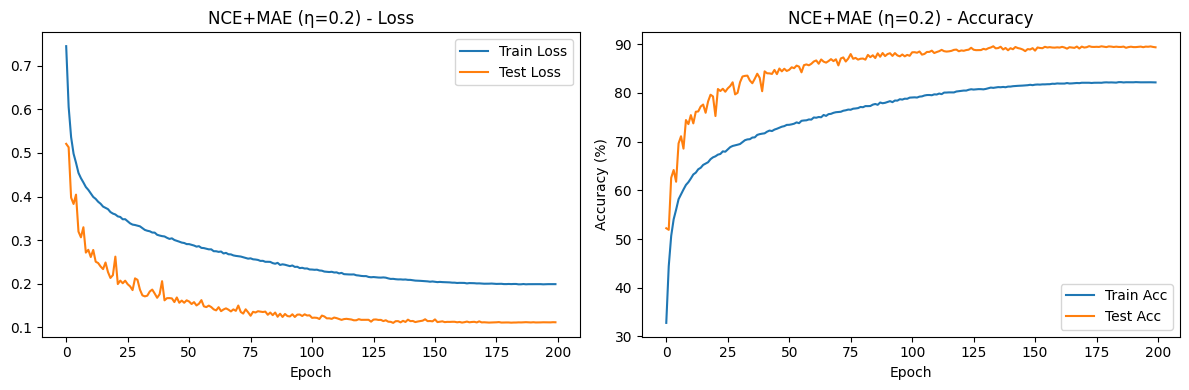

 - NFL+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 21.62% | Test Loss: 7.3142


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 29.16% | Test Loss: 6.5855


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 28.87% | Test Loss: 6.6115


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 29.98% | Test Loss: 6.5065


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 25.95% | Test Loss: 6.8836


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 25.90% | Test Loss: 6.8988


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 28.35% | Test Loss: 6.6601


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 26.72% | Test Loss: 6.8096


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 29.78% | Test Loss: 6.5116


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.34it/s]


Test Acc: 30.00% | Test Loss: 6.4923


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 27.74% | Test Loss: 6.7127


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.05it/s]


Test Acc: 31.21% | Test Loss: 6.3898


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.21it/s]


Test Acc: 32.39% | Test Loss: 6.2659


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 33.14% | Test Loss: 6.2201


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 32.66% | Test Loss: 6.2550


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 32.26% | Test Loss: 6.2883


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 30.90% | Test Loss: 6.4195


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 29.55% | Test Loss: 6.5441


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 28.46% | Test Loss: 6.6449


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 29.86% | Test Loss: 6.5362


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 30.70% | Test Loss: 6.4251


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 31.44% | Test Loss: 6.3634


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 30.68% | Test Loss: 6.4279


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 30.58% | Test Loss: 6.4323


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 30.16% | Test Loss: 6.4853


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 28.39% | Test Loss: 6.6702


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 33.89% | Test Loss: 6.1393


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 31.22% | Test Loss: 6.3867


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 32.40% | Test Loss: 6.2713


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 33.52% | Test Loss: 6.1858


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 29.89% | Test Loss: 6.5056


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 30.67% | Test Loss: 6.4522


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 29.02% | Test Loss: 6.5803


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 32.00% | Test Loss: 6.3040


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 29.76% | Test Loss: 6.5167


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 29.61% | Test Loss: 6.5604


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 33.43% | Test Loss: 6.1846


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 36.07% | Test Loss: 5.9207


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 31.07% | Test Loss: 6.4052


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 33.88% | Test Loss: 6.1494


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 32.44% | Test Loss: 6.2759


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 27.27% | Test Loss: 6.7566


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 32.03% | Test Loss: 6.3215


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 33.45% | Test Loss: 6.1842


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 32.96% | Test Loss: 6.2238


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 35.16% | Test Loss: 6.0171


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 37.03% | Test Loss: 5.8507


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 33.95% | Test Loss: 6.1393


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 33.57% | Test Loss: 6.1624


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 37.92% | Test Loss: 5.7686


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 37.03% | Test Loss: 5.8400


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 32.85% | Test Loss: 6.2300


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 33.95% | Test Loss: 6.1368


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 33.48% | Test Loss: 6.2035


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 37.50% | Test Loss: 5.8174


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 36.66% | Test Loss: 5.8851


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 35.83% | Test Loss: 5.9540


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 37.14% | Test Loss: 5.8433


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 37.03% | Test Loss: 5.8449


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 35.16% | Test Loss: 6.0273


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 34.84% | Test Loss: 6.0581


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 35.12% | Test Loss: 6.0398


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 35.58% | Test Loss: 5.9990


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 36.14% | Test Loss: 5.9266


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 36.23% | Test Loss: 5.9351


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 36.93% | Test Loss: 5.8742


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 36.28% | Test Loss: 5.9403


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 36.65% | Test Loss: 5.8986


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 37.27% | Test Loss: 5.8340


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 35.64% | Test Loss: 5.9825


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 33.80% | Test Loss: 6.1484


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.09it/s]


Test Acc: 36.56% | Test Loss: 5.8841


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 33.64% | Test Loss: 6.1695


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.79it/s]


Test Acc: 37.15% | Test Loss: 5.8526


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 38.33% | Test Loss: 5.7263


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 38.01% | Test Loss: 5.7533


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 37.27% | Test Loss: 5.8330


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 39.23% | Test Loss: 5.6455


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 33.83% | Test Loss: 6.1473


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 36.68% | Test Loss: 5.8948


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 37.57% | Test Loss: 5.8090


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 36.69% | Test Loss: 5.8882


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 38.81% | Test Loss: 5.6933


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 37.42% | Test Loss: 5.8218


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 37.46% | Test Loss: 5.8254


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 38.95% | Test Loss: 5.6544


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 38.43% | Test Loss: 5.7316


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 38.25% | Test Loss: 5.7253


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 39.59% | Test Loss: 5.6016


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 40.20% | Test Loss: 5.5605


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 39.83% | Test Loss: 5.5712


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 35.95% | Test Loss: 5.9244


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 37.06% | Test Loss: 5.8230


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 39.01% | Test Loss: 5.6521


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 40.70% | Test Loss: 5.5066


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 39.48% | Test Loss: 5.6306


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 42.57% | Test Loss: 5.3412


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 41.72% | Test Loss: 5.4033


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 41.50% | Test Loss: 5.4388


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 40.33% | Test Loss: 5.5496


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 42.35% | Test Loss: 5.3461


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 42.05% | Test Loss: 5.3846


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 41.36% | Test Loss: 5.4572


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 41.65% | Test Loss: 5.4217


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 41.17% | Test Loss: 5.4602


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 43.69% | Test Loss: 5.2346


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 41.85% | Test Loss: 5.4027


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 43.12% | Test Loss: 5.2811


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 44.09% | Test Loss: 5.1991


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 43.04% | Test Loss: 5.2788


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 43.67% | Test Loss: 5.2219


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 41.29% | Test Loss: 5.4492


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 45.32% | Test Loss: 5.0834


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 43.78% | Test Loss: 5.2128


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 44.46% | Test Loss: 5.1572


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 44.10% | Test Loss: 5.1935


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 44.90% | Test Loss: 5.1221


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 44.19% | Test Loss: 5.1878


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 42.27% | Test Loss: 5.3652


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 42.79% | Test Loss: 5.3175


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 43.45% | Test Loss: 5.2642


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 44.51% | Test Loss: 5.1450


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 45.03% | Test Loss: 5.0990


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 45.06% | Test Loss: 5.0880


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 44.99% | Test Loss: 5.1018


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 46.83% | Test Loss: 4.9322


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 45.52% | Test Loss: 5.0451


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 46.63% | Test Loss: 4.9411


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 45.08% | Test Loss: 5.0785


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 46.39% | Test Loss: 4.9792


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 47.57% | Test Loss: 4.8690


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 46.02% | Test Loss: 5.0020


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 47.42% | Test Loss: 4.8796


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 47.30% | Test Loss: 4.8994


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 47.92% | Test Loss: 4.8370


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 48.25% | Test Loss: 4.8024


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 48.22% | Test Loss: 4.8092


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 46.11% | Test Loss: 5.0157


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 47.57% | Test Loss: 4.8733


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 47.82% | Test Loss: 4.8465


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 48.07% | Test Loss: 4.8286


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 48.44% | Test Loss: 4.7957


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 49.34% | Test Loss: 4.7190


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 50.14% | Test Loss: 4.6413


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 49.49% | Test Loss: 4.7060


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 49.31% | Test Loss: 4.7231


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 48.84% | Test Loss: 4.7643


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 50.03% | Test Loss: 4.6520


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 50.12% | Test Loss: 4.6311


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 50.23% | Test Loss: 4.6230


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 49.59% | Test Loss: 4.6776


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 50.28% | Test Loss: 4.6108


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 50.31% | Test Loss: 4.6093


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 50.95% | Test Loss: 4.5480


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 49.90% | Test Loss: 4.6526


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 50.61% | Test Loss: 4.5915


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 50.95% | Test Loss: 4.5531


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 51.04% | Test Loss: 4.5410


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 52.04% | Test Loss: 4.4581


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 51.22% | Test Loss: 4.5306


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 52.06% | Test Loss: 4.4424


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 52.74% | Test Loss: 4.3840


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 52.52% | Test Loss: 4.4166


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 52.75% | Test Loss: 4.3962


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 53.30% | Test Loss: 4.3415


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 52.91% | Test Loss: 4.3750


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 53.05% | Test Loss: 4.3639


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 53.04% | Test Loss: 4.3663


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 53.33% | Test Loss: 4.3385


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 53.40% | Test Loss: 4.3331


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 53.15% | Test Loss: 4.3535


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 53.65% | Test Loss: 4.3169


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 53.30% | Test Loss: 4.3441


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 53.38% | Test Loss: 4.3321


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 53.43% | Test Loss: 4.3320


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 53.87% | Test Loss: 4.2938


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 53.81% | Test Loss: 4.3031


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 53.73% | Test Loss: 4.3093


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 53.67% | Test Loss: 4.3080


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 53.89% | Test Loss: 4.2938


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 53.73% | Test Loss: 4.3029


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 53.98% | Test Loss: 4.2827


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 54.11% | Test Loss: 4.2719


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 54.28% | Test Loss: 4.2562


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 54.30% | Test Loss: 4.2527


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 54.35% | Test Loss: 4.2517


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 54.31% | Test Loss: 4.2516


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 54.59% | Test Loss: 4.2327


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 54.32% | Test Loss: 4.2524


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 54.48% | Test Loss: 4.2374


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 54.53% | Test Loss: 4.2367


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 54.52% | Test Loss: 4.2355


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 54.41% | Test Loss: 4.2444


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 54.53% | Test Loss: 4.2348


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 54.40% | Test Loss: 4.2467


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 54.37% | Test Loss: 4.2471


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 54.54% | Test Loss: 4.2361


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 54.48% | Test Loss: 4.2408


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 54.46% | Test Loss: 4.2402


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 54.35% | Test Loss: 4.2510


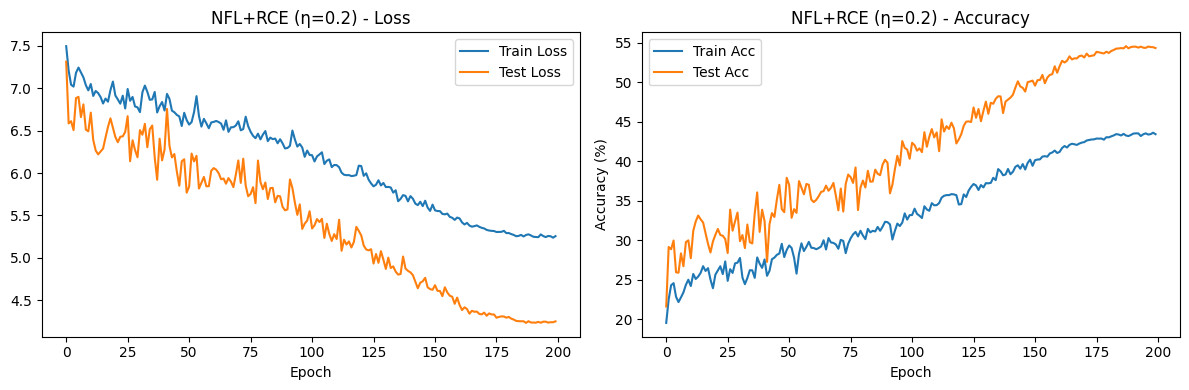

 - NFL+MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 48.24% | Test Loss: 0.5624


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 55.42% | Test Loss: 0.4771


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 61.91% | Test Loss: 0.4054


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 67.68% | Test Loss: 0.3451


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 70.04% | Test Loss: 0.3182


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 64.81% | Test Loss: 0.3714


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 71.74% | Test Loss: 0.2988


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 65.99% | Test Loss: 0.3570


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 71.85% | Test Loss: 0.2956


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 73.42% | Test Loss: 0.2788


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 73.13% | Test Loss: 0.2835


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 72.29% | Test Loss: 0.2903


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 75.30% | Test Loss: 0.2605


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 71.08% | Test Loss: 0.3072


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 77.18% | Test Loss: 0.2396


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 77.25% | Test Loss: 0.2382


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 78.44% | Test Loss: 0.2250


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 78.92% | Test Loss: 0.2211


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 79.64% | Test Loss: 0.2119


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 77.78% | Test Loss: 0.2318


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 78.14% | Test Loss: 0.2305


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 78.79% | Test Loss: 0.2225


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 81.23% | Test Loss: 0.1967


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 80.90% | Test Loss: 0.2009


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 81.70% | Test Loss: 0.1912


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 81.56% | Test Loss: 0.1923


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 82.20% | Test Loss: 0.1853


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 82.06% | Test Loss: 0.1878


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 81.20% | Test Loss: 0.1961


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 83.45% | Test Loss: 0.1730


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 82.86% | Test Loss: 0.1779


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 80.22% | Test Loss: 0.2062


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 83.35% | Test Loss: 0.1745


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 82.67% | Test Loss: 0.1808


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 83.21% | Test Loss: 0.1758


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.12it/s]


Test Acc: 83.25% | Test Loss: 0.1745


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.40it/s]


Test Acc: 81.50% | Test Loss: 0.1924


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 82.75% | Test Loss: 0.1784


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.07it/s]


Test Acc: 83.99% | Test Loss: 0.1661


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 83.82% | Test Loss: 0.1681


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 85.45% | Test Loss: 0.1532


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 84.43% | Test Loss: 0.1619


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 84.58% | Test Loss: 0.1602


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 85.21% | Test Loss: 0.1557


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 85.66% | Test Loss: 0.1505


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 83.69% | Test Loss: 0.1709


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.76it/s]


Test Acc: 84.48% | Test Loss: 0.1614


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 83.72% | Test Loss: 0.1698


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 84.46% | Test Loss: 0.1605


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 85.12% | Test Loss: 0.1545


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 85.63% | Test Loss: 0.1485


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 86.26% | Test Loss: 0.1435


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 86.22% | Test Loss: 0.1430


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 84.95% | Test Loss: 0.1556


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 87.03% | Test Loss: 0.1364


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 85.99% | Test Loss: 0.1467


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 85.80% | Test Loss: 0.1499


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 86.37% | Test Loss: 0.1414


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 86.62% | Test Loss: 0.1400


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 86.52% | Test Loss: 0.1404


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 86.92% | Test Loss: 0.1372


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 86.81% | Test Loss: 0.1381


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 86.55% | Test Loss: 0.1407


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 87.48% | Test Loss: 0.1324


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 86.33% | Test Loss: 0.1428


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 87.09% | Test Loss: 0.1348


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 87.49% | Test Loss: 0.1316


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 87.06% | Test Loss: 0.1349


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 87.01% | Test Loss: 0.1346


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 87.27% | Test Loss: 0.1332


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 86.65% | Test Loss: 0.1380


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 86.93% | Test Loss: 0.1362


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 87.55% | Test Loss: 0.1313


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 87.07% | Test Loss: 0.1346


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 87.12% | Test Loss: 0.1341


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 86.95% | Test Loss: 0.1365


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 87.26% | Test Loss: 0.1324


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 87.35% | Test Loss: 0.1310


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 88.15% | Test Loss: 0.1228


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 87.91% | Test Loss: 0.1262


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 87.77% | Test Loss: 0.1286


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 87.65% | Test Loss: 0.1291


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 86.94% | Test Loss: 0.1367


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 87.74% | Test Loss: 0.1275


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 87.20% | Test Loss: 0.1325


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 88.02% | Test Loss: 0.1262


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 87.69% | Test Loss: 0.1291


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 87.96% | Test Loss: 0.1254


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 88.63% | Test Loss: 0.1195


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 88.34% | Test Loss: 0.1201


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 88.79% | Test Loss: 0.1170


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 88.22% | Test Loss: 0.1238


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 88.05% | Test Loss: 0.1252


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 88.61% | Test Loss: 0.1192


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 88.52% | Test Loss: 0.1201


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 87.72% | Test Loss: 0.1292


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 88.15% | Test Loss: 0.1230


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 87.79% | Test Loss: 0.1269


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 88.44% | Test Loss: 0.1203


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 88.92% | Test Loss: 0.1153


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 88.42% | Test Loss: 0.1202


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 88.71% | Test Loss: 0.1178


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 88.95% | Test Loss: 0.1154


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 89.23% | Test Loss: 0.1132


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 88.93% | Test Loss: 0.1159


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 88.91% | Test Loss: 0.1163


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 89.16% | Test Loss: 0.1140


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 89.13% | Test Loss: 0.1135


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 89.07% | Test Loss: 0.1149


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 88.64% | Test Loss: 0.1178


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 88.80% | Test Loss: 0.1152


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 88.96% | Test Loss: 0.1150


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 88.98% | Test Loss: 0.1141


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 88.67% | Test Loss: 0.1166


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 88.93% | Test Loss: 0.1154


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 88.89% | Test Loss: 0.1158


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 89.04% | Test Loss: 0.1141


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 89.04% | Test Loss: 0.1143


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 89.19% | Test Loss: 0.1123


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 89.01% | Test Loss: 0.1138


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 89.18% | Test Loss: 0.1137


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 89.18% | Test Loss: 0.1131


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 89.10% | Test Loss: 0.1135


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 88.84% | Test Loss: 0.1156


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 88.93% | Test Loss: 0.1154


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 89.21% | Test Loss: 0.1130


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 89.35% | Test Loss: 0.1117


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 89.47% | Test Loss: 0.1107


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 89.10% | Test Loss: 0.1142


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 89.18% | Test Loss: 0.1121


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 89.30% | Test Loss: 0.1119


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 89.46% | Test Loss: 0.1102


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 89.75% | Test Loss: 0.1069


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 89.72% | Test Loss: 0.1084


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 89.37% | Test Loss: 0.1103


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 89.15% | Test Loss: 0.1118


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 89.11% | Test Loss: 0.1120


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 88.89% | Test Loss: 0.1143


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 89.34% | Test Loss: 0.1113


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 89.03% | Test Loss: 0.1131


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 89.25% | Test Loss: 0.1121


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 89.48% | Test Loss: 0.1101


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 89.32% | Test Loss: 0.1117


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 89.59% | Test Loss: 0.1090


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 89.41% | Test Loss: 0.1111


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 89.31% | Test Loss: 0.1117


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 89.27% | Test Loss: 0.1110


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 89.47% | Test Loss: 0.1110


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 89.44% | Test Loss: 0.1109


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 89.38% | Test Loss: 0.1103


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 89.46% | Test Loss: 0.1106


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 89.49% | Test Loss: 0.1099


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 89.50% | Test Loss: 0.1103


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 89.28% | Test Loss: 0.1108


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 89.31% | Test Loss: 0.1112


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 89.35% | Test Loss: 0.1103


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 89.30% | Test Loss: 0.1111


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 89.37% | Test Loss: 0.1102


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 89.59% | Test Loss: 0.1087


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 89.39% | Test Loss: 0.1103


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 89.35% | Test Loss: 0.1114


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 89.23% | Test Loss: 0.1106


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 89.47% | Test Loss: 0.1096


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 89.47% | Test Loss: 0.1099


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 89.24% | Test Loss: 0.1116


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 89.46% | Test Loss: 0.1100


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 89.51% | Test Loss: 0.1109


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 89.56% | Test Loss: 0.1093


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 89.36% | Test Loss: 0.1104


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 89.35% | Test Loss: 0.1115


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 89.52% | Test Loss: 0.1099


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 89.50% | Test Loss: 0.1104


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 89.36% | Test Loss: 0.1113


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 89.29% | Test Loss: 0.1108


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 89.37% | Test Loss: 0.1103


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 89.32% | Test Loss: 0.1112


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 89.40% | Test Loss: 0.1106


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 89.44% | Test Loss: 0.1102


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 89.51% | Test Loss: 0.1096


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 89.49% | Test Loss: 0.1101


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 89.35% | Test Loss: 0.1109


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 89.44% | Test Loss: 0.1106


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 89.53% | Test Loss: 0.1099


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 89.54% | Test Loss: 0.1098


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 89.57% | Test Loss: 0.1098


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 89.40% | Test Loss: 0.1107


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 89.44% | Test Loss: 0.1102


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 89.38% | Test Loss: 0.1101


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 89.39% | Test Loss: 0.1102


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 89.34% | Test Loss: 0.1110


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 89.42% | Test Loss: 0.1103


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 89.40% | Test Loss: 0.1104


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 89.47% | Test Loss: 0.1101


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 89.32% | Test Loss: 0.1107


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 89.30% | Test Loss: 0.1108


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 89.34% | Test Loss: 0.1105


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 89.33% | Test Loss: 0.1110


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 89.37% | Test Loss: 0.1107


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 89.36% | Test Loss: 0.1105


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 89.47% | Test Loss: 0.1104


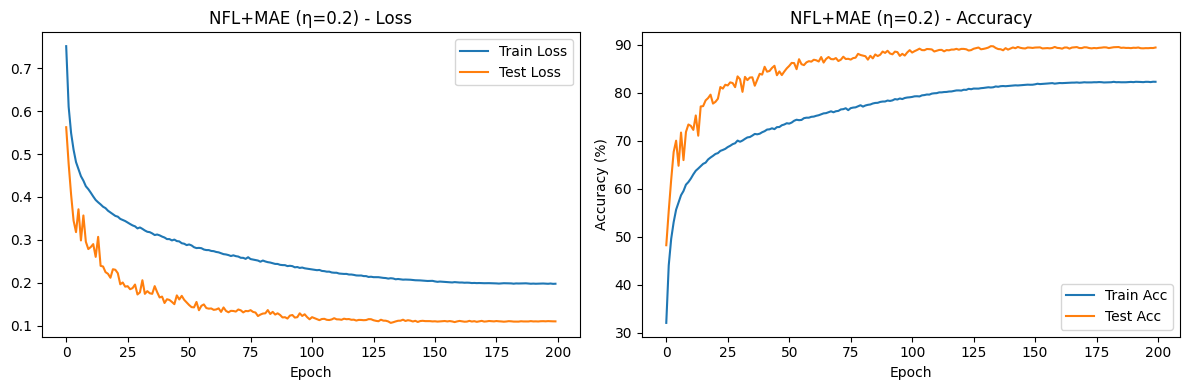

 - NFL+NCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 40.77% | Test Loss: 0.0537


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 46.26% | Test Loss: 0.0397


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 46.93% | Test Loss: 0.0355


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 48.28% | Test Loss: 0.0361


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 48.81% | Test Loss: 0.0321


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 53.99% | Test Loss: 0.0260


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 54.53% | Test Loss: 0.0264


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 56.14% | Test Loss: 0.0241


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 54.85% | Test Loss: 0.0236


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 59.16% | Test Loss: 0.0210


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 58.78% | Test Loss: 0.0210


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 61.22% | Test Loss: 0.0188


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 61.46% | Test Loss: 0.0183


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 60.57% | Test Loss: 0.0176


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 61.60% | Test Loss: 0.0171


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 60.19% | Test Loss: 0.0256


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 63.57% | Test Loss: 0.0157


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 62.59% | Test Loss: 0.0159


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 63.65% | Test Loss: 0.0150


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 63.05% | Test Loss: 0.0141


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 63.20% | Test Loss: 0.0164


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 62.55% | Test Loss: 0.0180


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 65.21% | Test Loss: 0.0127


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 64.45% | Test Loss: 0.0146


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 65.56% | Test Loss: 0.0134


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 64.80% | Test Loss: 0.0145


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 66.94% | Test Loss: 0.0125


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 66.21% | Test Loss: 0.0114


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 65.53% | Test Loss: 0.0142


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 66.59% | Test Loss: 0.0142


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 64.73% | Test Loss: 0.0147


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 66.67% | Test Loss: 0.0126


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 68.62% | Test Loss: 0.0104


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 67.31% | Test Loss: 0.0112


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 67.41% | Test Loss: 0.0111


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 68.01% | Test Loss: 0.0110


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 65.98% | Test Loss: 0.0138


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 66.75% | Test Loss: 0.0108


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 68.43% | Test Loss: 0.0113


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 66.04% | Test Loss: 0.0152


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 68.13% | Test Loss: 0.0112


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 67.02% | Test Loss: 0.0134


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 68.53% | Test Loss: 0.0104


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 69.32% | Test Loss: 0.0101


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 70.15% | Test Loss: 0.0093


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 69.22% | Test Loss: 0.0103


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 68.04% | Test Loss: 0.0110


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 68.86% | Test Loss: 0.0106


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 69.58% | Test Loss: 0.0110


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 68.15% | Test Loss: 0.0111


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 69.88% | Test Loss: 0.0100


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 70.41% | Test Loss: 0.0105


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 69.68% | Test Loss: 0.0111


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 68.60% | Test Loss: 0.0098


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 69.49% | Test Loss: 0.0104


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 69.18% | Test Loss: 0.0102


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 69.34% | Test Loss: 0.0105


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 71.06% | Test Loss: 0.0090


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 69.07% | Test Loss: 0.0097


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 68.92% | Test Loss: 0.0104


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 70.32% | Test Loss: 0.0101


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 70.51% | Test Loss: 0.0096


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 70.12% | Test Loss: 0.0109


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 67.54% | Test Loss: 0.0122


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 67.84% | Test Loss: 0.0124


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 67.50% | Test Loss: 0.0130


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 67.78% | Test Loss: 0.0102


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 70.35% | Test Loss: 0.0105


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 69.81% | Test Loss: 0.0113


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 65.68% | Test Loss: 0.0141


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 68.90% | Test Loss: 0.0109


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 65.69% | Test Loss: 0.0176


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 70.04% | Test Loss: 0.0098


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 69.49% | Test Loss: 0.0117


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 69.98% | Test Loss: 0.0115


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 70.42% | Test Loss: 0.0104


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 65.75% | Test Loss: 0.0171


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 69.28% | Test Loss: 0.0113


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 70.07% | Test Loss: 0.0116


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 71.13% | Test Loss: 0.0096


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 68.99% | Test Loss: 0.0117


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 70.29% | Test Loss: 0.0113


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 69.69% | Test Loss: 0.0102


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 67.37% | Test Loss: 0.0222


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 69.58% | Test Loss: 0.0103


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.58it/s]


Test Acc: 70.51% | Test Loss: 0.0108


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 70.06% | Test Loss: 0.0102


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 71.14% | Test Loss: 0.0108


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 68.16% | Test Loss: 0.0140


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 70.63% | Test Loss: 0.0102


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 71.49% | Test Loss: 0.0102


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 69.67% | Test Loss: 0.0110


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 66.86% | Test Loss: 0.0134


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 69.49% | Test Loss: 0.0122


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 69.93% | Test Loss: 0.0113


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 70.26% | Test Loss: 0.0099


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 67.65% | Test Loss: 0.0166


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 71.98% | Test Loss: 0.0101


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 68.44% | Test Loss: 0.0119


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 67.92% | Test Loss: 0.0129


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 65.32% | Test Loss: 0.0120


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 69.32% | Test Loss: 0.0121


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 70.05% | Test Loss: 0.0125


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 69.58% | Test Loss: 0.0127


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 69.63% | Test Loss: 0.0133


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 70.78% | Test Loss: 0.0102


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 71.23% | Test Loss: 0.0118


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 70.07% | Test Loss: 0.0130


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 70.35% | Test Loss: 0.0121


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 70.77% | Test Loss: 0.0125


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 72.18% | Test Loss: 0.0111


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 70.10% | Test Loss: 0.0131


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 71.80% | Test Loss: 0.0119


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 68.65% | Test Loss: 0.0140


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 70.15% | Test Loss: 0.0108


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 71.60% | Test Loss: 0.0113


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 71.48% | Test Loss: 0.0126


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 72.09% | Test Loss: 0.0107


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 71.12% | Test Loss: 0.0119


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 71.83% | Test Loss: 0.0118


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 71.66% | Test Loss: 0.0113


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 72.29% | Test Loss: 0.0118


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 72.43% | Test Loss: 0.0127


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 72.12% | Test Loss: 0.0110


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 71.13% | Test Loss: 0.0123


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 70.93% | Test Loss: 0.0110


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 72.44% | Test Loss: 0.0118


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 73.03% | Test Loss: 0.0102


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 72.23% | Test Loss: 0.0116


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 72.44% | Test Loss: 0.0120


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 72.89% | Test Loss: 0.0121


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 72.61% | Test Loss: 0.0100


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 72.97% | Test Loss: 0.0115


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 72.32% | Test Loss: 0.0112


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 71.98% | Test Loss: 0.0112


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 71.41% | Test Loss: 0.0110


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 72.17% | Test Loss: 0.0123


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 72.32% | Test Loss: 0.0104


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 72.24% | Test Loss: 0.0115


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 72.75% | Test Loss: 0.0107


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 72.35% | Test Loss: 0.0095


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 73.10% | Test Loss: 0.0121


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 72.73% | Test Loss: 0.0114


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 72.74% | Test Loss: 0.0128


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 72.18% | Test Loss: 0.0115


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 72.42% | Test Loss: 0.0111


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 72.54% | Test Loss: 0.0113


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 72.53% | Test Loss: 0.0113


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 72.96% | Test Loss: 0.0120


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 72.44% | Test Loss: 0.0121


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 72.89% | Test Loss: 0.0103


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 72.67% | Test Loss: 0.0112


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 72.55% | Test Loss: 0.0117


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 72.95% | Test Loss: 0.0110


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 73.54% | Test Loss: 0.0107


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 72.36% | Test Loss: 0.0111


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 73.01% | Test Loss: 0.0111


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 72.63% | Test Loss: 0.0114


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 72.66% | Test Loss: 0.0118


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 73.22% | Test Loss: 0.0112


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 72.92% | Test Loss: 0.0118


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 73.30% | Test Loss: 0.0116


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 73.05% | Test Loss: 0.0127


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 72.96% | Test Loss: 0.0120


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 72.57% | Test Loss: 0.0115


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 73.14% | Test Loss: 0.0111


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 72.49% | Test Loss: 0.0106


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 72.99% | Test Loss: 0.0112


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 73.18% | Test Loss: 0.0123


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 72.79% | Test Loss: 0.0128


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 72.55% | Test Loss: 0.0116


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 73.19% | Test Loss: 0.0122


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 73.58% | Test Loss: 0.0116


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 72.58% | Test Loss: 0.0129


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 73.10% | Test Loss: 0.0123


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 72.83% | Test Loss: 0.0116


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 72.96% | Test Loss: 0.0120


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 73.15% | Test Loss: 0.0121


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 73.35% | Test Loss: 0.0118


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 72.92% | Test Loss: 0.0124


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 72.95% | Test Loss: 0.0127


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 72.99% | Test Loss: 0.0122


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 72.95% | Test Loss: 0.0119


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 73.10% | Test Loss: 0.0121


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 73.06% | Test Loss: 0.0127


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 72.96% | Test Loss: 0.0125


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 72.91% | Test Loss: 0.0120


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 73.17% | Test Loss: 0.0125


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 72.94% | Test Loss: 0.0124


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 73.11% | Test Loss: 0.0125


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 73.04% | Test Loss: 0.0121


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 72.97% | Test Loss: 0.0125


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 72.90% | Test Loss: 0.0121


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 72.98% | Test Loss: 0.0122


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 73.08% | Test Loss: 0.0122


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 73.14% | Test Loss: 0.0119


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 72.94% | Test Loss: 0.0124


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 72.96% | Test Loss: 0.0122


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 73.11% | Test Loss: 0.0123


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 72.89% | Test Loss: 0.0122


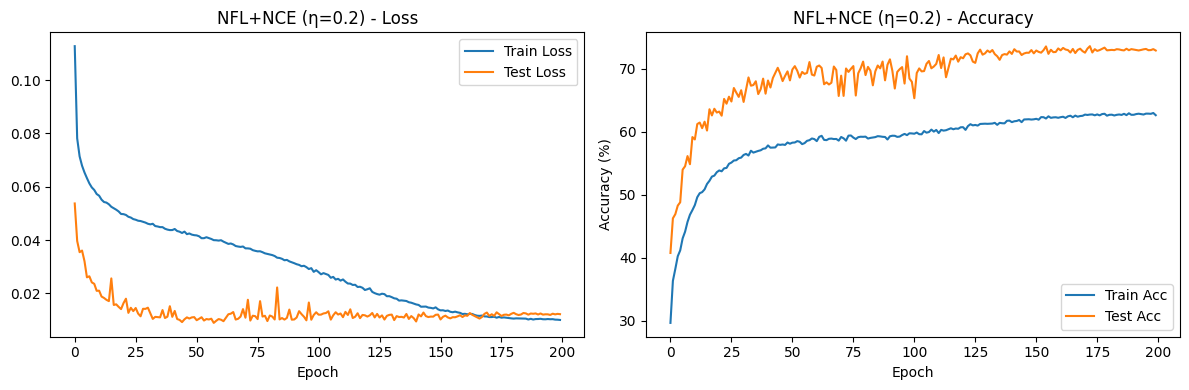

 - MAE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 21.24% | Test Loss: 8.0477


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 22.04% | Test Loss: 7.9701


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 21.80% | Test Loss: 7.9914


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 20.64% | Test Loss: 8.1037


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 21.05% | Test Loss: 8.0613


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 20.54% | Test Loss: 8.1114


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 22.06% | Test Loss: 7.9608


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 20.27% | Test Loss: 8.1428


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 25.26% | Test Loss: 7.6300


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 20.53% | Test Loss: 8.1067


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 23.26% | Test Loss: 7.8409


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 25.03% | Test Loss: 7.6636


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 25.71% | Test Loss: 7.5840


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 23.23% | Test Loss: 7.8242


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 24.96% | Test Loss: 7.6574


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 25.14% | Test Loss: 7.6444


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 26.38% | Test Loss: 7.5111


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 24.87% | Test Loss: 7.6804


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 27.31% | Test Loss: 7.4178


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 26.72% | Test Loss: 7.4858


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 27.43% | Test Loss: 7.4035


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 26.87% | Test Loss: 7.4696


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 27.42% | Test Loss: 7.4149


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 26.17% | Test Loss: 7.5484


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 26.63% | Test Loss: 7.4926


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 27.73% | Test Loss: 7.3770


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 27.03% | Test Loss: 7.4531


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 26.85% | Test Loss: 7.4640


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 25.18% | Test Loss: 7.6472


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 24.56% | Test Loss: 7.6958


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 26.71% | Test Loss: 7.4855


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 26.22% | Test Loss: 7.5348


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 25.38% | Test Loss: 7.6183


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 27.27% | Test Loss: 7.4283


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 26.01% | Test Loss: 7.5562


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 27.32% | Test Loss: 7.4246


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 26.51% | Test Loss: 7.5048


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 28.09% | Test Loss: 7.3405


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 27.65% | Test Loss: 7.3964


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 26.96% | Test Loss: 7.4678


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 27.87% | Test Loss: 7.3668


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 27.37% | Test Loss: 7.4193


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 27.68% | Test Loss: 7.3944


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 27.95% | Test Loss: 7.3588


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 27.21% | Test Loss: 7.4283


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 29.02% | Test Loss: 7.2517


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 28.29% | Test Loss: 7.3199


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 28.33% | Test Loss: 7.3134


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 28.59% | Test Loss: 7.2955


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 28.84% | Test Loss: 7.2696


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 28.89% | Test Loss: 7.2652


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 26.19% | Test Loss: 7.5393


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 27.84% | Test Loss: 7.3698


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 29.13% | Test Loss: 7.2347


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 28.24% | Test Loss: 7.3242


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 28.35% | Test Loss: 7.3055


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 28.92% | Test Loss: 7.2541


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 28.55% | Test Loss: 7.2988


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 27.87% | Test Loss: 7.3589


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 29.16% | Test Loss: 7.2389


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 28.40% | Test Loss: 7.3008


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 27.95% | Test Loss: 7.3458


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 28.44% | Test Loss: 7.3030


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 29.46% | Test Loss: 7.2067


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 27.91% | Test Loss: 7.3561


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 28.33% | Test Loss: 7.3135


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 28.98% | Test Loss: 7.2569


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 29.41% | Test Loss: 7.2124


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 29.11% | Test Loss: 7.2428


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 28.89% | Test Loss: 7.2661


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 30.33% | Test Loss: 7.1112


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 27.99% | Test Loss: 7.3586


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 30.04% | Test Loss: 7.1503


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 28.76% | Test Loss: 7.2809


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 28.02% | Test Loss: 7.3526


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 29.75% | Test Loss: 7.1775


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 28.51% | Test Loss: 7.2962


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 28.23% | Test Loss: 7.3337


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 28.36% | Test Loss: 7.3081


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 27.49% | Test Loss: 7.4003


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 26.77% | Test Loss: 7.4703


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 29.63% | Test Loss: 7.1921


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 29.15% | Test Loss: 7.2310


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 29.03% | Test Loss: 7.2442


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 28.30% | Test Loss: 7.3222


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 27.43% | Test Loss: 7.4061


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 28.71% | Test Loss: 7.2900


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 30.03% | Test Loss: 7.1427


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 30.12% | Test Loss: 7.1417


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 30.09% | Test Loss: 7.1372


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 30.17% | Test Loss: 7.1278


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 29.58% | Test Loss: 7.1870


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 29.82% | Test Loss: 7.1712


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 29.90% | Test Loss: 7.1627


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 29.27% | Test Loss: 7.2188


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 30.31% | Test Loss: 7.1305


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 30.05% | Test Loss: 7.1486


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 29.80% | Test Loss: 7.1783


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 31.20% | Test Loss: 7.0253


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 29.94% | Test Loss: 7.1540


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 30.89% | Test Loss: 7.0643


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 30.86% | Test Loss: 7.0594


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 31.21% | Test Loss: 7.0233


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 30.75% | Test Loss: 7.0700


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 30.80% | Test Loss: 7.0732


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 31.19% | Test Loss: 7.0230


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 30.39% | Test Loss: 7.1075


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 30.90% | Test Loss: 7.0617


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 31.00% | Test Loss: 7.0441


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 31.11% | Test Loss: 7.0338


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 31.18% | Test Loss: 7.0268


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 31.39% | Test Loss: 7.0083


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 31.38% | Test Loss: 7.0054


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 31.23% | Test Loss: 7.0225


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 30.85% | Test Loss: 7.0612


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 31.56% | Test Loss: 6.9955


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 30.76% | Test Loss: 7.0684


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 32.04% | Test Loss: 6.9394


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 31.48% | Test Loss: 6.9958


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 31.81% | Test Loss: 6.9602


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 31.84% | Test Loss: 6.9584


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 31.03% | Test Loss: 7.0444


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 32.83% | Test Loss: 6.8567


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 33.96% | Test Loss: 6.7514


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 34.53% | Test Loss: 6.6879


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 34.14% | Test Loss: 6.7339


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 34.95% | Test Loss: 6.6459


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 34.68% | Test Loss: 6.6754


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 34.67% | Test Loss: 6.6759


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 34.38% | Test Loss: 6.7055


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 35.04% | Test Loss: 6.6382


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 35.42% | Test Loss: 6.5986


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 35.61% | Test Loss: 6.5788


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 35.46% | Test Loss: 6.5979


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 35.27% | Test Loss: 6.6141


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 35.76% | Test Loss: 6.5658


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 35.80% | Test Loss: 6.5585


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 35.79% | Test Loss: 6.5588


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 35.32% | Test Loss: 6.6102


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 36.34% | Test Loss: 6.5083


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 36.02% | Test Loss: 6.5363


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 35.92% | Test Loss: 6.5470


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 36.19% | Test Loss: 6.5169


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 35.87% | Test Loss: 6.5514


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 36.76% | Test Loss: 6.4635


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 36.45% | Test Loss: 6.4974


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 36.96% | Test Loss: 6.4442


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 36.38% | Test Loss: 6.5008


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 36.69% | Test Loss: 6.4681


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 36.61% | Test Loss: 6.4770


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 37.41% | Test Loss: 6.3902


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 36.96% | Test Loss: 6.4390


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 36.53% | Test Loss: 6.4863


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 37.70% | Test Loss: 6.3686


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 37.18% | Test Loss: 6.4164


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 37.38% | Test Loss: 6.3957


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 36.61% | Test Loss: 6.4801


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 36.84% | Test Loss: 6.4546


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 37.32% | Test Loss: 6.4065


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 37.54% | Test Loss: 6.3841


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 37.51% | Test Loss: 6.3799


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 36.99% | Test Loss: 6.4412


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 37.62% | Test Loss: 6.3713


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 37.79% | Test Loss: 6.3500


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 37.57% | Test Loss: 6.3767


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 37.55% | Test Loss: 6.3760


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 37.54% | Test Loss: 6.3807


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 37.61% | Test Loss: 6.3701


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 37.71% | Test Loss: 6.3605


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 38.01% | Test Loss: 6.3285


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 38.01% | Test Loss: 6.3304


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 37.77% | Test Loss: 6.3561


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 38.04% | Test Loss: 6.3258


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 37.67% | Test Loss: 6.3656


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 37.85% | Test Loss: 6.3517


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 37.98% | Test Loss: 6.3327


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 37.92% | Test Loss: 6.3377


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 37.94% | Test Loss: 6.3383


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 37.93% | Test Loss: 6.3332


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 38.03% | Test Loss: 6.3265


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 38.25% | Test Loss: 6.3098


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 38.15% | Test Loss: 6.3147


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 37.93% | Test Loss: 6.3389


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 38.21% | Test Loss: 6.3096


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 38.26% | Test Loss: 6.3064


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 38.14% | Test Loss: 6.3159


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 38.09% | Test Loss: 6.3229


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 37.97% | Test Loss: 6.3346


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 38.21% | Test Loss: 6.3080


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 38.20% | Test Loss: 6.3091


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 38.29% | Test Loss: 6.3006


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 38.19% | Test Loss: 6.3094


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 38.32% | Test Loss: 6.3005


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 38.02% | Test Loss: 6.3273


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 38.12% | Test Loss: 6.3161


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 38.15% | Test Loss: 6.3140


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 38.16% | Test Loss: 6.3154


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 38.00% | Test Loss: 6.3301


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 38.15% | Test Loss: 6.3161


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 38.25% | Test Loss: 6.3060


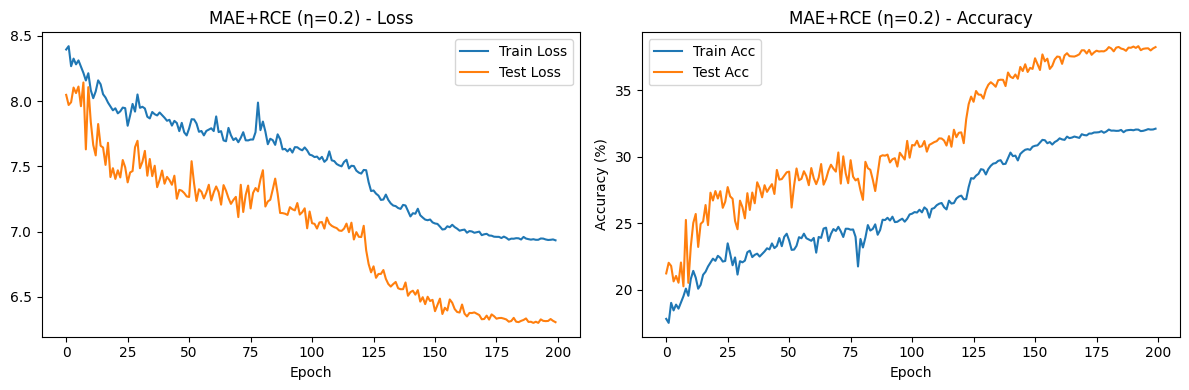


Noise Rate: 0.4

Training vanilla Losses...
 - CE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.41it/s]


Test Acc: 48.00% | Test Loss: 1.5289


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.48it/s]


Test Acc: 58.87% | Test Loss: 1.3457


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 65.48% | Test Loss: 1.2305


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 67.39% | Test Loss: 1.1858


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 71.45% | Test Loss: 1.1056


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 73.68% | Test Loss: 1.0500


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 73.11% | Test Loss: 1.0874


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 72.10% | Test Loss: 1.0747


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 72.81% | Test Loss: 1.1910


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 75.11% | Test Loss: 0.9390


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 74.16% | Test Loss: 1.0187


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 76.02% | Test Loss: 0.9706


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 77.96% | Test Loss: 0.9765


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 77.73% | Test Loss: 0.9096


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 77.59% | Test Loss: 1.0138


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 79.33% | Test Loss: 0.9012


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.34it/s]


Test Acc: 78.76% | Test Loss: 0.9629


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 79.40% | Test Loss: 0.9556


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 75.85% | Test Loss: 0.9619


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 78.28% | Test Loss: 1.0582


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 76.75% | Test Loss: 0.9694


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 78.15% | Test Loss: 0.9407


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 78.79% | Test Loss: 0.9578


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 78.53% | Test Loss: 0.9467


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.26it/s]


Test Acc: 79.94% | Test Loss: 0.8433


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.26it/s]


Test Acc: 79.96% | Test Loss: 0.9252


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 77.80% | Test Loss: 0.9248


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 78.66% | Test Loss: 0.9859


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 80.59% | Test Loss: 0.8884


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 78.31% | Test Loss: 0.9331


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 78.34% | Test Loss: 1.0241


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.12it/s]


Test Acc: 80.09% | Test Loss: 0.8883


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 77.89% | Test Loss: 0.8942


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 80.76% | Test Loss: 0.8661


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 78.49% | Test Loss: 0.9589


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 78.67% | Test Loss: 0.9732


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 77.83% | Test Loss: 0.9851


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 79.25% | Test Loss: 0.8275


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 77.23% | Test Loss: 0.9615


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 78.11% | Test Loss: 0.9093


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 78.21% | Test Loss: 0.9332


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.26it/s]


Test Acc: 78.16% | Test Loss: 0.9161


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 77.72% | Test Loss: 0.9140


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.68it/s]


Test Acc: 78.78% | Test Loss: 0.8499


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 75.73% | Test Loss: 0.9826


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.65it/s]


Test Acc: 76.63% | Test Loss: 1.0011


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 77.40% | Test Loss: 0.8978


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 75.67% | Test Loss: 0.9532


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 75.00% | Test Loss: 0.9622


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 73.08% | Test Loss: 0.9920


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 72.72% | Test Loss: 1.0143


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 71.35% | Test Loss: 1.0309


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 72.49% | Test Loss: 1.0387


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 71.67% | Test Loss: 1.0771


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 71.87% | Test Loss: 1.0066


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 71.35% | Test Loss: 1.0177


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 71.58% | Test Loss: 1.0173


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.37it/s]


Test Acc: 69.66% | Test Loss: 1.0698


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.67it/s]


Test Acc: 72.14% | Test Loss: 0.9812


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 69.27% | Test Loss: 1.0724


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 68.54% | Test Loss: 1.0897


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 68.78% | Test Loss: 1.0862


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 70.67% | Test Loss: 1.0164


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.76it/s]


Test Acc: 67.20% | Test Loss: 1.1184


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 68.91% | Test Loss: 1.0659


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 66.16% | Test Loss: 1.1219


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 66.16% | Test Loss: 1.1603


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 65.63% | Test Loss: 1.1713


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 63.91% | Test Loss: 1.2254


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.62it/s]


Test Acc: 67.17% | Test Loss: 1.1321


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 65.42% | Test Loss: 1.1586


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 66.01% | Test Loss: 1.1395


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 65.97% | Test Loss: 1.1654


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 63.90% | Test Loss: 1.2181


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 64.60% | Test Loss: 1.2060


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 66.48% | Test Loss: 1.1496


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 63.55% | Test Loss: 1.2394


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 59.84% | Test Loss: 1.3363


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 64.01% | Test Loss: 1.2434


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 65.45% | Test Loss: 1.1687


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.05it/s]


Test Acc: 65.25% | Test Loss: 1.1954


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.55it/s]


Test Acc: 61.58% | Test Loss: 1.2981


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 63.78% | Test Loss: 1.2715


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 62.06% | Test Loss: 1.3192


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 65.72% | Test Loss: 1.1875


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.46it/s]


Test Acc: 62.78% | Test Loss: 1.2904


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 62.19% | Test Loss: 1.3131


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.12it/s]


Test Acc: 63.86% | Test Loss: 1.2750


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 59.88% | Test Loss: 1.3954


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 61.36% | Test Loss: 1.3652


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 61.40% | Test Loss: 1.3322


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 61.36% | Test Loss: 1.3834


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 63.03% | Test Loss: 1.3086


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 63.95% | Test Loss: 1.3115


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 57.60% | Test Loss: 1.5718


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 59.23% | Test Loss: 1.4736


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 59.50% | Test Loss: 1.4673


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 60.26% | Test Loss: 1.4566


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 61.44% | Test Loss: 1.4598


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 59.91% | Test Loss: 1.4868


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 64.55% | Test Loss: 1.3301


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 60.36% | Test Loss: 1.5263


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 64.79% | Test Loss: 1.3488


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.49it/s]


Test Acc: 61.05% | Test Loss: 1.4938


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 64.32% | Test Loss: 1.3752


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 63.18% | Test Loss: 1.4033


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 61.67% | Test Loss: 1.4719


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 61.21% | Test Loss: 1.4976


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.05it/s]


Test Acc: 64.31% | Test Loss: 1.3990


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 62.24% | Test Loss: 1.4912


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.38it/s]


Test Acc: 62.45% | Test Loss: 1.4757


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 60.85% | Test Loss: 1.5069


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.21it/s]


Test Acc: 59.03% | Test Loss: 1.6194


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 62.66% | Test Loss: 1.5121


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 63.37% | Test Loss: 1.4844


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.55it/s]


Test Acc: 61.90% | Test Loss: 1.5338


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 62.62% | Test Loss: 1.5212


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 62.58% | Test Loss: 1.5188


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.57it/s]


Test Acc: 61.18% | Test Loss: 1.5583


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 63.23% | Test Loss: 1.5105


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 62.68% | Test Loss: 1.5259


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 61.99% | Test Loss: 1.5692


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 62.30% | Test Loss: 1.5696


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 62.12% | Test Loss: 1.5556


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 62.12% | Test Loss: 1.5644


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.97it/s]


Test Acc: 61.99% | Test Loss: 1.6042


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 62.31% | Test Loss: 1.5770


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.01it/s]


Test Acc: 63.07% | Test Loss: 1.5775


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 63.36% | Test Loss: 1.5674


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 61.37% | Test Loss: 1.6379


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 63.16% | Test Loss: 1.5930


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 63.32% | Test Loss: 1.5693


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.37it/s]


Test Acc: 62.26% | Test Loss: 1.6094


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 63.42% | Test Loss: 1.5987


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 63.43% | Test Loss: 1.5828


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 63.81% | Test Loss: 1.5967


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 62.22% | Test Loss: 1.6852


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 63.64% | Test Loss: 1.6153


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 62.87% | Test Loss: 1.6203


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 64.80% | Test Loss: 1.5683


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 62.46% | Test Loss: 1.6588


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 64.54% | Test Loss: 1.5810


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.09it/s]


Test Acc: 62.43% | Test Loss: 1.6644


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 64.53% | Test Loss: 1.5842


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 64.26% | Test Loss: 1.5983


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 64.99% | Test Loss: 1.5893


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 63.80% | Test Loss: 1.6340


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.58it/s]


Test Acc: 64.76% | Test Loss: 1.5952


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 62.31% | Test Loss: 1.7008


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 64.48% | Test Loss: 1.6400


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 62.98% | Test Loss: 1.6644


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 63.34% | Test Loss: 1.6562


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 63.70% | Test Loss: 1.6546


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.05it/s]


Test Acc: 62.73% | Test Loss: 1.6935


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 63.18% | Test Loss: 1.6781


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 63.57% | Test Loss: 1.6548


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 63.36% | Test Loss: 1.6703


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 63.32% | Test Loss: 1.6643


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.56it/s]


Test Acc: 63.83% | Test Loss: 1.6628


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 64.47% | Test Loss: 1.6414


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 63.20% | Test Loss: 1.7005


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 64.26% | Test Loss: 1.6679


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.57it/s]


Test Acc: 63.80% | Test Loss: 1.6758


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 63.75% | Test Loss: 1.6824


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 63.67% | Test Loss: 1.6780


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 64.27% | Test Loss: 1.6791


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.12it/s]


Test Acc: 64.08% | Test Loss: 1.6742


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 63.11% | Test Loss: 1.7094


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 63.83% | Test Loss: 1.6887


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 63.44% | Test Loss: 1.7008


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 63.84% | Test Loss: 1.6877


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 64.18% | Test Loss: 1.6774


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 63.78% | Test Loss: 1.6959


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 63.58% | Test Loss: 1.6962


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 64.13% | Test Loss: 1.6792


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 64.13% | Test Loss: 1.6815


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 63.70% | Test Loss: 1.7130


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.27it/s]


Test Acc: 63.61% | Test Loss: 1.7012


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 64.30% | Test Loss: 1.6806


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 64.16% | Test Loss: 1.6870


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.41it/s]


Test Acc: 64.01% | Test Loss: 1.6948


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 64.02% | Test Loss: 1.6879


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.42it/s]


Test Acc: 63.99% | Test Loss: 1.6914


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 63.93% | Test Loss: 1.7007


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 63.77% | Test Loss: 1.7030


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 64.10% | Test Loss: 1.6824


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 64.09% | Test Loss: 1.6816


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.77it/s]


Test Acc: 63.94% | Test Loss: 1.6953


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 63.86% | Test Loss: 1.6957


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 64.04% | Test Loss: 1.6983


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 64.05% | Test Loss: 1.6902


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.44it/s]


Test Acc: 64.26% | Test Loss: 1.6834


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 63.94% | Test Loss: 1.6917


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 63.96% | Test Loss: 1.7002


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.43it/s]


Test Acc: 64.02% | Test Loss: 1.6970


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 64.22% | Test Loss: 1.6825


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 63.78% | Test Loss: 1.7006


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 64.49% | Test Loss: 1.6817


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 64.07% | Test Loss: 1.6890


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 64.04% | Test Loss: 1.6928


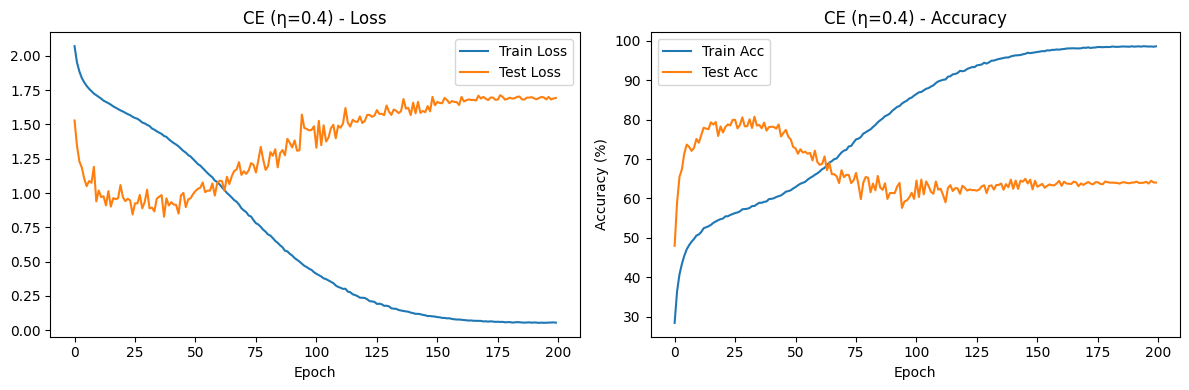

 - MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 34.66% | Test Loss: 0.6643


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 39.91% | Test Loss: 0.6048


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 37.60% | Test Loss: 0.6243


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 38.45% | Test Loss: 0.6166


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 39.61% | Test Loss: 0.6058


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 42.21% | Test Loss: 0.5789


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 43.04% | Test Loss: 0.5723


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 44.38% | Test Loss: 0.5595


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 43.49% | Test Loss: 0.5663


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 45.73% | Test Loss: 0.5443


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 46.36% | Test Loss: 0.5384


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 46.18% | Test Loss: 0.5390


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 46.72% | Test Loss: 0.5339


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 47.43% | Test Loss: 0.5264


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 47.90% | Test Loss: 0.5230


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 47.35% | Test Loss: 0.5270


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 46.56% | Test Loss: 0.5357


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 47.52% | Test Loss: 0.5262


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 48.77% | Test Loss: 0.5142


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 53.92% | Test Loss: 0.4641


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 55.73% | Test Loss: 0.4466


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.47it/s]


Test Acc: 54.99% | Test Loss: 0.4540


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 56.87% | Test Loss: 0.4331


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 56.84% | Test Loss: 0.4340


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 56.99% | Test Loss: 0.4324


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 58.34% | Test Loss: 0.4186


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 57.79% | Test Loss: 0.4236


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 58.63% | Test Loss: 0.4164


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 57.69% | Test Loss: 0.4255


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 57.43% | Test Loss: 0.4285


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 57.76% | Test Loss: 0.4233


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 59.99% | Test Loss: 0.4021


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 58.55% | Test Loss: 0.4154


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 58.68% | Test Loss: 0.4143


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 59.75% | Test Loss: 0.4040


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 56.13% | Test Loss: 0.4402


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 59.13% | Test Loss: 0.4093


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 57.81% | Test Loss: 0.4240


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 59.74% | Test Loss: 0.4045


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 60.06% | Test Loss: 0.4018


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 59.54% | Test Loss: 0.4054


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 60.08% | Test Loss: 0.4009


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 59.79% | Test Loss: 0.4035


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 60.51% | Test Loss: 0.3972


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 58.61% | Test Loss: 0.4154


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 60.51% | Test Loss: 0.3982


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 61.00% | Test Loss: 0.3927


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 59.72% | Test Loss: 0.4054


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 59.65% | Test Loss: 0.4060


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.30it/s]


Test Acc: 60.69% | Test Loss: 0.3954


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 67.41% | Test Loss: 0.3294


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 67.07% | Test Loss: 0.3325


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 68.07% | Test Loss: 0.3226


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.21it/s]


Test Acc: 68.25% | Test Loss: 0.3201


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 68.69% | Test Loss: 0.3162


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 68.75% | Test Loss: 0.3141


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 67.64% | Test Loss: 0.3256


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 67.79% | Test Loss: 0.3239


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 67.97% | Test Loss: 0.3217


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 68.59% | Test Loss: 0.3148


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 68.93% | Test Loss: 0.3103


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 68.94% | Test Loss: 0.3108


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 70.08% | Test Loss: 0.3012


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 69.78% | Test Loss: 0.3039


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 69.98% | Test Loss: 0.3009


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 69.51% | Test Loss: 0.3064


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 69.37% | Test Loss: 0.3060


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 69.60% | Test Loss: 0.3055


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 69.44% | Test Loss: 0.3063


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 69.47% | Test Loss: 0.3062


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 69.52% | Test Loss: 0.3054


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 69.66% | Test Loss: 0.3042


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 69.64% | Test Loss: 0.3051


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 69.89% | Test Loss: 0.3018


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 70.25% | Test Loss: 0.2986


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 70.22% | Test Loss: 0.2990


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 70.50% | Test Loss: 0.2960


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 70.01% | Test Loss: 0.3008


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 70.92% | Test Loss: 0.2924


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 69.51% | Test Loss: 0.3057


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 70.58% | Test Loss: 0.2948


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.14it/s]


Test Acc: 71.10% | Test Loss: 0.2907


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 70.48% | Test Loss: 0.2972


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 71.13% | Test Loss: 0.2911


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 70.66% | Test Loss: 0.2953


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 70.46% | Test Loss: 0.2960


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 73.34% | Test Loss: 0.2703


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 74.70% | Test Loss: 0.2562


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 74.49% | Test Loss: 0.2571


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 75.13% | Test Loss: 0.2509


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 75.08% | Test Loss: 0.2527


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 75.30% | Test Loss: 0.2496


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 76.10% | Test Loss: 0.2424


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 75.26% | Test Loss: 0.2495


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 75.60% | Test Loss: 0.2476


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 75.65% | Test Loss: 0.2460


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 76.11% | Test Loss: 0.2413


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 76.20% | Test Loss: 0.2414


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 76.49% | Test Loss: 0.2383


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 76.62% | Test Loss: 0.2361


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 76.68% | Test Loss: 0.2360


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 76.93% | Test Loss: 0.2339


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 76.28% | Test Loss: 0.2413


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 76.93% | Test Loss: 0.2335


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 77.05% | Test Loss: 0.2328


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 76.77% | Test Loss: 0.2354


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 76.66% | Test Loss: 0.2352


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 77.31% | Test Loss: 0.2299


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 77.22% | Test Loss: 0.2298


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 77.46% | Test Loss: 0.2289


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 77.24% | Test Loss: 0.2298


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 77.25% | Test Loss: 0.2295


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 76.63% | Test Loss: 0.2354


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 77.91% | Test Loss: 0.2237


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 77.59% | Test Loss: 0.2270


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 77.27% | Test Loss: 0.2310


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 77.69% | Test Loss: 0.2258


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 77.79% | Test Loss: 0.2237


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 78.36% | Test Loss: 0.2195


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 77.82% | Test Loss: 0.2232


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 78.07% | Test Loss: 0.2212


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 77.84% | Test Loss: 0.2252


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 78.02% | Test Loss: 0.2220


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 78.46% | Test Loss: 0.2179


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 78.37% | Test Loss: 0.2189


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 78.18% | Test Loss: 0.2221


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 78.29% | Test Loss: 0.2202


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 78.20% | Test Loss: 0.2207


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 78.37% | Test Loss: 0.2187


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 77.94% | Test Loss: 0.2231


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 77.89% | Test Loss: 0.2246


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 78.75% | Test Loss: 0.2163


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 78.24% | Test Loss: 0.2194


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 78.59% | Test Loss: 0.2166


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 78.50% | Test Loss: 0.2175


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 78.63% | Test Loss: 0.2174


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 78.88% | Test Loss: 0.2152


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 78.11% | Test Loss: 0.2211


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 78.64% | Test Loss: 0.2168


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 78.51% | Test Loss: 0.2170


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 78.48% | Test Loss: 0.2172


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 78.61% | Test Loss: 0.2158


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.13it/s]


Test Acc: 78.53% | Test Loss: 0.2192


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 78.74% | Test Loss: 0.2151


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 78.56% | Test Loss: 0.2168


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 78.36% | Test Loss: 0.2193


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.28it/s]


Test Acc: 78.71% | Test Loss: 0.2165


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.94it/s]


Test Acc: 78.48% | Test Loss: 0.2171


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.56it/s]


Test Acc: 78.49% | Test Loss: 0.2174


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.42it/s]


Test Acc: 78.85% | Test Loss: 0.2146


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 78.57% | Test Loss: 0.2176


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 78.81% | Test Loss: 0.2155


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.81it/s]


Test Acc: 78.86% | Test Loss: 0.2152


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 78.55% | Test Loss: 0.2171


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 78.53% | Test Loss: 0.2168


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 78.61% | Test Loss: 0.2171


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 78.63% | Test Loss: 0.2163


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 79.01% | Test Loss: 0.2138


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 78.74% | Test Loss: 0.2158


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 78.83% | Test Loss: 0.2151


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 78.67% | Test Loss: 0.2155


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 78.74% | Test Loss: 0.2156


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 78.57% | Test Loss: 0.2168


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 78.69% | Test Loss: 0.2159


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.49it/s]


Test Acc: 78.70% | Test Loss: 0.2155


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 78.58% | Test Loss: 0.2170


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 78.54% | Test Loss: 0.2166


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 78.70% | Test Loss: 0.2157


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 78.54% | Test Loss: 0.2168


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 78.69% | Test Loss: 0.2162


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 78.72% | Test Loss: 0.2155


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.52it/s]


Test Acc: 78.57% | Test Loss: 0.2163


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 78.71% | Test Loss: 0.2156


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.66it/s]


Test Acc: 78.65% | Test Loss: 0.2154


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 78.76% | Test Loss: 0.2159


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 78.71% | Test Loss: 0.2167


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 78.71% | Test Loss: 0.2162


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 78.59% | Test Loss: 0.2165


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 78.68% | Test Loss: 0.2163


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 78.65% | Test Loss: 0.2163


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 78.69% | Test Loss: 0.2161


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 78.64% | Test Loss: 0.2163


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 78.70% | Test Loss: 0.2162


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 78.77% | Test Loss: 0.2159


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 78.77% | Test Loss: 0.2158


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 78.73% | Test Loss: 0.2165


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.95it/s]


Test Acc: 78.75% | Test Loss: 0.2164


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 78.64% | Test Loss: 0.2161


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 78.65% | Test Loss: 0.2162


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 78.81% | Test Loss: 0.2162


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 78.68% | Test Loss: 0.2163


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.39it/s]


Test Acc: 78.77% | Test Loss: 0.2161


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 78.78% | Test Loss: 0.2159


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.82it/s]


Test Acc: 78.75% | Test Loss: 0.2162


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 78.73% | Test Loss: 0.2163


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 78.82% | Test Loss: 0.2158


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 78.83% | Test Loss: 0.2164


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 78.72% | Test Loss: 0.2160


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 78.77% | Test Loss: 0.2160


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.84it/s]


Test Acc: 78.77% | Test Loss: 0.2158


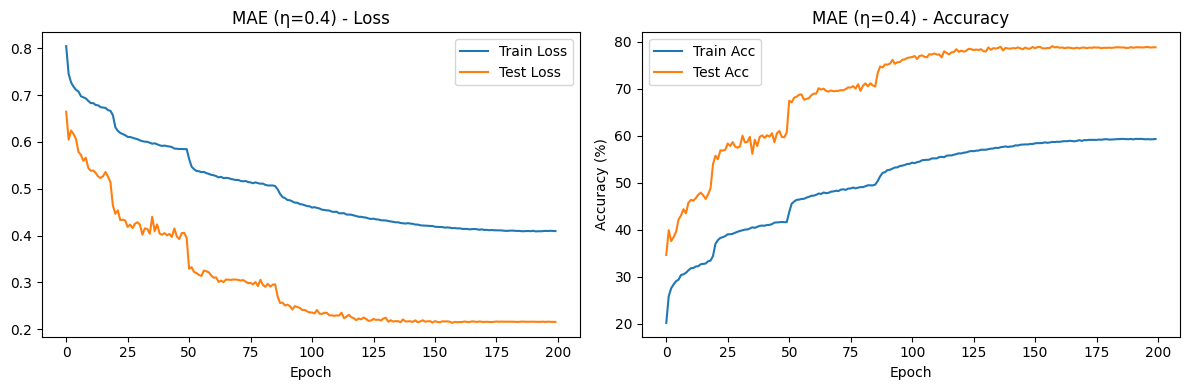

 - RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.67it/s]


Test Acc: 17.34% | Test Loss: 7.6108


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.84it/s]


Test Acc: 20.99% | Test Loss: 7.2675


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.86it/s]


Test Acc: 20.28% | Test Loss: 7.3360


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 24.76% | Test Loss: 6.9105


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 26.70% | Test Loss: 6.7570


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 25.26% | Test Loss: 6.8740


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 25.39% | Test Loss: 6.8607


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 22.58% | Test Loss: 7.1245


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 29.91% | Test Loss: 6.4472


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 23.45% | Test Loss: 7.0279


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 25.92% | Test Loss: 6.8190


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 30.19% | Test Loss: 6.4156


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 28.88% | Test Loss: 6.5485


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 27.83% | Test Loss: 6.6434


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.41it/s]


Test Acc: 29.85% | Test Loss: 6.4671


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 29.24% | Test Loss: 6.5141


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 30.66% | Test Loss: 6.3852


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 32.14% | Test Loss: 6.2372


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 30.52% | Test Loss: 6.3932


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 29.09% | Test Loss: 6.5352


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 28.85% | Test Loss: 6.5444


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 29.51% | Test Loss: 6.4918


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.82it/s]


Test Acc: 29.73% | Test Loss: 6.4701


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 29.56% | Test Loss: 6.4722


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.39it/s]


Test Acc: 29.65% | Test Loss: 6.4728


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 30.99% | Test Loss: 6.3695


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.80it/s]


Test Acc: 29.36% | Test Loss: 6.5103


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.97it/s]


Test Acc: 30.22% | Test Loss: 6.4116


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.66it/s]


Test Acc: 31.37% | Test Loss: 6.3267


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.23it/s]


Test Acc: 31.16% | Test Loss: 6.3380


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.03it/s]


Test Acc: 31.24% | Test Loss: 6.3185


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 31.66% | Test Loss: 6.2751


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 29.54% | Test Loss: 6.4702


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 30.74% | Test Loss: 6.3620


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 32.64% | Test Loss: 6.1952


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 32.25% | Test Loss: 6.2230


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 30.57% | Test Loss: 6.3900


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.64it/s]


Test Acc: 29.90% | Test Loss: 6.4484


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 33.28% | Test Loss: 6.1334


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 31.33% | Test Loss: 6.3181


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 30.23% | Test Loss: 6.4121


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 32.44% | Test Loss: 6.2192


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 30.06% | Test Loss: 6.4285


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.81it/s]


Test Acc: 32.29% | Test Loss: 6.2297


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 33.31% | Test Loss: 6.1310


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 32.13% | Test Loss: 6.2401


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 31.54% | Test Loss: 6.2975


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.00it/s]


Test Acc: 31.61% | Test Loss: 6.2921


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 32.29% | Test Loss: 6.2246


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.98it/s]


Test Acc: 32.88% | Test Loss: 6.1831


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.95it/s]


Test Acc: 32.97% | Test Loss: 6.1822


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.35it/s]


Test Acc: 32.57% | Test Loss: 6.2109


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.71it/s]


Test Acc: 34.57% | Test Loss: 6.0353


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.70it/s]


Test Acc: 33.16% | Test Loss: 6.1502


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.20it/s]


Test Acc: 31.81% | Test Loss: 6.2661


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 30.50% | Test Loss: 6.3942


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.11it/s]


Test Acc: 32.27% | Test Loss: 6.2274


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 31.81% | Test Loss: 6.2565


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 31.53% | Test Loss: 6.2922


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 31.48% | Test Loss: 6.2997


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 30.93% | Test Loss: 6.3374


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 29.35% | Test Loss: 6.4869


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.58it/s]


Test Acc: 31.56% | Test Loss: 6.2963


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 33.91% | Test Loss: 6.0701


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 34.80% | Test Loss: 5.9968


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 32.31% | Test Loss: 6.2155


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 33.32% | Test Loss: 6.1419


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 32.08% | Test Loss: 6.2369


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 34.82% | Test Loss: 5.9930


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 32.92% | Test Loss: 6.1799


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 33.13% | Test Loss: 6.1474


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 33.19% | Test Loss: 6.1408


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 33.76% | Test Loss: 6.0976


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 34.62% | Test Loss: 6.0125


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 34.98% | Test Loss: 5.9734


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 34.17% | Test Loss: 6.0403


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 31.12% | Test Loss: 6.3329


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 29.44% | Test Loss: 6.4890


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 33.21% | Test Loss: 6.1470


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 34.28% | Test Loss: 6.0357


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 33.55% | Test Loss: 6.1030


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 34.58% | Test Loss: 6.0113


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 34.61% | Test Loss: 6.0152


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 32.91% | Test Loss: 6.1559


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 32.71% | Test Loss: 6.1733


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 33.30% | Test Loss: 6.1195


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 35.25% | Test Loss: 5.9465


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 34.08% | Test Loss: 6.0596


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 33.01% | Test Loss: 6.1587


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 33.04% | Test Loss: 6.1626


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 32.25% | Test Loss: 6.2285


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 35.34% | Test Loss: 5.9480


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 32.94% | Test Loss: 6.1670


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 33.29% | Test Loss: 6.1257


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 36.24% | Test Loss: 5.8592


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 35.50% | Test Loss: 5.9262


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 35.48% | Test Loss: 5.9356


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 35.38% | Test Loss: 5.9378


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 36.87% | Test Loss: 5.7942


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 36.71% | Test Loss: 5.8293


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 36.09% | Test Loss: 5.8648


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 35.48% | Test Loss: 5.9406


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 36.61% | Test Loss: 5.8248


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 36.69% | Test Loss: 5.8226


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 36.58% | Test Loss: 5.8235


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 35.45% | Test Loss: 5.9363


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 37.10% | Test Loss: 5.7866


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 36.14% | Test Loss: 5.8670


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 35.11% | Test Loss: 5.9612


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 35.99% | Test Loss: 5.8883


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 35.89% | Test Loss: 5.8995


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 35.84% | Test Loss: 5.9022


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 36.70% | Test Loss: 5.8236


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 36.19% | Test Loss: 5.8700


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 36.43% | Test Loss: 5.8499


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 36.43% | Test Loss: 5.8470


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 36.03% | Test Loss: 5.8839


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 36.57% | Test Loss: 5.8277


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 37.48% | Test Loss: 5.7534


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 37.16% | Test Loss: 5.7804


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 37.13% | Test Loss: 5.7843


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 37.25% | Test Loss: 5.7723


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 37.27% | Test Loss: 5.7723


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 37.26% | Test Loss: 5.7723


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 36.15% | Test Loss: 5.8738


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 37.54% | Test Loss: 5.7460


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 37.43% | Test Loss: 5.7563


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 36.92% | Test Loss: 5.8022


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 37.09% | Test Loss: 5.7869


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 37.14% | Test Loss: 5.7819


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 37.58% | Test Loss: 5.7439


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 37.61% | Test Loss: 5.7405


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 37.15% | Test Loss: 5.7827


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 37.45% | Test Loss: 5.7533


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 37.46% | Test Loss: 5.7532


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 38.01% | Test Loss: 5.7018


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 38.58% | Test Loss: 5.6513


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 38.11% | Test Loss: 5.6892


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 38.57% | Test Loss: 5.6543


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 38.29% | Test Loss: 5.6761


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 38.06% | Test Loss: 5.6982


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 38.44% | Test Loss: 5.6676


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 37.66% | Test Loss: 5.7368


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 38.33% | Test Loss: 5.6746


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 38.53% | Test Loss: 5.6571


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 38.22% | Test Loss: 5.6766


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 38.57% | Test Loss: 5.6462


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 38.46% | Test Loss: 5.6548


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 38.67% | Test Loss: 5.6419


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 38.70% | Test Loss: 5.6362


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 39.03% | Test Loss: 5.6036


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 39.23% | Test Loss: 5.5867


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 39.00% | Test Loss: 5.6126


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 39.01% | Test Loss: 5.6111


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 39.11% | Test Loss: 5.6017


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 38.86% | Test Loss: 5.6266


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.17it/s]


Test Acc: 38.51% | Test Loss: 5.6574


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 39.12% | Test Loss: 5.6060


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 39.03% | Test Loss: 5.6068


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 39.17% | Test Loss: 5.5976


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 102.21it/s]


Test Acc: 38.76% | Test Loss: 5.6347


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 39.25% | Test Loss: 5.5895


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.27it/s]


Test Acc: 39.50% | Test Loss: 5.5617


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 102.77it/s]


Test Acc: 39.61% | Test Loss: 5.5556


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 39.56% | Test Loss: 5.5580


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 39.31% | Test Loss: 5.5804


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 39.24% | Test Loss: 5.5850


Epoch 168/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 99.35it/s]


Test Acc: 39.29% | Test Loss: 5.5831


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.57it/s]


Test Acc: 39.50% | Test Loss: 5.5621


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 39.43% | Test Loss: 5.5680


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 39.68% | Test Loss: 5.5544


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 39.47% | Test Loss: 5.5635


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 39.60% | Test Loss: 5.5545


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 39.61% | Test Loss: 5.5523


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 39.59% | Test Loss: 5.5520


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 39.47% | Test Loss: 5.5635


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 39.65% | Test Loss: 5.5475


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.05it/s]


Test Acc: 39.54% | Test Loss: 5.5575


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 39.61% | Test Loss: 5.5573


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 39.53% | Test Loss: 5.5658


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.04it/s]


Test Acc: 39.64% | Test Loss: 5.5485


Epoch 182/200: 100%|██████████████████████████| 391/391 [00:04<00:00, 97.06it/s]


Test Acc: 39.62% | Test Loss: 5.5487


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 39.67% | Test Loss: 5.5440


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 39.71% | Test Loss: 5.5495


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 39.70% | Test Loss: 5.5413


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 39.66% | Test Loss: 5.5500


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.00it/s]


Test Acc: 39.69% | Test Loss: 5.5506


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 39.81% | Test Loss: 5.5353


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 39.76% | Test Loss: 5.5391


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 39.73% | Test Loss: 5.5409


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 39.66% | Test Loss: 5.5529


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 39.63% | Test Loss: 5.5585


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.12it/s]


Test Acc: 39.73% | Test Loss: 5.5400


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 39.76% | Test Loss: 5.5465


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 39.77% | Test Loss: 5.5369


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 39.65% | Test Loss: 5.5491


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.16it/s]


Test Acc: 39.71% | Test Loss: 5.5405


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 39.63% | Test Loss: 5.5505


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.33it/s]


Test Acc: 39.74% | Test Loss: 5.5477


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 39.73% | Test Loss: 5.5410


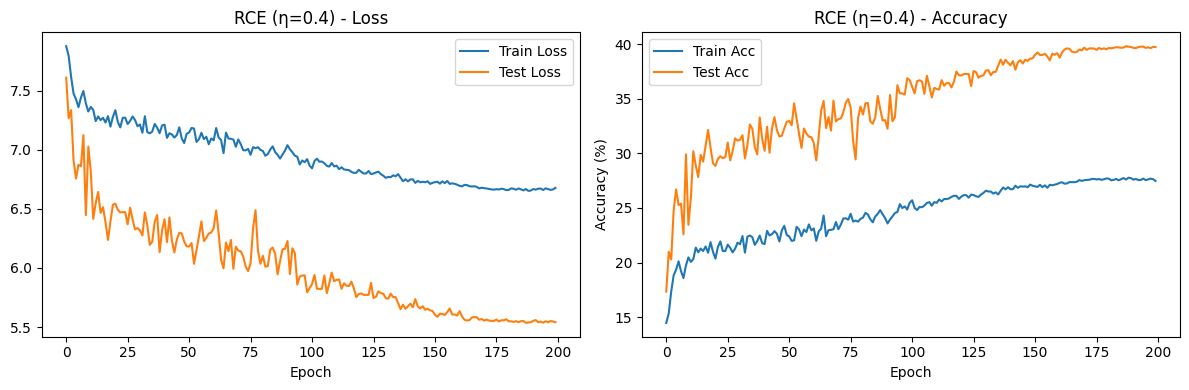


Training normalized Losses...
 - NCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 40.64% | Test Loss: 0.0379


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 41.43% | Test Loss: 0.0286


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 44.48% | Test Loss: 0.0234


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 43.81% | Test Loss: 0.0225


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 45.07% | Test Loss: 0.0201


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 48.36% | Test Loss: 0.0189


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 48.67% | Test Loss: 0.0185


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 46.32% | Test Loss: 0.0202


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 49.88% | Test Loss: 0.0163


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 53.21% | Test Loss: 0.0149


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 53.14% | Test Loss: 0.0149


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 54.60% | Test Loss: 0.0142


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 53.52% | Test Loss: 0.0151


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 53.39% | Test Loss: 0.0157


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 55.16% | Test Loss: 0.0136


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 55.66% | Test Loss: 0.0136


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 57.75% | Test Loss: 0.0123


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 56.54% | Test Loss: 0.0127


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 57.02% | Test Loss: 0.0120


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 58.38% | Test Loss: 0.0120


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.06it/s]


Test Acc: 58.97% | Test Loss: 0.0112


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 59.80% | Test Loss: 0.0110


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.15it/s]


Test Acc: 57.55% | Test Loss: 0.0122


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 60.42% | Test Loss: 0.0113


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 59.45% | Test Loss: 0.0116


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 60.86% | Test Loss: 0.0105


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 61.70% | Test Loss: 0.0104


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 62.58% | Test Loss: 0.0099


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 61.76% | Test Loss: 0.0099


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 62.97% | Test Loss: 0.0092


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 61.52% | Test Loss: 0.0104


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 57.37% | Test Loss: 0.0148


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 62.86% | Test Loss: 0.0089


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 62.72% | Test Loss: 0.0096


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 63.50% | Test Loss: 0.0093


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 63.11% | Test Loss: 0.0091


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 61.23% | Test Loss: 0.0095


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 63.82% | Test Loss: 0.0093


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 64.23% | Test Loss: 0.0084


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 62.87% | Test Loss: 0.0093


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 63.09% | Test Loss: 0.0085


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 64.69% | Test Loss: 0.0079


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 64.68% | Test Loss: 0.0086


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 63.28% | Test Loss: 0.0096


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 63.06% | Test Loss: 0.0090


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 63.19% | Test Loss: 0.0086


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 65.17% | Test Loss: 0.0083


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 64.09% | Test Loss: 0.0090


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 63.81% | Test Loss: 0.0090


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 65.02% | Test Loss: 0.0085


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 64.47% | Test Loss: 0.0083


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 66.17% | Test Loss: 0.0081


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 63.28% | Test Loss: 0.0111


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 64.79% | Test Loss: 0.0079


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 64.66% | Test Loss: 0.0084


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 66.19% | Test Loss: 0.0083


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 63.66% | Test Loss: 0.0086


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 65.93% | Test Loss: 0.0079


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 63.27% | Test Loss: 0.0097


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 66.82% | Test Loss: 0.0075


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 66.35% | Test Loss: 0.0079


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 64.66% | Test Loss: 0.0093


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 65.29% | Test Loss: 0.0081


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 64.86% | Test Loss: 0.0076


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 65.43% | Test Loss: 0.0080


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 65.41% | Test Loss: 0.0083


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 63.37% | Test Loss: 0.0108


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 66.00% | Test Loss: 0.0081


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 66.69% | Test Loss: 0.0079


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 65.60% | Test Loss: 0.0085


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 64.53% | Test Loss: 0.0096


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 66.34% | Test Loss: 0.0088


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 66.56% | Test Loss: 0.0091


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 65.20% | Test Loss: 0.0072


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 64.53% | Test Loss: 0.0086


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 64.86% | Test Loss: 0.0075


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 65.11% | Test Loss: 0.0076


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 66.27% | Test Loss: 0.0082


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 67.15% | Test Loss: 0.0077


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 65.22% | Test Loss: 0.0094


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 64.53% | Test Loss: 0.0096


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 61.90% | Test Loss: 0.0108


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 63.46% | Test Loss: 0.0110


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 65.95% | Test Loss: 0.0070


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 64.28% | Test Loss: 0.0086


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 65.52% | Test Loss: 0.0080


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 62.79% | Test Loss: 0.0134


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 65.17% | Test Loss: 0.0085


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 63.81% | Test Loss: 0.0077


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 64.45% | Test Loss: 0.0097


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 64.45% | Test Loss: 0.0092


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 65.76% | Test Loss: 0.0083


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 65.71% | Test Loss: 0.0080


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 65.19% | Test Loss: 0.0085


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 64.65% | Test Loss: 0.0085


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 64.16% | Test Loss: 0.0083


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 63.32% | Test Loss: 0.0123


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 65.42% | Test Loss: 0.0085


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 64.05% | Test Loss: 0.0083


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 64.56% | Test Loss: 0.0116


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 63.38% | Test Loss: 0.0109


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 65.30% | Test Loss: 0.0083


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 63.96% | Test Loss: 0.0110


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 66.38% | Test Loss: 0.0088


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 66.08% | Test Loss: 0.0088


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 65.49% | Test Loss: 0.0092


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 65.57% | Test Loss: 0.0076


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 66.56% | Test Loss: 0.0095


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 64.66% | Test Loss: 0.0091


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 65.91% | Test Loss: 0.0080


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 60.12% | Test Loss: 0.0113


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 66.02% | Test Loss: 0.0098


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 64.44% | Test Loss: 0.0107


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 62.43% | Test Loss: 0.0150


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 64.58% | Test Loss: 0.0093


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 63.03% | Test Loss: 0.0121


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 65.26% | Test Loss: 0.0089


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 65.49% | Test Loss: 0.0087


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 64.93% | Test Loss: 0.0102


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 65.98% | Test Loss: 0.0089


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 64.86% | Test Loss: 0.0091


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 65.76% | Test Loss: 0.0102


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 64.80% | Test Loss: 0.0093


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 64.61% | Test Loss: 0.0085


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 64.40% | Test Loss: 0.0077


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 64.72% | Test Loss: 0.0086


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 63.45% | Test Loss: 0.0104


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 63.79% | Test Loss: 0.0100


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 64.84% | Test Loss: 0.0106


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 65.03% | Test Loss: 0.0108


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 65.29% | Test Loss: 0.0088


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 63.34% | Test Loss: 0.0108


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 65.65% | Test Loss: 0.0109


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 65.80% | Test Loss: 0.0089


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 64.47% | Test Loss: 0.0112


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 65.35% | Test Loss: 0.0093


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 63.62% | Test Loss: 0.0098


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.26it/s]


Test Acc: 63.70% | Test Loss: 0.0111


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 64.37% | Test Loss: 0.0093


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 65.53% | Test Loss: 0.0097


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 64.44% | Test Loss: 0.0099


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 64.75% | Test Loss: 0.0115


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 65.64% | Test Loss: 0.0102


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 65.51% | Test Loss: 0.0096


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 65.06% | Test Loss: 0.0095


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 64.53% | Test Loss: 0.0109


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 63.58% | Test Loss: 0.0112


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 65.84% | Test Loss: 0.0102


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 65.03% | Test Loss: 0.0098


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 63.36% | Test Loss: 0.0117


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 65.22% | Test Loss: 0.0095


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 65.99% | Test Loss: 0.0089


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 65.70% | Test Loss: 0.0090


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 64.74% | Test Loss: 0.0095


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 65.02% | Test Loss: 0.0107


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 65.49% | Test Loss: 0.0097


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 62.85% | Test Loss: 0.0113


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 65.04% | Test Loss: 0.0103


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 64.11% | Test Loss: 0.0115


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 65.81% | Test Loss: 0.0090


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 65.01% | Test Loss: 0.0096


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 65.18% | Test Loss: 0.0095


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 64.94% | Test Loss: 0.0115


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 65.49% | Test Loss: 0.0113


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 64.61% | Test Loss: 0.0102


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 65.91% | Test Loss: 0.0087


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 65.70% | Test Loss: 0.0089


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 65.44% | Test Loss: 0.0092


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 65.70% | Test Loss: 0.0115


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 64.78% | Test Loss: 0.0088


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 65.54% | Test Loss: 0.0095


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 65.51% | Test Loss: 0.0101


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.60it/s]


Test Acc: 65.62% | Test Loss: 0.0096


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 65.36% | Test Loss: 0.0098


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 66.22% | Test Loss: 0.0093


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 65.89% | Test Loss: 0.0098


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 65.22% | Test Loss: 0.0094


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 64.61% | Test Loss: 0.0096


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 65.62% | Test Loss: 0.0099


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 65.12% | Test Loss: 0.0095


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 65.41% | Test Loss: 0.0100


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 65.32% | Test Loss: 0.0095


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 65.24% | Test Loss: 0.0097


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 65.53% | Test Loss: 0.0099


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 65.24% | Test Loss: 0.0095


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 65.48% | Test Loss: 0.0097


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 65.44% | Test Loss: 0.0099


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 65.28% | Test Loss: 0.0100


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 65.45% | Test Loss: 0.0106


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 65.58% | Test Loss: 0.0096


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 65.57% | Test Loss: 0.0098


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 65.31% | Test Loss: 0.0096


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 65.50% | Test Loss: 0.0099


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 65.57% | Test Loss: 0.0099


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 65.59% | Test Loss: 0.0097


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 65.59% | Test Loss: 0.0098


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 65.59% | Test Loss: 0.0099


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 65.58% | Test Loss: 0.0099


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 65.35% | Test Loss: 0.0099


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 65.63% | Test Loss: 0.0098


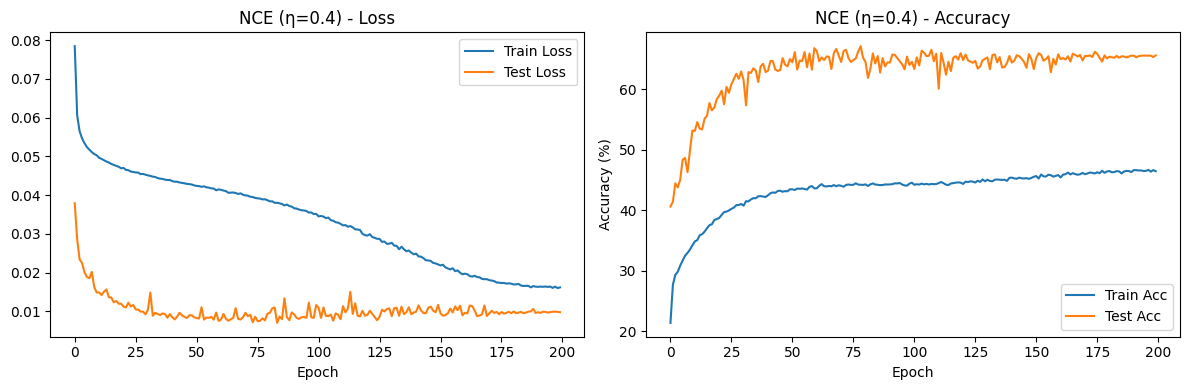

 - NRCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 17.58% | Test Loss: 17.1211


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 17.14% | Test Loss: 17.2111


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.04it/s]


Test Acc: 14.51% | Test Loss: 17.7518


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 16.52% | Test Loss: 17.3349


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 15.96% | Test Loss: 17.4495


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 110.37it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.34it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.17it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.32it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.23it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.10it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.46it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.05it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.31it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.43it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.27it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 10.00% | Test Loss: 18.6309


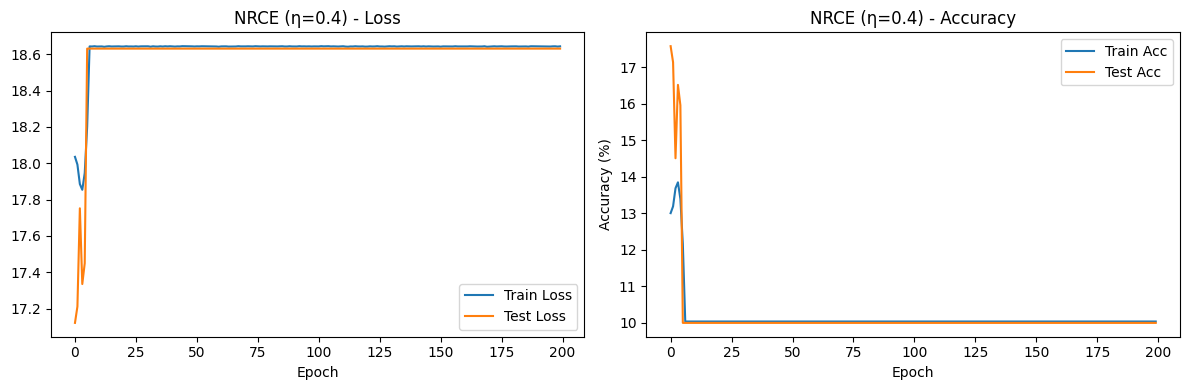

 - NFL


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 36.67% | Test Loss: 0.2514


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 41.95% | Test Loss: 0.1780


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 36.84% | Test Loss: 0.2223


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 45.02% | Test Loss: 0.1513


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 47.79% | Test Loss: 0.1271


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 51.68% | Test Loss: 0.0996


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 46.16% | Test Loss: 0.1065


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 54.16% | Test Loss: 0.0952


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 48.08% | Test Loss: 0.0978


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 50.71% | Test Loss: 0.0952


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 57.13% | Test Loss: 0.0740


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 49.08% | Test Loss: 0.1339


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 53.96% | Test Loss: 0.0751


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 55.53% | Test Loss: 0.0658


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 57.42% | Test Loss: 0.0658


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 59.07% | Test Loss: 0.0687


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 54.80% | Test Loss: 0.0742


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 56.58% | Test Loss: 0.0669


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 56.94% | Test Loss: 0.0838


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 59.07% | Test Loss: 0.0610


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 56.07% | Test Loss: 0.0614


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 58.13% | Test Loss: 0.0793


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 56.46% | Test Loss: 0.0716


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 56.54% | Test Loss: 0.0578


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 58.95% | Test Loss: 0.0588


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 55.30% | Test Loss: 0.0886


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 56.25% | Test Loss: 0.0565


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 60.12% | Test Loss: 0.0622


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 60.42% | Test Loss: 0.0543


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 54.68% | Test Loss: 0.0844


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 59.69% | Test Loss: 0.0548


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 59.84% | Test Loss: 0.0578


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 60.59% | Test Loss: 0.0588


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 58.69% | Test Loss: 0.0660


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 52.64% | Test Loss: 0.0619


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 59.91% | Test Loss: 0.0537


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 56.19% | Test Loss: 0.0590


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 58.71% | Test Loss: 0.0604


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 57.17% | Test Loss: 0.0667


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 57.54% | Test Loss: 0.0617


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 58.71% | Test Loss: 0.0573


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 59.96% | Test Loss: 0.0515


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 58.03% | Test Loss: 0.0748


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 60.29% | Test Loss: 0.0478


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 60.61% | Test Loss: 0.0536


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 62.37% | Test Loss: 0.0500


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 55.72% | Test Loss: 0.0605


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 62.28% | Test Loss: 0.0561


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 60.62% | Test Loss: 0.0667


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 59.62% | Test Loss: 0.0531


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 59.77% | Test Loss: 0.0490


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 56.22% | Test Loss: 0.0779


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 60.34% | Test Loss: 0.0639


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 62.66% | Test Loss: 0.0565


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 61.16% | Test Loss: 0.0514


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 59.13% | Test Loss: 0.0545


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 58.79% | Test Loss: 0.0596


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 59.09% | Test Loss: 0.0469


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 57.16% | Test Loss: 0.0502


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 61.52% | Test Loss: 0.0600


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 62.27% | Test Loss: 0.0539


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 62.06% | Test Loss: 0.0551


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 62.28% | Test Loss: 0.0516


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 62.11% | Test Loss: 0.0574


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 61.94% | Test Loss: 0.0571


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 59.68% | Test Loss: 0.0522


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 64.24% | Test Loss: 0.0541


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 62.30% | Test Loss: 0.0452


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 63.96% | Test Loss: 0.0507


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 63.16% | Test Loss: 0.0503


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 62.52% | Test Loss: 0.0493


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 64.10% | Test Loss: 0.0488


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 63.63% | Test Loss: 0.0578


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 63.22% | Test Loss: 0.0590


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 62.53% | Test Loss: 0.0573


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 64.06% | Test Loss: 0.0557


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 62.76% | Test Loss: 0.0511


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 63.60% | Test Loss: 0.0492


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 62.58% | Test Loss: 0.0620


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 65.33% | Test Loss: 0.0469


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 63.66% | Test Loss: 0.0501


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 63.99% | Test Loss: 0.0491


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 63.44% | Test Loss: 0.0544


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 64.21% | Test Loss: 0.0525


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 63.44% | Test Loss: 0.0531


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 63.96% | Test Loss: 0.0558


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 63.88% | Test Loss: 0.0494


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 64.03% | Test Loss: 0.0538


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 62.91% | Test Loss: 0.0515


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 61.32% | Test Loss: 0.0542


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 64.95% | Test Loss: 0.0456


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 62.77% | Test Loss: 0.0562


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 63.60% | Test Loss: 0.0495


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 63.76% | Test Loss: 0.0576


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 64.93% | Test Loss: 0.0449


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 64.04% | Test Loss: 0.0556


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 62.64% | Test Loss: 0.0545


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 64.72% | Test Loss: 0.0544


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 64.08% | Test Loss: 0.0498


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 64.30% | Test Loss: 0.0663


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 66.12% | Test Loss: 0.0515


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 62.36% | Test Loss: 0.0556


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 64.62% | Test Loss: 0.0555


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 63.77% | Test Loss: 0.0584


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 65.76% | Test Loss: 0.0484


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.12it/s]


Test Acc: 63.64% | Test Loss: 0.0537


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 62.37% | Test Loss: 0.0507


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 64.45% | Test Loss: 0.0465


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 64.69% | Test Loss: 0.0437


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.18it/s]


Test Acc: 65.78% | Test Loss: 0.0446


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 63.32% | Test Loss: 0.0595


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 64.85% | Test Loss: 0.0449


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 64.58% | Test Loss: 0.0548


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 64.44% | Test Loss: 0.0511


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 64.86% | Test Loss: 0.0542


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 65.06% | Test Loss: 0.0615


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 63.79% | Test Loss: 0.0514


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 64.66% | Test Loss: 0.0454


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 65.48% | Test Loss: 0.0496


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 64.17% | Test Loss: 0.0584


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 64.22% | Test Loss: 0.0542


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 63.72% | Test Loss: 0.0584


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 66.17% | Test Loss: 0.0489


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 65.80% | Test Loss: 0.0495


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 66.43% | Test Loss: 0.0454


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 65.77% | Test Loss: 0.0493


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 64.60% | Test Loss: 0.0495


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 65.19% | Test Loss: 0.0529


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 65.29% | Test Loss: 0.0501


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 65.84% | Test Loss: 0.0452


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 63.53% | Test Loss: 0.0487


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 66.07% | Test Loss: 0.0437


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 65.91% | Test Loss: 0.0480


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 65.81% | Test Loss: 0.0470


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 65.50% | Test Loss: 0.0564


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 66.30% | Test Loss: 0.0440


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 65.10% | Test Loss: 0.0431


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 66.14% | Test Loss: 0.0441


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 65.70% | Test Loss: 0.0458


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 66.17% | Test Loss: 0.0419


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.95it/s]


Test Acc: 65.36% | Test Loss: 0.0423


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 65.73% | Test Loss: 0.0400


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 66.18% | Test Loss: 0.0486


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 65.66% | Test Loss: 0.0415


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 66.93% | Test Loss: 0.0493


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 66.02% | Test Loss: 0.0471


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 66.26% | Test Loss: 0.0476


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 66.20% | Test Loss: 0.0459


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 65.95% | Test Loss: 0.0483


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 66.25% | Test Loss: 0.0476


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 65.64% | Test Loss: 0.0480


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 66.20% | Test Loss: 0.0469


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 66.49% | Test Loss: 0.0489


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 65.63% | Test Loss: 0.0488


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 66.14% | Test Loss: 0.0488


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 66.73% | Test Loss: 0.0464


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 65.85% | Test Loss: 0.0430


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 66.45% | Test Loss: 0.0475


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 66.53% | Test Loss: 0.0440


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 66.43% | Test Loss: 0.0429


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 66.11% | Test Loss: 0.0466


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 66.57% | Test Loss: 0.0430


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 66.15% | Test Loss: 0.0464


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 67.10% | Test Loss: 0.0457


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 66.75% | Test Loss: 0.0440


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 65.84% | Test Loss: 0.0479


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 66.46% | Test Loss: 0.0486


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 66.18% | Test Loss: 0.0456


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 66.68% | Test Loss: 0.0483


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 66.06% | Test Loss: 0.0497


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 66.58% | Test Loss: 0.0473


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 66.88% | Test Loss: 0.0514


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 67.01% | Test Loss: 0.0465


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 66.29% | Test Loss: 0.0469


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 66.63% | Test Loss: 0.0483


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 66.65% | Test Loss: 0.0479


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 66.49% | Test Loss: 0.0471


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 66.29% | Test Loss: 0.0487


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 66.95% | Test Loss: 0.0471


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 66.69% | Test Loss: 0.0489


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 66.86% | Test Loss: 0.0498


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 66.25% | Test Loss: 0.0486


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 66.68% | Test Loss: 0.0493


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 66.40% | Test Loss: 0.0500


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.75it/s]


Test Acc: 66.89% | Test Loss: 0.0499


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 66.41% | Test Loss: 0.0493


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 66.76% | Test Loss: 0.0487


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 66.73% | Test Loss: 0.0485


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 66.36% | Test Loss: 0.0483


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 66.48% | Test Loss: 0.0480


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 66.43% | Test Loss: 0.0485


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 66.46% | Test Loss: 0.0485


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 66.75% | Test Loss: 0.0487


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 66.70% | Test Loss: 0.0486


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 66.57% | Test Loss: 0.0481


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 66.61% | Test Loss: 0.0475


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 66.55% | Test Loss: 0.0485


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 66.57% | Test Loss: 0.0493


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 66.61% | Test Loss: 0.0486


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 66.54% | Test Loss: 0.0478


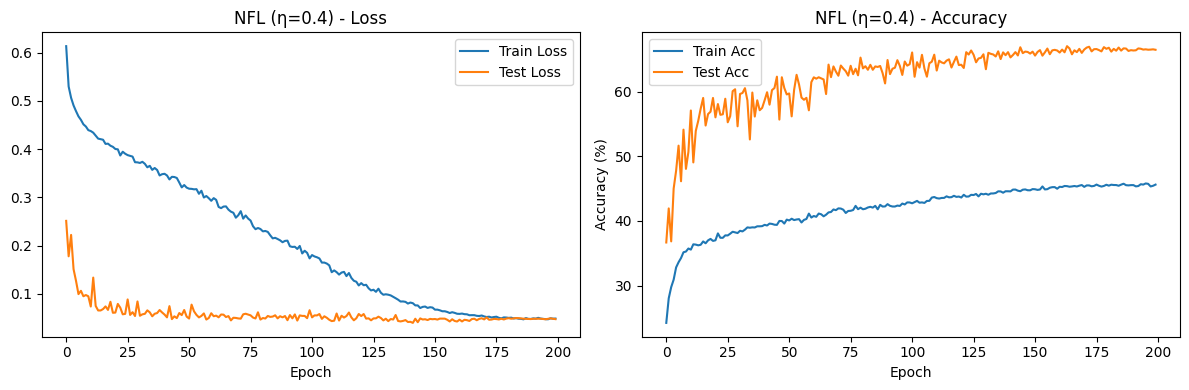


Training apl Losses...
 - NCE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 16.09% | Test Loss: 7.8033


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 22.43% | Test Loss: 7.2002


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 24.53% | Test Loss: 6.9954


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 26.43% | Test Loss: 6.8137


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 28.71% | Test Loss: 6.6114


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 27.14% | Test Loss: 6.7818


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 26.07% | Test Loss: 6.8792


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 24.67% | Test Loss: 6.9984


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 25.09% | Test Loss: 6.9788


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 25.57% | Test Loss: 6.9478


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 27.74% | Test Loss: 6.7170


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 29.62% | Test Loss: 6.5607


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 29.23% | Test Loss: 6.5909


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 30.02% | Test Loss: 6.5184


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 31.83% | Test Loss: 6.3348


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 29.94% | Test Loss: 6.5137


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 30.76% | Test Loss: 6.4407


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 29.45% | Test Loss: 6.5678


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 26.20% | Test Loss: 6.8546


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 22.71% | Test Loss: 7.2011


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 27.74% | Test Loss: 6.7176


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 32.12% | Test Loss: 6.3029


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 26.98% | Test Loss: 6.7902


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 32.28% | Test Loss: 6.2850


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 30.65% | Test Loss: 6.4351


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 31.13% | Test Loss: 6.3894


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 30.81% | Test Loss: 6.4166


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 31.25% | Test Loss: 6.3928


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 33.37% | Test Loss: 6.1948


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 33.37% | Test Loss: 6.1849


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 33.18% | Test Loss: 6.1957


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 32.99% | Test Loss: 6.2169


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 28.17% | Test Loss: 6.6670


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 29.90% | Test Loss: 6.5054


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 32.75% | Test Loss: 6.2482


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 32.94% | Test Loss: 6.2236


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 31.92% | Test Loss: 6.3261


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 33.14% | Test Loss: 6.2090


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 33.02% | Test Loss: 6.2195


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 33.26% | Test Loss: 6.1987


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 33.63% | Test Loss: 6.1682


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 33.05% | Test Loss: 6.2290


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 32.52% | Test Loss: 6.2884


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 29.72% | Test Loss: 6.5345


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 30.80% | Test Loss: 6.4356


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 29.78% | Test Loss: 6.5075


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 32.98% | Test Loss: 6.2364


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 30.91% | Test Loss: 6.4212


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 30.38% | Test Loss: 6.4542


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 33.63% | Test Loss: 6.1664


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 32.70% | Test Loss: 6.2533


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 32.89% | Test Loss: 6.2332


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 33.99% | Test Loss: 6.1360


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 31.59% | Test Loss: 6.3702


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 32.16% | Test Loss: 6.3178


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 34.75% | Test Loss: 6.0765


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 34.04% | Test Loss: 6.1206


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 34.67% | Test Loss: 6.0678


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 35.16% | Test Loss: 6.0155


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 34.93% | Test Loss: 6.0238


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 35.77% | Test Loss: 5.9423


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 35.38% | Test Loss: 5.9831


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 32.76% | Test Loss: 6.2389


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 30.99% | Test Loss: 6.3930


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 32.65% | Test Loss: 6.2363


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 33.45% | Test Loss: 6.1789


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 33.71% | Test Loss: 6.1456


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 32.14% | Test Loss: 6.2964


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 31.99% | Test Loss: 6.3164


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 32.89% | Test Loss: 6.2153


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 34.46% | Test Loss: 6.0772


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 36.79% | Test Loss: 5.8605


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 36.08% | Test Loss: 5.9310


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 34.56% | Test Loss: 6.0651


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 37.04% | Test Loss: 5.8318


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 33.87% | Test Loss: 6.1351


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 36.16% | Test Loss: 5.9101


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 37.79% | Test Loss: 5.7658


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 36.33% | Test Loss: 5.9029


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 37.08% | Test Loss: 5.8303


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 35.63% | Test Loss: 5.9678


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 37.66% | Test Loss: 5.7692


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 38.47% | Test Loss: 5.7121


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 36.70% | Test Loss: 5.8580


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 37.40% | Test Loss: 5.8161


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 37.39% | Test Loss: 5.8082


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 34.35% | Test Loss: 6.0838


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 38.96% | Test Loss: 5.6561


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 40.40% | Test Loss: 5.5375


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 36.66% | Test Loss: 5.8757


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 40.80% | Test Loss: 5.5050


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 38.26% | Test Loss: 5.7271


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 40.51% | Test Loss: 5.4998


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 40.70% | Test Loss: 5.5077


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 41.15% | Test Loss: 5.4539


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 36.25% | Test Loss: 5.9235


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 39.22% | Test Loss: 5.6356


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 39.21% | Test Loss: 5.6201


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 35.96% | Test Loss: 5.9358


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 38.14% | Test Loss: 5.7359


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 40.06% | Test Loss: 5.5619


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 42.63% | Test Loss: 5.3118


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 41.45% | Test Loss: 5.4268


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 37.63% | Test Loss: 5.7934


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 39.87% | Test Loss: 5.5733


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 39.39% | Test Loss: 5.6209


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 37.91% | Test Loss: 5.7671


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 41.94% | Test Loss: 5.3814


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 40.75% | Test Loss: 5.4988


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 42.43% | Test Loss: 5.3302


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 43.20% | Test Loss: 5.2728


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 42.13% | Test Loss: 5.3756


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 41.83% | Test Loss: 5.3905


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 44.45% | Test Loss: 5.1553


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 40.99% | Test Loss: 5.4734


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 43.13% | Test Loss: 5.2796


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 42.92% | Test Loss: 5.3012


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 43.33% | Test Loss: 5.2646


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 44.64% | Test Loss: 5.1385


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 42.69% | Test Loss: 5.3119


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 44.50% | Test Loss: 5.1600


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 44.86% | Test Loss: 5.1292


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 45.81% | Test Loss: 5.0157


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 45.93% | Test Loss: 5.0188


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 46.50% | Test Loss: 4.9589


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 46.06% | Test Loss: 5.0178


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 45.74% | Test Loss: 5.0422


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 46.61% | Test Loss: 4.9599


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 46.87% | Test Loss: 4.9458


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 47.56% | Test Loss: 4.8615


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 46.37% | Test Loss: 4.9720


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 47.72% | Test Loss: 4.8490


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 45.67% | Test Loss: 5.0522


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 46.62% | Test Loss: 4.9624


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 46.71% | Test Loss: 4.9494


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 46.60% | Test Loss: 4.9654


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 48.96% | Test Loss: 4.7462


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 47.33% | Test Loss: 4.8848


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 49.21% | Test Loss: 4.7249


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 48.27% | Test Loss: 4.8044


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 49.31% | Test Loss: 4.7086


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 48.54% | Test Loss: 4.7821


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 48.39% | Test Loss: 4.7992


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 48.48% | Test Loss: 4.7878


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 48.66% | Test Loss: 4.7819


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 50.13% | Test Loss: 4.6407


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 48.54% | Test Loss: 4.7758


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 49.76% | Test Loss: 4.6723


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 49.62% | Test Loss: 4.6737


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 51.21% | Test Loss: 4.5362


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 51.73% | Test Loss: 4.4787


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 51.58% | Test Loss: 4.4931


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 51.83% | Test Loss: 4.4714


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 51.77% | Test Loss: 4.4874


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 51.27% | Test Loss: 4.5415


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 51.63% | Test Loss: 4.4914


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 51.02% | Test Loss: 4.5487


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 51.76% | Test Loss: 4.4842


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 51.99% | Test Loss: 4.4664


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 52.63% | Test Loss: 4.3957


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 52.24% | Test Loss: 4.4301


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 52.46% | Test Loss: 4.4176


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 52.43% | Test Loss: 4.4152


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 52.39% | Test Loss: 4.4164


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 52.81% | Test Loss: 4.3802


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 52.55% | Test Loss: 4.4015


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 52.51% | Test Loss: 4.4066


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 52.92% | Test Loss: 4.3758


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 53.50% | Test Loss: 4.3166


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 52.98% | Test Loss: 4.3656


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 53.16% | Test Loss: 4.3511


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 53.39% | Test Loss: 4.3293


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 53.19% | Test Loss: 4.3427


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 53.31% | Test Loss: 4.3318


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 53.32% | Test Loss: 4.3340


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 53.30% | Test Loss: 4.3350


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 53.57% | Test Loss: 4.3106


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 53.37% | Test Loss: 4.3262


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 53.50% | Test Loss: 4.3162


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 53.74% | Test Loss: 4.2948


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 53.82% | Test Loss: 4.2880


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 54.05% | Test Loss: 4.2688


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 53.83% | Test Loss: 4.2897


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 53.85% | Test Loss: 4.2826


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 53.74% | Test Loss: 4.2918


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 53.94% | Test Loss: 4.2758


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 54.06% | Test Loss: 4.2646


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 54.14% | Test Loss: 4.2591


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 54.04% | Test Loss: 4.2660


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 54.00% | Test Loss: 4.2693


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 54.04% | Test Loss: 4.2632


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 53.95% | Test Loss: 4.2735


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 53.92% | Test Loss: 4.2742


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 53.90% | Test Loss: 4.2834


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 54.06% | Test Loss: 4.2649


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 54.11% | Test Loss: 4.2603


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 53.87% | Test Loss: 4.2781


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 53.98% | Test Loss: 4.2715


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 53.99% | Test Loss: 4.2721


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 53.97% | Test Loss: 4.2749


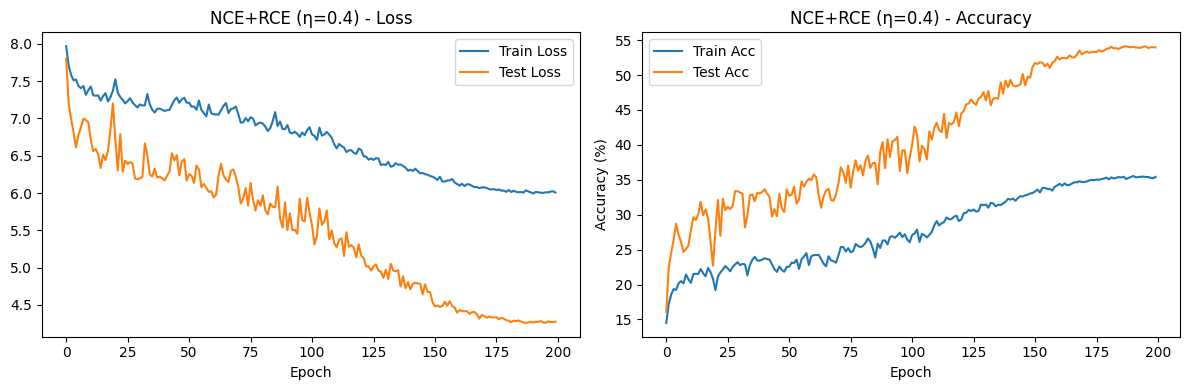

 - NCE+MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 43.84% | Test Loss: 0.6101


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 54.88% | Test Loss: 0.4870


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 57.35% | Test Loss: 0.4549


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 60.79% | Test Loss: 0.4174


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 58.59% | Test Loss: 0.4398


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 64.59% | Test Loss: 0.3761


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 68.64% | Test Loss: 0.3330


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 69.47% | Test Loss: 0.3259


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 71.48% | Test Loss: 0.3019


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 71.10% | Test Loss: 0.3046


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 72.36% | Test Loss: 0.2932


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 72.81% | Test Loss: 0.2857


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 71.87% | Test Loss: 0.2985


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 75.33% | Test Loss: 0.2612


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 72.30% | Test Loss: 0.2928


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 73.24% | Test Loss: 0.2817


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 73.83% | Test Loss: 0.2759


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 75.76% | Test Loss: 0.2566


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 76.03% | Test Loss: 0.2528


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 75.30% | Test Loss: 0.2597


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 76.75% | Test Loss: 0.2457


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 77.02% | Test Loss: 0.2412


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 75.32% | Test Loss: 0.2594


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 78.89% | Test Loss: 0.2225


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 75.63% | Test Loss: 0.2531


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 78.27% | Test Loss: 0.2297


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 79.08% | Test Loss: 0.2191


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 79.99% | Test Loss: 0.2100


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 79.05% | Test Loss: 0.2186


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 79.75% | Test Loss: 0.2137


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 80.57% | Test Loss: 0.2045


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 81.53% | Test Loss: 0.1949


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 80.38% | Test Loss: 0.2072


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 79.49% | Test Loss: 0.2159


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 79.83% | Test Loss: 0.2118


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 80.55% | Test Loss: 0.2055


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 81.09% | Test Loss: 0.1999


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 78.58% | Test Loss: 0.2240


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 81.64% | Test Loss: 0.1939


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 82.21% | Test Loss: 0.1880


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 81.98% | Test Loss: 0.1881


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 83.30% | Test Loss: 0.1758


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 83.14% | Test Loss: 0.1799


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 83.06% | Test Loss: 0.1806


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 80.87% | Test Loss: 0.2019


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 81.81% | Test Loss: 0.1904


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 82.43% | Test Loss: 0.1848


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 83.67% | Test Loss: 0.1725


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 83.57% | Test Loss: 0.1740


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 83.07% | Test Loss: 0.1776


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 82.80% | Test Loss: 0.1827


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 83.23% | Test Loss: 0.1766


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.80it/s]


Test Acc: 84.09% | Test Loss: 0.1675


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 82.82% | Test Loss: 0.1807


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 83.09% | Test Loss: 0.1764


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 84.41% | Test Loss: 0.1653


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 82.95% | Test Loss: 0.1784


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 83.94% | Test Loss: 0.1691


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 84.87% | Test Loss: 0.1612


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 83.53% | Test Loss: 0.1742


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 83.51% | Test Loss: 0.1743


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 84.29% | Test Loss: 0.1658


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 83.08% | Test Loss: 0.1776


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 85.19% | Test Loss: 0.1572


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 84.05% | Test Loss: 0.1679


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 83.87% | Test Loss: 0.1693


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 84.91% | Test Loss: 0.1577


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 84.81% | Test Loss: 0.1588


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 85.13% | Test Loss: 0.1568


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 83.88% | Test Loss: 0.1685


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 84.98% | Test Loss: 0.1584


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 85.19% | Test Loss: 0.1538


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 86.03% | Test Loss: 0.1458


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 84.22% | Test Loss: 0.1656


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 85.46% | Test Loss: 0.1520


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 85.26% | Test Loss: 0.1554


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 85.51% | Test Loss: 0.1528


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 85.49% | Test Loss: 0.1511


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 85.30% | Test Loss: 0.1538


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 85.48% | Test Loss: 0.1526


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 85.36% | Test Loss: 0.1536


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 84.41% | Test Loss: 0.1628


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 86.08% | Test Loss: 0.1461


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 85.88% | Test Loss: 0.1473


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 85.27% | Test Loss: 0.1535


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 86.18% | Test Loss: 0.1467


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 86.29% | Test Loss: 0.1441


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 84.23% | Test Loss: 0.1647


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 85.51% | Test Loss: 0.1530


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 86.91% | Test Loss: 0.1387


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 85.83% | Test Loss: 0.1490


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 86.53% | Test Loss: 0.1415


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 86.45% | Test Loss: 0.1413


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 86.14% | Test Loss: 0.1452


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 86.21% | Test Loss: 0.1439


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 85.52% | Test Loss: 0.1512


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 86.25% | Test Loss: 0.1457


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 86.41% | Test Loss: 0.1446


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 86.00% | Test Loss: 0.1474


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 86.55% | Test Loss: 0.1419


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 86.27% | Test Loss: 0.1456


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 86.58% | Test Loss: 0.1412


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 86.05% | Test Loss: 0.1467


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 87.13% | Test Loss: 0.1362


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 87.02% | Test Loss: 0.1377


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 87.29% | Test Loss: 0.1342


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 86.86% | Test Loss: 0.1392


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 86.63% | Test Loss: 0.1401


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 86.21% | Test Loss: 0.1457


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 86.82% | Test Loss: 0.1388


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 87.09% | Test Loss: 0.1369


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 87.07% | Test Loss: 0.1361


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 87.12% | Test Loss: 0.1374


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 86.94% | Test Loss: 0.1390


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 86.98% | Test Loss: 0.1375


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 87.11% | Test Loss: 0.1362


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 87.04% | Test Loss: 0.1371


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 86.89% | Test Loss: 0.1381


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 86.83% | Test Loss: 0.1385


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 86.33% | Test Loss: 0.1435


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 86.49% | Test Loss: 0.1408


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 87.00% | Test Loss: 0.1377


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 86.68% | Test Loss: 0.1411


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 86.34% | Test Loss: 0.1437


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 87.08% | Test Loss: 0.1375


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 86.70% | Test Loss: 0.1397


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 86.94% | Test Loss: 0.1387


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 86.48% | Test Loss: 0.1423


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 86.96% | Test Loss: 0.1381


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 87.08% | Test Loss: 0.1375


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 86.80% | Test Loss: 0.1391


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 86.37% | Test Loss: 0.1428


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 87.18% | Test Loss: 0.1375


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 87.39% | Test Loss: 0.1339


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 86.89% | Test Loss: 0.1384


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 87.07% | Test Loss: 0.1367


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 86.62% | Test Loss: 0.1428


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 87.13% | Test Loss: 0.1349


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 86.90% | Test Loss: 0.1369


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 86.93% | Test Loss: 0.1394


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 87.23% | Test Loss: 0.1364


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 87.02% | Test Loss: 0.1381


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 86.78% | Test Loss: 0.1397


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 86.92% | Test Loss: 0.1379


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 86.93% | Test Loss: 0.1389


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 87.31% | Test Loss: 0.1359


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 87.28% | Test Loss: 0.1358


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 86.91% | Test Loss: 0.1393


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 87.02% | Test Loss: 0.1381


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 86.60% | Test Loss: 0.1394


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 87.00% | Test Loss: 0.1375


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 87.09% | Test Loss: 0.1373


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 86.98% | Test Loss: 0.1384


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 87.01% | Test Loss: 0.1390


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 86.97% | Test Loss: 0.1384


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 87.08% | Test Loss: 0.1375


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 87.00% | Test Loss: 0.1390


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 86.84% | Test Loss: 0.1397


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 86.65% | Test Loss: 0.1402


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 86.83% | Test Loss: 0.1406


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 86.81% | Test Loss: 0.1403


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 86.89% | Test Loss: 0.1394


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 86.91% | Test Loss: 0.1393


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 86.66% | Test Loss: 0.1407


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 86.85% | Test Loss: 0.1395


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 86.63% | Test Loss: 0.1414


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 86.74% | Test Loss: 0.1393


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 86.71% | Test Loss: 0.1408


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 86.70% | Test Loss: 0.1402


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 86.80% | Test Loss: 0.1406


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 86.77% | Test Loss: 0.1400


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 86.63% | Test Loss: 0.1415


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 86.45% | Test Loss: 0.1406


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 86.84% | Test Loss: 0.1402


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 86.64% | Test Loss: 0.1413


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 86.75% | Test Loss: 0.1403


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 86.65% | Test Loss: 0.1405


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 86.71% | Test Loss: 0.1413


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 86.89% | Test Loss: 0.1402


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 86.73% | Test Loss: 0.1410


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 86.87% | Test Loss: 0.1408


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 86.84% | Test Loss: 0.1406


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 86.63% | Test Loss: 0.1413


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 86.75% | Test Loss: 0.1409


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 86.77% | Test Loss: 0.1407


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 86.84% | Test Loss: 0.1411


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 86.71% | Test Loss: 0.1415


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 86.68% | Test Loss: 0.1411


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 86.70% | Test Loss: 0.1417


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 86.64% | Test Loss: 0.1418


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 86.81% | Test Loss: 0.1412


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 86.71% | Test Loss: 0.1418


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 86.63% | Test Loss: 0.1417


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 86.74% | Test Loss: 0.1416


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 86.69% | Test Loss: 0.1416


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 86.73% | Test Loss: 0.1410


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 86.67% | Test Loss: 0.1414


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 86.70% | Test Loss: 0.1414


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 86.64% | Test Loss: 0.1415


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 86.66% | Test Loss: 0.1418


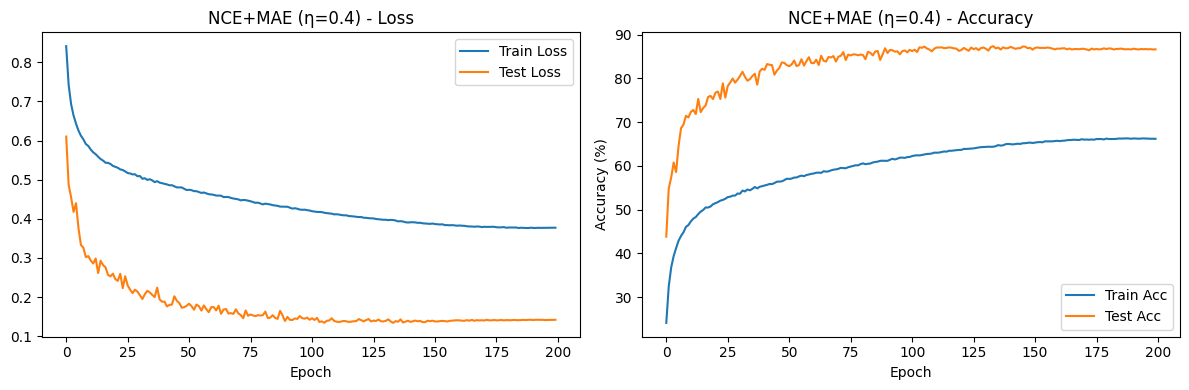

 - NFL+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 21.52% | Test Loss: 7.2990


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 15.89% | Test Loss: 7.8190


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 22.26% | Test Loss: 7.2299


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 24.43% | Test Loss: 7.0282


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 25.57% | Test Loss: 6.9278


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 26.41% | Test Loss: 6.8425


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 25.04% | Test Loss: 6.9635


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 25.05% | Test Loss: 6.9659


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 23.20% | Test Loss: 7.1557


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 20.09% | Test Loss: 7.4415


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 19.35% | Test Loss: 7.5028


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 23.63% | Test Loss: 7.0961


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 22.89% | Test Loss: 7.1651


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 23.19% | Test Loss: 7.1234


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 25.53% | Test Loss: 6.9089


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 21.59% | Test Loss: 7.2825


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 22.93% | Test Loss: 7.1771


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 27.23% | Test Loss: 6.7750


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 26.95% | Test Loss: 6.7996


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 27.35% | Test Loss: 6.7315


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 22.94% | Test Loss: 7.1412


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 25.53% | Test Loss: 6.9294


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 29.87% | Test Loss: 6.5244


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 26.20% | Test Loss: 6.8546


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 23.74% | Test Loss: 7.1077


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 22.79% | Test Loss: 7.1825


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 21.57% | Test Loss: 7.2899


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 23.03% | Test Loss: 7.1553


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 26.70% | Test Loss: 6.8088


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 23.11% | Test Loss: 7.1341


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 22.59% | Test Loss: 7.1885


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 25.66% | Test Loss: 6.8911


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 25.39% | Test Loss: 6.9329


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 26.69% | Test Loss: 6.8106


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 25.02% | Test Loss: 6.9745


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 26.67% | Test Loss: 6.8240


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 24.81% | Test Loss: 6.9834


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 27.03% | Test Loss: 6.7873


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 28.28% | Test Loss: 6.6523


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 27.35% | Test Loss: 6.7738


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 27.12% | Test Loss: 6.7698


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 27.15% | Test Loss: 6.7580


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 28.38% | Test Loss: 6.6426


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 29.70% | Test Loss: 6.5291


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 28.61% | Test Loss: 6.6248


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 28.97% | Test Loss: 6.5904


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 29.35% | Test Loss: 6.5538


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 24.86% | Test Loss: 6.9836


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 26.64% | Test Loss: 6.8061


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 29.90% | Test Loss: 6.5235


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 28.08% | Test Loss: 6.6868


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 27.94% | Test Loss: 6.7189


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 29.74% | Test Loss: 6.5183


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 30.62% | Test Loss: 6.4565


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 31.04% | Test Loss: 6.4133


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 20.53% | Test Loss: 7.4093


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 31.22% | Test Loss: 6.4096


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 28.78% | Test Loss: 6.6281


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 30.07% | Test Loss: 6.4992


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 30.57% | Test Loss: 6.4693


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 28.07% | Test Loss: 6.7037


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 30.21% | Test Loss: 6.4982


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 31.37% | Test Loss: 6.3757


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 28.70% | Test Loss: 6.6195


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 29.70% | Test Loss: 6.5403


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 29.23% | Test Loss: 6.5856


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 31.04% | Test Loss: 6.4256


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 31.71% | Test Loss: 6.3552


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 30.56% | Test Loss: 6.4639


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 31.12% | Test Loss: 6.4172


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 30.59% | Test Loss: 6.4600


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 32.42% | Test Loss: 6.2911


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 31.18% | Test Loss: 6.4088


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 32.22% | Test Loss: 6.3135


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 31.68% | Test Loss: 6.3497


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 30.85% | Test Loss: 6.4364


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 34.03% | Test Loss: 6.1541


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 32.88% | Test Loss: 6.2494


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 32.37% | Test Loss: 6.3010


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 31.84% | Test Loss: 6.3374


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 31.53% | Test Loss: 6.3843


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 30.27% | Test Loss: 6.4942


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 29.50% | Test Loss: 6.5409


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 30.10% | Test Loss: 6.4912


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 32.00% | Test Loss: 6.3163


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 31.62% | Test Loss: 6.3446


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.59it/s]


Test Acc: 32.13% | Test Loss: 6.3119


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 31.01% | Test Loss: 6.4094


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 32.68% | Test Loss: 6.2626


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 33.65% | Test Loss: 6.1685


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 34.12% | Test Loss: 6.1182


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 33.39% | Test Loss: 6.2027


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 35.93% | Test Loss: 5.9576


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 33.73% | Test Loss: 6.1399


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 32.28% | Test Loss: 6.2982


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 35.02% | Test Loss: 6.0473


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 34.50% | Test Loss: 6.0965


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 35.27% | Test Loss: 6.0266


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 35.37% | Test Loss: 6.0233


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 35.65% | Test Loss: 5.9895


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 36.53% | Test Loss: 5.9013


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 35.54% | Test Loss: 5.9992


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 32.49% | Test Loss: 6.2719


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 34.69% | Test Loss: 6.0732


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 35.50% | Test Loss: 5.9963


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 35.62% | Test Loss: 5.9740


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 36.27% | Test Loss: 5.9271


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 35.27% | Test Loss: 6.0242


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 35.34% | Test Loss: 6.0174


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 35.28% | Test Loss: 6.0205


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 36.53% | Test Loss: 5.8943


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 38.58% | Test Loss: 5.7129


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 37.77% | Test Loss: 5.7828


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 37.70% | Test Loss: 5.7962


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 38.41% | Test Loss: 5.7251


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 38.64% | Test Loss: 5.7069


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 37.77% | Test Loss: 5.7973


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 35.93% | Test Loss: 5.9669


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 38.56% | Test Loss: 5.7170


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 38.61% | Test Loss: 5.7149


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 37.36% | Test Loss: 5.8186


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 37.98% | Test Loss: 5.7686


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 38.52% | Test Loss: 5.7181


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 38.28% | Test Loss: 5.7447


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 39.23% | Test Loss: 5.6697


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 40.12% | Test Loss: 5.5836


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 39.62% | Test Loss: 5.6325


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 38.71% | Test Loss: 5.7123


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 39.89% | Test Loss: 5.5747


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 40.22% | Test Loss: 5.5445


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 40.49% | Test Loss: 5.5362


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 39.88% | Test Loss: 5.5877


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 40.38% | Test Loss: 5.5370


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 41.33% | Test Loss: 5.4429


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 41.08% | Test Loss: 5.4772


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 41.14% | Test Loss: 5.4801


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 41.66% | Test Loss: 5.4363


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 41.90% | Test Loss: 5.3920


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 39.28% | Test Loss: 5.6442


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 41.85% | Test Loss: 5.4243


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 41.40% | Test Loss: 5.4589


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 41.79% | Test Loss: 5.4146


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 41.97% | Test Loss: 5.4062


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 41.04% | Test Loss: 5.4864


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 42.61% | Test Loss: 5.3415


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 42.31% | Test Loss: 5.3661


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 41.87% | Test Loss: 5.4049


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 42.68% | Test Loss: 5.3366


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 42.74% | Test Loss: 5.3172


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 42.35% | Test Loss: 5.3664


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 42.66% | Test Loss: 5.3273


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 42.54% | Test Loss: 5.3453


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 42.38% | Test Loss: 5.3605


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 43.31% | Test Loss: 5.2766


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 43.28% | Test Loss: 5.2777


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 42.84% | Test Loss: 5.3292


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 43.01% | Test Loss: 5.3121


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 42.91% | Test Loss: 5.3098


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 42.96% | Test Loss: 5.2841


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 43.21% | Test Loss: 5.2726


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 43.39% | Test Loss: 5.2610


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 43.66% | Test Loss: 5.2431


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 43.89% | Test Loss: 5.2138


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 43.89% | Test Loss: 5.2153


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 44.08% | Test Loss: 5.2037


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 43.77% | Test Loss: 5.2322


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 43.86% | Test Loss: 5.2292


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 44.09% | Test Loss: 5.2014


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 43.83% | Test Loss: 5.2282


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 43.98% | Test Loss: 5.2041


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 44.45% | Test Loss: 5.1635


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 44.30% | Test Loss: 5.1742


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 44.43% | Test Loss: 5.1636


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 44.42% | Test Loss: 5.1557


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 44.47% | Test Loss: 5.1535


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 44.56% | Test Loss: 5.1484


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 44.53% | Test Loss: 5.1367


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 44.60% | Test Loss: 5.1368


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 44.94% | Test Loss: 5.1053


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 44.78% | Test Loss: 5.1203


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 44.71% | Test Loss: 5.1308


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 45.03% | Test Loss: 5.1072


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 44.80% | Test Loss: 5.1276


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 44.72% | Test Loss: 5.1353


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 44.81% | Test Loss: 5.1312


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 44.68% | Test Loss: 5.1491


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 44.88% | Test Loss: 5.1196


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 44.82% | Test Loss: 5.1358


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 44.85% | Test Loss: 5.1229


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 44.72% | Test Loss: 5.1354


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 44.75% | Test Loss: 5.1354


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 44.82% | Test Loss: 5.1284


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 44.78% | Test Loss: 5.1320


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 44.83% | Test Loss: 5.1247


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 44.72% | Test Loss: 5.1375


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 44.73% | Test Loss: 5.1361


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 44.68% | Test Loss: 5.1393


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 44.75% | Test Loss: 5.1323


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 44.77% | Test Loss: 5.1313


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 44.79% | Test Loss: 5.1280


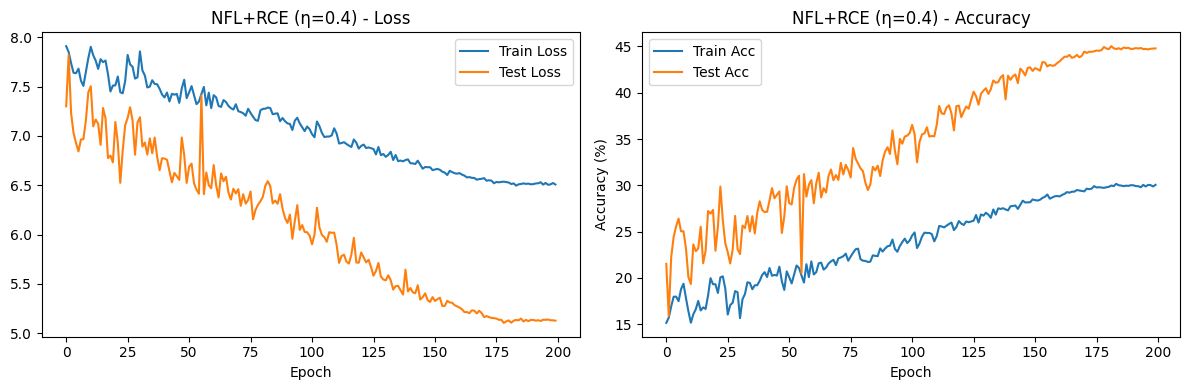

 - NFL+MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 41.08% | Test Loss: 0.6324


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 53.56% | Test Loss: 0.4982


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 53.98% | Test Loss: 0.4882


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 61.97% | Test Loss: 0.4063


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 60.79% | Test Loss: 0.4163


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 56.69% | Test Loss: 0.4611


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 69.18% | Test Loss: 0.3275


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 67.39% | Test Loss: 0.3476


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 71.93% | Test Loss: 0.2975


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 70.21% | Test Loss: 0.3142


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 72.36% | Test Loss: 0.2910


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 72.81% | Test Loss: 0.2863


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 71.16% | Test Loss: 0.3045


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 76.39% | Test Loss: 0.2504


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 73.18% | Test Loss: 0.2828


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 75.78% | Test Loss: 0.2568


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 72.59% | Test Loss: 0.2880


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 76.18% | Test Loss: 0.2498


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 77.49% | Test Loss: 0.2381


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 73.41% | Test Loss: 0.2801


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 76.85% | Test Loss: 0.2450


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 72.58% | Test Loss: 0.2879


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 77.41% | Test Loss: 0.2389


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 76.68% | Test Loss: 0.2460


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 79.27% | Test Loss: 0.2187


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 79.38% | Test Loss: 0.2181


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 76.90% | Test Loss: 0.2437


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 77.41% | Test Loss: 0.2386


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 78.39% | Test Loss: 0.2278


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 79.06% | Test Loss: 0.2199


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 79.66% | Test Loss: 0.2123


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 77.09% | Test Loss: 0.2410


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 79.47% | Test Loss: 0.2154


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 78.62% | Test Loss: 0.2242


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 79.94% | Test Loss: 0.2096


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 81.04% | Test Loss: 0.1963


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 79.82% | Test Loss: 0.2112


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 80.94% | Test Loss: 0.1993


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 79.54% | Test Loss: 0.2139


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 81.46% | Test Loss: 0.1950


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 80.94% | Test Loss: 0.2000


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 81.19% | Test Loss: 0.1974


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 81.67% | Test Loss: 0.1945


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 82.24% | Test Loss: 0.1864


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 81.58% | Test Loss: 0.1927


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 80.90% | Test Loss: 0.2002


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 81.91% | Test Loss: 0.1908


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 80.72% | Test Loss: 0.2010


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 82.78% | Test Loss: 0.1787


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 82.92% | Test Loss: 0.1771


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 82.64% | Test Loss: 0.1837


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 82.57% | Test Loss: 0.1841


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 82.09% | Test Loss: 0.1869


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 83.40% | Test Loss: 0.1730


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 83.03% | Test Loss: 0.1779


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 83.38% | Test Loss: 0.1731


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 83.34% | Test Loss: 0.1742


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 83.24% | Test Loss: 0.1752


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 84.28% | Test Loss: 0.1655


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 82.62% | Test Loss: 0.1811


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 84.31% | Test Loss: 0.1647


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 83.09% | Test Loss: 0.1777


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 83.75% | Test Loss: 0.1712


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 84.61% | Test Loss: 0.1615


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 83.07% | Test Loss: 0.1785


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 84.23% | Test Loss: 0.1656


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 84.23% | Test Loss: 0.1655


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 84.27% | Test Loss: 0.1635


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 83.48% | Test Loss: 0.1725


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 84.19% | Test Loss: 0.1651


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 83.05% | Test Loss: 0.1768


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 84.17% | Test Loss: 0.1654


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 83.92% | Test Loss: 0.1682


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 84.99% | Test Loss: 0.1564


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 84.93% | Test Loss: 0.1583


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 84.75% | Test Loss: 0.1592


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 85.39% | Test Loss: 0.1532


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 85.00% | Test Loss: 0.1560


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 85.14% | Test Loss: 0.1553


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 84.98% | Test Loss: 0.1576


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 85.25% | Test Loss: 0.1547


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 84.45% | Test Loss: 0.1626


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 85.06% | Test Loss: 0.1573


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 85.64% | Test Loss: 0.1508


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 84.65% | Test Loss: 0.1595


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 85.01% | Test Loss: 0.1569


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 85.35% | Test Loss: 0.1529


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 85.90% | Test Loss: 0.1476


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 84.74% | Test Loss: 0.1591


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 85.72% | Test Loss: 0.1511


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 84.54% | Test Loss: 0.1628


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 85.48% | Test Loss: 0.1519


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 85.87% | Test Loss: 0.1481


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 85.42% | Test Loss: 0.1527


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 85.38% | Test Loss: 0.1535


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 85.19% | Test Loss: 0.1543


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 85.38% | Test Loss: 0.1541


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 86.00% | Test Loss: 0.1461


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 86.04% | Test Loss: 0.1478


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 85.79% | Test Loss: 0.1485


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 86.07% | Test Loss: 0.1478


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 85.71% | Test Loss: 0.1502


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 86.01% | Test Loss: 0.1465


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 85.82% | Test Loss: 0.1501


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 85.48% | Test Loss: 0.1528


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 85.47% | Test Loss: 0.1526


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 85.61% | Test Loss: 0.1499


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 85.52% | Test Loss: 0.1514


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 86.11% | Test Loss: 0.1457


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 86.42% | Test Loss: 0.1429


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 84.43% | Test Loss: 0.1626


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 85.61% | Test Loss: 0.1512


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 86.08% | Test Loss: 0.1450


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 85.36% | Test Loss: 0.1535


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 85.47% | Test Loss: 0.1532


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 85.76% | Test Loss: 0.1485


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 86.07% | Test Loss: 0.1465


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 85.75% | Test Loss: 0.1499


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 86.10% | Test Loss: 0.1453


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 85.62% | Test Loss: 0.1505


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 85.89% | Test Loss: 0.1477


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 85.98% | Test Loss: 0.1477


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 85.92% | Test Loss: 0.1475


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 85.96% | Test Loss: 0.1478


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 86.19% | Test Loss: 0.1453


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 86.01% | Test Loss: 0.1471


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 86.21% | Test Loss: 0.1451


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 85.88% | Test Loss: 0.1478


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 86.28% | Test Loss: 0.1445


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 85.89% | Test Loss: 0.1474


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 86.17% | Test Loss: 0.1457


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 86.04% | Test Loss: 0.1460


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 86.15% | Test Loss: 0.1463


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 86.33% | Test Loss: 0.1449


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 86.04% | Test Loss: 0.1470


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 85.94% | Test Loss: 0.1482


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 86.19% | Test Loss: 0.1455


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 86.07% | Test Loss: 0.1457


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 85.90% | Test Loss: 0.1490


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 85.84% | Test Loss: 0.1473


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 85.73% | Test Loss: 0.1508


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 85.92% | Test Loss: 0.1470


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 85.77% | Test Loss: 0.1489


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 86.27% | Test Loss: 0.1460


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 85.67% | Test Loss: 0.1504


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 85.70% | Test Loss: 0.1503


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 86.08% | Test Loss: 0.1465


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 86.35% | Test Loss: 0.1447


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 86.27% | Test Loss: 0.1443


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 85.94% | Test Loss: 0.1470


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 86.08% | Test Loss: 0.1461


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 86.15% | Test Loss: 0.1456


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 86.23% | Test Loss: 0.1455


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 86.07% | Test Loss: 0.1473


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 85.95% | Test Loss: 0.1475


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 85.97% | Test Loss: 0.1475


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 86.17% | Test Loss: 0.1461


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 85.95% | Test Loss: 0.1480


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 86.17% | Test Loss: 0.1463


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 85.85% | Test Loss: 0.1473


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 85.75% | Test Loss: 0.1494


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 85.99% | Test Loss: 0.1472


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 86.03% | Test Loss: 0.1483


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 85.85% | Test Loss: 0.1476


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 85.98% | Test Loss: 0.1481


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 85.98% | Test Loss: 0.1479


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 86.16% | Test Loss: 0.1464


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 86.06% | Test Loss: 0.1473


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 86.02% | Test Loss: 0.1472


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 85.86% | Test Loss: 0.1490


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 86.06% | Test Loss: 0.1475


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 85.91% | Test Loss: 0.1485


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 85.86% | Test Loss: 0.1488


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 85.98% | Test Loss: 0.1482


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 86.06% | Test Loss: 0.1485


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 85.98% | Test Loss: 0.1480


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 85.82% | Test Loss: 0.1491


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 85.97% | Test Loss: 0.1493


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 85.98% | Test Loss: 0.1482


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 85.95% | Test Loss: 0.1482


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 85.90% | Test Loss: 0.1483


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 85.98% | Test Loss: 0.1477


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 85.93% | Test Loss: 0.1483


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 86.13% | Test Loss: 0.1471


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 85.97% | Test Loss: 0.1480


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 85.93% | Test Loss: 0.1479


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 85.93% | Test Loss: 0.1487


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 85.94% | Test Loss: 0.1483


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 85.91% | Test Loss: 0.1482


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 85.91% | Test Loss: 0.1483


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 86.00% | Test Loss: 0.1482


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 85.98% | Test Loss: 0.1484


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 85.97% | Test Loss: 0.1482


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 86.00% | Test Loss: 0.1479


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 85.93% | Test Loss: 0.1483


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 86.02% | Test Loss: 0.1481


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 85.99% | Test Loss: 0.1484


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 86.04% | Test Loss: 0.1483


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 85.99% | Test Loss: 0.1486


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 85.93% | Test Loss: 0.1483


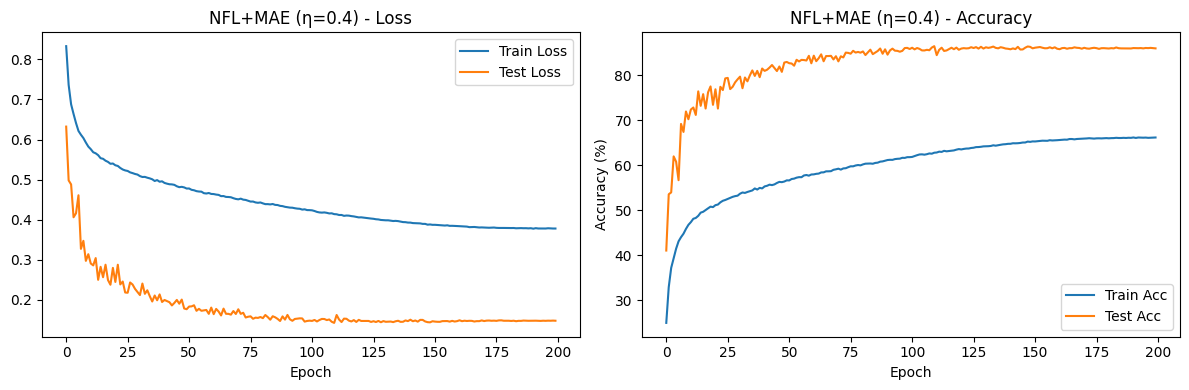

 - NFL+NCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 39.87% | Test Loss: 0.0583


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 41.97% | Test Loss: 0.0469


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 44.82% | Test Loss: 0.0400


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 46.46% | Test Loss: 0.0361


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 47.33% | Test Loss: 0.0378


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 49.29% | Test Loss: 0.0323


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 51.51% | Test Loss: 0.0284


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 49.43% | Test Loss: 0.0309


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 51.99% | Test Loss: 0.0282


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 51.01% | Test Loss: 0.0320


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 55.11% | Test Loss: 0.0247


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 55.47% | Test Loss: 0.0272


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 51.59% | Test Loss: 0.0264


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 57.78% | Test Loss: 0.0201


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 58.75% | Test Loss: 0.0196


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 54.96% | Test Loss: 0.0231


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 57.96% | Test Loss: 0.0194


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 57.46% | Test Loss: 0.0201


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 55.89% | Test Loss: 0.0259


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 55.01% | Test Loss: 0.0211


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 60.28% | Test Loss: 0.0169


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 60.34% | Test Loss: 0.0166


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 57.75% | Test Loss: 0.0172


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 55.95% | Test Loss: 0.0270


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 61.39% | Test Loss: 0.0165


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 62.17% | Test Loss: 0.0155


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 60.33% | Test Loss: 0.0170


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 58.95% | Test Loss: 0.0170


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 60.40% | Test Loss: 0.0171


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 61.80% | Test Loss: 0.0153


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 61.52% | Test Loss: 0.0149


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 61.91% | Test Loss: 0.0148


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 59.67% | Test Loss: 0.0162


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 62.53% | Test Loss: 0.0160


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 58.01% | Test Loss: 0.0161


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 61.75% | Test Loss: 0.0171


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 60.77% | Test Loss: 0.0147


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 60.16% | Test Loss: 0.0147


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 62.03% | Test Loss: 0.0136


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 60.85% | Test Loss: 0.0162


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 62.59% | Test Loss: 0.0147


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 61.36% | Test Loss: 0.0153


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 62.06% | Test Loss: 0.0166


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 61.71% | Test Loss: 0.0155


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 60.17% | Test Loss: 0.0182


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 62.40% | Test Loss: 0.0157


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 63.44% | Test Loss: 0.0163


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 63.11% | Test Loss: 0.0146


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 61.62% | Test Loss: 0.0159


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 63.70% | Test Loss: 0.0134


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 61.99% | Test Loss: 0.0143


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 62.63% | Test Loss: 0.0130


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 63.28% | Test Loss: 0.0136


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 63.17% | Test Loss: 0.0187


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 63.58% | Test Loss: 0.0158


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 62.29% | Test Loss: 0.0148


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 64.35% | Test Loss: 0.0146


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 62.50% | Test Loss: 0.0151


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 62.86% | Test Loss: 0.0151


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 62.71% | Test Loss: 0.0147


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 61.26% | Test Loss: 0.0174


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 64.45% | Test Loss: 0.0128


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 63.45% | Test Loss: 0.0137


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 61.51% | Test Loss: 0.0144


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 63.30% | Test Loss: 0.0172


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 63.28% | Test Loss: 0.0135


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 60.43% | Test Loss: 0.0247


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 62.49% | Test Loss: 0.0133


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 63.30% | Test Loss: 0.0151


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 61.12% | Test Loss: 0.0160


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 63.11% | Test Loss: 0.0160


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 64.32% | Test Loss: 0.0154


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 60.31% | Test Loss: 0.0212


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 63.46% | Test Loss: 0.0152


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 64.24% | Test Loss: 0.0142


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 63.74% | Test Loss: 0.0148


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 61.75% | Test Loss: 0.0124


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 63.84% | Test Loss: 0.0223


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 63.86% | Test Loss: 0.0174


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 64.55% | Test Loss: 0.0150


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 64.63% | Test Loss: 0.0139


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 64.09% | Test Loss: 0.0167


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 63.15% | Test Loss: 0.0158


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 64.63% | Test Loss: 0.0164


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 63.36% | Test Loss: 0.0201


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 63.68% | Test Loss: 0.0176


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 63.46% | Test Loss: 0.0152


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 64.53% | Test Loss: 0.0152


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 63.88% | Test Loss: 0.0160


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 65.75% | Test Loss: 0.0167


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 63.84% | Test Loss: 0.0143


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 61.25% | Test Loss: 0.0174


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 64.91% | Test Loss: 0.0138


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 64.68% | Test Loss: 0.0141


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 62.86% | Test Loss: 0.0135


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 64.54% | Test Loss: 0.0140


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 63.95% | Test Loss: 0.0176


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 64.79% | Test Loss: 0.0208


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 64.91% | Test Loss: 0.0161


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 65.28% | Test Loss: 0.0139


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 63.43% | Test Loss: 0.0193


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 63.45% | Test Loss: 0.0162


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 64.39% | Test Loss: 0.0160


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 64.60% | Test Loss: 0.0153


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 64.93% | Test Loss: 0.0186


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 65.78% | Test Loss: 0.0128


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 64.02% | Test Loss: 0.0188


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 66.35% | Test Loss: 0.0155


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 64.95% | Test Loss: 0.0183


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 64.83% | Test Loss: 0.0156


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 64.52% | Test Loss: 0.0183


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 66.11% | Test Loss: 0.0158


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 65.22% | Test Loss: 0.0149


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 65.61% | Test Loss: 0.0144


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 63.58% | Test Loss: 0.0159


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 64.91% | Test Loss: 0.0144


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 64.21% | Test Loss: 0.0164


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 63.85% | Test Loss: 0.0145


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 66.03% | Test Loss: 0.0155


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 65.82% | Test Loss: 0.0133


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 64.72% | Test Loss: 0.0163


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 66.37% | Test Loss: 0.0153


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 63.52% | Test Loss: 0.0146


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 65.52% | Test Loss: 0.0140


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 65.99% | Test Loss: 0.0144


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 64.95% | Test Loss: 0.0151


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 64.50% | Test Loss: 0.0133


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 64.66% | Test Loss: 0.0148


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 64.22% | Test Loss: 0.0156


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 65.55% | Test Loss: 0.0157


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 64.08% | Test Loss: 0.0187


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 64.86% | Test Loss: 0.0155


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 66.10% | Test Loss: 0.0143


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 65.33% | Test Loss: 0.0164


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 65.93% | Test Loss: 0.0159


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 65.23% | Test Loss: 0.0162


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 65.69% | Test Loss: 0.0178


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 65.82% | Test Loss: 0.0202


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 65.67% | Test Loss: 0.0152


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 66.90% | Test Loss: 0.0140


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 65.81% | Test Loss: 0.0136


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 66.02% | Test Loss: 0.0159


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 66.64% | Test Loss: 0.0155


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 65.50% | Test Loss: 0.0169


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 66.98% | Test Loss: 0.0154


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 66.25% | Test Loss: 0.0138


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 66.70% | Test Loss: 0.0155


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 65.71% | Test Loss: 0.0153


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 65.89% | Test Loss: 0.0144


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 65.90% | Test Loss: 0.0145


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 65.42% | Test Loss: 0.0154


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 65.65% | Test Loss: 0.0157


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 66.39% | Test Loss: 0.0164


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 65.08% | Test Loss: 0.0169


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 65.89% | Test Loss: 0.0152


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 66.06% | Test Loss: 0.0156


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 65.11% | Test Loss: 0.0145


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 65.14% | Test Loss: 0.0144


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 66.55% | Test Loss: 0.0145


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 66.41% | Test Loss: 0.0169


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 66.67% | Test Loss: 0.0156


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 66.20% | Test Loss: 0.0157


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 65.86% | Test Loss: 0.0147


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 66.02% | Test Loss: 0.0154


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 66.52% | Test Loss: 0.0159


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 65.89% | Test Loss: 0.0155


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 66.02% | Test Loss: 0.0156


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 65.76% | Test Loss: 0.0163


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 66.24% | Test Loss: 0.0150


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 65.96% | Test Loss: 0.0153


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 66.53% | Test Loss: 0.0145


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 66.53% | Test Loss: 0.0149


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 66.38% | Test Loss: 0.0150


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 66.18% | Test Loss: 0.0146


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 66.30% | Test Loss: 0.0155


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 66.27% | Test Loss: 0.0144


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 66.23% | Test Loss: 0.0155


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 66.34% | Test Loss: 0.0148


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 65.96% | Test Loss: 0.0147


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 66.51% | Test Loss: 0.0151


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 66.10% | Test Loss: 0.0148


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 66.03% | Test Loss: 0.0152


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 66.29% | Test Loss: 0.0153


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 66.71% | Test Loss: 0.0152


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 66.55% | Test Loss: 0.0152


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 66.24% | Test Loss: 0.0154


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 66.25% | Test Loss: 0.0148


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 66.38% | Test Loss: 0.0151


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 66.26% | Test Loss: 0.0151


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 66.51% | Test Loss: 0.0148


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 66.43% | Test Loss: 0.0150


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 66.32% | Test Loss: 0.0147


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 66.45% | Test Loss: 0.0151


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 66.30% | Test Loss: 0.0152


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 66.16% | Test Loss: 0.0150


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 66.36% | Test Loss: 0.0148


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 66.40% | Test Loss: 0.0150


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 66.57% | Test Loss: 0.0149


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 66.22% | Test Loss: 0.0152


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 66.32% | Test Loss: 0.0149


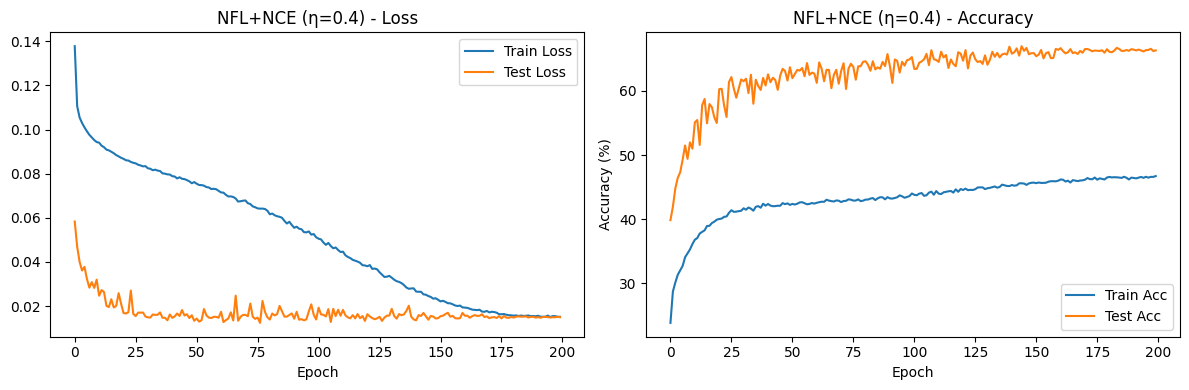

 - MAE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 16.29% | Test Loss: 8.5567


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 15.84% | Test Loss: 8.5778


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 17.26% | Test Loss: 8.4315


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 16.36% | Test Loss: 8.5501


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 20.30% | Test Loss: 8.1265


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 18.06% | Test Loss: 8.3637


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 20.36% | Test Loss: 8.1244


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 18.20% | Test Loss: 8.3349


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 20.24% | Test Loss: 8.1253


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 19.45% | Test Loss: 8.2118


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 22.23% | Test Loss: 7.9328


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 22.41% | Test Loss: 7.9053


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 21.27% | Test Loss: 8.0298


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 23.47% | Test Loss: 7.7987


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 23.93% | Test Loss: 7.7528


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 21.03% | Test Loss: 8.0578


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 22.29% | Test Loss: 7.9238


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 23.01% | Test Loss: 7.8504


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 21.05% | Test Loss: 8.0456


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 19.41% | Test Loss: 8.2216


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 22.32% | Test Loss: 7.9211


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 17.49% | Test Loss: 8.4087


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 20.25% | Test Loss: 8.1304


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 21.64% | Test Loss: 7.9886


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 21.67% | Test Loss: 8.0010


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 20.70% | Test Loss: 8.0979


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 20.84% | Test Loss: 8.0784


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 20.68% | Test Loss: 8.0957


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 20.62% | Test Loss: 8.1068


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 20.24% | Test Loss: 8.1451


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 23.22% | Test Loss: 7.8316


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 19.79% | Test Loss: 8.1917


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 23.43% | Test Loss: 7.8024


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 24.14% | Test Loss: 7.7297


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 23.97% | Test Loss: 7.7496


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 22.37% | Test Loss: 7.9154


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 23.94% | Test Loss: 7.7568


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 23.79% | Test Loss: 7.7742


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 23.69% | Test Loss: 7.7834


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 22.57% | Test Loss: 7.9007


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 22.71% | Test Loss: 7.8818


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 23.89% | Test Loss: 7.7631


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 23.15% | Test Loss: 7.8365


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 24.08% | Test Loss: 7.7435


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 22.36% | Test Loss: 7.9113


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 22.80% | Test Loss: 7.8713


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 18.68% | Test Loss: 8.3034


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 20.83% | Test Loss: 8.0650


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 23.10% | Test Loss: 7.8277


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 22.04% | Test Loss: 7.9434


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 22.28% | Test Loss: 7.9109


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 21.91% | Test Loss: 7.9549


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 21.38% | Test Loss: 8.0095


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 22.43% | Test Loss: 7.8954


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 24.12% | Test Loss: 7.7404


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 23.88% | Test Loss: 7.7578


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 24.26% | Test Loss: 7.7156


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 23.13% | Test Loss: 7.8332


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 23.94% | Test Loss: 7.7536


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 24.35% | Test Loss: 7.7111


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 24.83% | Test Loss: 7.6620


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 24.40% | Test Loss: 7.7129


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 24.79% | Test Loss: 7.6714


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 24.25% | Test Loss: 7.7254


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 24.83% | Test Loss: 7.6594


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 24.21% | Test Loss: 7.7283


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 23.83% | Test Loss: 7.7701


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 22.05% | Test Loss: 7.9461


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 24.60% | Test Loss: 7.6923


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 24.37% | Test Loss: 7.7147


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 24.67% | Test Loss: 7.6828


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 23.81% | Test Loss: 7.7613


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 23.91% | Test Loss: 7.7618


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 24.35% | Test Loss: 7.7093


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 25.12% | Test Loss: 7.6304


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 24.07% | Test Loss: 7.7366


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 24.29% | Test Loss: 7.7164


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 23.98% | Test Loss: 7.7493


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 24.68% | Test Loss: 7.6829


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 24.41% | Test Loss: 7.7110


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 24.10% | Test Loss: 7.7422


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 24.77% | Test Loss: 7.6682


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 24.22% | Test Loss: 7.7315


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 25.15% | Test Loss: 7.6275


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 24.69% | Test Loss: 7.6737


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 24.17% | Test Loss: 7.7341


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 23.78% | Test Loss: 7.7668


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 25.16% | Test Loss: 7.6335


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 24.38% | Test Loss: 7.7002


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 25.66% | Test Loss: 7.5780


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 26.62% | Test Loss: 7.4801


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 25.60% | Test Loss: 7.5844


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 25.98% | Test Loss: 7.5536


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 24.65% | Test Loss: 7.6724


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 26.01% | Test Loss: 7.5422


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 25.55% | Test Loss: 7.5965


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 26.24% | Test Loss: 7.5185


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 25.91% | Test Loss: 7.5508


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 26.01% | Test Loss: 7.5404


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 26.52% | Test Loss: 7.4904


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 26.98% | Test Loss: 7.4432


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 26.17% | Test Loss: 7.5176


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 26.87% | Test Loss: 7.4493


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 26.20% | Test Loss: 7.5289


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 26.50% | Test Loss: 7.4923


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 26.79% | Test Loss: 7.4766


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 27.79% | Test Loss: 7.3690


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 27.25% | Test Loss: 7.4076


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 27.27% | Test Loss: 7.4153


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 27.35% | Test Loss: 7.4129


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 26.57% | Test Loss: 7.4794


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 24.65% | Test Loss: 7.6711


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 26.57% | Test Loss: 7.4787


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 25.82% | Test Loss: 7.5544


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 27.29% | Test Loss: 7.4194


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 26.25% | Test Loss: 7.5168


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 27.50% | Test Loss: 7.3900


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 26.08% | Test Loss: 7.5382


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 26.71% | Test Loss: 7.4797


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 27.60% | Test Loss: 7.3895


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 27.53% | Test Loss: 7.3946


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 27.42% | Test Loss: 7.4000


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 26.78% | Test Loss: 7.4548


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 27.90% | Test Loss: 7.3584


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 26.89% | Test Loss: 7.4493


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 27.00% | Test Loss: 7.4338


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 27.78% | Test Loss: 7.3654


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 27.89% | Test Loss: 7.3602


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 28.12% | Test Loss: 7.3256


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 27.92% | Test Loss: 7.3504


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 27.76% | Test Loss: 7.3730


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 28.25% | Test Loss: 7.3151


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 27.80% | Test Loss: 7.3601


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 27.43% | Test Loss: 7.3922


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 28.09% | Test Loss: 7.3302


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 28.15% | Test Loss: 7.3258


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 26.88% | Test Loss: 7.4551


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 27.17% | Test Loss: 7.4256


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 26.58% | Test Loss: 7.4845


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 27.80% | Test Loss: 7.3599


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 26.87% | Test Loss: 7.4611


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 27.28% | Test Loss: 7.4049


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 27.63% | Test Loss: 7.3854


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 28.38% | Test Loss: 7.3039


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 27.64% | Test Loss: 7.3692


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 27.16% | Test Loss: 7.4190


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 27.17% | Test Loss: 7.4148


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 27.34% | Test Loss: 7.4032


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 27.05% | Test Loss: 7.4287


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 27.07% | Test Loss: 7.4351


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 27.33% | Test Loss: 7.4013


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 27.62% | Test Loss: 7.3782


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 27.72% | Test Loss: 7.3690


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 28.18% | Test Loss: 7.3237


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 28.27% | Test Loss: 7.3083


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 28.06% | Test Loss: 7.3340


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 28.55% | Test Loss: 7.2868


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 28.50% | Test Loss: 7.2917


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 28.71% | Test Loss: 7.2694


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 28.68% | Test Loss: 7.2718


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 28.54% | Test Loss: 7.2791


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 28.60% | Test Loss: 7.2751


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 28.42% | Test Loss: 7.2888


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 28.58% | Test Loss: 7.2748


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 28.44% | Test Loss: 7.2925


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 28.33% | Test Loss: 7.2979


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 28.61% | Test Loss: 7.2717


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 28.54% | Test Loss: 7.2846


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 28.36% | Test Loss: 7.3046


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 28.32% | Test Loss: 7.3083


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 28.13% | Test Loss: 7.3270


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 28.29% | Test Loss: 7.3111


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 28.17% | Test Loss: 7.3232


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 28.10% | Test Loss: 7.3307


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 28.17% | Test Loss: 7.3195


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 28.36% | Test Loss: 7.3053


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 28.58% | Test Loss: 7.2834


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 28.56% | Test Loss: 7.2832


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 28.59% | Test Loss: 7.2808


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 28.66% | Test Loss: 7.2745


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 28.78% | Test Loss: 7.2622


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 28.62% | Test Loss: 7.2778


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 28.68% | Test Loss: 7.2724


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 28.64% | Test Loss: 7.2770


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 28.77% | Test Loss: 7.2625


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 28.68% | Test Loss: 7.2713


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 28.74% | Test Loss: 7.2647


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 28.69% | Test Loss: 7.2721


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 28.68% | Test Loss: 7.2706


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 28.69% | Test Loss: 7.2724


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 28.59% | Test Loss: 7.2791


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 28.68% | Test Loss: 7.2725


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 28.59% | Test Loss: 7.2820


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 28.67% | Test Loss: 7.2722


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 28.61% | Test Loss: 7.2773


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 28.76% | Test Loss: 7.2665


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 28.77% | Test Loss: 7.2647


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 28.75% | Test Loss: 7.2615


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 28.79% | Test Loss: 7.2581


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 28.61% | Test Loss: 7.2780


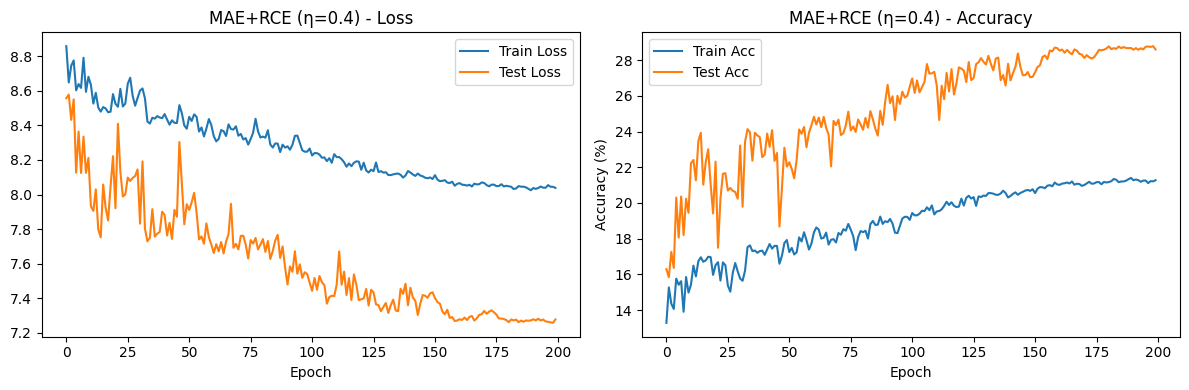


Noise Rate: 0.6

Training vanilla Losses...
 - CE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 43.23% | Test Loss: 1.8055


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 48.78% | Test Loss: 1.7282


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 50.18% | Test Loss: 1.6592


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 60.08% | Test Loss: 1.5761


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 61.78% | Test Loss: 1.5037


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 62.10% | Test Loss: 1.5174


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 65.37% | Test Loss: 1.4970


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 67.11% | Test Loss: 1.3993


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 68.99% | Test Loss: 1.4153


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 70.99% | Test Loss: 1.3924


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 70.39% | Test Loss: 1.3692


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 68.34% | Test Loss: 1.4645


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 72.56% | Test Loss: 1.3362


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 72.47% | Test Loss: 1.3929


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 74.15% | Test Loss: 1.3487


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 74.16% | Test Loss: 1.3361


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 71.07% | Test Loss: 1.3589


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 72.35% | Test Loss: 1.3831


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 75.74% | Test Loss: 1.3294


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 75.90% | Test Loss: 1.2881


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 72.45% | Test Loss: 1.2773


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 74.78% | Test Loss: 1.2494


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 74.58% | Test Loss: 1.2624


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 74.18% | Test Loss: 1.2426


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 71.51% | Test Loss: 1.2538


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 74.17% | Test Loss: 1.2570


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 75.07% | Test Loss: 1.2497


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 75.84% | Test Loss: 1.2245


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 70.33% | Test Loss: 1.3517


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.50it/s]


Test Acc: 74.50% | Test Loss: 1.3549


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 71.54% | Test Loss: 1.2433


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.81it/s]


Test Acc: 72.04% | Test Loss: 1.2921


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 75.76% | Test Loss: 1.1724


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.20it/s]


Test Acc: 73.92% | Test Loss: 1.2499


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 73.69% | Test Loss: 1.3179


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 70.97% | Test Loss: 1.3253


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 72.67% | Test Loss: 1.1684


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 73.39% | Test Loss: 1.2492


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 70.64% | Test Loss: 1.2643


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 69.09% | Test Loss: 1.2567


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 74.33% | Test Loss: 1.1868


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 71.53% | Test Loss: 1.2235


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.74it/s]


Test Acc: 72.12% | Test Loss: 1.2204


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 71.11% | Test Loss: 1.2749


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 71.35% | Test Loss: 1.1851


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.96it/s]


Test Acc: 68.36% | Test Loss: 1.2273


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 69.84% | Test Loss: 1.2688


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 67.74% | Test Loss: 1.2935


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 70.07% | Test Loss: 1.2386


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 65.72% | Test Loss: 1.3461


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 68.09% | Test Loss: 1.2490


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 65.74% | Test Loss: 1.2963


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 65.60% | Test Loss: 1.2913


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 63.34% | Test Loss: 1.3349


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 62.51% | Test Loss: 1.3306


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 62.83% | Test Loss: 1.3542


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 60.83% | Test Loss: 1.3746


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 61.17% | Test Loss: 1.3674


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 62.04% | Test Loss: 1.3003


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.00it/s]


Test Acc: 61.48% | Test Loss: 1.3402


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 59.76% | Test Loss: 1.4052


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 60.07% | Test Loss: 1.3867


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 56.48% | Test Loss: 1.4471


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 56.80% | Test Loss: 1.4257


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.24it/s]


Test Acc: 57.26% | Test Loss: 1.4070


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 59.90% | Test Loss: 1.3614


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 53.50% | Test Loss: 1.5152


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 57.26% | Test Loss: 1.4057


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 52.43% | Test Loss: 1.5512


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.90it/s]


Test Acc: 54.65% | Test Loss: 1.4616


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 51.68% | Test Loss: 1.5500


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 50.98% | Test Loss: 1.5769


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 52.87% | Test Loss: 1.5433


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.19it/s]


Test Acc: 50.22% | Test Loss: 1.5878


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 49.77% | Test Loss: 1.6251


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 49.23% | Test Loss: 1.6368


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 51.40% | Test Loss: 1.6050


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 46.83% | Test Loss: 1.7258


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 49.25% | Test Loss: 1.6750


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.22it/s]


Test Acc: 50.56% | Test Loss: 1.6115


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 49.49% | Test Loss: 1.6522


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 52.40% | Test Loss: 1.6074


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.11it/s]


Test Acc: 51.49% | Test Loss: 1.6322


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 47.78% | Test Loss: 1.7555


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 48.95% | Test Loss: 1.7392


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.25it/s]


Test Acc: 47.26% | Test Loss: 1.7781


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 44.67% | Test Loss: 1.8664


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 41.83% | Test Loss: 1.9992


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 47.73% | Test Loss: 1.7528


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 110.56it/s]


Test Acc: 45.84% | Test Loss: 1.8676


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 43.94% | Test Loss: 1.9490


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 47.71% | Test Loss: 1.8400


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 46.04% | Test Loss: 1.8759


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 45.80% | Test Loss: 1.8938


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.76it/s]


Test Acc: 45.76% | Test Loss: 1.9034


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.56it/s]


Test Acc: 44.91% | Test Loss: 1.9591


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 44.49% | Test Loss: 1.9772


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 44.15% | Test Loss: 2.0105


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 44.43% | Test Loss: 2.0896


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 45.30% | Test Loss: 2.0023


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 43.03% | Test Loss: 2.1075


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 45.74% | Test Loss: 2.0109


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 47.55% | Test Loss: 1.9478


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 43.90% | Test Loss: 2.1092


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 45.41% | Test Loss: 2.0992


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.12it/s]


Test Acc: 43.30% | Test Loss: 2.1424


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 45.59% | Test Loss: 2.1201


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.07it/s]


Test Acc: 45.21% | Test Loss: 2.1090


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.66it/s]


Test Acc: 43.93% | Test Loss: 2.1322


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 41.63% | Test Loss: 2.2617


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 45.04% | Test Loss: 2.1784


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 44.53% | Test Loss: 2.1771


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 44.62% | Test Loss: 2.1920


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 43.08% | Test Loss: 2.2403


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.09it/s]


Test Acc: 43.54% | Test Loss: 2.2717


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 43.47% | Test Loss: 2.2763


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.71it/s]


Test Acc: 42.83% | Test Loss: 2.3170


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 42.85% | Test Loss: 2.3556


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 45.80% | Test Loss: 2.2683


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.92it/s]


Test Acc: 45.54% | Test Loss: 2.2524


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.29it/s]


Test Acc: 42.94% | Test Loss: 2.3850


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 44.85% | Test Loss: 2.3039


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 47.01% | Test Loss: 2.2162


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.36it/s]


Test Acc: 44.28% | Test Loss: 2.3409


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 43.07% | Test Loss: 2.4412


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 44.93% | Test Loss: 2.3414


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.39it/s]


Test Acc: 45.46% | Test Loss: 2.3451


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 43.86% | Test Loss: 2.4644


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 44.10% | Test Loss: 2.4343


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.86it/s]


Test Acc: 43.04% | Test Loss: 2.4625


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 44.69% | Test Loss: 2.4085


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.58it/s]


Test Acc: 46.13% | Test Loss: 2.3886


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 44.48% | Test Loss: 2.4665


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 43.81% | Test Loss: 2.5016


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 44.75% | Test Loss: 2.5023


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 42.45% | Test Loss: 2.5938


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.03it/s]


Test Acc: 44.22% | Test Loss: 2.5037


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 44.05% | Test Loss: 2.5274


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 44.44% | Test Loss: 2.5255


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 42.36% | Test Loss: 2.6393


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 45.17% | Test Loss: 2.5330


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 45.38% | Test Loss: 2.4964


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.91it/s]


Test Acc: 45.70% | Test Loss: 2.5089


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 44.65% | Test Loss: 2.5456


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 44.22% | Test Loss: 2.6054


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 45.04% | Test Loss: 2.5686


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 44.88% | Test Loss: 2.5647


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 43.09% | Test Loss: 2.6605


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.57it/s]


Test Acc: 44.82% | Test Loss: 2.5704


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.01it/s]


Test Acc: 44.71% | Test Loss: 2.5927


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.77it/s]


Test Acc: 45.13% | Test Loss: 2.5753


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 44.32% | Test Loss: 2.6395


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 45.31% | Test Loss: 2.6013


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 44.88% | Test Loss: 2.6110


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 45.06% | Test Loss: 2.5882


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 44.69% | Test Loss: 2.6361


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 44.49% | Test Loss: 2.6379


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 44.42% | Test Loss: 2.6747


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 43.73% | Test Loss: 2.7084


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 44.62% | Test Loss: 2.6560


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 45.54% | Test Loss: 2.6216


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 44.96% | Test Loss: 2.6732


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 44.90% | Test Loss: 2.6557


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.98it/s]


Test Acc: 43.83% | Test Loss: 2.7272


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.56it/s]


Test Acc: 45.17% | Test Loss: 2.6577


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.32it/s]


Test Acc: 44.24% | Test Loss: 2.7095


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 44.24% | Test Loss: 2.7064


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 45.56% | Test Loss: 2.6474


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 45.06% | Test Loss: 2.6932


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.89it/s]


Test Acc: 45.26% | Test Loss: 2.6693


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.88it/s]


Test Acc: 45.09% | Test Loss: 2.6820


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 45.93% | Test Loss: 2.6658


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 44.64% | Test Loss: 2.7144


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 44.58% | Test Loss: 2.7176


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.94it/s]


Test Acc: 44.61% | Test Loss: 2.7114


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 45.14% | Test Loss: 2.6731


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 44.42% | Test Loss: 2.7181


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.61it/s]


Test Acc: 45.70% | Test Loss: 2.6666


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.93it/s]


Test Acc: 45.22% | Test Loss: 2.6994


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 45.43% | Test Loss: 2.7030


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.08it/s]


Test Acc: 45.10% | Test Loss: 2.7100


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.87it/s]


Test Acc: 45.32% | Test Loss: 2.7075


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 45.22% | Test Loss: 2.6942


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 45.08% | Test Loss: 2.7013


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 45.06% | Test Loss: 2.6949


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.97it/s]


Test Acc: 44.88% | Test Loss: 2.7214


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 110.02it/s]


Test Acc: 44.85% | Test Loss: 2.7167


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.64it/s]


Test Acc: 45.18% | Test Loss: 2.6920


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 44.76% | Test Loss: 2.7192


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 44.97% | Test Loss: 2.7068


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.79it/s]


Test Acc: 45.17% | Test Loss: 2.7087


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 45.50% | Test Loss: 2.6910


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.68it/s]


Test Acc: 45.24% | Test Loss: 2.7193


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 45.21% | Test Loss: 2.7144


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 45.27% | Test Loss: 2.6994


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 45.19% | Test Loss: 2.7142


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 45.47% | Test Loss: 2.7053


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 45.08% | Test Loss: 2.7070


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 45.21% | Test Loss: 2.7055


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.84it/s]


Test Acc: 45.15% | Test Loss: 2.7158


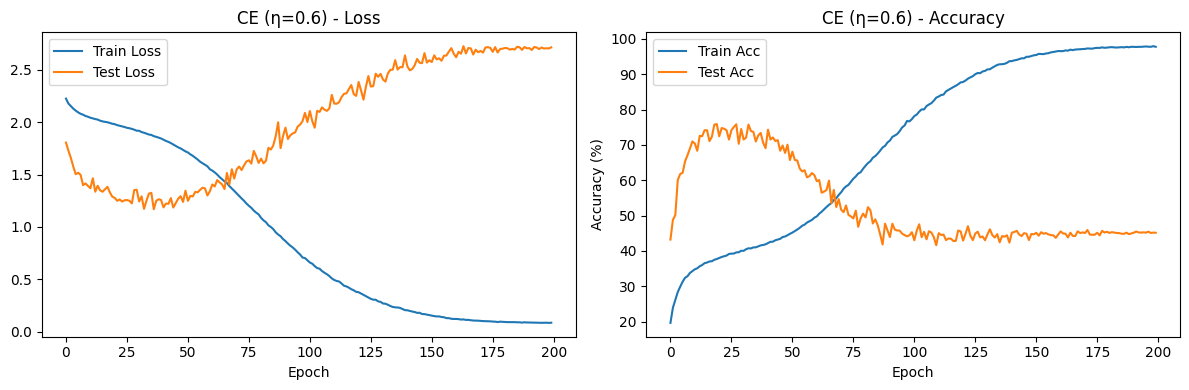

 - MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.98it/s]


Test Acc: 31.33% | Test Loss: 0.6938


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.77it/s]


Test Acc: 32.82% | Test Loss: 0.6736


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.07it/s]


Test Acc: 37.93% | Test Loss: 0.6267


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.49it/s]


Test Acc: 36.45% | Test Loss: 0.6373


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.60it/s]


Test Acc: 38.83% | Test Loss: 0.6146


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.82it/s]


Test Acc: 39.69% | Test Loss: 0.6041


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.83it/s]


Test Acc: 40.88% | Test Loss: 0.5931


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.60it/s]


Test Acc: 40.92% | Test Loss: 0.5923


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.28it/s]


Test Acc: 41.44% | Test Loss: 0.5859


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.98it/s]


Test Acc: 43.27% | Test Loss: 0.5688


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.95it/s]


Test Acc: 44.13% | Test Loss: 0.5605


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.22it/s]


Test Acc: 44.15% | Test Loss: 0.5602


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.57it/s]


Test Acc: 43.94% | Test Loss: 0.5614


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.19it/s]


Test Acc: 44.09% | Test Loss: 0.5604


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.28it/s]


Test Acc: 44.91% | Test Loss: 0.5536


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.50it/s]


Test Acc: 44.17% | Test Loss: 0.5575


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.02it/s]


Test Acc: 44.12% | Test Loss: 0.5594


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.52it/s]


Test Acc: 43.71% | Test Loss: 0.5632


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.18it/s]


Test Acc: 44.42% | Test Loss: 0.5564


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.48it/s]


Test Acc: 45.69% | Test Loss: 0.5429


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.61it/s]


Test Acc: 44.56% | Test Loss: 0.5548


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.39it/s]


Test Acc: 45.90% | Test Loss: 0.5407


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.20it/s]


Test Acc: 42.09% | Test Loss: 0.5787


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.25it/s]


Test Acc: 44.19% | Test Loss: 0.5576


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.11it/s]


Test Acc: 45.80% | Test Loss: 0.5413


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.94it/s]


Test Acc: 44.46% | Test Loss: 0.5553


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.02it/s]


Test Acc: 45.30% | Test Loss: 0.5475


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.07it/s]


Test Acc: 46.37% | Test Loss: 0.5354


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.07it/s]


Test Acc: 46.69% | Test Loss: 0.5337


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.65it/s]


Test Acc: 46.20% | Test Loss: 0.5389


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.84it/s]


Test Acc: 47.46% | Test Loss: 0.5261


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.77it/s]


Test Acc: 46.80% | Test Loss: 0.5326


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.28it/s]


Test Acc: 45.30% | Test Loss: 0.5464


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.62it/s]


Test Acc: 46.89% | Test Loss: 0.5304


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.64it/s]


Test Acc: 46.52% | Test Loss: 0.5372


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.79it/s]


Test Acc: 46.11% | Test Loss: 0.5386


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.69it/s]


Test Acc: 45.92% | Test Loss: 0.5411


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.15it/s]


Test Acc: 47.49% | Test Loss: 0.5252


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.06it/s]


Test Acc: 47.40% | Test Loss: 0.5265


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.62it/s]


Test Acc: 46.78% | Test Loss: 0.5322


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.35it/s]


Test Acc: 46.46% | Test Loss: 0.5348


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 103.84it/s]


Test Acc: 46.46% | Test Loss: 0.5352


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.22it/s]


Test Acc: 46.00% | Test Loss: 0.5395


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.40it/s]


Test Acc: 47.49% | Test Loss: 0.5258


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.25it/s]


Test Acc: 47.85% | Test Loss: 0.5221


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 103.54it/s]


Test Acc: 47.88% | Test Loss: 0.5222


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.23it/s]


Test Acc: 45.56% | Test Loss: 0.5436


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.78it/s]


Test Acc: 47.99% | Test Loss: 0.5219


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.28it/s]


Test Acc: 48.56% | Test Loss: 0.5158


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.65it/s]


Test Acc: 47.82% | Test Loss: 0.5228


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.41it/s]


Test Acc: 48.66% | Test Loss: 0.5139


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.22it/s]


Test Acc: 48.59% | Test Loss: 0.5140


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.70it/s]


Test Acc: 49.10% | Test Loss: 0.5087


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.30it/s]


Test Acc: 47.90% | Test Loss: 0.5209


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.15it/s]


Test Acc: 48.75% | Test Loss: 0.5121


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.17it/s]


Test Acc: 48.48% | Test Loss: 0.5152


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 103.64it/s]


Test Acc: 48.65% | Test Loss: 0.5140


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.42it/s]


Test Acc: 48.76% | Test Loss: 0.5132


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.22it/s]


Test Acc: 48.69% | Test Loss: 0.5133


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.73it/s]


Test Acc: 48.92% | Test Loss: 0.5114


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.14it/s]


Test Acc: 49.03% | Test Loss: 0.5102


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.01it/s]


Test Acc: 47.93% | Test Loss: 0.5210


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.49it/s]


Test Acc: 49.00% | Test Loss: 0.5101


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.52it/s]


Test Acc: 48.88% | Test Loss: 0.5117


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.96it/s]


Test Acc: 48.88% | Test Loss: 0.5133


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 103.25it/s]


Test Acc: 48.30% | Test Loss: 0.5172


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.56it/s]


Test Acc: 48.57% | Test Loss: 0.5164


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.94it/s]


Test Acc: 49.27% | Test Loss: 0.5076


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.54it/s]


Test Acc: 49.03% | Test Loss: 0.5094


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.92it/s]


Test Acc: 48.62% | Test Loss: 0.5144


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.23it/s]


Test Acc: 49.45% | Test Loss: 0.5066


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.28it/s]


Test Acc: 49.48% | Test Loss: 0.5052


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.91it/s]


Test Acc: 48.82% | Test Loss: 0.5114


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.93it/s]


Test Acc: 49.25% | Test Loss: 0.5086


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.53it/s]


Test Acc: 50.12% | Test Loss: 0.4990


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.30it/s]


Test Acc: 49.35% | Test Loss: 0.5065


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.03it/s]


Test Acc: 49.69% | Test Loss: 0.5040


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.00it/s]


Test Acc: 50.10% | Test Loss: 0.4993


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.30it/s]


Test Acc: 49.68% | Test Loss: 0.5040


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.26it/s]


Test Acc: 50.00% | Test Loss: 0.5007


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.68it/s]


Test Acc: 49.67% | Test Loss: 0.5036


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.91it/s]


Test Acc: 50.34% | Test Loss: 0.4969


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.65it/s]


Test Acc: 50.07% | Test Loss: 0.4993


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.99it/s]


Test Acc: 49.70% | Test Loss: 0.5028


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.42it/s]


Test Acc: 52.94% | Test Loss: 0.4746


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.22it/s]


Test Acc: 53.61% | Test Loss: 0.4678


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.82it/s]


Test Acc: 53.93% | Test Loss: 0.4641


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.24it/s]


Test Acc: 55.07% | Test Loss: 0.4538


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.65it/s]


Test Acc: 53.78% | Test Loss: 0.4637


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 103.42it/s]


Test Acc: 55.31% | Test Loss: 0.4520


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.49it/s]


Test Acc: 54.53% | Test Loss: 0.4575


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.71it/s]


Test Acc: 55.90% | Test Loss: 0.4444


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.36it/s]


Test Acc: 55.62% | Test Loss: 0.4461


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.25it/s]


Test Acc: 56.02% | Test Loss: 0.4427


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.23it/s]


Test Acc: 56.42% | Test Loss: 0.4415


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.55it/s]


Test Acc: 56.19% | Test Loss: 0.4398


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.27it/s]


Test Acc: 56.54% | Test Loss: 0.4391


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.33it/s]


Test Acc: 56.26% | Test Loss: 0.4415


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.25it/s]


Test Acc: 56.17% | Test Loss: 0.4411


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.84it/s]


Test Acc: 56.28% | Test Loss: 0.4404


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.12it/s]


Test Acc: 55.99% | Test Loss: 0.4422


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.73it/s]


Test Acc: 55.80% | Test Loss: 0.4453


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.41it/s]


Test Acc: 56.73% | Test Loss: 0.4343


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.28it/s]


Test Acc: 54.94% | Test Loss: 0.4531


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.00it/s]


Test Acc: 56.41% | Test Loss: 0.4380


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.66it/s]


Test Acc: 56.80% | Test Loss: 0.4355


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.03it/s]


Test Acc: 56.52% | Test Loss: 0.4379


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.98it/s]


Test Acc: 56.95% | Test Loss: 0.4338


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.84it/s]


Test Acc: 56.41% | Test Loss: 0.4398


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.94it/s]


Test Acc: 56.65% | Test Loss: 0.4370


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.27it/s]


Test Acc: 57.74% | Test Loss: 0.4252


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.85it/s]


Test Acc: 61.89% | Test Loss: 0.3883


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.13it/s]


Test Acc: 63.31% | Test Loss: 0.3740


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.61it/s]


Test Acc: 63.07% | Test Loss: 0.3746


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.93it/s]


Test Acc: 63.13% | Test Loss: 0.3729


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.76it/s]


Test Acc: 63.95% | Test Loss: 0.3655


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.11it/s]


Test Acc: 63.87% | Test Loss: 0.3674


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.51it/s]


Test Acc: 63.67% | Test Loss: 0.3675


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.60it/s]


Test Acc: 63.67% | Test Loss: 0.3673


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.75it/s]


Test Acc: 64.03% | Test Loss: 0.3620


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.47it/s]


Test Acc: 64.49% | Test Loss: 0.3598


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.24it/s]


Test Acc: 64.07% | Test Loss: 0.3628


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.19it/s]


Test Acc: 65.03% | Test Loss: 0.3532


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.48it/s]


Test Acc: 64.80% | Test Loss: 0.3549


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.40it/s]


Test Acc: 65.11% | Test Loss: 0.3532


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.27it/s]


Test Acc: 65.17% | Test Loss: 0.3527


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.03it/s]


Test Acc: 64.76% | Test Loss: 0.3560


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.03it/s]


Test Acc: 65.69% | Test Loss: 0.3469


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.05it/s]


Test Acc: 64.82% | Test Loss: 0.3558


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.22it/s]


Test Acc: 65.03% | Test Loss: 0.3518


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.03it/s]


Test Acc: 65.47% | Test Loss: 0.3498


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.65it/s]


Test Acc: 65.88% | Test Loss: 0.3463


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.10it/s]


Test Acc: 65.53% | Test Loss: 0.3497


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.86it/s]


Test Acc: 65.22% | Test Loss: 0.3510


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.95it/s]


Test Acc: 65.49% | Test Loss: 0.3488


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.17it/s]


Test Acc: 65.78% | Test Loss: 0.3453


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.16it/s]


Test Acc: 65.54% | Test Loss: 0.3484


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.50it/s]


Test Acc: 65.87% | Test Loss: 0.3459


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.94it/s]


Test Acc: 65.80% | Test Loss: 0.3457


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.00it/s]


Test Acc: 66.13% | Test Loss: 0.3440


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.80it/s]


Test Acc: 65.49% | Test Loss: 0.3496


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.04it/s]


Test Acc: 65.32% | Test Loss: 0.3503


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.64it/s]


Test Acc: 65.69% | Test Loss: 0.3468


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.28it/s]


Test Acc: 66.07% | Test Loss: 0.3428


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.40it/s]


Test Acc: 65.62% | Test Loss: 0.3480


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.00it/s]


Test Acc: 65.60% | Test Loss: 0.3468


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.03it/s]


Test Acc: 65.73% | Test Loss: 0.3463


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.77it/s]


Test Acc: 66.10% | Test Loss: 0.3443


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.06it/s]


Test Acc: 65.32% | Test Loss: 0.3512


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.47it/s]


Test Acc: 65.51% | Test Loss: 0.3498


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.12it/s]


Test Acc: 65.37% | Test Loss: 0.3504


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.00it/s]


Test Acc: 65.79% | Test Loss: 0.3453


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.68it/s]


Test Acc: 66.15% | Test Loss: 0.3433


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.80it/s]


Test Acc: 65.44% | Test Loss: 0.3505


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.16it/s]


Test Acc: 65.61% | Test Loss: 0.3455


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.53it/s]


Test Acc: 65.87% | Test Loss: 0.3454


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.65it/s]


Test Acc: 65.78% | Test Loss: 0.3458


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.19it/s]


Test Acc: 65.72% | Test Loss: 0.3460


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.96it/s]


Test Acc: 65.75% | Test Loss: 0.3472


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.80it/s]


Test Acc: 65.88% | Test Loss: 0.3449


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.55it/s]


Test Acc: 66.02% | Test Loss: 0.3444


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.31it/s]


Test Acc: 65.61% | Test Loss: 0.3475


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.63it/s]


Test Acc: 65.78% | Test Loss: 0.3451


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.83it/s]


Test Acc: 66.29% | Test Loss: 0.3417


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.31it/s]


Test Acc: 65.87% | Test Loss: 0.3444


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.71it/s]


Test Acc: 65.97% | Test Loss: 0.3428


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.13it/s]


Test Acc: 65.89% | Test Loss: 0.3452


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.97it/s]


Test Acc: 65.78% | Test Loss: 0.3456


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.38it/s]


Test Acc: 66.02% | Test Loss: 0.3433


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.50it/s]


Test Acc: 65.92% | Test Loss: 0.3449


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.80it/s]


Test Acc: 65.90% | Test Loss: 0.3444


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.83it/s]


Test Acc: 66.00% | Test Loss: 0.3435


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.04it/s]


Test Acc: 65.70% | Test Loss: 0.3456


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.25it/s]


Test Acc: 65.96% | Test Loss: 0.3447


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.18it/s]


Test Acc: 66.03% | Test Loss: 0.3443


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.02it/s]


Test Acc: 65.97% | Test Loss: 0.3438


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.09it/s]


Test Acc: 66.12% | Test Loss: 0.3434


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.46it/s]


Test Acc: 66.01% | Test Loss: 0.3437


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.66it/s]


Test Acc: 66.17% | Test Loss: 0.3425


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.45it/s]


Test Acc: 66.05% | Test Loss: 0.3435


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.10it/s]


Test Acc: 66.01% | Test Loss: 0.3439


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.33it/s]


Test Acc: 65.84% | Test Loss: 0.3461


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.52it/s]


Test Acc: 65.87% | Test Loss: 0.3455


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.57it/s]


Test Acc: 65.97% | Test Loss: 0.3449


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.03it/s]


Test Acc: 66.08% | Test Loss: 0.3447


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.35it/s]


Test Acc: 65.99% | Test Loss: 0.3451


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.12it/s]


Test Acc: 65.94% | Test Loss: 0.3444


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.99it/s]


Test Acc: 65.82% | Test Loss: 0.3457


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.12it/s]


Test Acc: 65.69% | Test Loss: 0.3460


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.03it/s]


Test Acc: 66.10% | Test Loss: 0.3444


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 103.65it/s]


Test Acc: 65.90% | Test Loss: 0.3446


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.11it/s]


Test Acc: 66.07% | Test Loss: 0.3445


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.58it/s]


Test Acc: 65.89% | Test Loss: 0.3453


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.91it/s]


Test Acc: 66.04% | Test Loss: 0.3446


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.41it/s]


Test Acc: 65.91% | Test Loss: 0.3443


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.18it/s]


Test Acc: 65.85% | Test Loss: 0.3448


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.10it/s]


Test Acc: 65.92% | Test Loss: 0.3444


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.20it/s]


Test Acc: 66.03% | Test Loss: 0.3445


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.63it/s]


Test Acc: 66.00% | Test Loss: 0.3446


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.12it/s]


Test Acc: 65.95% | Test Loss: 0.3444


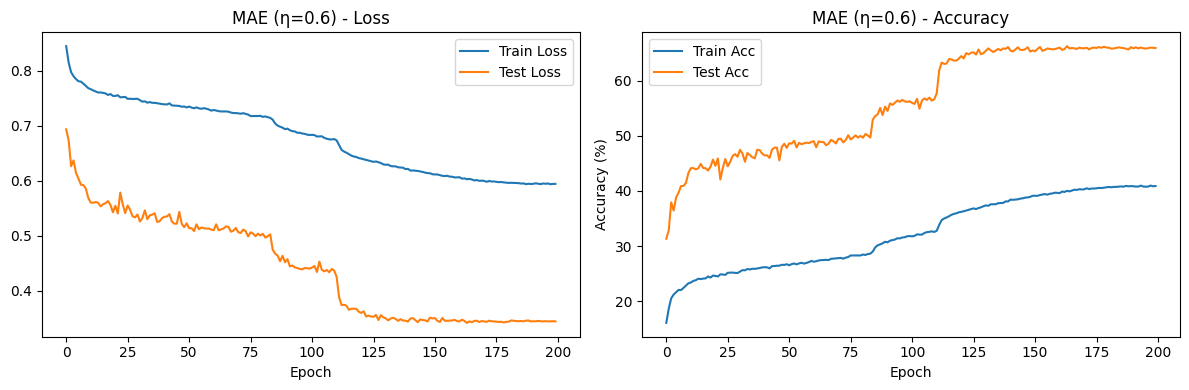

 - RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 15.16% | Test Loss: 7.8088


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 15.34% | Test Loss: 7.7939


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 15.07% | Test Loss: 7.8183


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 14.62% | Test Loss: 7.8597


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 19.61% | Test Loss: 7.4170


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 20.58% | Test Loss: 7.3209


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 17.75% | Test Loss: 7.5796


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 19.51% | Test Loss: 7.4254


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 20.55% | Test Loss: 7.3318


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 16.83% | Test Loss: 7.6627


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 16.98% | Test Loss: 7.6434


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 17.70% | Test Loss: 7.5804


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 15.85% | Test Loss: 7.7446


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 16.27% | Test Loss: 7.7082


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 16.92% | Test Loss: 7.6561


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 17.10% | Test Loss: 7.6396


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 14.63% | Test Loss: 7.8563


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 18.13% | Test Loss: 7.5461


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 12.92% | Test Loss: 8.0144


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 18.82% | Test Loss: 7.4767


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 18.90% | Test Loss: 7.4679


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 19.21% | Test Loss: 7.4477


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 21.96% | Test Loss: 7.1939


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 23.44% | Test Loss: 7.0712


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 22.25% | Test Loss: 7.1756


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 23.59% | Test Loss: 7.0535


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 22.14% | Test Loss: 7.1865


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 22.54% | Test Loss: 7.1537


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 23.77% | Test Loss: 7.0333


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 23.77% | Test Loss: 7.0388


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 21.96% | Test Loss: 7.1967


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 23.89% | Test Loss: 7.0288


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 22.12% | Test Loss: 7.1888


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 22.77% | Test Loss: 7.1269


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 21.32% | Test Loss: 7.2610


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 22.35% | Test Loss: 7.1702


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 22.15% | Test Loss: 7.1860


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 22.54% | Test Loss: 7.1515


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 23.58% | Test Loss: 7.0579


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 22.90% | Test Loss: 7.1184


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 22.79% | Test Loss: 7.1281


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 23.85% | Test Loss: 7.0313


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 23.83% | Test Loss: 7.0326


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 20.46% | Test Loss: 7.3270


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 23.89% | Test Loss: 7.0222


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 20.48% | Test Loss: 7.3323


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 24.14% | Test Loss: 7.0081


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 22.21% | Test Loss: 7.1829


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 22.40% | Test Loss: 7.1587


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 23.25% | Test Loss: 7.0794


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 20.69% | Test Loss: 7.2999


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 20.43% | Test Loss: 7.3294


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 21.89% | Test Loss: 7.1986


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 22.50% | Test Loss: 7.1438


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 21.82% | Test Loss: 7.2171


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 24.51% | Test Loss: 6.9582


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 22.73% | Test Loss: 7.1271


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 23.30% | Test Loss: 7.0670


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 23.31% | Test Loss: 7.0684


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 23.09% | Test Loss: 7.0900


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 23.27% | Test Loss: 7.0725


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 24.35% | Test Loss: 6.9853


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 24.29% | Test Loss: 6.9803


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 24.49% | Test Loss: 6.9720


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 22.55% | Test Loss: 7.1436


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 24.50% | Test Loss: 6.9657


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 23.91% | Test Loss: 7.0144


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 23.70% | Test Loss: 7.0396


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.43it/s]


Test Acc: 24.39% | Test Loss: 6.9718


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 24.60% | Test Loss: 6.9519


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 24.16% | Test Loss: 6.9985


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 24.39% | Test Loss: 6.9710


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 25.16% | Test Loss: 6.9120


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 24.85% | Test Loss: 6.9409


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 25.11% | Test Loss: 6.9179


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 23.89% | Test Loss: 7.0268


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 24.12% | Test Loss: 7.0057


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 22.67% | Test Loss: 7.1405


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 23.83% | Test Loss: 7.0335


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 23.50% | Test Loss: 7.0651


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 24.95% | Test Loss: 6.9314


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 24.64% | Test Loss: 6.9529


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 24.88% | Test Loss: 6.9393


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 24.12% | Test Loss: 7.0034


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 25.50% | Test Loss: 6.8798


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 25.53% | Test Loss: 6.8800


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 24.37% | Test Loss: 6.9751


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 24.24% | Test Loss: 6.9926


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 24.34% | Test Loss: 6.9859


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 26.09% | Test Loss: 6.8297


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 25.51% | Test Loss: 6.8805


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 23.68% | Test Loss: 7.0458


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 22.76% | Test Loss: 7.1253


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 24.23% | Test Loss: 6.9841


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 24.95% | Test Loss: 6.9293


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 24.13% | Test Loss: 7.0045


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 23.95% | Test Loss: 7.0227


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 24.73% | Test Loss: 6.9387


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 25.48% | Test Loss: 6.8757


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 25.19% | Test Loss: 6.9098


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 24.54% | Test Loss: 6.9686


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 25.31% | Test Loss: 6.8898


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 24.95% | Test Loss: 6.9333


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.52it/s]


Test Acc: 26.36% | Test Loss: 6.8037


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 25.19% | Test Loss: 6.9068


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 26.15% | Test Loss: 6.8227


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 25.76% | Test Loss: 6.8510


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 25.28% | Test Loss: 6.8947


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 25.11% | Test Loss: 6.9034


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 26.37% | Test Loss: 6.7965


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 25.48% | Test Loss: 6.8703


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 25.47% | Test Loss: 6.8789


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 25.92% | Test Loss: 6.8374


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 26.27% | Test Loss: 6.7985


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 26.37% | Test Loss: 6.7915


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 26.20% | Test Loss: 6.8045


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 25.88% | Test Loss: 6.8366


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 26.04% | Test Loss: 6.8276


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 26.32% | Test Loss: 6.7946


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 26.18% | Test Loss: 6.8176


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 26.71% | Test Loss: 6.7708


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 26.59% | Test Loss: 6.7680


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 26.45% | Test Loss: 6.7869


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 25.63% | Test Loss: 6.8699


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 26.63% | Test Loss: 6.7727


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 25.79% | Test Loss: 6.8545


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 26.45% | Test Loss: 6.7870


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 26.62% | Test Loss: 6.7736


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 26.38% | Test Loss: 6.8014


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 26.36% | Test Loss: 6.8022


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 26.42% | Test Loss: 6.7991


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 26.52% | Test Loss: 6.7767


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 27.07% | Test Loss: 6.7247


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 26.55% | Test Loss: 6.7788


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 26.25% | Test Loss: 6.8081


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 26.35% | Test Loss: 6.7972


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 26.34% | Test Loss: 6.7913


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 26.99% | Test Loss: 6.7413


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 26.53% | Test Loss: 6.7840


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 26.84% | Test Loss: 6.7561


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 27.58% | Test Loss: 6.6833


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 27.54% | Test Loss: 6.6854


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 27.25% | Test Loss: 6.7126


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 27.42% | Test Loss: 6.7001


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.63it/s]


Test Acc: 27.59% | Test Loss: 6.6775


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 27.69% | Test Loss: 6.6761


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 27.76% | Test Loss: 6.6614


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 27.24% | Test Loss: 6.7106


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.49it/s]


Test Acc: 27.31% | Test Loss: 6.7119


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 27.30% | Test Loss: 6.7205


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 26.98% | Test Loss: 6.7463


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 27.09% | Test Loss: 6.7244


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 27.55% | Test Loss: 6.6830


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 27.64% | Test Loss: 6.6805


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 27.56% | Test Loss: 6.6894


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 27.22% | Test Loss: 6.7183


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 27.07% | Test Loss: 6.7336


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 27.22% | Test Loss: 6.7204


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 27.12% | Test Loss: 6.7272


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 27.53% | Test Loss: 6.6910


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 27.53% | Test Loss: 6.6912


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 27.55% | Test Loss: 6.6873


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 27.73% | Test Loss: 6.6715


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 27.61% | Test Loss: 6.6825


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 27.48% | Test Loss: 6.6925


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 27.76% | Test Loss: 6.6678


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 27.85% | Test Loss: 6.6627


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 27.94% | Test Loss: 6.6531


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 27.90% | Test Loss: 6.6551


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 27.99% | Test Loss: 6.6500


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 28.01% | Test Loss: 6.6462


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 27.95% | Test Loss: 6.6515


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 27.94% | Test Loss: 6.6523


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 27.88% | Test Loss: 6.6581


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 27.90% | Test Loss: 6.6534


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 27.95% | Test Loss: 6.6497


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 28.02% | Test Loss: 6.6422


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 27.92% | Test Loss: 6.6522


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 27.96% | Test Loss: 6.6473


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 27.92% | Test Loss: 6.6537


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 28.03% | Test Loss: 6.6440


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 27.94% | Test Loss: 6.6504


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 28.00% | Test Loss: 6.6463


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 28.06% | Test Loss: 6.6382


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 28.21% | Test Loss: 6.6283


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 28.17% | Test Loss: 6.6313


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 28.15% | Test Loss: 6.6322


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 28.12% | Test Loss: 6.6334


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 28.13% | Test Loss: 6.6353


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 28.12% | Test Loss: 6.6368


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 28.01% | Test Loss: 6.6429


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 28.14% | Test Loss: 6.6327


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 28.14% | Test Loss: 6.6327


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 28.11% | Test Loss: 6.6354


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 28.10% | Test Loss: 6.6380


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 28.11% | Test Loss: 6.6377


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 28.11% | Test Loss: 6.6329


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 28.10% | Test Loss: 6.6369


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 28.10% | Test Loss: 6.6390


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 28.03% | Test Loss: 6.6416


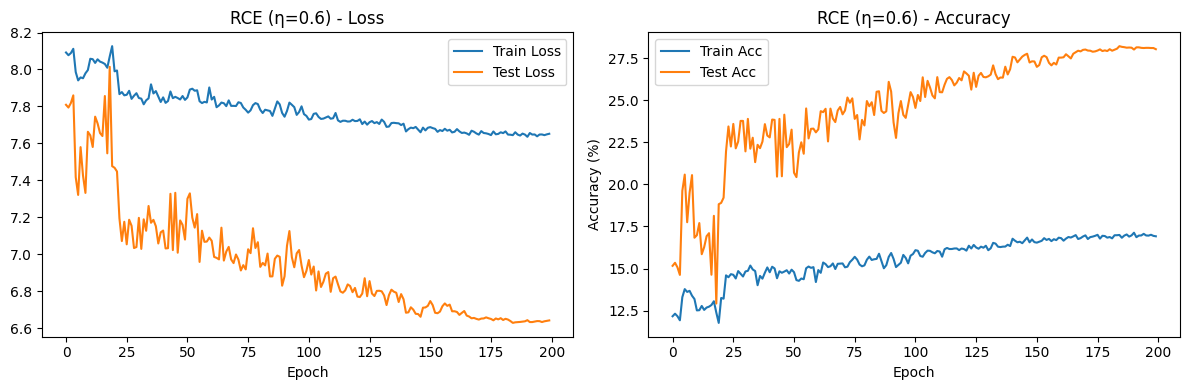


Training normalized Losses...
 - NCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 36.91% | Test Loss: 0.0456


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 39.32% | Test Loss: 0.0346


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 38.38% | Test Loss: 0.0317


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 41.93% | Test Loss: 0.0268


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 42.96% | Test Loss: 0.0251


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 42.16% | Test Loss: 0.0245


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 43.82% | Test Loss: 0.0231


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 43.12% | Test Loss: 0.0232


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 43.58% | Test Loss: 0.0228


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 43.95% | Test Loss: 0.0215


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 47.63% | Test Loss: 0.0186


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 45.78% | Test Loss: 0.0194


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 46.18% | Test Loss: 0.0179


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 47.92% | Test Loss: 0.0179


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 46.75% | Test Loss: 0.0196


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 48.42% | Test Loss: 0.0164


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 49.61% | Test Loss: 0.0160


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 50.14% | Test Loss: 0.0162


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 50.70% | Test Loss: 0.0168


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 51.91% | Test Loss: 0.0151


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 51.50% | Test Loss: 0.0144


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 51.85% | Test Loss: 0.0142


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 51.50% | Test Loss: 0.0154


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 53.14% | Test Loss: 0.0144


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 53.91% | Test Loss: 0.0136


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 49.23% | Test Loss: 0.0169


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 53.40% | Test Loss: 0.0132


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 52.71% | Test Loss: 0.0149


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 53.74% | Test Loss: 0.0136


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 54.71% | Test Loss: 0.0130


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 55.36% | Test Loss: 0.0134


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 54.56% | Test Loss: 0.0132


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 53.11% | Test Loss: 0.0130


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 55.25% | Test Loss: 0.0124


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 55.42% | Test Loss: 0.0131


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 56.40% | Test Loss: 0.0120


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 56.85% | Test Loss: 0.0118


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 56.59% | Test Loss: 0.0125


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 56.94% | Test Loss: 0.0126


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 56.36% | Test Loss: 0.0124


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 57.47% | Test Loss: 0.0117


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 56.62% | Test Loss: 0.0120


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 57.33% | Test Loss: 0.0117


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 55.30% | Test Loss: 0.0122


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 56.92% | Test Loss: 0.0121


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 55.35% | Test Loss: 0.0125


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 55.62% | Test Loss: 0.0123


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 57.00% | Test Loss: 0.0124


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 56.27% | Test Loss: 0.0115


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 55.07% | Test Loss: 0.0132


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 56.63% | Test Loss: 0.0117


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 57.86% | Test Loss: 0.0126


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 57.19% | Test Loss: 0.0127


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 53.38% | Test Loss: 0.0139


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 53.95% | Test Loss: 0.0142


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 56.35% | Test Loss: 0.0126


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 57.51% | Test Loss: 0.0119


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 56.28% | Test Loss: 0.0127


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 57.71% | Test Loss: 0.0113


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 53.97% | Test Loss: 0.0122


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 56.36% | Test Loss: 0.0125


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 55.07% | Test Loss: 0.0145


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 53.15% | Test Loss: 0.0164


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 58.14% | Test Loss: 0.0126


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 57.03% | Test Loss: 0.0130


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 55.31% | Test Loss: 0.0131


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 56.85% | Test Loss: 0.0116


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 55.65% | Test Loss: 0.0125


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 55.11% | Test Loss: 0.0118


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 57.89% | Test Loss: 0.0125


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 53.65% | Test Loss: 0.0136


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 54.38% | Test Loss: 0.0123


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 56.36% | Test Loss: 0.0131


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 56.48% | Test Loss: 0.0110


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 55.00% | Test Loss: 0.0137


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 54.72% | Test Loss: 0.0124


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 57.54% | Test Loss: 0.0131


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 54.70% | Test Loss: 0.0126


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 55.98% | Test Loss: 0.0118


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 54.51% | Test Loss: 0.0124


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 56.44% | Test Loss: 0.0117


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 55.31% | Test Loss: 0.0135


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 56.09% | Test Loss: 0.0142


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 54.42% | Test Loss: 0.0161


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 55.00% | Test Loss: 0.0142


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 53.50% | Test Loss: 0.0139


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 56.82% | Test Loss: 0.0141


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 53.88% | Test Loss: 0.0115


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 53.10% | Test Loss: 0.0179


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 53.95% | Test Loss: 0.0131


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 55.01% | Test Loss: 0.0139


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 56.45% | Test Loss: 0.0128


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 53.73% | Test Loss: 0.0140


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 53.59% | Test Loss: 0.0167


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 56.07% | Test Loss: 0.0136


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 53.27% | Test Loss: 0.0145


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 54.62% | Test Loss: 0.0127


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 57.03% | Test Loss: 0.0123


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 55.16% | Test Loss: 0.0174


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 57.26% | Test Loss: 0.0144


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 52.92% | Test Loss: 0.0146


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 55.18% | Test Loss: 0.0155


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 56.15% | Test Loss: 0.0135


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 54.21% | Test Loss: 0.0128


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 55.30% | Test Loss: 0.0144


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 56.20% | Test Loss: 0.0160


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 55.01% | Test Loss: 0.0117


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 55.58% | Test Loss: 0.0141


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 50.94% | Test Loss: 0.0156


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 50.46% | Test Loss: 0.0163


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 56.97% | Test Loss: 0.0130


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 54.32% | Test Loss: 0.0169


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 53.52% | Test Loss: 0.0155


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 54.75% | Test Loss: 0.0160


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 53.76% | Test Loss: 0.0157


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 50.94% | Test Loss: 0.0149


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 53.95% | Test Loss: 0.0152


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 54.52% | Test Loss: 0.0154


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 54.31% | Test Loss: 0.0139


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 53.92% | Test Loss: 0.0137


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 55.40% | Test Loss: 0.0193


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 54.42% | Test Loss: 0.0169


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 54.50% | Test Loss: 0.0172


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 53.82% | Test Loss: 0.0155


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 54.52% | Test Loss: 0.0149


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 55.37% | Test Loss: 0.0182


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 53.42% | Test Loss: 0.0133


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 55.89% | Test Loss: 0.0141


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 55.50% | Test Loss: 0.0162


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 53.71% | Test Loss: 0.0150


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 53.66% | Test Loss: 0.0148


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 53.66% | Test Loss: 0.0137


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 56.11% | Test Loss: 0.0165


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 55.37% | Test Loss: 0.0161


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 55.80% | Test Loss: 0.0161


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 55.37% | Test Loss: 0.0156


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 53.90% | Test Loss: 0.0163


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 54.92% | Test Loss: 0.0148


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 56.92% | Test Loss: 0.0151


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 55.13% | Test Loss: 0.0153


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 54.15% | Test Loss: 0.0150


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 54.70% | Test Loss: 0.0189


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 54.15% | Test Loss: 0.0157


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 53.20% | Test Loss: 0.0156


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 54.87% | Test Loss: 0.0180


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 53.48% | Test Loss: 0.0162


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 53.50% | Test Loss: 0.0160


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 54.44% | Test Loss: 0.0148


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 53.26% | Test Loss: 0.0165


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 55.08% | Test Loss: 0.0159


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 51.51% | Test Loss: 0.0170


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 54.36% | Test Loss: 0.0176


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 54.39% | Test Loss: 0.0174


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 54.54% | Test Loss: 0.0136


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 53.92% | Test Loss: 0.0186


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 54.41% | Test Loss: 0.0185


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 54.43% | Test Loss: 0.0160


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 54.68% | Test Loss: 0.0166


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 53.87% | Test Loss: 0.0159


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 52.81% | Test Loss: 0.0182


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 53.93% | Test Loss: 0.0152


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 54.54% | Test Loss: 0.0165


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 52.59% | Test Loss: 0.0146


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 53.99% | Test Loss: 0.0157


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 53.81% | Test Loss: 0.0173


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.41it/s]


Test Acc: 52.66% | Test Loss: 0.0165


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 52.70% | Test Loss: 0.0148


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 53.30% | Test Loss: 0.0172


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 53.14% | Test Loss: 0.0185


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 53.32% | Test Loss: 0.0180


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 52.52% | Test Loss: 0.0186


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 53.18% | Test Loss: 0.0161


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 53.59% | Test Loss: 0.0184


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 53.30% | Test Loss: 0.0164


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 52.51% | Test Loss: 0.0180


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 53.00% | Test Loss: 0.0167


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 53.76% | Test Loss: 0.0154


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 53.32% | Test Loss: 0.0174


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 53.50% | Test Loss: 0.0172


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 53.20% | Test Loss: 0.0176


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 53.11% | Test Loss: 0.0169


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 53.05% | Test Loss: 0.0168


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 53.27% | Test Loss: 0.0180


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 53.23% | Test Loss: 0.0163


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 53.59% | Test Loss: 0.0168


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 52.77% | Test Loss: 0.0174


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 52.63% | Test Loss: 0.0175


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 53.20% | Test Loss: 0.0168


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 53.07% | Test Loss: 0.0175


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 52.97% | Test Loss: 0.0164


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 53.45% | Test Loss: 0.0165


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 53.23% | Test Loss: 0.0167


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 53.18% | Test Loss: 0.0171


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 53.49% | Test Loss: 0.0170


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 53.35% | Test Loss: 0.0170


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 53.56% | Test Loss: 0.0175


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 53.32% | Test Loss: 0.0169


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 53.33% | Test Loss: 0.0171


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 53.29% | Test Loss: 0.0169


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 53.17% | Test Loss: 0.0170


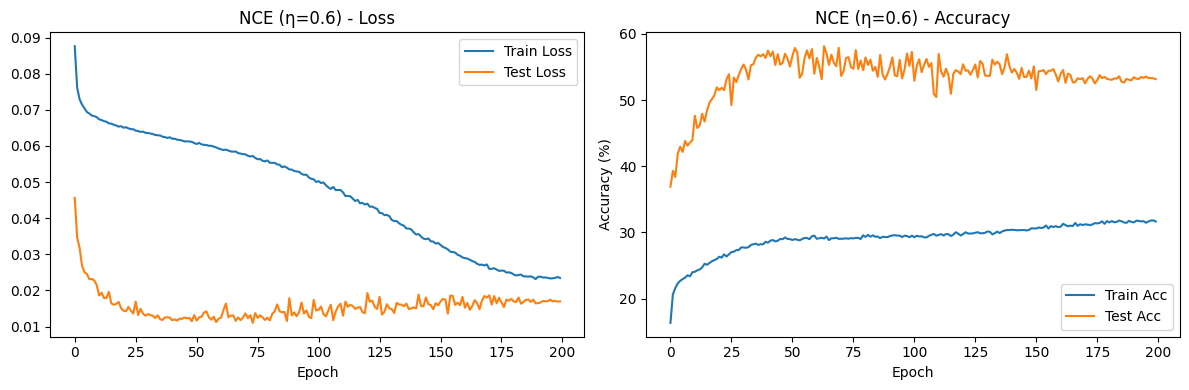

 - NRCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.83it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.50it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 12.03% | Test Loss: 18.2230


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 18.14% | Test Loss: 16.9566


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 19.03% | Test Loss: 16.7745


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 18.78% | Test Loss: 16.7874


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 21.09% | Test Loss: 16.3191


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 18.66% | Test Loss: 16.8410


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 15.09% | Test Loss: 17.5834


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 16.86% | Test Loss: 17.2219


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 16.53% | Test Loss: 17.2934


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.62it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.99it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.73it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.72it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.53it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.40it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.85it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.48it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.44it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.69it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.47it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.65it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.51it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 10.00% | Test Loss: 18.6739


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 10.00% | Test Loss: 18.6739


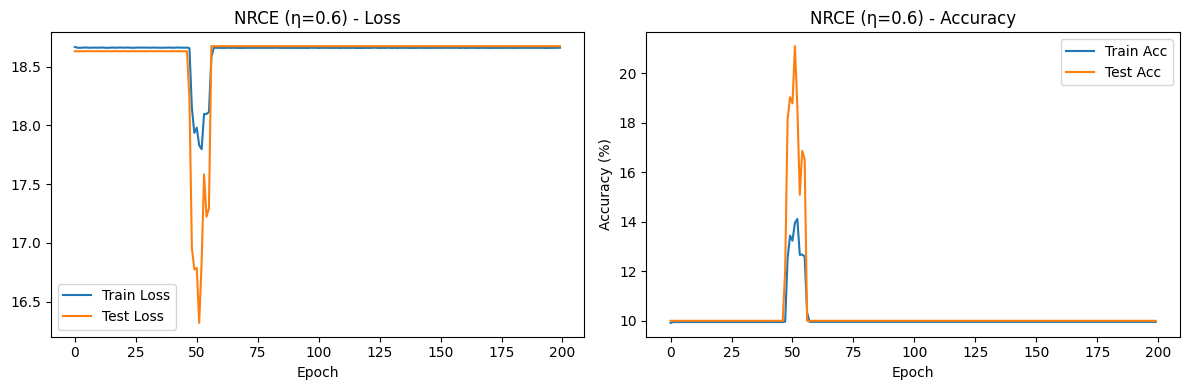

 - NFL


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 30.46% | Test Loss: 0.3634


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 38.30% | Test Loss: 0.2158


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 39.79% | Test Loss: 0.2004


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 41.93% | Test Loss: 0.2195


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 42.56% | Test Loss: 0.1745


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 40.46% | Test Loss: 0.2143


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 44.49% | Test Loss: 0.1570


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 42.80% | Test Loss: 0.1428


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 42.53% | Test Loss: 0.1461


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 45.35% | Test Loss: 0.1422


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 48.43% | Test Loss: 0.1148


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 44.65% | Test Loss: 0.1386


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 45.37% | Test Loss: 0.1310


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 49.34% | Test Loss: 0.1036


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 46.31% | Test Loss: 0.1355


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 48.99% | Test Loss: 0.1187


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 41.18% | Test Loss: 0.1290


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 48.54% | Test Loss: 0.1093


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 48.53% | Test Loss: 0.1018


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 48.10% | Test Loss: 0.0952


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 49.17% | Test Loss: 0.1045


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 49.82% | Test Loss: 0.0887


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 47.25% | Test Loss: 0.1098


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 51.42% | Test Loss: 0.0916


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 49.55% | Test Loss: 0.1082


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 48.14% | Test Loss: 0.0901


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 48.97% | Test Loss: 0.0880


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 50.69% | Test Loss: 0.1071


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 46.21% | Test Loss: 0.0958


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 46.06% | Test Loss: 0.0930


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 49.12% | Test Loss: 0.0862


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 45.77% | Test Loss: 0.0919


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 49.62% | Test Loss: 0.1264


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 44.76% | Test Loss: 0.0983


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 48.43% | Test Loss: 0.1018


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 51.03% | Test Loss: 0.0867


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 44.40% | Test Loss: 0.0892


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 51.17% | Test Loss: 0.0998


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 45.24% | Test Loss: 0.1040


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 51.75% | Test Loss: 0.0914


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 47.98% | Test Loss: 0.0910


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 50.80% | Test Loss: 0.0955


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 42.84% | Test Loss: 0.1065


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 48.15% | Test Loss: 0.0874


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 50.20% | Test Loss: 0.0780


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 51.02% | Test Loss: 0.1049


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 49.85% | Test Loss: 0.0901


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 50.30% | Test Loss: 0.1038


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 47.89% | Test Loss: 0.0947


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 51.35% | Test Loss: 0.0843


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 48.89% | Test Loss: 0.1025


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 44.54% | Test Loss: 0.0940


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 53.05% | Test Loss: 0.0873


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 50.62% | Test Loss: 0.0841


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 50.94% | Test Loss: 0.0918


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 50.82% | Test Loss: 0.0985


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 52.62% | Test Loss: 0.0846


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 51.97% | Test Loss: 0.0811


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 53.88% | Test Loss: 0.0942


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 51.74% | Test Loss: 0.0786


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 51.23% | Test Loss: 0.0841


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 53.19% | Test Loss: 0.0878


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 51.84% | Test Loss: 0.0749


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 50.75% | Test Loss: 0.0970


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 55.05% | Test Loss: 0.0889


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 51.61% | Test Loss: 0.0999


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 49.66% | Test Loss: 0.0794


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 51.48% | Test Loss: 0.0755


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 49.34% | Test Loss: 0.1084


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 47.98% | Test Loss: 0.0850


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 55.14% | Test Loss: 0.0941


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 50.88% | Test Loss: 0.0865


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 53.70% | Test Loss: 0.0990


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 51.93% | Test Loss: 0.0827


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 49.69% | Test Loss: 0.0716


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 54.33% | Test Loss: 0.0857


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 54.98% | Test Loss: 0.0832


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 51.05% | Test Loss: 0.0912


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 53.14% | Test Loss: 0.0894


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 53.41% | Test Loss: 0.0824


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 52.50% | Test Loss: 0.0801


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 54.51% | Test Loss: 0.0910


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 54.74% | Test Loss: 0.0786


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 54.11% | Test Loss: 0.0805


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 52.96% | Test Loss: 0.0897


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 52.36% | Test Loss: 0.0846


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 54.49% | Test Loss: 0.0827


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 52.10% | Test Loss: 0.0742


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 52.91% | Test Loss: 0.0802


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 55.21% | Test Loss: 0.0899


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 53.37% | Test Loss: 0.0773


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 54.64% | Test Loss: 0.0931


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 53.82% | Test Loss: 0.0879


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 51.56% | Test Loss: 0.1037


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 53.78% | Test Loss: 0.0812


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 54.31% | Test Loss: 0.0848


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 52.47% | Test Loss: 0.0835


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 55.05% | Test Loss: 0.0862


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 55.22% | Test Loss: 0.0894


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 54.43% | Test Loss: 0.0844


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 54.43% | Test Loss: 0.0819


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 54.69% | Test Loss: 0.0720


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 54.38% | Test Loss: 0.0761


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 52.24% | Test Loss: 0.0846


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 54.22% | Test Loss: 0.0833


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 55.18% | Test Loss: 0.0735


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 54.10% | Test Loss: 0.0905


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 55.38% | Test Loss: 0.0992


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 54.93% | Test Loss: 0.0853


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 54.67% | Test Loss: 0.0811


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 54.31% | Test Loss: 0.0854


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 54.89% | Test Loss: 0.1000


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 53.97% | Test Loss: 0.0921


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 54.48% | Test Loss: 0.0850


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 55.50% | Test Loss: 0.0856


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 55.56% | Test Loss: 0.0912


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 54.01% | Test Loss: 0.0838


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 54.07% | Test Loss: 0.0884


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 55.81% | Test Loss: 0.0769


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 53.70% | Test Loss: 0.0868


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 54.21% | Test Loss: 0.0878


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 56.03% | Test Loss: 0.0801


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 55.06% | Test Loss: 0.0829


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 53.81% | Test Loss: 0.0845


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 54.73% | Test Loss: 0.0840


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 54.89% | Test Loss: 0.0858


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 54.83% | Test Loss: 0.0830


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 54.39% | Test Loss: 0.0874


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 54.70% | Test Loss: 0.0805


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 55.04% | Test Loss: 0.0776


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 53.54% | Test Loss: 0.0861


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 54.96% | Test Loss: 0.0877


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 54.96% | Test Loss: 0.0868


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 53.25% | Test Loss: 0.0832


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 54.30% | Test Loss: 0.0891


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 55.30% | Test Loss: 0.0795


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 55.79% | Test Loss: 0.0904


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 53.40% | Test Loss: 0.0761


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 54.06% | Test Loss: 0.0898


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 54.56% | Test Loss: 0.0877


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 55.84% | Test Loss: 0.0775


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 54.63% | Test Loss: 0.0813


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 55.36% | Test Loss: 0.0809


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 54.42% | Test Loss: 0.0831


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 55.20% | Test Loss: 0.0758


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 55.42% | Test Loss: 0.0804


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 54.55% | Test Loss: 0.0845


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 54.72% | Test Loss: 0.0833


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 54.39% | Test Loss: 0.0805


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 55.14% | Test Loss: 0.0845


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 54.92% | Test Loss: 0.0781


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 56.42% | Test Loss: 0.0819


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 55.80% | Test Loss: 0.0818


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 56.14% | Test Loss: 0.0785


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 55.46% | Test Loss: 0.0761


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 56.26% | Test Loss: 0.0768


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 55.18% | Test Loss: 0.0803


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 54.07% | Test Loss: 0.0809


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 54.72% | Test Loss: 0.0804


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 55.29% | Test Loss: 0.0767


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 55.27% | Test Loss: 0.0769


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 54.82% | Test Loss: 0.0808


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 53.78% | Test Loss: 0.0763


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 54.99% | Test Loss: 0.0794


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 55.94% | Test Loss: 0.0805


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 55.11% | Test Loss: 0.0796


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 54.82% | Test Loss: 0.0803


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 54.99% | Test Loss: 0.0801


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 54.85% | Test Loss: 0.0765


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 55.89% | Test Loss: 0.0782


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 54.89% | Test Loss: 0.0800


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 54.75% | Test Loss: 0.0792


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 54.94% | Test Loss: 0.0785


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 55.11% | Test Loss: 0.0776


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.34it/s]


Test Acc: 55.14% | Test Loss: 0.0770


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 55.28% | Test Loss: 0.0817


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 54.87% | Test Loss: 0.0765


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 54.73% | Test Loss: 0.0772


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 55.49% | Test Loss: 0.0774


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 55.42% | Test Loss: 0.0769


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 54.90% | Test Loss: 0.0755


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 54.78% | Test Loss: 0.0757


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 55.08% | Test Loss: 0.0755


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 54.87% | Test Loss: 0.0751


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 54.94% | Test Loss: 0.0760


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 54.62% | Test Loss: 0.0760


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 54.95% | Test Loss: 0.0764


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 54.63% | Test Loss: 0.0761


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 54.68% | Test Loss: 0.0763


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 54.96% | Test Loss: 0.0762


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 54.60% | Test Loss: 0.0762


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 54.78% | Test Loss: 0.0756


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 54.98% | Test Loss: 0.0769


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 54.96% | Test Loss: 0.0765


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 54.75% | Test Loss: 0.0767


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 54.82% | Test Loss: 0.0758


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 54.88% | Test Loss: 0.0758


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 54.79% | Test Loss: 0.0772


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 54.92% | Test Loss: 0.0767


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 54.97% | Test Loss: 0.0771


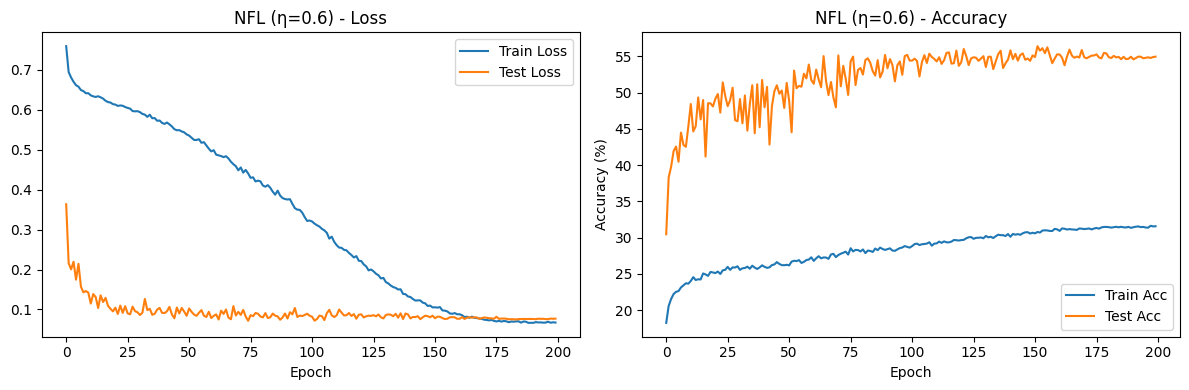


Training apl Losses...
 - NCE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 17.85% | Test Loss: 7.6601


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 18.05% | Test Loss: 7.6451


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 20.13% | Test Loss: 7.4480


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 15.67% | Test Loss: 7.8651


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 19.35% | Test Loss: 7.5338


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 17.15% | Test Loss: 7.7312


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 19.55% | Test Loss: 7.5081


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 19.39% | Test Loss: 7.5164


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 19.22% | Test Loss: 7.5262


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 17.64% | Test Loss: 7.6817


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 18.06% | Test Loss: 7.6404


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 18.34% | Test Loss: 7.6045


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 15.33% | Test Loss: 7.8892


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 17.77% | Test Loss: 7.6538


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 17.15% | Test Loss: 7.7065


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 14.50% | Test Loss: 7.9533


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 14.41% | Test Loss: 7.9579


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 14.22% | Test Loss: 7.9839


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 16.54% | Test Loss: 7.7654


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 17.22% | Test Loss: 7.6959


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 18.29% | Test Loss: 7.6020


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 19.23% | Test Loss: 7.5037


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 18.37% | Test Loss: 7.5871


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 20.41% | Test Loss: 7.4067


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 19.73% | Test Loss: 7.4639


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 20.11% | Test Loss: 7.4359


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 18.81% | Test Loss: 7.5453


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 20.00% | Test Loss: 7.4341


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 20.54% | Test Loss: 7.3737


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 21.21% | Test Loss: 7.3261


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 20.71% | Test Loss: 7.3676


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 17.77% | Test Loss: 7.6468


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 22.48% | Test Loss: 7.2036


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 22.23% | Test Loss: 7.2315


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 18.04% | Test Loss: 7.6284


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 21.22% | Test Loss: 7.3347


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 16.61% | Test Loss: 7.7505


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 21.23% | Test Loss: 7.3242


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 21.91% | Test Loss: 7.2643


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 21.63% | Test Loss: 7.2809


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 20.50% | Test Loss: 7.3854


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 21.59% | Test Loss: 7.2914


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 21.81% | Test Loss: 7.2693


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 22.43% | Test Loss: 7.2198


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 20.70% | Test Loss: 7.3758


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 21.75% | Test Loss: 7.2813


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 21.71% | Test Loss: 7.2851


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 21.12% | Test Loss: 7.3486


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 19.86% | Test Loss: 7.4630


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 21.68% | Test Loss: 7.2887


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 21.54% | Test Loss: 7.2959


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 20.81% | Test Loss: 7.3748


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 21.36% | Test Loss: 7.3122


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 22.26% | Test Loss: 7.2207


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 22.83% | Test Loss: 7.1751


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 21.07% | Test Loss: 7.3192


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 26.34% | Test Loss: 6.8679


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 25.37% | Test Loss: 6.9571


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 26.42% | Test Loss: 6.8547


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 24.89% | Test Loss: 6.9788


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 21.63% | Test Loss: 7.3089


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 22.34% | Test Loss: 7.2203


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 23.18% | Test Loss: 7.1424


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 24.66% | Test Loss: 7.0060


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 22.69% | Test Loss: 7.1914


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 21.65% | Test Loss: 7.2942


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 19.73% | Test Loss: 7.4644


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 17.15% | Test Loss: 7.7068


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 17.56% | Test Loss: 7.6707


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 19.05% | Test Loss: 7.5200


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 19.87% | Test Loss: 7.4467


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 20.30% | Test Loss: 7.4136


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 21.17% | Test Loss: 7.3240


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 20.94% | Test Loss: 7.3477


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 20.42% | Test Loss: 7.4068


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 20.93% | Test Loss: 7.3625


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 20.33% | Test Loss: 7.4092


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 22.14% | Test Loss: 7.2479


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 19.93% | Test Loss: 7.4479


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.68it/s]


Test Acc: 18.64% | Test Loss: 7.5837


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 19.94% | Test Loss: 7.4549


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 20.53% | Test Loss: 7.3969


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 20.21% | Test Loss: 7.4306


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 20.13% | Test Loss: 7.4462


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 21.88% | Test Loss: 7.2742


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 24.84% | Test Loss: 7.0000


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 25.32% | Test Loss: 6.9616


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 26.30% | Test Loss: 6.8668


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 26.60% | Test Loss: 6.8382


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 27.83% | Test Loss: 6.7248


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 26.81% | Test Loss: 6.8144


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 28.14% | Test Loss: 6.6886


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 28.17% | Test Loss: 6.6906


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 27.91% | Test Loss: 6.7108


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 27.99% | Test Loss: 6.7051


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 28.10% | Test Loss: 6.6889


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 24.01% | Test Loss: 7.0447


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 25.90% | Test Loss: 6.8785


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 26.05% | Test Loss: 6.8585


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 26.14% | Test Loss: 6.8493


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 27.15% | Test Loss: 6.7647


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 27.99% | Test Loss: 6.6877


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 27.76% | Test Loss: 6.6969


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 27.90% | Test Loss: 6.6921


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 27.35% | Test Loss: 6.7316


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 26.22% | Test Loss: 6.8361


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 27.63% | Test Loss: 6.7119


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 27.74% | Test Loss: 6.7076


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 27.44% | Test Loss: 6.7262


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 27.63% | Test Loss: 6.7076


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 26.25% | Test Loss: 6.8390


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 28.18% | Test Loss: 6.6544


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 28.22% | Test Loss: 6.6563


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 26.46% | Test Loss: 6.8235


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 29.29% | Test Loss: 6.5636


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 29.16% | Test Loss: 6.5728


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 28.93% | Test Loss: 6.5954


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 29.01% | Test Loss: 6.5691


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 28.03% | Test Loss: 6.6835


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 27.53% | Test Loss: 6.7248


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 28.84% | Test Loss: 6.5902


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 29.80% | Test Loss: 6.5332


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 29.34% | Test Loss: 6.5564


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 30.92% | Test Loss: 6.4252


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 31.91% | Test Loss: 6.3313


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 31.25% | Test Loss: 6.4002


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 30.86% | Test Loss: 6.4266


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 32.02% | Test Loss: 6.3153


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 32.31% | Test Loss: 6.2992


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 32.01% | Test Loss: 6.3211


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 32.27% | Test Loss: 6.2839


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 32.77% | Test Loss: 6.2433


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 31.84% | Test Loss: 6.3418


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 32.26% | Test Loss: 6.2980


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 31.50% | Test Loss: 6.3610


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 31.35% | Test Loss: 6.3722


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 29.87% | Test Loss: 6.5123


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 32.78% | Test Loss: 6.2443


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 31.18% | Test Loss: 6.3878


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 30.83% | Test Loss: 6.4211


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 31.32% | Test Loss: 6.3737


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 32.59% | Test Loss: 6.2636


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 32.24% | Test Loss: 6.2832


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 33.58% | Test Loss: 6.1693


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 33.25% | Test Loss: 6.1923


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 35.31% | Test Loss: 6.0024


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 35.38% | Test Loss: 6.0048


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 34.10% | Test Loss: 6.1131


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 34.36% | Test Loss: 6.0873


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 34.25% | Test Loss: 6.0973


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 34.34% | Test Loss: 6.0954


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 33.86% | Test Loss: 6.1490


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 34.28% | Test Loss: 6.0947


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 34.82% | Test Loss: 6.0502


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 34.62% | Test Loss: 6.0627


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 35.00% | Test Loss: 6.0394


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 35.66% | Test Loss: 5.9820


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 36.10% | Test Loss: 5.9260


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 36.12% | Test Loss: 5.9281


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 35.93% | Test Loss: 5.9472


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 36.12% | Test Loss: 5.9290


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 36.28% | Test Loss: 5.9094


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 36.13% | Test Loss: 5.9261


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 35.57% | Test Loss: 5.9849


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 36.83% | Test Loss: 5.8648


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 36.95% | Test Loss: 5.8545


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 36.96% | Test Loss: 5.8509


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 36.86% | Test Loss: 5.8645


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 37.22% | Test Loss: 5.8247


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 36.25% | Test Loss: 5.9117


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 36.73% | Test Loss: 5.8758


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 37.40% | Test Loss: 5.8125


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 37.83% | Test Loss: 5.7670


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 38.04% | Test Loss: 5.7515


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 37.92% | Test Loss: 5.7600


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 37.68% | Test Loss: 5.7854


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 37.64% | Test Loss: 5.7886


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 37.43% | Test Loss: 5.8060


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 38.12% | Test Loss: 5.7433


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 37.72% | Test Loss: 5.7775


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 36.97% | Test Loss: 5.8485


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 37.61% | Test Loss: 5.7922


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.46it/s]


Test Acc: 37.91% | Test Loss: 5.7682


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 38.03% | Test Loss: 5.7605


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 38.02% | Test Loss: 5.7597


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 38.21% | Test Loss: 5.7447


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 38.17% | Test Loss: 5.7461


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 38.22% | Test Loss: 5.7395


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 38.26% | Test Loss: 5.7396


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 38.08% | Test Loss: 5.7476


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 38.43% | Test Loss: 5.7317


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 38.38% | Test Loss: 5.7321


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 38.47% | Test Loss: 5.7267


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 38.38% | Test Loss: 5.7278


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 38.32% | Test Loss: 5.7352


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 38.38% | Test Loss: 5.7338


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 38.42% | Test Loss: 5.7317


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 38.42% | Test Loss: 5.7273


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 38.51% | Test Loss: 5.7207


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 38.41% | Test Loss: 5.7307


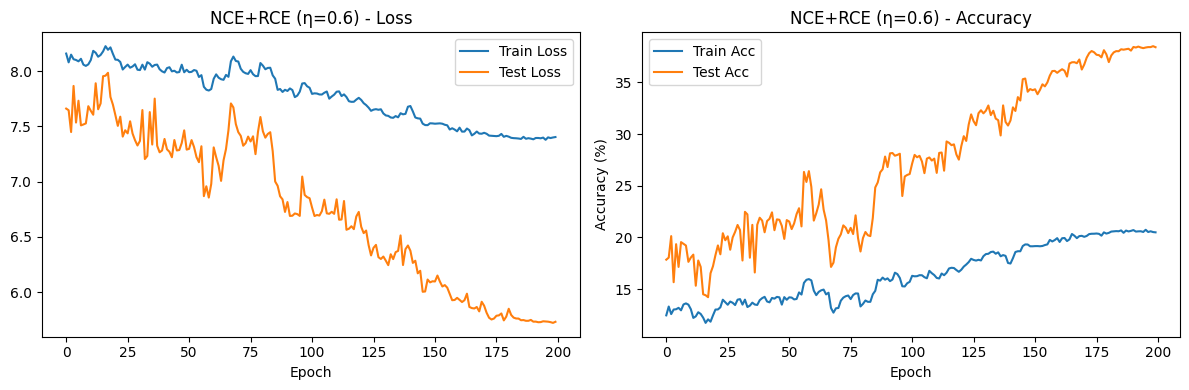

 - NCE+MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 35.21% | Test Loss: 0.7055


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 40.33% | Test Loss: 0.6419


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 48.88% | Test Loss: 0.5492


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 47.02% | Test Loss: 0.5611


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 53.42% | Test Loss: 0.4970


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 56.39% | Test Loss: 0.4630


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 57.03% | Test Loss: 0.4552


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 58.74% | Test Loss: 0.4343


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 59.56% | Test Loss: 0.4288


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 64.50% | Test Loss: 0.3761


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 67.25% | Test Loss: 0.3480


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 66.18% | Test Loss: 0.3575


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 65.34% | Test Loss: 0.3677


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 68.40% | Test Loss: 0.3331


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 69.57% | Test Loss: 0.3223


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 69.74% | Test Loss: 0.3189


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 70.25% | Test Loss: 0.3164


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 71.13% | Test Loss: 0.3028


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 69.95% | Test Loss: 0.3170


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 71.15% | Test Loss: 0.3030


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 71.18% | Test Loss: 0.3051


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 70.91% | Test Loss: 0.3062


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 72.62% | Test Loss: 0.2896


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 73.41% | Test Loss: 0.2827


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 71.95% | Test Loss: 0.2948


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 73.98% | Test Loss: 0.2758


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 75.48% | Test Loss: 0.2597


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 73.16% | Test Loss: 0.2829


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 74.08% | Test Loss: 0.2736


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 73.13% | Test Loss: 0.2846


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 74.66% | Test Loss: 0.2678


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 73.93% | Test Loss: 0.2745


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 74.68% | Test Loss: 0.2691


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 74.83% | Test Loss: 0.2660


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 77.61% | Test Loss: 0.2371


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 75.72% | Test Loss: 0.2556


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 75.72% | Test Loss: 0.2553


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 75.24% | Test Loss: 0.2605


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 75.27% | Test Loss: 0.2630


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 76.52% | Test Loss: 0.2475


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 76.86% | Test Loss: 0.2430


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 77.68% | Test Loss: 0.2346


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 75.09% | Test Loss: 0.2618


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 78.79% | Test Loss: 0.2251


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 77.23% | Test Loss: 0.2421


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 78.08% | Test Loss: 0.2321


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 77.52% | Test Loss: 0.2364


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 76.40% | Test Loss: 0.2466


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 78.98% | Test Loss: 0.2218


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 79.38% | Test Loss: 0.2183


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 77.39% | Test Loss: 0.2384


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 77.31% | Test Loss: 0.2396


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 78.87% | Test Loss: 0.2243


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 80.31% | Test Loss: 0.2086


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 78.74% | Test Loss: 0.2241


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 80.89% | Test Loss: 0.2016


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 78.90% | Test Loss: 0.2230


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 78.90% | Test Loss: 0.2216


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 79.27% | Test Loss: 0.2188


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 79.87% | Test Loss: 0.2128


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 79.89% | Test Loss: 0.2126


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 79.31% | Test Loss: 0.2187


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 78.93% | Test Loss: 0.2217


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 80.38% | Test Loss: 0.2094


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 81.05% | Test Loss: 0.1998


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 80.58% | Test Loss: 0.2044


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 81.19% | Test Loss: 0.1997


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 80.42% | Test Loss: 0.2053


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 81.42% | Test Loss: 0.1970


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 80.80% | Test Loss: 0.2033


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 81.68% | Test Loss: 0.1958


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 80.87% | Test Loss: 0.2016


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 81.50% | Test Loss: 0.1958


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 81.31% | Test Loss: 0.1963


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 80.93% | Test Loss: 0.2000


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 80.90% | Test Loss: 0.2007


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 81.10% | Test Loss: 0.1999


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 81.60% | Test Loss: 0.1941


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 81.10% | Test Loss: 0.1999


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 81.11% | Test Loss: 0.2006


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 81.40% | Test Loss: 0.1962


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 82.54% | Test Loss: 0.1865


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 80.61% | Test Loss: 0.2058


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 81.95% | Test Loss: 0.1904


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 80.58% | Test Loss: 0.2050


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 81.54% | Test Loss: 0.1947


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 81.21% | Test Loss: 0.1961


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 81.37% | Test Loss: 0.1971


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 80.96% | Test Loss: 0.2008


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 81.04% | Test Loss: 0.2001


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 81.62% | Test Loss: 0.1936


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 82.13% | Test Loss: 0.1869


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 82.01% | Test Loss: 0.1915


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 81.90% | Test Loss: 0.1920


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 81.49% | Test Loss: 0.1949


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 82.15% | Test Loss: 0.1899


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.88it/s]


Test Acc: 81.66% | Test Loss: 0.1930


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 81.97% | Test Loss: 0.1896


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 81.19% | Test Loss: 0.1963


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 81.92% | Test Loss: 0.1904


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 81.25% | Test Loss: 0.1981


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 81.47% | Test Loss: 0.1969


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 82.51% | Test Loss: 0.1860


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 82.10% | Test Loss: 0.1899


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 81.98% | Test Loss: 0.1905


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 81.21% | Test Loss: 0.1982


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 82.19% | Test Loss: 0.1883


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 81.72% | Test Loss: 0.1946


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 81.99% | Test Loss: 0.1889


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 81.89% | Test Loss: 0.1908


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 81.66% | Test Loss: 0.1948


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 81.47% | Test Loss: 0.1973


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 82.91% | Test Loss: 0.1829


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 82.06% | Test Loss: 0.1910


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 82.14% | Test Loss: 0.1897


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 82.57% | Test Loss: 0.1877


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 82.55% | Test Loss: 0.1847


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 82.46% | Test Loss: 0.1869


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 81.51% | Test Loss: 0.1981


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 81.54% | Test Loss: 0.1952


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 82.12% | Test Loss: 0.1915


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 82.26% | Test Loss: 0.1915


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 81.93% | Test Loss: 0.1922


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 82.51% | Test Loss: 0.1863


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 81.04% | Test Loss: 0.2012


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 82.24% | Test Loss: 0.1884


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 82.30% | Test Loss: 0.1882


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 82.60% | Test Loss: 0.1875


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 82.25% | Test Loss: 0.1909


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 81.80% | Test Loss: 0.1943


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 82.27% | Test Loss: 0.1884


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 82.78% | Test Loss: 0.1842


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 81.90% | Test Loss: 0.1919


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 82.57% | Test Loss: 0.1882


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 82.52% | Test Loss: 0.1851


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 82.04% | Test Loss: 0.1903


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 82.86% | Test Loss: 0.1817


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 82.31% | Test Loss: 0.1891


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 81.96% | Test Loss: 0.1903


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 81.61% | Test Loss: 0.1948


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 82.07% | Test Loss: 0.1912


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 81.87% | Test Loss: 0.1950


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 82.15% | Test Loss: 0.1896


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 81.83% | Test Loss: 0.1941


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 82.03% | Test Loss: 0.1907


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 81.71% | Test Loss: 0.1956


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 82.33% | Test Loss: 0.1880


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 82.16% | Test Loss: 0.1916


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 81.85% | Test Loss: 0.1930


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 82.22% | Test Loss: 0.1914


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 82.10% | Test Loss: 0.1911


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 82.44% | Test Loss: 0.1898


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 82.26% | Test Loss: 0.1903


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 81.93% | Test Loss: 0.1908


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 81.96% | Test Loss: 0.1928


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 81.91% | Test Loss: 0.1933


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 81.73% | Test Loss: 0.1958


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 81.83% | Test Loss: 0.1952


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 81.61% | Test Loss: 0.1965


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 81.58% | Test Loss: 0.1971


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 81.58% | Test Loss: 0.1959


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 81.69% | Test Loss: 0.1947


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 81.72% | Test Loss: 0.1960


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 81.57% | Test Loss: 0.1982


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 81.58% | Test Loss: 0.1985


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 81.59% | Test Loss: 0.1971


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 81.59% | Test Loss: 0.1963


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 81.62% | Test Loss: 0.1968


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 81.30% | Test Loss: 0.2011


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 81.42% | Test Loss: 0.1991


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 81.62% | Test Loss: 0.1978


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 81.58% | Test Loss: 0.1976


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 81.34% | Test Loss: 0.1991


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 81.31% | Test Loss: 0.1994


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 81.27% | Test Loss: 0.2003


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 81.30% | Test Loss: 0.2002


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 81.37% | Test Loss: 0.1995


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 81.23% | Test Loss: 0.2006


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 81.24% | Test Loss: 0.2010


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 81.54% | Test Loss: 0.1994


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 81.48% | Test Loss: 0.1995


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 81.39% | Test Loss: 0.1999


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 81.49% | Test Loss: 0.2003


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 81.30% | Test Loss: 0.2018


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 81.34% | Test Loss: 0.2006


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 81.33% | Test Loss: 0.2004


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 81.25% | Test Loss: 0.2021


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 81.23% | Test Loss: 0.2021


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 81.31% | Test Loss: 0.2013


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 81.28% | Test Loss: 0.2016


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 81.35% | Test Loss: 0.2008


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 81.18% | Test Loss: 0.2015


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 81.27% | Test Loss: 0.2005


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 81.34% | Test Loss: 0.2003


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 81.19% | Test Loss: 0.2013


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 81.25% | Test Loss: 0.2009


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 81.30% | Test Loss: 0.2005


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 81.32% | Test Loss: 0.2009


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 81.23% | Test Loss: 0.2014


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 81.21% | Test Loss: 0.2016


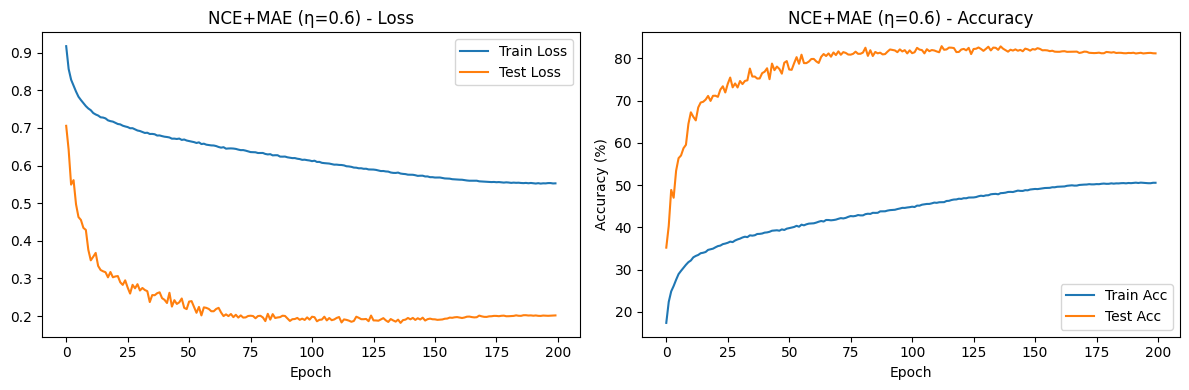

 - NFL+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 16.02% | Test Loss: 7.8343


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 12.27% | Test Loss: 8.1672


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 11.78% | Test Loss: 8.2291


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 13.76% | Test Loss: 8.0282


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 16.07% | Test Loss: 7.7946


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 17.69% | Test Loss: 7.6350


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 15.91% | Test Loss: 7.8190


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 15.34% | Test Loss: 7.8790


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 13.63% | Test Loss: 8.0404


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 16.16% | Test Loss: 7.8037


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 12.43% | Test Loss: 8.1467


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 12.80% | Test Loss: 8.1344


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 16.89% | Test Loss: 7.7311


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 16.12% | Test Loss: 7.8010


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 17.78% | Test Loss: 7.6475


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 21.70% | Test Loss: 7.2909


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 17.27% | Test Loss: 7.7032


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 17.82% | Test Loss: 7.6492


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 21.67% | Test Loss: 7.3224


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 22.73% | Test Loss: 7.1976


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 21.38% | Test Loss: 7.3144


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 17.54% | Test Loss: 7.6673


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 17.80% | Test Loss: 7.6376


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 19.18% | Test Loss: 7.5118


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 18.25% | Test Loss: 7.5940


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 14.17% | Test Loss: 7.9883


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 17.25% | Test Loss: 7.6895


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 19.61% | Test Loss: 7.4789


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 18.18% | Test Loss: 7.6139


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 19.48% | Test Loss: 7.4790


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 18.63% | Test Loss: 7.5568


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 20.41% | Test Loss: 7.3967


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 19.39% | Test Loss: 7.4988


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 21.48% | Test Loss: 7.3019


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 20.85% | Test Loss: 7.3583


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 21.71% | Test Loss: 7.2755


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 19.76% | Test Loss: 7.4584


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 22.49% | Test Loss: 7.2057


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 22.63% | Test Loss: 7.1967


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 22.93% | Test Loss: 7.1629


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 21.72% | Test Loss: 7.2843


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 20.31% | Test Loss: 7.4070


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 18.71% | Test Loss: 7.5582


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 20.35% | Test Loss: 7.4178


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 20.18% | Test Loss: 7.4231


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 21.36% | Test Loss: 7.3199


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 21.46% | Test Loss: 7.3254


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 24.18% | Test Loss: 7.0721


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 23.85% | Test Loss: 7.0998


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 24.62% | Test Loss: 7.0146


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 23.28% | Test Loss: 7.1431


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 25.41% | Test Loss: 6.9499


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 26.06% | Test Loss: 6.8762


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 16.06% | Test Loss: 7.8107


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 19.59% | Test Loss: 7.4905


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 24.84% | Test Loss: 7.0115


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.93it/s]


Test Acc: 23.90% | Test Loss: 7.0844


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 24.14% | Test Loss: 7.0615


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 23.20% | Test Loss: 7.1637


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 23.88% | Test Loss: 7.0841


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 22.55% | Test Loss: 7.2080


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 21.67% | Test Loss: 7.2972


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 22.49% | Test Loss: 7.2080


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 24.30% | Test Loss: 7.0633


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 19.31% | Test Loss: 7.5146


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 21.09% | Test Loss: 7.3530


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 23.18% | Test Loss: 7.1641


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 24.37% | Test Loss: 7.0528


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 25.40% | Test Loss: 6.9592


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 24.76% | Test Loss: 7.0219


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 24.36% | Test Loss: 7.0541


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 23.90% | Test Loss: 7.0969


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 24.82% | Test Loss: 7.0120


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 23.58% | Test Loss: 7.1224


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 23.56% | Test Loss: 7.1240


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 22.16% | Test Loss: 7.2464


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 21.57% | Test Loss: 7.2930


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 18.04% | Test Loss: 7.6487


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 23.53% | Test Loss: 7.1296


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 20.01% | Test Loss: 7.4669


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 20.10% | Test Loss: 7.4427


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 21.38% | Test Loss: 7.3358


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 22.33% | Test Loss: 7.2355


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 20.41% | Test Loss: 7.4161


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 21.19% | Test Loss: 7.3435


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 22.95% | Test Loss: 7.1787


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 22.07% | Test Loss: 7.2601


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 22.55% | Test Loss: 7.2164


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 22.21% | Test Loss: 7.2485


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 23.06% | Test Loss: 7.1684


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 22.18% | Test Loss: 7.2493


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 23.11% | Test Loss: 7.1571


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 23.55% | Test Loss: 7.1147


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 24.69% | Test Loss: 7.0128


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 25.47% | Test Loss: 6.9508


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 25.04% | Test Loss: 6.9853


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 25.52% | Test Loss: 6.9526


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 25.98% | Test Loss: 6.9021


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 25.54% | Test Loss: 6.9309


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 25.36% | Test Loss: 6.9535


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 28.10% | Test Loss: 6.7071


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 28.00% | Test Loss: 6.7185


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 27.69% | Test Loss: 6.7366


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 27.12% | Test Loss: 6.7921


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 27.44% | Test Loss: 6.7548


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 28.94% | Test Loss: 6.6185


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 28.24% | Test Loss: 6.6793


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 29.03% | Test Loss: 6.6241


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 28.70% | Test Loss: 6.6431


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 28.60% | Test Loss: 6.6601


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 29.60% | Test Loss: 6.5606


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 29.33% | Test Loss: 6.5893


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 28.33% | Test Loss: 6.6774


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 29.62% | Test Loss: 6.5661


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 29.64% | Test Loss: 6.5551


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 29.22% | Test Loss: 6.5945


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 29.53% | Test Loss: 6.5636


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 29.72% | Test Loss: 6.5476


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 30.20% | Test Loss: 6.4965


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 29.99% | Test Loss: 6.5164


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 29.59% | Test Loss: 6.5486


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 29.51% | Test Loss: 6.5619


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 27.42% | Test Loss: 6.7581


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 28.49% | Test Loss: 6.6500


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 30.41% | Test Loss: 6.4789


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 29.41% | Test Loss: 6.5735


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 30.30% | Test Loss: 6.4852


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 30.03% | Test Loss: 6.5094


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 29.74% | Test Loss: 6.5376


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 30.51% | Test Loss: 6.4638


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 31.14% | Test Loss: 6.4113


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 31.05% | Test Loss: 6.4129


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 29.74% | Test Loss: 6.5330


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 30.19% | Test Loss: 6.4953


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 30.99% | Test Loss: 6.4305


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 31.14% | Test Loss: 6.4169


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 31.17% | Test Loss: 6.4064


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 30.58% | Test Loss: 6.4573


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 30.48% | Test Loss: 6.4655


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 30.55% | Test Loss: 6.4614


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 31.04% | Test Loss: 6.4146


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 30.97% | Test Loss: 6.4201


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 30.84% | Test Loss: 6.4380


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 31.81% | Test Loss: 6.3495


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 31.62% | Test Loss: 6.3674


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 30.47% | Test Loss: 6.4788


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 32.34% | Test Loss: 6.3033


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 32.29% | Test Loss: 6.3002


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 32.30% | Test Loss: 6.3107


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.80it/s]


Test Acc: 32.29% | Test Loss: 6.3067


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 31.95% | Test Loss: 6.3292


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.83it/s]


Test Acc: 32.66% | Test Loss: 6.2713


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 32.73% | Test Loss: 6.2542


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 32.54% | Test Loss: 6.2701


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 32.41% | Test Loss: 6.2853


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 32.91% | Test Loss: 6.2374


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 32.56% | Test Loss: 6.2682


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 32.64% | Test Loss: 6.2624


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 33.05% | Test Loss: 6.2303


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 33.30% | Test Loss: 6.2141


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 33.33% | Test Loss: 6.1954


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 33.57% | Test Loss: 6.1784


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 32.78% | Test Loss: 6.2505


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 33.51% | Test Loss: 6.1931


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 33.31% | Test Loss: 6.2001


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 34.50% | Test Loss: 6.0966


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 34.44% | Test Loss: 6.0990


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 33.28% | Test Loss: 6.2081


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 34.30% | Test Loss: 6.1217


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 33.64% | Test Loss: 6.1680


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 34.67% | Test Loss: 6.0717


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 34.03% | Test Loss: 6.1323


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 34.04% | Test Loss: 6.1329


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 34.23% | Test Loss: 6.1066


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 34.08% | Test Loss: 6.1229


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 34.30% | Test Loss: 6.1064


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 34.10% | Test Loss: 6.1255


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 34.48% | Test Loss: 6.0906


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 34.74% | Test Loss: 6.0649


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.77it/s]


Test Acc: 34.65% | Test Loss: 6.0838


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 34.77% | Test Loss: 6.0640


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 34.45% | Test Loss: 6.0932


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 34.73% | Test Loss: 6.0722


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 34.81% | Test Loss: 6.0621


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 34.45% | Test Loss: 6.0863


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 34.83% | Test Loss: 6.0587


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 34.91% | Test Loss: 6.0461


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 34.75% | Test Loss: 6.0612


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 34.85% | Test Loss: 6.0603


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 34.95% | Test Loss: 6.0465


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 34.61% | Test Loss: 6.0737


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 34.75% | Test Loss: 6.0599


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 34.92% | Test Loss: 6.0509


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 34.81% | Test Loss: 6.0584


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 34.83% | Test Loss: 6.0565


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 34.92% | Test Loss: 6.0491


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 34.88% | Test Loss: 6.0542


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 34.81% | Test Loss: 6.0603


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 34.90% | Test Loss: 6.0497


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 34.73% | Test Loss: 6.0610


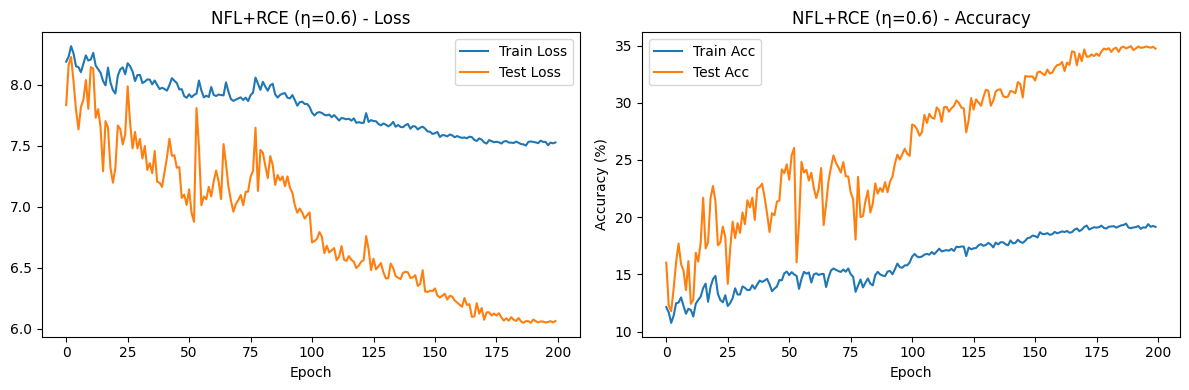

 - NFL+MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.82it/s]


Test Acc: 35.54% | Test Loss: 0.6992


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 46.11% | Test Loss: 0.5802


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 48.23% | Test Loss: 0.5514


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 52.42% | Test Loss: 0.5112


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 56.68% | Test Loss: 0.4615


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 60.10% | Test Loss: 0.4273


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 56.08% | Test Loss: 0.4692


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 62.08% | Test Loss: 0.4018


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 62.71% | Test Loss: 0.3950


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 64.74% | Test Loss: 0.3737


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.11it/s]


Test Acc: 65.86% | Test Loss: 0.3621


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 65.77% | Test Loss: 0.3603


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 66.16% | Test Loss: 0.3577


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 67.41% | Test Loss: 0.3435


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 68.94% | Test Loss: 0.3307


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 69.09% | Test Loss: 0.3251


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.98it/s]


Test Acc: 69.92% | Test Loss: 0.3166


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 69.84% | Test Loss: 0.3192


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 71.53% | Test Loss: 0.2994


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 71.39% | Test Loss: 0.3030


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 71.28% | Test Loss: 0.3021


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 72.59% | Test Loss: 0.2889


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 72.21% | Test Loss: 0.2918


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 74.70% | Test Loss: 0.2644


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.98it/s]


Test Acc: 74.30% | Test Loss: 0.2715


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 74.65% | Test Loss: 0.2680


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 72.10% | Test Loss: 0.2924


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.04it/s]


Test Acc: 73.26% | Test Loss: 0.2810


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 75.83% | Test Loss: 0.2550


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 74.01% | Test Loss: 0.2739


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 76.31% | Test Loss: 0.2479


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 71.37% | Test Loss: 0.2985


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 76.59% | Test Loss: 0.2470


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 75.59% | Test Loss: 0.2555


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 76.33% | Test Loss: 0.2462


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 77.30% | Test Loss: 0.2383


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 75.98% | Test Loss: 0.2529


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 77.44% | Test Loss: 0.2368


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 76.81% | Test Loss: 0.2431


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 78.37% | Test Loss: 0.2278


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 77.23% | Test Loss: 0.2381


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 76.66% | Test Loss: 0.2457


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 78.27% | Test Loss: 0.2283


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 79.27% | Test Loss: 0.2194


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 77.84% | Test Loss: 0.2327


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 78.80% | Test Loss: 0.2216


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 78.80% | Test Loss: 0.2219


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 79.17% | Test Loss: 0.2175


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 78.87% | Test Loss: 0.2198


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 78.91% | Test Loss: 0.2221


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 78.63% | Test Loss: 0.2238


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 76.84% | Test Loss: 0.2432


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 77.80% | Test Loss: 0.2311


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 80.32% | Test Loss: 0.2050


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 79.88% | Test Loss: 0.2108


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 79.47% | Test Loss: 0.2156


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 80.12% | Test Loss: 0.2076


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 80.54% | Test Loss: 0.2051


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 80.02% | Test Loss: 0.2089


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 80.41% | Test Loss: 0.2071


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 80.96% | Test Loss: 0.2016


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 81.10% | Test Loss: 0.1986


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 80.46% | Test Loss: 0.2070


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 80.08% | Test Loss: 0.2087


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 80.29% | Test Loss: 0.2060


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 80.71% | Test Loss: 0.2021


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 81.12% | Test Loss: 0.1969


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 80.74% | Test Loss: 0.2007


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 80.80% | Test Loss: 0.2009


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.04it/s]


Test Acc: 81.30% | Test Loss: 0.1959


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 80.11% | Test Loss: 0.2076


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 81.09% | Test Loss: 0.2002


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 80.18% | Test Loss: 0.2081


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 80.86% | Test Loss: 0.2006


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 80.94% | Test Loss: 0.1981


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 79.88% | Test Loss: 0.2111


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 81.34% | Test Loss: 0.1950


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 81.76% | Test Loss: 0.1921


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 81.09% | Test Loss: 0.1989


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 81.63% | Test Loss: 0.1938


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 80.60% | Test Loss: 0.2024


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 81.77% | Test Loss: 0.1916


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 81.45% | Test Loss: 0.1944


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 81.57% | Test Loss: 0.1933


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 82.62% | Test Loss: 0.1832


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 82.28% | Test Loss: 0.1863


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 81.78% | Test Loss: 0.1917


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 81.33% | Test Loss: 0.1944


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 82.58% | Test Loss: 0.1829


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 80.86% | Test Loss: 0.2017


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 81.24% | Test Loss: 0.1980


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 81.82% | Test Loss: 0.1892


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 81.88% | Test Loss: 0.1887


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 81.06% | Test Loss: 0.1995


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 82.18% | Test Loss: 0.1864


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 81.88% | Test Loss: 0.1897


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 82.51% | Test Loss: 0.1849


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 81.48% | Test Loss: 0.1961


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 82.53% | Test Loss: 0.1844


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 81.84% | Test Loss: 0.1907


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 82.03% | Test Loss: 0.1889


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 82.54% | Test Loss: 0.1847


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 82.68% | Test Loss: 0.1820


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.05it/s]


Test Acc: 82.27% | Test Loss: 0.1862


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 81.60% | Test Loss: 0.1930


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 81.58% | Test Loss: 0.1946


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 81.38% | Test Loss: 0.1947


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 82.39% | Test Loss: 0.1860


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 82.60% | Test Loss: 0.1857


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 82.39% | Test Loss: 0.1851


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 81.90% | Test Loss: 0.1903


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 82.13% | Test Loss: 0.1893


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 81.60% | Test Loss: 0.1954


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 81.40% | Test Loss: 0.1951


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 81.87% | Test Loss: 0.1919


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 82.67% | Test Loss: 0.1853


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 82.49% | Test Loss: 0.1860


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 81.75% | Test Loss: 0.1913


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 82.13% | Test Loss: 0.1896


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 81.82% | Test Loss: 0.1916


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 82.57% | Test Loss: 0.1866


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.11it/s]


Test Acc: 82.17% | Test Loss: 0.1879


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 81.62% | Test Loss: 0.1923


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 82.48% | Test Loss: 0.1864


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 82.25% | Test Loss: 0.1877


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 82.42% | Test Loss: 0.1867


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 82.67% | Test Loss: 0.1827


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 82.48% | Test Loss: 0.1845


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 82.46% | Test Loss: 0.1852


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 82.01% | Test Loss: 0.1905


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 81.90% | Test Loss: 0.1895


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.93it/s]


Test Acc: 82.39% | Test Loss: 0.1867


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 81.99% | Test Loss: 0.1891


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 82.22% | Test Loss: 0.1884


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 82.26% | Test Loss: 0.1885


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 81.85% | Test Loss: 0.1912


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 82.37% | Test Loss: 0.1870


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 82.18% | Test Loss: 0.1897


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 82.34% | Test Loss: 0.1883


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 82.40% | Test Loss: 0.1888


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 81.91% | Test Loss: 0.1921


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 81.78% | Test Loss: 0.1949


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 81.98% | Test Loss: 0.1921


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 81.76% | Test Loss: 0.1939


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 81.83% | Test Loss: 0.1934


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 81.84% | Test Loss: 0.1926


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 81.44% | Test Loss: 0.1955


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 81.35% | Test Loss: 0.1969


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 82.21% | Test Loss: 0.1903


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 81.79% | Test Loss: 0.1945


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 81.51% | Test Loss: 0.1969


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 81.57% | Test Loss: 0.1962


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 81.70% | Test Loss: 0.1941


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 81.80% | Test Loss: 0.1938


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 81.23% | Test Loss: 0.1983


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 82.27% | Test Loss: 0.1896


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 82.04% | Test Loss: 0.1926


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 82.03% | Test Loss: 0.1905


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 81.75% | Test Loss: 0.1933


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 82.16% | Test Loss: 0.1899


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 81.73% | Test Loss: 0.1937


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 82.00% | Test Loss: 0.1918


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 81.69% | Test Loss: 0.1952


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 81.69% | Test Loss: 0.1959


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 81.71% | Test Loss: 0.1948


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 81.68% | Test Loss: 0.1942


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 81.66% | Test Loss: 0.1952


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 81.66% | Test Loss: 0.1936


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 81.65% | Test Loss: 0.1949


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 81.82% | Test Loss: 0.1941


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 81.45% | Test Loss: 0.1955


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 81.58% | Test Loss: 0.1957


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 81.50% | Test Loss: 0.1961


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 81.59% | Test Loss: 0.1947


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 81.55% | Test Loss: 0.1958


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 81.60% | Test Loss: 0.1953


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 81.57% | Test Loss: 0.1952


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 81.58% | Test Loss: 0.1965


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 81.51% | Test Loss: 0.1968


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 81.35% | Test Loss: 0.1982


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 81.39% | Test Loss: 0.1973


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 81.62% | Test Loss: 0.1966


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 81.50% | Test Loss: 0.1971


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 81.45% | Test Loss: 0.1970


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 81.44% | Test Loss: 0.1974


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 81.51% | Test Loss: 0.1967


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 81.38% | Test Loss: 0.1967


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 81.37% | Test Loss: 0.1967


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 81.45% | Test Loss: 0.1974


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 81.42% | Test Loss: 0.1971


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 81.41% | Test Loss: 0.1964


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 81.41% | Test Loss: 0.1967


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 81.53% | Test Loss: 0.1967


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 81.46% | Test Loss: 0.1970


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 81.47% | Test Loss: 0.1971


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 81.48% | Test Loss: 0.1965


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 81.46% | Test Loss: 0.1968


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 81.41% | Test Loss: 0.1971


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 81.37% | Test Loss: 0.1973


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 81.50% | Test Loss: 0.1966


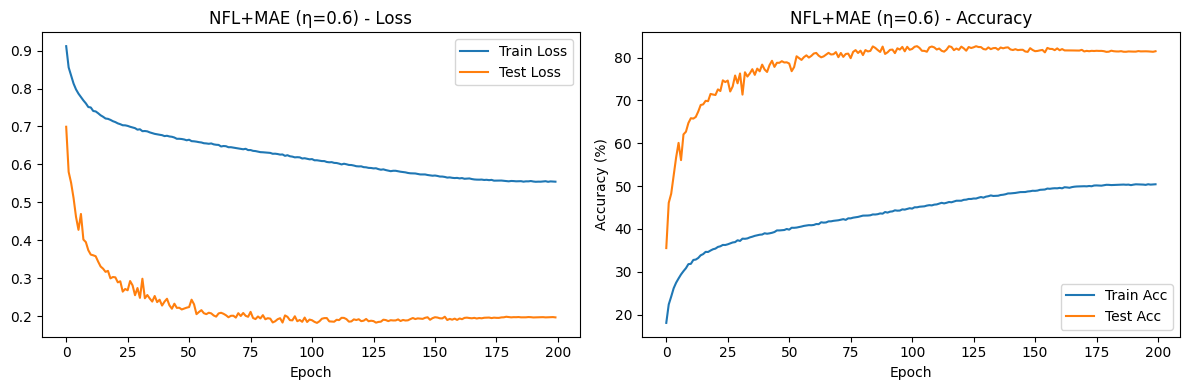

 - NFL+NCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.11it/s]


Test Acc: 38.08% | Test Loss: 0.0700


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 38.15% | Test Loss: 0.0598


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 42.80% | Test Loss: 0.0469


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 43.80% | Test Loss: 0.0441


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 43.31% | Test Loss: 0.0423


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 44.43% | Test Loss: 0.0417


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 46.50% | Test Loss: 0.0362


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 46.57% | Test Loss: 0.0373


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 47.65% | Test Loss: 0.0339


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 47.00% | Test Loss: 0.0335


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 48.06% | Test Loss: 0.0330


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 48.94% | Test Loss: 0.0319


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 50.49% | Test Loss: 0.0331


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 51.38% | Test Loss: 0.0291


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 53.04% | Test Loss: 0.0279


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 52.71% | Test Loss: 0.0295


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 50.73% | Test Loss: 0.0279


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 53.67% | Test Loss: 0.0266


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 53.27% | Test Loss: 0.0268


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 53.01% | Test Loss: 0.0282


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 55.36% | Test Loss: 0.0248


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 55.03% | Test Loss: 0.0272


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 54.34% | Test Loss: 0.0268


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.92it/s]


Test Acc: 56.54% | Test Loss: 0.0240


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 54.89% | Test Loss: 0.0247


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 54.40% | Test Loss: 0.0244


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 54.62% | Test Loss: 0.0242


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 58.28% | Test Loss: 0.0224


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 57.35% | Test Loss: 0.0230


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 56.00% | Test Loss: 0.0229


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 54.49% | Test Loss: 0.0239


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 55.51% | Test Loss: 0.0238


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 54.05% | Test Loss: 0.0273


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 56.77% | Test Loss: 0.0224


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 54.46% | Test Loss: 0.0361


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 54.97% | Test Loss: 0.0251


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 56.38% | Test Loss: 0.0223


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 56.24% | Test Loss: 0.0224


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 56.10% | Test Loss: 0.0230


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 57.00% | Test Loss: 0.0213


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 57.70% | Test Loss: 0.0211


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.10it/s]


Test Acc: 57.25% | Test Loss: 0.0223


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 56.89% | Test Loss: 0.0230


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 57.27% | Test Loss: 0.0212


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 58.54% | Test Loss: 0.0206


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 58.77% | Test Loss: 0.0226


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 58.64% | Test Loss: 0.0199


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 56.58% | Test Loss: 0.0232


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 58.31% | Test Loss: 0.0214


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 55.50% | Test Loss: 0.0259


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 56.68% | Test Loss: 0.0223


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 56.25% | Test Loss: 0.0230


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 56.01% | Test Loss: 0.0226


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 57.54% | Test Loss: 0.0215


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 52.13% | Test Loss: 0.0279


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 58.75% | Test Loss: 0.0195


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 54.73% | Test Loss: 0.0248


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 57.03% | Test Loss: 0.0210


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 52.34% | Test Loss: 0.0278


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 54.76% | Test Loss: 0.0222


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 56.90% | Test Loss: 0.0214


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 58.11% | Test Loss: 0.0199


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 56.11% | Test Loss: 0.0240


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 56.77% | Test Loss: 0.0235


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 57.02% | Test Loss: 0.0204


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 57.09% | Test Loss: 0.0210


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 57.07% | Test Loss: 0.0225


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 56.39% | Test Loss: 0.0216


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 55.70% | Test Loss: 0.0257


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 59.03% | Test Loss: 0.0191


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 54.55% | Test Loss: 0.0230


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 57.77% | Test Loss: 0.0223


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 58.21% | Test Loss: 0.0249


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 54.91% | Test Loss: 0.0220


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 53.46% | Test Loss: 0.0288


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 58.52% | Test Loss: 0.0193


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 57.15% | Test Loss: 0.0218


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.95it/s]


Test Acc: 56.35% | Test Loss: 0.0283


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 55.86% | Test Loss: 0.0251


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 56.07% | Test Loss: 0.0237


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 54.54% | Test Loss: 0.0246


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 56.39% | Test Loss: 0.0239


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 54.73% | Test Loss: 0.0238


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 58.14% | Test Loss: 0.0253


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 57.92% | Test Loss: 0.0207


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 57.47% | Test Loss: 0.0213


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 57.56% | Test Loss: 0.0250


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 57.18% | Test Loss: 0.0203


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 58.21% | Test Loss: 0.0192


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 56.89% | Test Loss: 0.0202


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 56.70% | Test Loss: 0.0224


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 57.29% | Test Loss: 0.0250


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 52.30% | Test Loss: 0.0290


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 57.46% | Test Loss: 0.0201


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.78it/s]


Test Acc: 57.92% | Test Loss: 0.0225


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 58.29% | Test Loss: 0.0224


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 57.50% | Test Loss: 0.0263


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 59.33% | Test Loss: 0.0207


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.93it/s]


Test Acc: 54.58% | Test Loss: 0.0234


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 58.26% | Test Loss: 0.0226


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 57.31% | Test Loss: 0.0247


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 58.94% | Test Loss: 0.0247


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.84it/s]


Test Acc: 58.35% | Test Loss: 0.0249


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 57.61% | Test Loss: 0.0217


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 56.17% | Test Loss: 0.0247


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 58.32% | Test Loss: 0.0231


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 55.14% | Test Loss: 0.0248


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 58.39% | Test Loss: 0.0243


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 58.67% | Test Loss: 0.0243


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 57.61% | Test Loss: 0.0293


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.09it/s]


Test Acc: 56.92% | Test Loss: 0.0244


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 56.97% | Test Loss: 0.0226


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 56.55% | Test Loss: 0.0270


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 57.83% | Test Loss: 0.0218


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 57.27% | Test Loss: 0.0275


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 58.32% | Test Loss: 0.0254


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 56.31% | Test Loss: 0.0262


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 58.66% | Test Loss: 0.0184


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 59.09% | Test Loss: 0.0278


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 58.28% | Test Loss: 0.0238


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 57.65% | Test Loss: 0.0238


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 56.60% | Test Loss: 0.0239


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 59.70% | Test Loss: 0.0211


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 54.70% | Test Loss: 0.0329


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 57.93% | Test Loss: 0.0235


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 55.65% | Test Loss: 0.0257


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 55.00% | Test Loss: 0.0251


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 57.37% | Test Loss: 0.0200


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 54.28% | Test Loss: 0.0273


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 55.88% | Test Loss: 0.0218


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 58.82% | Test Loss: 0.0234


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 59.14% | Test Loss: 0.0229


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 57.82% | Test Loss: 0.0227


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.62it/s]


Test Acc: 58.32% | Test Loss: 0.0268


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 55.40% | Test Loss: 0.0292


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 56.30% | Test Loss: 0.0272


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 55.83% | Test Loss: 0.0266


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 57.06% | Test Loss: 0.0231


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 57.48% | Test Loss: 0.0216


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 57.54% | Test Loss: 0.0238


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 58.20% | Test Loss: 0.0216


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 57.05% | Test Loss: 0.0258


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 55.24% | Test Loss: 0.0258


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 57.83% | Test Loss: 0.0214


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 55.62% | Test Loss: 0.0240


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 55.40% | Test Loss: 0.0241


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 56.63% | Test Loss: 0.0249


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 56.11% | Test Loss: 0.0223


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 56.01% | Test Loss: 0.0257


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 55.16% | Test Loss: 0.0211


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 57.30% | Test Loss: 0.0253


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 55.80% | Test Loss: 0.0241


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 55.90% | Test Loss: 0.0246


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 55.23% | Test Loss: 0.0237


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.73it/s]


Test Acc: 55.86% | Test Loss: 0.0275


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 55.45% | Test Loss: 0.0228


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 57.03% | Test Loss: 0.0224


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 56.56% | Test Loss: 0.0241


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 56.36% | Test Loss: 0.0244


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 54.86% | Test Loss: 0.0238


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 56.05% | Test Loss: 0.0224


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 55.68% | Test Loss: 0.0251


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 56.03% | Test Loss: 0.0255


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 55.58% | Test Loss: 0.0247


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 55.57% | Test Loss: 0.0263


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 55.45% | Test Loss: 0.0251


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 56.59% | Test Loss: 0.0246


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 55.42% | Test Loss: 0.0242


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 55.41% | Test Loss: 0.0248


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 55.35% | Test Loss: 0.0241


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 54.76% | Test Loss: 0.0239


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 54.73% | Test Loss: 0.0238


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 54.77% | Test Loss: 0.0249


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.91it/s]


Test Acc: 54.31% | Test Loss: 0.0255


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 55.04% | Test Loss: 0.0243


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 55.24% | Test Loss: 0.0242


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 55.47% | Test Loss: 0.0236


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 55.04% | Test Loss: 0.0236


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 55.30% | Test Loss: 0.0249


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 54.93% | Test Loss: 0.0245


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 54.86% | Test Loss: 0.0248


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 54.89% | Test Loss: 0.0247


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 54.70% | Test Loss: 0.0242


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 55.19% | Test Loss: 0.0250


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 54.62% | Test Loss: 0.0243


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 55.05% | Test Loss: 0.0241


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 55.13% | Test Loss: 0.0239


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 54.91% | Test Loss: 0.0247


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 54.63% | Test Loss: 0.0243


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 54.75% | Test Loss: 0.0253


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 54.66% | Test Loss: 0.0245


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 54.69% | Test Loss: 0.0240


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 54.84% | Test Loss: 0.0246


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 54.73% | Test Loss: 0.0243


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.98it/s]


Test Acc: 54.84% | Test Loss: 0.0242


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 54.85% | Test Loss: 0.0245


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 54.92% | Test Loss: 0.0243


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 54.97% | Test Loss: 0.0247


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.86it/s]


Test Acc: 54.92% | Test Loss: 0.0244


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 55.05% | Test Loss: 0.0247


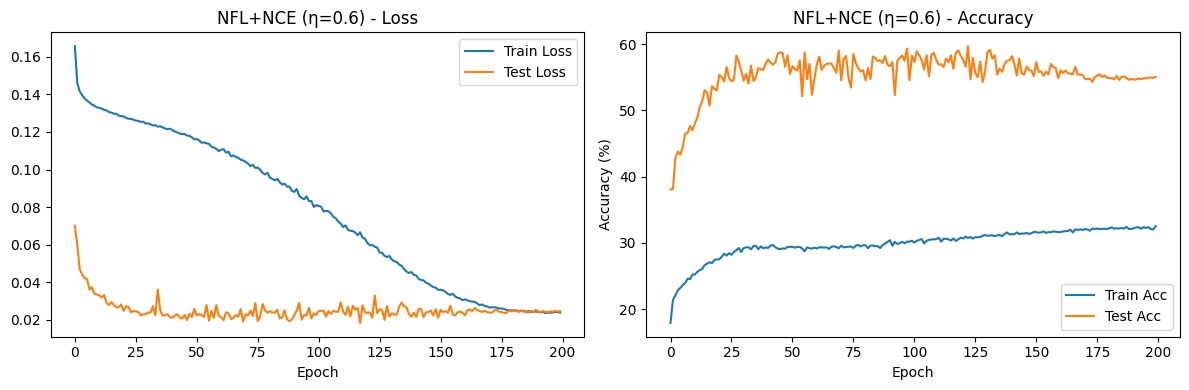

 - MAE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 14.37% | Test Loss: 8.9549


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 16.77% | Test Loss: 8.5030


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 19.17% | Test Loss: 8.2576


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 17.21% | Test Loss: 8.4456


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 15.58% | Test Loss: 8.6149


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 16.63% | Test Loss: 8.5111


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 15.10% | Test Loss: 8.6577


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 14.93% | Test Loss: 8.6736


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 15.70% | Test Loss: 8.6029


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 14.83% | Test Loss: 8.6840


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 16.68% | Test Loss: 8.4973


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 17.47% | Test Loss: 8.4237


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 17.41% | Test Loss: 8.4239


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 18.59% | Test Loss: 8.3151


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 20.91% | Test Loss: 8.0761


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 20.74% | Test Loss: 8.1012


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 21.53% | Test Loss: 8.0208


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 20.42% | Test Loss: 8.1450


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 19.61% | Test Loss: 8.2212


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 18.55% | Test Loss: 8.3346


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 23.23% | Test Loss: 7.8604


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 21.51% | Test Loss: 8.0245


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 22.98% | Test Loss: 7.8639


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 18.55% | Test Loss: 8.3163


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 21.14% | Test Loss: 8.0479


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 22.49% | Test Loss: 7.9158


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 22.86% | Test Loss: 7.8897


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 23.16% | Test Loss: 7.8577


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 24.71% | Test Loss: 7.7091


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 24.45% | Test Loss: 7.7256


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 23.08% | Test Loss: 7.8759


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 21.64% | Test Loss: 8.0186


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 22.06% | Test Loss: 7.9657


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 23.19% | Test Loss: 7.8543


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 22.98% | Test Loss: 7.8767


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 20.91% | Test Loss: 8.0780


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 23.85% | Test Loss: 7.7977


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 22.58% | Test Loss: 7.8960


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 22.75% | Test Loss: 7.8811


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 21.19% | Test Loss: 8.0637


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 24.59% | Test Loss: 7.7156


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 18.92% | Test Loss: 8.2794


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 20.60% | Test Loss: 8.1235


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 23.46% | Test Loss: 7.8127


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 23.42% | Test Loss: 7.8157


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 23.65% | Test Loss: 7.8067


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 23.57% | Test Loss: 7.8163


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 22.25% | Test Loss: 7.9487


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 23.92% | Test Loss: 7.7810


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 23.56% | Test Loss: 7.8186


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 22.93% | Test Loss: 7.8753


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 24.97% | Test Loss: 7.6680


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 24.35% | Test Loss: 7.7356


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 24.23% | Test Loss: 7.7446


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 20.17% | Test Loss: 8.1591


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 21.92% | Test Loss: 7.9718


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 20.02% | Test Loss: 8.1622


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 22.43% | Test Loss: 7.9313


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 23.97% | Test Loss: 7.7788


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 24.38% | Test Loss: 7.7347


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 23.84% | Test Loss: 7.7969


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 25.17% | Test Loss: 7.6562


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 23.57% | Test Loss: 7.8151


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 24.59% | Test Loss: 7.7131


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 23.17% | Test Loss: 7.8576


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 23.30% | Test Loss: 7.8436


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 24.59% | Test Loss: 7.7053


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 25.13% | Test Loss: 7.6638


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 24.56% | Test Loss: 7.7074


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 19.13% | Test Loss: 8.2647


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 25.76% | Test Loss: 7.5950


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 25.60% | Test Loss: 7.6104


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 23.36% | Test Loss: 7.8353


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 25.29% | Test Loss: 7.6421


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 25.14% | Test Loss: 7.6555


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 25.29% | Test Loss: 7.6514


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 24.85% | Test Loss: 7.6750


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 25.45% | Test Loss: 7.6191


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 24.15% | Test Loss: 7.7640


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 24.35% | Test Loss: 7.7387


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 25.37% | Test Loss: 7.6305


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 26.06% | Test Loss: 7.5585


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 24.21% | Test Loss: 7.7593


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 25.51% | Test Loss: 7.6211


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 26.01% | Test Loss: 7.5705


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 26.30% | Test Loss: 7.5360


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 25.54% | Test Loss: 7.6193


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 24.66% | Test Loss: 7.7065


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 25.48% | Test Loss: 7.6202


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 25.08% | Test Loss: 7.6556


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 25.30% | Test Loss: 7.6286


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 25.63% | Test Loss: 7.5950


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.89it/s]


Test Acc: 24.07% | Test Loss: 7.7440


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 25.52% | Test Loss: 7.6224


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 25.25% | Test Loss: 7.6334


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 25.20% | Test Loss: 7.6446


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 25.46% | Test Loss: 7.6250


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 25.02% | Test Loss: 7.6713


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 25.17% | Test Loss: 7.6542


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 25.04% | Test Loss: 7.6686


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 26.56% | Test Loss: 7.5192


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 25.32% | Test Loss: 7.6330


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 26.60% | Test Loss: 7.5001


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.94it/s]


Test Acc: 24.14% | Test Loss: 7.7494


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 24.69% | Test Loss: 7.6909


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 26.26% | Test Loss: 7.5322


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 26.03% | Test Loss: 7.5614


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 25.56% | Test Loss: 7.6221


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 26.58% | Test Loss: 7.5026


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 26.39% | Test Loss: 7.5196


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 26.74% | Test Loss: 7.4856


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 26.91% | Test Loss: 7.4734


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 26.75% | Test Loss: 7.5002


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 26.52% | Test Loss: 7.5270


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 26.97% | Test Loss: 7.4678


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 26.73% | Test Loss: 7.4890


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 26.24% | Test Loss: 7.5400


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 26.19% | Test Loss: 7.5445


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 26.48% | Test Loss: 7.5163


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 27.28% | Test Loss: 7.4333


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 26.86% | Test Loss: 7.4785


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 26.00% | Test Loss: 7.5628


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 26.68% | Test Loss: 7.4888


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 26.42% | Test Loss: 7.5247


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 26.33% | Test Loss: 7.5232


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 27.37% | Test Loss: 7.4414


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 27.25% | Test Loss: 7.4448


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 26.52% | Test Loss: 7.5026


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 26.41% | Test Loss: 7.5229


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 27.00% | Test Loss: 7.4562


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 26.88% | Test Loss: 7.4721


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 27.66% | Test Loss: 7.4107


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 27.64% | Test Loss: 7.4127


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 27.62% | Test Loss: 7.4063


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 26.85% | Test Loss: 7.4865


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 27.32% | Test Loss: 7.4384


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 27.76% | Test Loss: 7.3983


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 28.14% | Test Loss: 7.3548


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 27.82% | Test Loss: 7.3763


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 27.30% | Test Loss: 7.4263


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 27.72% | Test Loss: 7.3869


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 28.15% | Test Loss: 7.3526


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 28.12% | Test Loss: 7.3492


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 28.12% | Test Loss: 7.3569


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 28.30% | Test Loss: 7.3315


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 28.10% | Test Loss: 7.3457


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 27.90% | Test Loss: 7.3632


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 28.11% | Test Loss: 7.3440


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 28.20% | Test Loss: 7.3422


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 28.06% | Test Loss: 7.3613


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 28.30% | Test Loss: 7.3412


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 28.34% | Test Loss: 7.3362


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 27.99% | Test Loss: 7.3630


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 27.94% | Test Loss: 7.3596


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 28.13% | Test Loss: 7.3427


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 28.26% | Test Loss: 7.3278


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 28.10% | Test Loss: 7.3452


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 28.25% | Test Loss: 7.3319


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 28.10% | Test Loss: 7.3447


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 28.07% | Test Loss: 7.3460


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 28.09% | Test Loss: 7.3531


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 28.06% | Test Loss: 7.3555


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 28.37% | Test Loss: 7.3199


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 28.36% | Test Loss: 7.3191


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 28.07% | Test Loss: 7.3453


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 28.26% | Test Loss: 7.3311


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 28.22% | Test Loss: 7.3345


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 28.12% | Test Loss: 7.3431


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 28.49% | Test Loss: 7.3046


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 28.41% | Test Loss: 7.3157


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.10it/s]


Test Acc: 28.38% | Test Loss: 7.3210


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 28.51% | Test Loss: 7.3107


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 28.54% | Test Loss: 7.3074


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 28.62% | Test Loss: 7.3037


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 28.69% | Test Loss: 7.2871


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 28.75% | Test Loss: 7.2899


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 28.64% | Test Loss: 7.2947


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 28.75% | Test Loss: 7.2880


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 28.85% | Test Loss: 7.2797


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 28.79% | Test Loss: 7.2826


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 28.89% | Test Loss: 7.2760


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 28.92% | Test Loss: 7.2688


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 28.90% | Test Loss: 7.2714


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 28.94% | Test Loss: 7.2667


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 28.97% | Test Loss: 7.2656


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 28.88% | Test Loss: 7.2704


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 28.93% | Test Loss: 7.2675


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 28.95% | Test Loss: 7.2628


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 29.02% | Test Loss: 7.2577


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 29.06% | Test Loss: 7.2576


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 28.99% | Test Loss: 7.2591


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 29.03% | Test Loss: 7.2558


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 29.01% | Test Loss: 7.2584


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 29.03% | Test Loss: 7.2561


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 29.20% | Test Loss: 7.2444


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 29.11% | Test Loss: 7.2508


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 29.06% | Test Loss: 7.2553


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 29.14% | Test Loss: 7.2505


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 28.99% | Test Loss: 7.2598


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 28.98% | Test Loss: 7.2600


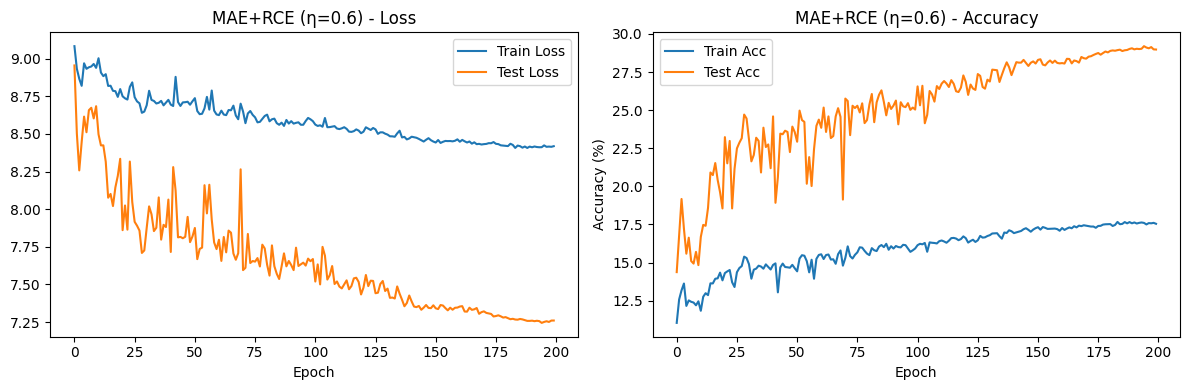


Noise Rate: 0.8

Training vanilla Losses...
 - CE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 26.10% | Test Loss: 2.1562


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 35.29% | Test Loss: 2.1585


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 32.03% | Test Loss: 2.0788


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 40.90% | Test Loss: 2.0184


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 39.72% | Test Loss: 2.0188


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 43.94% | Test Loss: 2.0127


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 44.94% | Test Loss: 1.9451


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.78it/s]


Test Acc: 48.43% | Test Loss: 1.8774


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 48.54% | Test Loss: 1.9183


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 48.07% | Test Loss: 1.9470


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 42.63% | Test Loss: 1.9472


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 48.17% | Test Loss: 1.9224


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 55.56% | Test Loss: 1.9009


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 51.55% | Test Loss: 1.8709


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 54.25% | Test Loss: 1.8799


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 53.15% | Test Loss: 1.7784


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 53.69% | Test Loss: 1.8124


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 57.98% | Test Loss: 1.8213


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 52.85% | Test Loss: 1.8498


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 58.00% | Test Loss: 1.7675


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 54.64% | Test Loss: 1.8578


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 57.67% | Test Loss: 1.7633


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 57.55% | Test Loss: 1.8431


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 61.85% | Test Loss: 1.7583


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 61.27% | Test Loss: 1.7529


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 57.46% | Test Loss: 1.7664


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 56.84% | Test Loss: 1.7904


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 60.15% | Test Loss: 1.7452


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 58.71% | Test Loss: 1.7648


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 60.44% | Test Loss: 1.7499


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 59.68% | Test Loss: 1.7936


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 58.53% | Test Loss: 1.6744


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 60.83% | Test Loss: 1.7010


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 58.45% | Test Loss: 1.7838


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 54.53% | Test Loss: 1.7499


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 51.87% | Test Loss: 1.8305


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 58.52% | Test Loss: 1.7390


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 58.98% | Test Loss: 1.7545


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 58.43% | Test Loss: 1.6850


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 54.82% | Test Loss: 1.7731


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 52.68% | Test Loss: 1.8006


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 57.52% | Test Loss: 1.6836


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 56.57% | Test Loss: 1.7049


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 56.61% | Test Loss: 1.7231


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 54.69% | Test Loss: 1.7270


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 52.51% | Test Loss: 1.7677


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 52.45% | Test Loss: 1.7828


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 54.78% | Test Loss: 1.7149


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 49.41% | Test Loss: 1.7643


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 48.62% | Test Loss: 1.8110


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 50.14% | Test Loss: 1.7292


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 49.76% | Test Loss: 1.7570


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.46it/s]


Test Acc: 47.21% | Test Loss: 1.7882


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 46.42% | Test Loss: 1.8097


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 48.08% | Test Loss: 1.7511


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 46.08% | Test Loss: 1.8213


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 48.16% | Test Loss: 1.7589


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 45.82% | Test Loss: 1.7811


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.38it/s]


Test Acc: 48.64% | Test Loss: 1.7286


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 43.39% | Test Loss: 1.8425


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 43.61% | Test Loss: 1.8560


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.60it/s]


Test Acc: 45.57% | Test Loss: 1.8045


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 41.89% | Test Loss: 1.8406


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 45.27% | Test Loss: 1.7885


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 41.16% | Test Loss: 1.8481


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 43.49% | Test Loss: 1.8111


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 40.10% | Test Loss: 1.8737


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 43.19% | Test Loss: 1.8369


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 40.32% | Test Loss: 1.9110


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 41.44% | Test Loss: 1.8516


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 40.20% | Test Loss: 1.8886


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 38.41% | Test Loss: 1.9502


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 37.17% | Test Loss: 1.9663


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 35.84% | Test Loss: 1.9894


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 32.32% | Test Loss: 2.1231


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 37.53% | Test Loss: 1.9774


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 32.99% | Test Loss: 2.1164


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 33.91% | Test Loss: 2.0844


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 31.48% | Test Loss: 2.1869


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 32.12% | Test Loss: 2.1490


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 31.19% | Test Loss: 2.2364


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 33.93% | Test Loss: 2.1197


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 33.12% | Test Loss: 2.1467


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 32.58% | Test Loss: 2.1822


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 32.21% | Test Loss: 2.2442


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 32.37% | Test Loss: 2.1886


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 29.16% | Test Loss: 2.3108


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 29.48% | Test Loss: 2.3217


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 32.55% | Test Loss: 2.2640


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 28.82% | Test Loss: 2.3972


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 29.85% | Test Loss: 2.3603


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 32.44% | Test Loss: 2.3128


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 27.16% | Test Loss: 2.4697


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 28.28% | Test Loss: 2.4343


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 29.78% | Test Loss: 2.4220


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 27.82% | Test Loss: 2.5387


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.39it/s]


Test Acc: 27.38% | Test Loss: 2.5234


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 31.89% | Test Loss: 2.4242


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 27.33% | Test Loss: 2.5903


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 28.88% | Test Loss: 2.6017


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 27.60% | Test Loss: 2.6924


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 26.63% | Test Loss: 2.7004


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 27.86% | Test Loss: 2.6707


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 26.04% | Test Loss: 2.7452


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 28.37% | Test Loss: 2.6509


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 25.46% | Test Loss: 2.7830


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 26.27% | Test Loss: 2.8375


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 27.00% | Test Loss: 2.8184


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 28.38% | Test Loss: 2.7899


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.82it/s]


Test Acc: 27.75% | Test Loss: 2.8435


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 27.43% | Test Loss: 2.8023


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 26.08% | Test Loss: 2.8974


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 26.59% | Test Loss: 2.8696


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 26.08% | Test Loss: 3.0185


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 26.10% | Test Loss: 3.0494


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 27.50% | Test Loss: 2.9686


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 26.27% | Test Loss: 3.0344


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 23.57% | Test Loss: 3.2559


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 25.28% | Test Loss: 3.1481


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 25.95% | Test Loss: 3.1174


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.26it/s]


Test Acc: 26.64% | Test Loss: 3.1037


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 24.59% | Test Loss: 3.2212


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 25.62% | Test Loss: 3.2495


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 25.12% | Test Loss: 3.2441


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 25.20% | Test Loss: 3.3586


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 25.05% | Test Loss: 3.3350


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 25.25% | Test Loss: 3.3175


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 26.06% | Test Loss: 3.2975


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 26.26% | Test Loss: 3.3465


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 26.46% | Test Loss: 3.3473


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 26.07% | Test Loss: 3.3617


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 26.44% | Test Loss: 3.4176


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 25.04% | Test Loss: 3.4930


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 24.15% | Test Loss: 3.5553


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 25.38% | Test Loss: 3.6019


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 26.18% | Test Loss: 3.4563


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 25.63% | Test Loss: 3.5526


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 27.12% | Test Loss: 3.5158


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 24.18% | Test Loss: 3.6454


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 25.75% | Test Loss: 3.5199


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 25.90% | Test Loss: 3.6109


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 26.00% | Test Loss: 3.6183


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 25.14% | Test Loss: 3.7277


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.95it/s]


Test Acc: 26.74% | Test Loss: 3.6337


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 24.69% | Test Loss: 3.7238


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 25.38% | Test Loss: 3.7324


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 23.46% | Test Loss: 3.8507


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 25.11% | Test Loss: 3.7204


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 25.66% | Test Loss: 3.7355


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 24.96% | Test Loss: 3.8043


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 26.15% | Test Loss: 3.7583


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 24.68% | Test Loss: 3.8468


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 25.84% | Test Loss: 3.8029


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 25.04% | Test Loss: 3.9074


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 24.97% | Test Loss: 3.9019


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 26.40% | Test Loss: 3.8141


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 26.04% | Test Loss: 3.8228


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 26.36% | Test Loss: 3.8429


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 26.00% | Test Loss: 3.8877


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.42it/s]


Test Acc: 26.37% | Test Loss: 3.8908


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 25.69% | Test Loss: 3.9261


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 26.60% | Test Loss: 3.8787


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 26.00% | Test Loss: 3.9075


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 25.79% | Test Loss: 3.9084


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 25.78% | Test Loss: 3.9559


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 26.03% | Test Loss: 3.9625


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 25.49% | Test Loss: 3.9926


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.55it/s]


Test Acc: 26.22% | Test Loss: 3.9407


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 26.33% | Test Loss: 3.9203


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 25.78% | Test Loss: 3.9814


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 26.35% | Test Loss: 3.9523


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 25.85% | Test Loss: 3.9794


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 26.19% | Test Loss: 3.9984


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 25.67% | Test Loss: 3.9960


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 26.19% | Test Loss: 3.9868


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 26.00% | Test Loss: 4.0085


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 26.07% | Test Loss: 4.0334


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 26.56% | Test Loss: 4.0036


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 26.19% | Test Loss: 4.0085


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 26.22% | Test Loss: 4.0186


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 26.17% | Test Loss: 4.0333


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 26.35% | Test Loss: 4.0036


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 26.26% | Test Loss: 4.0224


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 26.31% | Test Loss: 4.0150


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 26.01% | Test Loss: 4.0431


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 26.11% | Test Loss: 4.0367


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 25.99% | Test Loss: 4.0306


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 26.30% | Test Loss: 4.0276


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 25.88% | Test Loss: 4.0624


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 25.91% | Test Loss: 4.0527


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 26.09% | Test Loss: 4.0541


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 26.11% | Test Loss: 4.0250


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 26.07% | Test Loss: 4.0460


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 25.97% | Test Loss: 4.0213


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 25.95% | Test Loss: 4.0524


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 25.98% | Test Loss: 4.0160


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 26.14% | Test Loss: 4.0211


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 25.95% | Test Loss: 4.0526


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 26.21% | Test Loss: 4.0433


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 26.06% | Test Loss: 4.0508


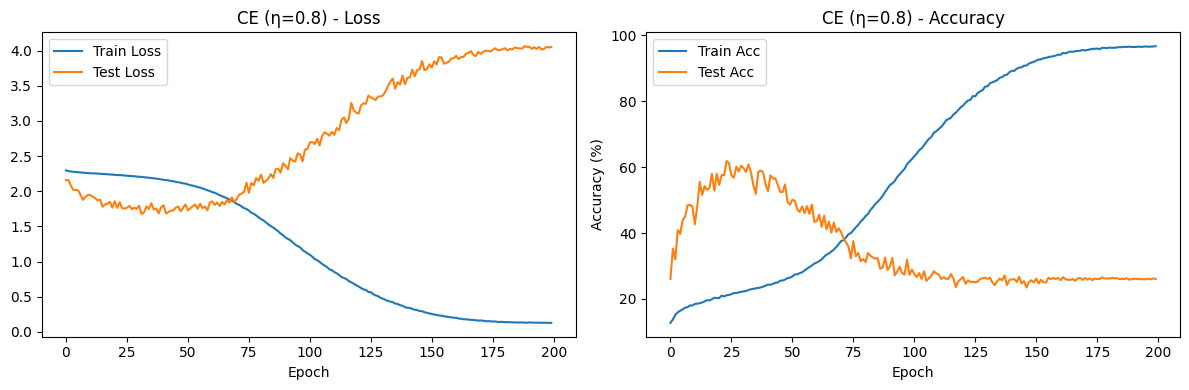

 - MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 24.09% | Test Loss: 0.7659


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 29.07% | Test Loss: 0.7154


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 28.34% | Test Loss: 0.7194


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 31.46% | Test Loss: 0.6882


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 31.72% | Test Loss: 0.6854


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 31.06% | Test Loss: 0.6932


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 30.19% | Test Loss: 0.7005


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 31.94% | Test Loss: 0.6828


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 31.01% | Test Loss: 0.6888


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 33.54% | Test Loss: 0.6662


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 36.07% | Test Loss: 0.6424


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 33.81% | Test Loss: 0.6645


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 33.96% | Test Loss: 0.6620


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 35.34% | Test Loss: 0.6481


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 33.75% | Test Loss: 0.6636


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 36.09% | Test Loss: 0.6411


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 36.33% | Test Loss: 0.6381


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 33.41% | Test Loss: 0.6686


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 36.34% | Test Loss: 0.6379


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 35.84% | Test Loss: 0.6441


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 37.45% | Test Loss: 0.6262


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 37.32% | Test Loss: 0.6283


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 37.40% | Test Loss: 0.6269


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 38.17% | Test Loss: 0.6200


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 37.64% | Test Loss: 0.6244


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 38.25% | Test Loss: 0.6189


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 38.55% | Test Loss: 0.6158


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 38.24% | Test Loss: 0.6199


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 37.27% | Test Loss: 0.6283


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 37.16% | Test Loss: 0.6294


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 38.18% | Test Loss: 0.6198


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 38.28% | Test Loss: 0.6182


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 38.19% | Test Loss: 0.6189


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 38.10% | Test Loss: 0.6209


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 36.62% | Test Loss: 0.6343


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 37.25% | Test Loss: 0.6282


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 38.26% | Test Loss: 0.6179


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 39.90% | Test Loss: 0.6026


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 38.61% | Test Loss: 0.6140


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 38.38% | Test Loss: 0.6182


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 38.19% | Test Loss: 0.6191


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 38.26% | Test Loss: 0.6186


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 39.11% | Test Loss: 0.6089


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 38.92% | Test Loss: 0.6110


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 40.57% | Test Loss: 0.5954


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 38.24% | Test Loss: 0.6182


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 40.21% | Test Loss: 0.5985


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 40.16% | Test Loss: 0.5988


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 40.16% | Test Loss: 0.5992


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 39.22% | Test Loss: 0.6089


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 38.89% | Test Loss: 0.6119


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 39.17% | Test Loss: 0.6101


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 40.09% | Test Loss: 0.5988


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 39.59% | Test Loss: 0.6044


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 40.10% | Test Loss: 0.6001


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 41.13% | Test Loss: 0.5891


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 38.56% | Test Loss: 0.6150


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 40.92% | Test Loss: 0.5927


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 42.59% | Test Loss: 0.5773


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 43.34% | Test Loss: 0.5693


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 44.15% | Test Loss: 0.5621


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 44.89% | Test Loss: 0.5532


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 45.08% | Test Loss: 0.5510


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 43.95% | Test Loss: 0.5618


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 46.20% | Test Loss: 0.5404


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 44.64% | Test Loss: 0.5561


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 46.04% | Test Loss: 0.5411


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 46.14% | Test Loss: 0.5412


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 45.43% | Test Loss: 0.5476


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 46.53% | Test Loss: 0.5365


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 46.28% | Test Loss: 0.5391


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 46.26% | Test Loss: 0.5395


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 45.97% | Test Loss: 0.5415


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 46.33% | Test Loss: 0.5389


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 47.96% | Test Loss: 0.5233


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 46.71% | Test Loss: 0.5347


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 46.93% | Test Loss: 0.5327


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 47.69% | Test Loss: 0.5235


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 47.54% | Test Loss: 0.5262


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 45.94% | Test Loss: 0.5395


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 46.90% | Test Loss: 0.5321


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 47.52% | Test Loss: 0.5258


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 46.63% | Test Loss: 0.5361


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 47.52% | Test Loss: 0.5262


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 48.35% | Test Loss: 0.5187


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 47.62% | Test Loss: 0.5244


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 48.10% | Test Loss: 0.5193


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 46.79% | Test Loss: 0.5334


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 48.17% | Test Loss: 0.5205


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 48.12% | Test Loss: 0.5205


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 48.03% | Test Loss: 0.5218


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 48.27% | Test Loss: 0.5193


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 48.65% | Test Loss: 0.5148


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 48.00% | Test Loss: 0.5213


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 47.55% | Test Loss: 0.5261


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 48.36% | Test Loss: 0.5163


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 48.11% | Test Loss: 0.5221


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 47.83% | Test Loss: 0.5237


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 47.83% | Test Loss: 0.5233


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 47.55% | Test Loss: 0.5262


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 47.74% | Test Loss: 0.5243


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 47.98% | Test Loss: 0.5216


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 48.43% | Test Loss: 0.5172


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 48.40% | Test Loss: 0.5183


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 48.24% | Test Loss: 0.5201


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 47.56% | Test Loss: 0.5285


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 48.40% | Test Loss: 0.5186


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 48.44% | Test Loss: 0.5175


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 47.85% | Test Loss: 0.5239


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 48.33% | Test Loss: 0.5189


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 48.70% | Test Loss: 0.5160


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 47.98% | Test Loss: 0.5224


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 48.06% | Test Loss: 0.5224


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 48.39% | Test Loss: 0.5191


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 48.17% | Test Loss: 0.5207


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 48.43% | Test Loss: 0.5178


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 48.60% | Test Loss: 0.5172


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 47.78% | Test Loss: 0.5240


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 48.75% | Test Loss: 0.5159


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 48.60% | Test Loss: 0.5159


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 48.24% | Test Loss: 0.5194


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 48.45% | Test Loss: 0.5174


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 48.46% | Test Loss: 0.5183


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 48.13% | Test Loss: 0.5198


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 48.52% | Test Loss: 0.5174


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 48.17% | Test Loss: 0.5203


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 48.00% | Test Loss: 0.5226


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 48.94% | Test Loss: 0.5138


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 47.76% | Test Loss: 0.5248


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 46.84% | Test Loss: 0.5333


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 46.72% | Test Loss: 0.5341


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 47.77% | Test Loss: 0.5241


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 47.17% | Test Loss: 0.5319


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 47.47% | Test Loss: 0.5260


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 48.07% | Test Loss: 0.5218


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 48.08% | Test Loss: 0.5215


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 48.17% | Test Loss: 0.5203


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 48.15% | Test Loss: 0.5216


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 48.03% | Test Loss: 0.5225


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 48.04% | Test Loss: 0.5233


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 48.03% | Test Loss: 0.5214


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 48.26% | Test Loss: 0.5198


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 48.00% | Test Loss: 0.5235


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 47.67% | Test Loss: 0.5275


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 47.74% | Test Loss: 0.5255


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 47.38% | Test Loss: 0.5289


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 48.01% | Test Loss: 0.5238


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 47.15% | Test Loss: 0.5318


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 47.85% | Test Loss: 0.5257


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 48.04% | Test Loss: 0.5226


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 47.62% | Test Loss: 0.5256


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 47.62% | Test Loss: 0.5263


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 47.82% | Test Loss: 0.5245


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 47.67% | Test Loss: 0.5258


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 47.81% | Test Loss: 0.5256


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 48.02% | Test Loss: 0.5226


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 47.81% | Test Loss: 0.5254


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 47.56% | Test Loss: 0.5257


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 47.66% | Test Loss: 0.5273


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 48.06% | Test Loss: 0.5232


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 47.65% | Test Loss: 0.5268


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 47.81% | Test Loss: 0.5253


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 47.34% | Test Loss: 0.5302


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 47.70% | Test Loss: 0.5265


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 47.32% | Test Loss: 0.5315


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 47.14% | Test Loss: 0.5316


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 47.23% | Test Loss: 0.5307


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 47.48% | Test Loss: 0.5289


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 47.50% | Test Loss: 0.5287


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 47.31% | Test Loss: 0.5302


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 47.30% | Test Loss: 0.5310


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 47.44% | Test Loss: 0.5297


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 47.56% | Test Loss: 0.5271


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.07it/s]


Test Acc: 47.61% | Test Loss: 0.5292


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 47.33% | Test Loss: 0.5294


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 47.21% | Test Loss: 0.5313


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 47.33% | Test Loss: 0.5312


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 47.23% | Test Loss: 0.5308


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 47.00% | Test Loss: 0.5331


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 47.39% | Test Loss: 0.5302


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 47.30% | Test Loss: 0.5304


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 47.11% | Test Loss: 0.5320


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 47.15% | Test Loss: 0.5314


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 47.32% | Test Loss: 0.5313


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 46.99% | Test Loss: 0.5325


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 47.15% | Test Loss: 0.5311


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 47.32% | Test Loss: 0.5310


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 46.91% | Test Loss: 0.5340


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 47.18% | Test Loss: 0.5318


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 47.01% | Test Loss: 0.5326


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 47.00% | Test Loss: 0.5326


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 47.02% | Test Loss: 0.5328


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 47.05% | Test Loss: 0.5324


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 47.11% | Test Loss: 0.5323


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 47.02% | Test Loss: 0.5326


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 46.98% | Test Loss: 0.5331


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 47.04% | Test Loss: 0.5323


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 47.17% | Test Loss: 0.5321


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 47.16% | Test Loss: 0.5320


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 47.15% | Test Loss: 0.5321


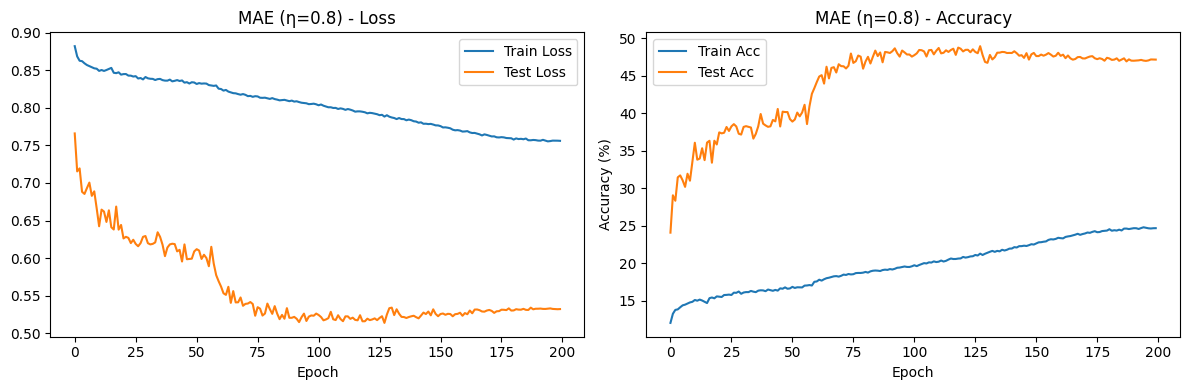

 - RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 22.26% | Test Loss: 7.2749


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.13it/s]


Test Acc: 15.07% | Test Loss: 7.8084


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.96it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.09it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 10.00% | Test Loss: 8.2995


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.63it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 10.00% | Test Loss: 8.2994


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 10.00% | Test Loss: 8.2994


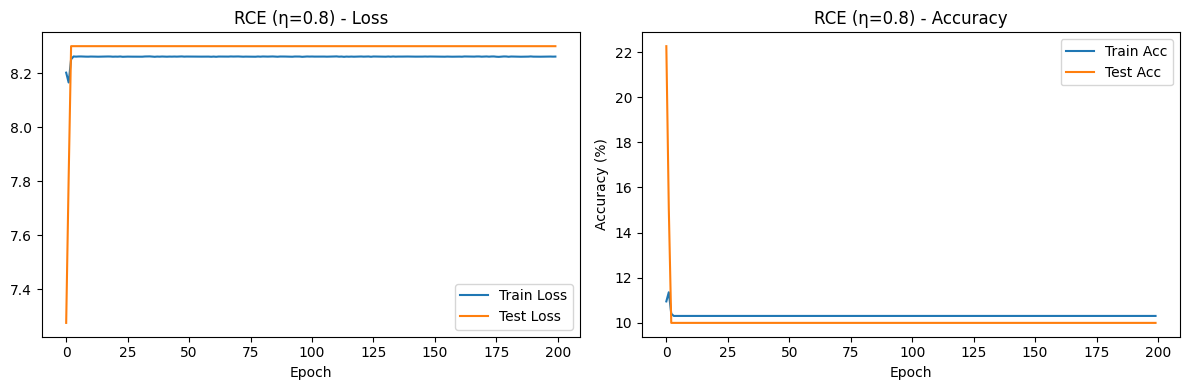


Training normalized Losses...
 - NCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 31.44% | Test Loss: 0.0662


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 36.03% | Test Loss: 0.0477


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 37.10% | Test Loss: 0.0405


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 40.22% | Test Loss: 0.0345


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 39.16% | Test Loss: 0.0338


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 41.73% | Test Loss: 0.0300


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 40.93% | Test Loss: 0.0295


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 39.60% | Test Loss: 0.0301


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 39.60% | Test Loss: 0.0279


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 42.87% | Test Loss: 0.0265


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 43.41% | Test Loss: 0.0268


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 41.39% | Test Loss: 0.0278


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 42.64% | Test Loss: 0.0251


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 42.40% | Test Loss: 0.0258


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 43.14% | Test Loss: 0.0242


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 42.83% | Test Loss: 0.0269


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 44.32% | Test Loss: 0.0232


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 44.47% | Test Loss: 0.0228


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 43.76% | Test Loss: 0.0238


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 44.43% | Test Loss: 0.0231


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 43.20% | Test Loss: 0.0235


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 44.20% | Test Loss: 0.0214


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 45.24% | Test Loss: 0.0216


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 44.83% | Test Loss: 0.0231


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 44.25% | Test Loss: 0.0215


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 45.49% | Test Loss: 0.0210


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 43.24% | Test Loss: 0.0222


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 43.60% | Test Loss: 0.0237


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 43.71% | Test Loss: 0.0220


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 46.02% | Test Loss: 0.0201


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 46.82% | Test Loss: 0.0199


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 43.68% | Test Loss: 0.0212


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 44.75% | Test Loss: 0.0212


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 44.07% | Test Loss: 0.0224


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 46.33% | Test Loss: 0.0191


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 46.18% | Test Loss: 0.0200


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 46.38% | Test Loss: 0.0206


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 46.04% | Test Loss: 0.0187


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 45.92% | Test Loss: 0.0217


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 44.92% | Test Loss: 0.0219


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 43.74% | Test Loss: 0.0206


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 44.73% | Test Loss: 0.0222


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 45.85% | Test Loss: 0.0202


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 44.42% | Test Loss: 0.0208


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 46.28% | Test Loss: 0.0209


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 44.39% | Test Loss: 0.0215


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 42.97% | Test Loss: 0.0219


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 43.57% | Test Loss: 0.0208


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 41.21% | Test Loss: 0.0223


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 47.58% | Test Loss: 0.0189


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 45.70% | Test Loss: 0.0201


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 43.70% | Test Loss: 0.0206


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 44.39% | Test Loss: 0.0207


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 44.43% | Test Loss: 0.0219


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 43.30% | Test Loss: 0.0218


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 41.45% | Test Loss: 0.0244


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 45.01% | Test Loss: 0.0223


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 43.55% | Test Loss: 0.0211


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 45.37% | Test Loss: 0.0188


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 40.63% | Test Loss: 0.0297


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 41.32% | Test Loss: 0.0224


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 45.74% | Test Loss: 0.0221


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 44.49% | Test Loss: 0.0225


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 44.48% | Test Loss: 0.0188


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 41.90% | Test Loss: 0.0228


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 43.93% | Test Loss: 0.0230


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 41.02% | Test Loss: 0.0221


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 40.19% | Test Loss: 0.0308


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 43.61% | Test Loss: 0.0233


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 42.60% | Test Loss: 0.0239


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 40.48% | Test Loss: 0.0261


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 41.65% | Test Loss: 0.0200


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 44.23% | Test Loss: 0.0230


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 44.21% | Test Loss: 0.0227


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 42.64% | Test Loss: 0.0215


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 44.43% | Test Loss: 0.0237


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 40.65% | Test Loss: 0.0211


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 43.34% | Test Loss: 0.0214


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 41.93% | Test Loss: 0.0217


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 40.18% | Test Loss: 0.0231


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 43.66% | Test Loss: 0.0212


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 42.02% | Test Loss: 0.0236


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 40.56% | Test Loss: 0.0250


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 44.13% | Test Loss: 0.0223


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 41.33% | Test Loss: 0.0225


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 44.16% | Test Loss: 0.0187


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 42.68% | Test Loss: 0.0208


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 41.77% | Test Loss: 0.0269


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 44.07% | Test Loss: 0.0239


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 43.58% | Test Loss: 0.0263


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 43.95% | Test Loss: 0.0222


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 46.34% | Test Loss: 0.0231


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 41.17% | Test Loss: 0.0305


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 44.75% | Test Loss: 0.0259


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 41.48% | Test Loss: 0.0327


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 44.57% | Test Loss: 0.0188


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 42.16% | Test Loss: 0.0344


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 44.24% | Test Loss: 0.0242


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 43.75% | Test Loss: 0.0224


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 44.01% | Test Loss: 0.0261


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 42.35% | Test Loss: 0.0269


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 42.97% | Test Loss: 0.0238


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 40.80% | Test Loss: 0.0272


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 43.73% | Test Loss: 0.0248


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 41.82% | Test Loss: 0.0197


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 42.52% | Test Loss: 0.0272


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 43.46% | Test Loss: 0.0246


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 37.24% | Test Loss: 0.0259


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 44.53% | Test Loss: 0.0287


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 40.71% | Test Loss: 0.0258


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 42.70% | Test Loss: 0.0317


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 45.14% | Test Loss: 0.0222


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 41.09% | Test Loss: 0.0302


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 44.17% | Test Loss: 0.0273


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 42.65% | Test Loss: 0.0250


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 45.48% | Test Loss: 0.0225


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 43.93% | Test Loss: 0.0214


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 42.02% | Test Loss: 0.0343


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 43.16% | Test Loss: 0.0209


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 42.74% | Test Loss: 0.0304


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 43.47% | Test Loss: 0.0245


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 40.91% | Test Loss: 0.0278


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 42.53% | Test Loss: 0.0252


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 40.79% | Test Loss: 0.0356


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 43.16% | Test Loss: 0.0262


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 39.54% | Test Loss: 0.0379


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 40.50% | Test Loss: 0.0320


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 39.79% | Test Loss: 0.0344


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 42.36% | Test Loss: 0.0281


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 39.89% | Test Loss: 0.0360


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 41.32% | Test Loss: 0.0268


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 40.91% | Test Loss: 0.0273


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 42.98% | Test Loss: 0.0255


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 40.75% | Test Loss: 0.0379


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 41.42% | Test Loss: 0.0341


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 38.33% | Test Loss: 0.0248


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 39.81% | Test Loss: 0.0320


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 42.28% | Test Loss: 0.0293


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 40.46% | Test Loss: 0.0257


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 38.97% | Test Loss: 0.0336


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 39.63% | Test Loss: 0.0273


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 41.55% | Test Loss: 0.0277


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 41.71% | Test Loss: 0.0325


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 41.53% | Test Loss: 0.0317


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 39.33% | Test Loss: 0.0367


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 40.50% | Test Loss: 0.0331


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 40.62% | Test Loss: 0.0290


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 39.49% | Test Loss: 0.0386


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 41.33% | Test Loss: 0.0304


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 39.09% | Test Loss: 0.0346


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 41.01% | Test Loss: 0.0251


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 39.99% | Test Loss: 0.0284


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 38.11% | Test Loss: 0.0331


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 41.37% | Test Loss: 0.0305


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 40.03% | Test Loss: 0.0274


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 38.38% | Test Loss: 0.0320


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 39.66% | Test Loss: 0.0374


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 40.04% | Test Loss: 0.0328


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 39.96% | Test Loss: 0.0294


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 39.93% | Test Loss: 0.0375


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 40.10% | Test Loss: 0.0309


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 39.95% | Test Loss: 0.0344


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 40.07% | Test Loss: 0.0372


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 38.31% | Test Loss: 0.0344


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 40.06% | Test Loss: 0.0321


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 38.99% | Test Loss: 0.0327


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 38.69% | Test Loss: 0.0303


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 38.77% | Test Loss: 0.0307


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 38.17% | Test Loss: 0.0366


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 38.87% | Test Loss: 0.0347


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 38.37% | Test Loss: 0.0349


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 39.83% | Test Loss: 0.0316


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 39.01% | Test Loss: 0.0342


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 39.72% | Test Loss: 0.0327


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 38.12% | Test Loss: 0.0388


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 39.66% | Test Loss: 0.0343


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 38.03% | Test Loss: 0.0336


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 38.37% | Test Loss: 0.0347


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 38.41% | Test Loss: 0.0334


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 38.38% | Test Loss: 0.0378


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 38.24% | Test Loss: 0.0361


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 38.17% | Test Loss: 0.0377


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 37.86% | Test Loss: 0.0357


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 37.73% | Test Loss: 0.0386


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 38.18% | Test Loss: 0.0332


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 37.98% | Test Loss: 0.0353


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 37.52% | Test Loss: 0.0373


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 38.13% | Test Loss: 0.0379


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 38.26% | Test Loss: 0.0376


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 38.20% | Test Loss: 0.0359


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 38.14% | Test Loss: 0.0374


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 38.19% | Test Loss: 0.0365


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 37.98% | Test Loss: 0.0375


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 38.19% | Test Loss: 0.0367


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 38.00% | Test Loss: 0.0370


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 38.19% | Test Loss: 0.0360


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 38.05% | Test Loss: 0.0361


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 37.98% | Test Loss: 0.0363


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 38.08% | Test Loss: 0.0364


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 38.00% | Test Loss: 0.0364


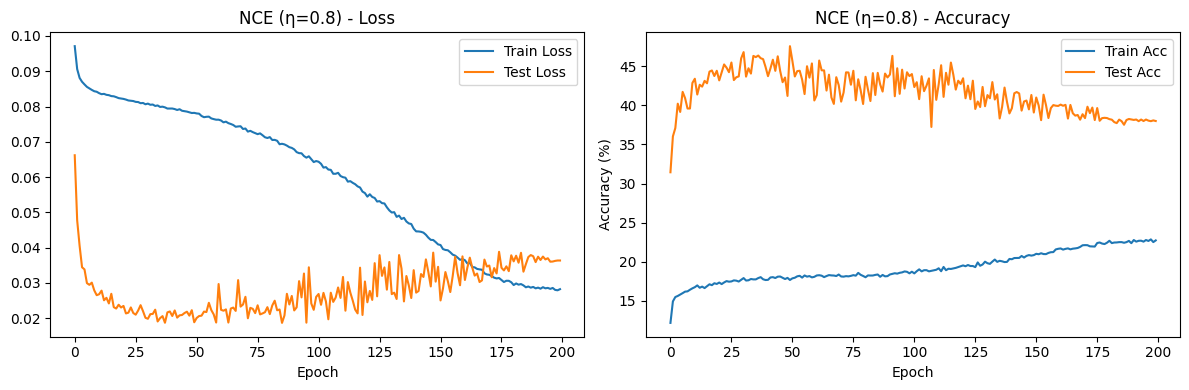

 - NRCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.78it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.10it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.01it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 10.00% | Test Loss: 18.6306


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 10.00% | Test Loss: 18.6305


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 10.00% | Test Loss: 18.6307


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.98it/s]


Test Acc: 10.00% | Test Loss: 18.6304


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 10.00% | Test Loss: 18.6304


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 10.00% | Test Loss: 18.6140


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 10.00% | Test Loss: 18.6307


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 10.00% | Test Loss: 18.6300


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 10.00% | Test Loss: 18.6300


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 10.00% | Test Loss: 18.6307


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 10.00% | Test Loss: 18.6306


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 13.76% | Test Loss: 17.7394


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 10.00% | Test Loss: 18.6295


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.04it/s]


Test Acc: 10.00% | Test Loss: 18.6229


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 10.00% | Test Loss: 18.5570


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 11.39% | Test Loss: 18.3401


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 10.95% | Test Loss: 18.4393


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.32it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 10.00% | Test Loss: 18.6306


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 10.00% | Test Loss: 18.6303


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.22it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 10.00% | Test Loss: 18.6308


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 9.99% | Test Loss: 18.6326


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 11.90% | Test Loss: 18.2287


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 12.99% | Test Loss: 18.0355


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 12.98% | Test Loss: 18.0404


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 13.28% | Test Loss: 17.9604


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 13.38% | Test Loss: 17.9692


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 14.18% | Test Loss: 17.7940


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 13.64% | Test Loss: 17.8985


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 11.74% | Test Loss: 18.2716


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.04it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.24it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 10.00% | Test Loss: 18.6309


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 10.00% | Test Loss: 18.6309


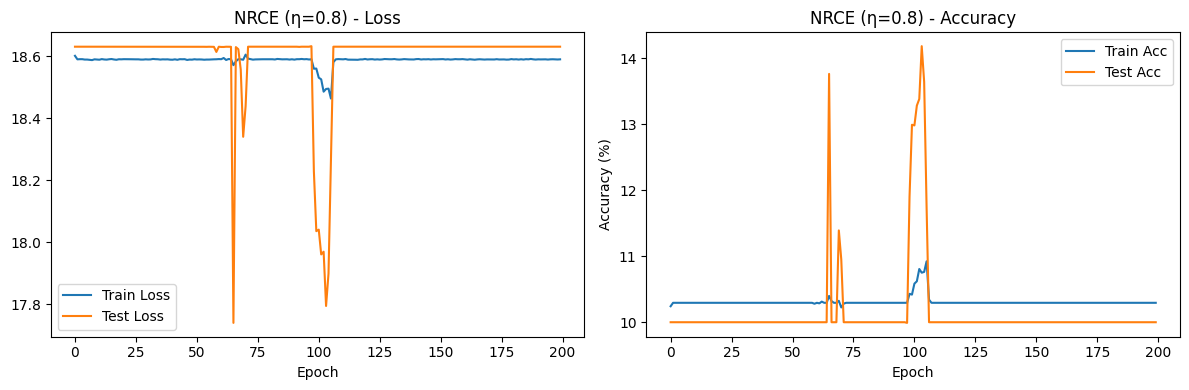

 - NFL


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 28.56% | Test Loss: 0.3819


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 31.11% | Test Loss: 0.2770


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 33.12% | Test Loss: 0.2641


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 34.35% | Test Loss: 0.2361


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 37.36% | Test Loss: 0.2188


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 35.67% | Test Loss: 0.2127


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 34.09% | Test Loss: 0.2161


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 28.14% | Test Loss: 0.2532


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 32.98% | Test Loss: 0.2107


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 38.28% | Test Loss: 0.1827


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 33.15% | Test Loss: 0.1845


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 35.30% | Test Loss: 0.1867


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 34.41% | Test Loss: 0.1929


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 36.57% | Test Loss: 0.1733


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 33.87% | Test Loss: 0.1782


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 34.24% | Test Loss: 0.1843


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 31.57% | Test Loss: 0.1796


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 36.37% | Test Loss: 0.1672


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 31.44% | Test Loss: 0.1702


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 35.43% | Test Loss: 0.1849


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 33.62% | Test Loss: 0.1452


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 34.44% | Test Loss: 0.1574


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 35.10% | Test Loss: 0.1782


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 30.45% | Test Loss: 0.1652


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 32.47% | Test Loss: 0.1829


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 34.25% | Test Loss: 0.1646


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 28.43% | Test Loss: 0.1771


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 34.61% | Test Loss: 0.1517


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 29.94% | Test Loss: 0.1610


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 33.10% | Test Loss: 0.1461


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 33.10% | Test Loss: 0.1311


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 35.51% | Test Loss: 0.1426


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 37.43% | Test Loss: 0.1308


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 33.11% | Test Loss: 0.1496


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 32.42% | Test Loss: 0.1559


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 29.79% | Test Loss: 0.1710


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 31.43% | Test Loss: 0.1503


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 34.49% | Test Loss: 0.1374


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 32.15% | Test Loss: 0.1531


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 30.80% | Test Loss: 0.1537


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 30.70% | Test Loss: 0.1486


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 33.40% | Test Loss: 0.1387


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 33.29% | Test Loss: 0.1320


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 30.65% | Test Loss: 0.1370


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 34.32% | Test Loss: 0.1320


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 35.41% | Test Loss: 0.1354


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 33.30% | Test Loss: 0.1373


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 37.35% | Test Loss: 0.1398


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 35.38% | Test Loss: 0.1233


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 32.76% | Test Loss: 0.1506


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 33.10% | Test Loss: 0.1474


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 34.72% | Test Loss: 0.1446


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 34.70% | Test Loss: 0.1260


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.29it/s]


Test Acc: 29.26% | Test Loss: 0.1565


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 35.81% | Test Loss: 0.1391


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 32.19% | Test Loss: 0.1628


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 37.03% | Test Loss: 0.1438


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 38.07% | Test Loss: 0.1344


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 32.21% | Test Loss: 0.1541


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 30.70% | Test Loss: 0.1815


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 36.28% | Test Loss: 0.1338


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 38.15% | Test Loss: 0.1169


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 34.29% | Test Loss: 0.1318


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 32.52% | Test Loss: 0.1252


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.92it/s]


Test Acc: 35.64% | Test Loss: 0.1246


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 36.48% | Test Loss: 0.1493


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 37.20% | Test Loss: 0.1206


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 36.34% | Test Loss: 0.1620


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 35.68% | Test Loss: 0.1628


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 34.07% | Test Loss: 0.1549


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 33.81% | Test Loss: 0.1438


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 34.46% | Test Loss: 0.1418


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 37.37% | Test Loss: 0.1792


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 37.43% | Test Loss: 0.1620


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 35.57% | Test Loss: 0.1122


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 36.33% | Test Loss: 0.1512


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 39.05% | Test Loss: 0.1523


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 36.89% | Test Loss: 0.1375


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 35.00% | Test Loss: 0.1627


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.28it/s]


Test Acc: 38.23% | Test Loss: 0.1426


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 38.71% | Test Loss: 0.1636


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 37.93% | Test Loss: 0.1516


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 34.42% | Test Loss: 0.1347


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 36.78% | Test Loss: 0.1482


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 34.85% | Test Loss: 0.1383


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 36.34% | Test Loss: 0.1332


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 36.46% | Test Loss: 0.1277


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 37.49% | Test Loss: 0.1454


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 39.73% | Test Loss: 0.1495


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 38.30% | Test Loss: 0.1261


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 33.68% | Test Loss: 0.1484


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 36.85% | Test Loss: 0.1628


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 38.44% | Test Loss: 0.1301


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 36.36% | Test Loss: 0.1707


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 37.94% | Test Loss: 0.1575


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 39.10% | Test Loss: 0.1481


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 38.49% | Test Loss: 0.1403


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 37.83% | Test Loss: 0.1442


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 38.76% | Test Loss: 0.1503


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 37.41% | Test Loss: 0.1622


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 35.53% | Test Loss: 0.1495


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 39.22% | Test Loss: 0.1722


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 37.17% | Test Loss: 0.1542


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 37.21% | Test Loss: 0.1330


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 37.38% | Test Loss: 0.1444


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 40.10% | Test Loss: 0.1292


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 36.79% | Test Loss: 0.1232


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 40.58% | Test Loss: 0.1844


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 39.46% | Test Loss: 0.1325


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 39.44% | Test Loss: 0.1925


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 37.88% | Test Loss: 0.1537


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 41.19% | Test Loss: 0.1529


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 38.95% | Test Loss: 0.1570


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 41.38% | Test Loss: 0.1516


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 37.20% | Test Loss: 0.2429


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 40.52% | Test Loss: 0.1478


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 37.69% | Test Loss: 0.2101


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 37.93% | Test Loss: 0.1517


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 40.03% | Test Loss: 0.1368


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 40.02% | Test Loss: 0.1541


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 38.75% | Test Loss: 0.1571


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 36.99% | Test Loss: 0.1655


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 38.63% | Test Loss: 0.1700


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 39.21% | Test Loss: 0.1604


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 36.55% | Test Loss: 0.1572


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 37.67% | Test Loss: 0.1674


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.09it/s]


Test Acc: 38.99% | Test Loss: 0.1466


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 39.00% | Test Loss: 0.1729


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 40.73% | Test Loss: 0.1730


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 41.30% | Test Loss: 0.1808


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 38.11% | Test Loss: 0.1836


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 38.23% | Test Loss: 0.1547


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 37.98% | Test Loss: 0.1682


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 40.69% | Test Loss: 0.1707


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 39.58% | Test Loss: 0.1710


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 40.35% | Test Loss: 0.1483


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 39.36% | Test Loss: 0.1532


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 40.83% | Test Loss: 0.1679


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 38.18% | Test Loss: 0.1643


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 38.12% | Test Loss: 0.1625


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 39.16% | Test Loss: 0.1906


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 39.31% | Test Loss: 0.1648


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 39.11% | Test Loss: 0.1802


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 40.00% | Test Loss: 0.1849


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 37.44% | Test Loss: 0.1754


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 38.86% | Test Loss: 0.1789


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 40.31% | Test Loss: 0.1738


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 37.69% | Test Loss: 0.1751


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 40.01% | Test Loss: 0.1959


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 39.42% | Test Loss: 0.1680


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 38.52% | Test Loss: 0.1844


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 38.26% | Test Loss: 0.1827


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 38.04% | Test Loss: 0.1878


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 38.19% | Test Loss: 0.1745


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 38.86% | Test Loss: 0.1658


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 38.24% | Test Loss: 0.1755


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 38.23% | Test Loss: 0.1723


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 37.88% | Test Loss: 0.1710


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 38.49% | Test Loss: 0.1768


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 38.19% | Test Loss: 0.1760


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 38.92% | Test Loss: 0.1736


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 37.08% | Test Loss: 0.1782


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 37.54% | Test Loss: 0.1988


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 38.17% | Test Loss: 0.1944


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 38.62% | Test Loss: 0.1841


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 37.16% | Test Loss: 0.1828


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 37.61% | Test Loss: 0.1947


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 38.82% | Test Loss: 0.1924


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 38.19% | Test Loss: 0.1913


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 37.91% | Test Loss: 0.1929


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 38.12% | Test Loss: 0.1865


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 37.29% | Test Loss: 0.1997


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 37.91% | Test Loss: 0.1850


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 36.97% | Test Loss: 0.1885


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 37.54% | Test Loss: 0.1940


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 37.87% | Test Loss: 0.1877


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 36.75% | Test Loss: 0.1901


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 36.90% | Test Loss: 0.1904


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 36.96% | Test Loss: 0.1821


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 36.41% | Test Loss: 0.1942


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 36.96% | Test Loss: 0.1887


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 36.23% | Test Loss: 0.1908


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 36.34% | Test Loss: 0.1935


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 36.59% | Test Loss: 0.1891


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 36.57% | Test Loss: 0.1923


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 36.33% | Test Loss: 0.1981


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 36.15% | Test Loss: 0.1950


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 36.27% | Test Loss: 0.1960


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 36.31% | Test Loss: 0.1945


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 36.32% | Test Loss: 0.1919


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 36.11% | Test Loss: 0.1986


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 36.28% | Test Loss: 0.1935


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 36.30% | Test Loss: 0.1975


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 36.56% | Test Loss: 0.1978


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 36.45% | Test Loss: 0.1990


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 36.24% | Test Loss: 0.1976


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 36.38% | Test Loss: 0.1975


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 36.46% | Test Loss: 0.1987


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 36.19% | Test Loss: 0.1960


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 36.39% | Test Loss: 0.1986


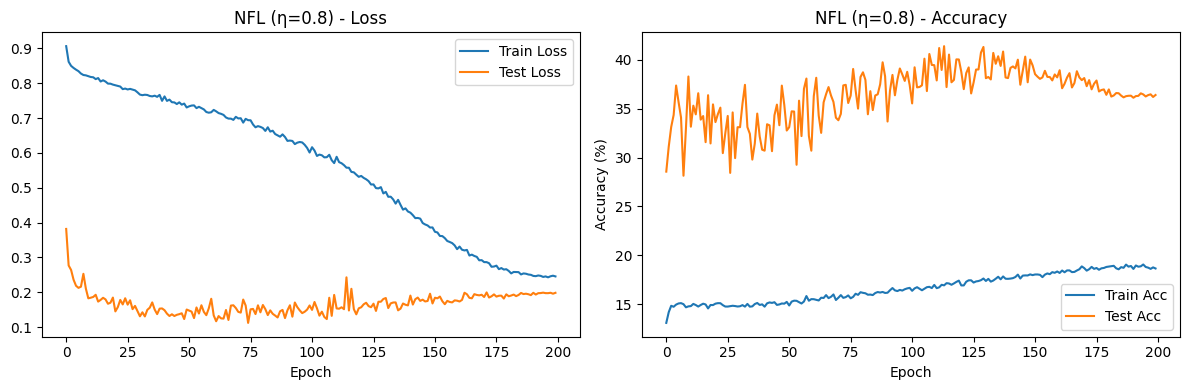


Training apl Losses...
 - NCE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 10.00% | Test Loss: 8.3995


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 10.00% | Test Loss: 8.3994


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 10.00% | Test Loss: 8.3993


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 10.00% | Test Loss: 8.3992


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 10.00% | Test Loss: 8.3991


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 10.00% | Test Loss: 8.3990


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 10.00% | Test Loss: 8.3989


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 10.00% | Test Loss: 8.3987


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.12it/s]


Test Acc: 10.00% | Test Loss: 8.3985


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 10.00% | Test Loss: 8.3982


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 10.00% | Test Loss: 8.3978


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 10.00% | Test Loss: 8.3973


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 10.00% | Test Loss: 8.3966


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 10.00% | Test Loss: 8.3954


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 10.00% | Test Loss: 8.3934


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 10.06% | Test Loss: 8.3864


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 10.00% | Test Loss: 8.3908


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 10.00% | Test Loss: 8.3971


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.45it/s]


Test Acc: 10.00% | Test Loss: 8.3954


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 10.00% | Test Loss: 8.3932


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 16.59% | Test Loss: 7.7822


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 15.03% | Test Loss: 7.9188


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 16.93% | Test Loss: 7.7442


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 16.63% | Test Loss: 7.7678


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.09it/s]


Test Acc: 10.00% | Test Loss: 8.3973


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 10.00% | Test Loss: 8.3979


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 10.00% | Test Loss: 8.3972


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 10.00% | Test Loss: 8.3964


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 10.00% | Test Loss: 8.3951


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 10.00% | Test Loss: 8.3930


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 10.00% | Test Loss: 8.3887


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 16.09% | Test Loss: 7.8244


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 16.43% | Test Loss: 7.7908


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 16.14% | Test Loss: 7.8250


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 15.70% | Test Loss: 7.8505


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 13.60% | Test Loss: 8.0682


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 13.90% | Test Loss: 8.0162


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 10.00% | Test Loss: 8.3701


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 10.00% | Test Loss: 8.3661


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 10.00% | Test Loss: 8.3644


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 13.84% | Test Loss: 8.0124


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 18.03% | Test Loss: 7.6200


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 16.90% | Test Loss: 7.7301


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 16.68% | Test Loss: 7.7713


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 16.41% | Test Loss: 7.7978


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 10.00% | Test Loss: 8.3985


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 10.00% | Test Loss: 8.3984


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 10.00% | Test Loss: 8.3982


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 10.00% | Test Loss: 8.3981


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 10.00% | Test Loss: 8.3978


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 10.01% | Test Loss: 8.3969


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 10.01% | Test Loss: 8.3966


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 10.10% | Test Loss: 8.3896


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 14.22% | Test Loss: 8.0047


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 16.78% | Test Loss: 7.7595


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 16.69% | Test Loss: 7.7684


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 16.72% | Test Loss: 7.7636


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 16.74% | Test Loss: 7.7590


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 16.86% | Test Loss: 7.7484


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 16.85% | Test Loss: 7.7488


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 16.82% | Test Loss: 7.7492


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 16.66% | Test Loss: 7.7634


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 16.84% | Test Loss: 7.7397


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 17.10% | Test Loss: 7.7097


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 17.46% | Test Loss: 7.6647


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 17.70% | Test Loss: 7.6696


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 18.60% | Test Loss: 7.5822


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 18.64% | Test Loss: 7.5797


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.63it/s]


Test Acc: 18.03% | Test Loss: 7.6384


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 18.86% | Test Loss: 7.5612


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 17.99% | Test Loss: 7.6393


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 18.10% | Test Loss: 7.6270


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 19.40% | Test Loss: 7.5441


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 19.50% | Test Loss: 7.4937


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 17.32% | Test Loss: 7.7092


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 17.84% | Test Loss: 7.6562


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 14.94% | Test Loss: 7.8722


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 18.40% | Test Loss: 7.5954


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 18.02% | Test Loss: 7.6228


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 18.46% | Test Loss: 7.5855


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 19.41% | Test Loss: 7.4991


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 16.57% | Test Loss: 7.7547


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 17.03% | Test Loss: 7.7152


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 17.81% | Test Loss: 7.6830


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 16.61% | Test Loss: 7.7559


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 18.01% | Test Loss: 7.6326


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 20.46% | Test Loss: 7.3956


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 20.51% | Test Loss: 7.4026


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 19.46% | Test Loss: 7.4927


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 19.01% | Test Loss: 7.5327


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 22.03% | Test Loss: 7.2534


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 19.90% | Test Loss: 7.4594


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 21.59% | Test Loss: 7.2976


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 18.06% | Test Loss: 7.6248


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 23.19% | Test Loss: 7.1494


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 24.32% | Test Loss: 7.0525


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 23.05% | Test Loss: 7.1618


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 21.38% | Test Loss: 7.3006


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 20.61% | Test Loss: 7.3822


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 19.72% | Test Loss: 7.4623


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 21.50% | Test Loss: 7.2983


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 23.38% | Test Loss: 7.1188


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 22.10% | Test Loss: 7.2433


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 25.00% | Test Loss: 6.9759


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 18.93% | Test Loss: 7.5351


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 18.43% | Test Loss: 7.5769


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 20.63% | Test Loss: 7.3783


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 19.77% | Test Loss: 7.4605


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 20.14% | Test Loss: 7.4262


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 23.06% | Test Loss: 7.1568


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 24.88% | Test Loss: 6.9839


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 25.07% | Test Loss: 6.9638


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.92it/s]


Test Acc: 21.91% | Test Loss: 7.2601


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 22.41% | Test Loss: 7.2186


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 22.25% | Test Loss: 7.2292


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 21.60% | Test Loss: 7.2931


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 23.35% | Test Loss: 7.1194


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 22.64% | Test Loss: 7.1925


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.79it/s]


Test Acc: 23.68% | Test Loss: 7.0989


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 23.96% | Test Loss: 7.0683


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 23.73% | Test Loss: 7.0925


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 24.03% | Test Loss: 7.0604


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 24.11% | Test Loss: 7.0574


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 24.76% | Test Loss: 6.9941


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 25.60% | Test Loss: 6.9161


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 24.39% | Test Loss: 7.0237


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 24.59% | Test Loss: 7.0097


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 24.33% | Test Loss: 7.0306


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 24.64% | Test Loss: 7.0021


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 25.27% | Test Loss: 6.9473


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 24.84% | Test Loss: 6.9917


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 25.66% | Test Loss: 6.9107


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 25.94% | Test Loss: 6.8857


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 26.07% | Test Loss: 6.8732


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 24.99% | Test Loss: 6.9705


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 25.02% | Test Loss: 6.9696


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 24.72% | Test Loss: 6.9998


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 25.52% | Test Loss: 6.9255


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 25.83% | Test Loss: 6.8982


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 25.83% | Test Loss: 6.8988


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 25.22% | Test Loss: 6.9599


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 25.39% | Test Loss: 6.9379


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 26.07% | Test Loss: 6.8678


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 25.77% | Test Loss: 6.8999


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 25.95% | Test Loss: 6.8746


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 26.02% | Test Loss: 6.8760


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 26.71% | Test Loss: 6.8119


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 27.04% | Test Loss: 6.7876


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 27.61% | Test Loss: 6.7348


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 28.66% | Test Loss: 6.6365


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 28.60% | Test Loss: 6.6396


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 28.76% | Test Loss: 6.6200


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 29.27% | Test Loss: 6.5708


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 30.03% | Test Loss: 6.5140


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 29.88% | Test Loss: 6.5282


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 29.11% | Test Loss: 6.5851


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 29.34% | Test Loss: 6.5755


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 28.98% | Test Loss: 6.6028


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 29.74% | Test Loss: 6.5351


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 30.01% | Test Loss: 6.5142


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 29.93% | Test Loss: 6.5091


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 29.76% | Test Loss: 6.5238


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 30.11% | Test Loss: 6.4974


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 30.12% | Test Loss: 6.4982


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 30.20% | Test Loss: 6.4930


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 29.57% | Test Loss: 6.5434


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.09it/s]


Test Acc: 29.79% | Test Loss: 6.5203


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 30.36% | Test Loss: 6.4791


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 30.28% | Test Loss: 6.4837


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 31.16% | Test Loss: 6.4108


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 30.54% | Test Loss: 6.4561


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 29.73% | Test Loss: 6.5373


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 30.66% | Test Loss: 6.4508


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 30.99% | Test Loss: 6.4294


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 30.67% | Test Loss: 6.4518


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 31.10% | Test Loss: 6.4136


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 30.99% | Test Loss: 6.4212


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 31.26% | Test Loss: 6.3969


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.10it/s]


Test Acc: 31.00% | Test Loss: 6.4178


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 30.64% | Test Loss: 6.4519


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 30.73% | Test Loss: 6.4351


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 31.20% | Test Loss: 6.3893


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 31.35% | Test Loss: 6.3915


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 31.50% | Test Loss: 6.3733


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 31.46% | Test Loss: 6.3788


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 31.46% | Test Loss: 6.3685


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 31.30% | Test Loss: 6.3853


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 31.61% | Test Loss: 6.3704


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 31.58% | Test Loss: 6.3652


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 31.65% | Test Loss: 6.3622


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 31.53% | Test Loss: 6.3698


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 31.48% | Test Loss: 6.3782


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 31.59% | Test Loss: 6.3693


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 31.58% | Test Loss: 6.3703


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 31.45% | Test Loss: 6.3683


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 31.60% | Test Loss: 6.3630


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 31.60% | Test Loss: 6.3642


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 31.58% | Test Loss: 6.3632


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 31.63% | Test Loss: 6.3672


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 31.57% | Test Loss: 6.3631


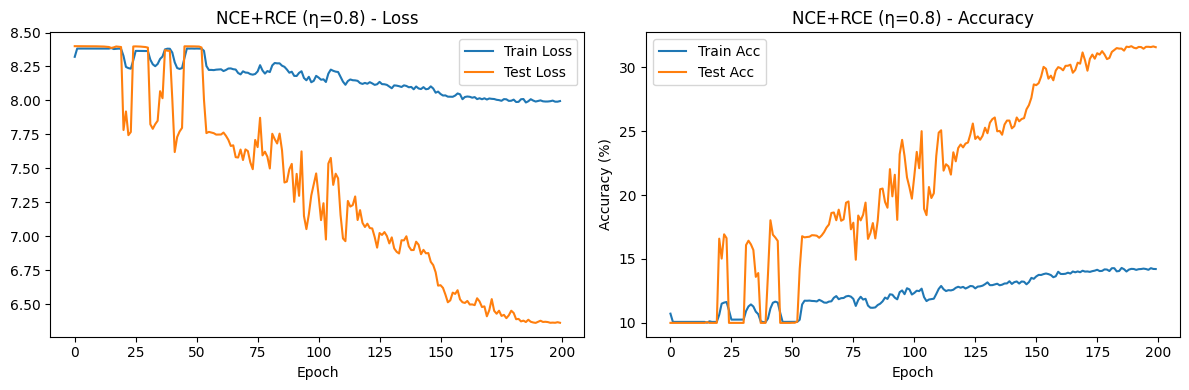

 - NCE+MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 24.13% | Test Loss: 0.8336


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 32.92% | Test Loss: 0.7254


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 38.31% | Test Loss: 0.6693


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 33.15% | Test Loss: 0.7235


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 39.44% | Test Loss: 0.6496


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 44.36% | Test Loss: 0.5992


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 44.69% | Test Loss: 0.5912


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 43.78% | Test Loss: 0.5996


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 45.72% | Test Loss: 0.5794


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 48.92% | Test Loss: 0.5459


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 48.55% | Test Loss: 0.5498


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 48.87% | Test Loss: 0.5453


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 49.73% | Test Loss: 0.5377


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 51.80% | Test Loss: 0.5148


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 49.59% | Test Loss: 0.5346


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 54.54% | Test Loss: 0.4841


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 52.82% | Test Loss: 0.5023


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 56.74% | Test Loss: 0.4636


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 55.62% | Test Loss: 0.4711


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 55.71% | Test Loss: 0.4702


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 55.50% | Test Loss: 0.4708


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 56.97% | Test Loss: 0.4544


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 59.81% | Test Loss: 0.4270


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 61.69% | Test Loss: 0.4052


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 59.86% | Test Loss: 0.4247


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 60.26% | Test Loss: 0.4207


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 59.98% | Test Loss: 0.4216


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 61.59% | Test Loss: 0.4082


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 63.90% | Test Loss: 0.3860


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 62.73% | Test Loss: 0.3948


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 61.48% | Test Loss: 0.4105


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 62.83% | Test Loss: 0.3926


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 64.73% | Test Loss: 0.3747


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 64.09% | Test Loss: 0.3805


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.55it/s]


Test Acc: 62.82% | Test Loss: 0.3940


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 63.54% | Test Loss: 0.3864


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 65.32% | Test Loss: 0.3689


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 66.89% | Test Loss: 0.3532


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 65.99% | Test Loss: 0.3637


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 65.65% | Test Loss: 0.3629


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 64.77% | Test Loss: 0.3743


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 67.31% | Test Loss: 0.3464


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 65.40% | Test Loss: 0.3642


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 68.00% | Test Loss: 0.3407


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 68.45% | Test Loss: 0.3359


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 67.35% | Test Loss: 0.3461


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 65.57% | Test Loss: 0.3673


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 67.08% | Test Loss: 0.3492


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 66.53% | Test Loss: 0.3552


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 68.31% | Test Loss: 0.3370


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.53it/s]


Test Acc: 68.29% | Test Loss: 0.3357


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 68.48% | Test Loss: 0.3337


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 67.69% | Test Loss: 0.3455


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 68.41% | Test Loss: 0.3343


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 68.15% | Test Loss: 0.3383


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 69.58% | Test Loss: 0.3212


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 68.00% | Test Loss: 0.3384


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 69.59% | Test Loss: 0.3225


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 68.73% | Test Loss: 0.3297


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 69.18% | Test Loss: 0.3279


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 69.51% | Test Loss: 0.3239


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 70.32% | Test Loss: 0.3174


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 71.47% | Test Loss: 0.3039


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 69.70% | Test Loss: 0.3219


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 69.70% | Test Loss: 0.3206


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 71.68% | Test Loss: 0.2998


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 70.88% | Test Loss: 0.3107


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 69.10% | Test Loss: 0.3255


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 70.75% | Test Loss: 0.3117


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 71.10% | Test Loss: 0.3070


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 70.39% | Test Loss: 0.3150


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 72.19% | Test Loss: 0.2959


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 71.70% | Test Loss: 0.3010


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 70.96% | Test Loss: 0.3082


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 72.23% | Test Loss: 0.2972


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 71.85% | Test Loss: 0.3004


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 69.57% | Test Loss: 0.3248


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 71.82% | Test Loss: 0.3017


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 71.27% | Test Loss: 0.3062


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 71.85% | Test Loss: 0.2996


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.21it/s]


Test Acc: 71.72% | Test Loss: 0.2997


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 70.95% | Test Loss: 0.3087


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 71.68% | Test Loss: 0.3039


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 68.24% | Test Loss: 0.3375


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 71.76% | Test Loss: 0.2975


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 71.55% | Test Loss: 0.3045


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 70.32% | Test Loss: 0.3168


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 71.83% | Test Loss: 0.3001


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 71.02% | Test Loss: 0.3079


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 71.58% | Test Loss: 0.3025


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 72.06% | Test Loss: 0.2968


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 71.46% | Test Loss: 0.3021


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 72.12% | Test Loss: 0.2988


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 70.78% | Test Loss: 0.3105


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 71.15% | Test Loss: 0.3086


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 71.15% | Test Loss: 0.3053


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 72.27% | Test Loss: 0.2952


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 72.28% | Test Loss: 0.2948


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 72.23% | Test Loss: 0.2970


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 70.89% | Test Loss: 0.3077


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 71.62% | Test Loss: 0.3026


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 71.69% | Test Loss: 0.3008


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 72.13% | Test Loss: 0.2959


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 71.40% | Test Loss: 0.3050


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 72.44% | Test Loss: 0.2946


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 70.62% | Test Loss: 0.3149


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 73.23% | Test Loss: 0.2857


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 72.79% | Test Loss: 0.2922


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 72.08% | Test Loss: 0.2992


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 71.92% | Test Loss: 0.3024


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 68.16% | Test Loss: 0.3384


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 71.84% | Test Loss: 0.3014


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 72.50% | Test Loss: 0.2942


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 71.46% | Test Loss: 0.3070


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 70.49% | Test Loss: 0.3143


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 71.97% | Test Loss: 0.2981


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 71.76% | Test Loss: 0.3020


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 71.50% | Test Loss: 0.3048


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 71.22% | Test Loss: 0.3082


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 72.13% | Test Loss: 0.2982


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 70.26% | Test Loss: 0.3174


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 71.20% | Test Loss: 0.3098


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 70.72% | Test Loss: 0.3127


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 71.08% | Test Loss: 0.3099


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 70.57% | Test Loss: 0.3147


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 70.84% | Test Loss: 0.3129


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 70.34% | Test Loss: 0.3161


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 71.74% | Test Loss: 0.3032


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 70.78% | Test Loss: 0.3140


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 70.36% | Test Loss: 0.3168


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 70.75% | Test Loss: 0.3131


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 70.58% | Test Loss: 0.3168


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 70.96% | Test Loss: 0.3129


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 69.83% | Test Loss: 0.3219


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 71.06% | Test Loss: 0.3109


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 69.47% | Test Loss: 0.3272


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 71.13% | Test Loss: 0.3119


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.84it/s]


Test Acc: 70.92% | Test Loss: 0.3127


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 69.90% | Test Loss: 0.3220


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 70.38% | Test Loss: 0.3193


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 70.69% | Test Loss: 0.3156


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 70.82% | Test Loss: 0.3129


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 69.83% | Test Loss: 0.3235


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 69.94% | Test Loss: 0.3207


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 69.88% | Test Loss: 0.3235


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 69.73% | Test Loss: 0.3247


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 70.18% | Test Loss: 0.3191


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.86it/s]


Test Acc: 70.23% | Test Loss: 0.3200


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 69.08% | Test Loss: 0.3332


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 69.38% | Test Loss: 0.3278


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 69.83% | Test Loss: 0.3239


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 69.52% | Test Loss: 0.3265


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 69.54% | Test Loss: 0.3274


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 69.27% | Test Loss: 0.3309


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 69.47% | Test Loss: 0.3290


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.77it/s]


Test Acc: 68.99% | Test Loss: 0.3319


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 69.82% | Test Loss: 0.3239


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 69.28% | Test Loss: 0.3297


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 69.60% | Test Loss: 0.3270


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.49it/s]


Test Acc: 69.00% | Test Loss: 0.3324


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 68.94% | Test Loss: 0.3345


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 68.75% | Test Loss: 0.3366


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 69.12% | Test Loss: 0.3345


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 68.56% | Test Loss: 0.3377


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 68.98% | Test Loss: 0.3352


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 68.30% | Test Loss: 0.3431


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 68.95% | Test Loss: 0.3353


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 68.43% | Test Loss: 0.3412


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 68.46% | Test Loss: 0.3391


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 69.21% | Test Loss: 0.3328


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 68.41% | Test Loss: 0.3396


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 68.36% | Test Loss: 0.3416


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 68.46% | Test Loss: 0.3393


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 68.51% | Test Loss: 0.3397


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 68.40% | Test Loss: 0.3421


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 67.69% | Test Loss: 0.3462


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 68.09% | Test Loss: 0.3453


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 68.45% | Test Loss: 0.3395


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 68.16% | Test Loss: 0.3418


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 68.21% | Test Loss: 0.3427


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 68.22% | Test Loss: 0.3422


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 67.95% | Test Loss: 0.3456


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 68.13% | Test Loss: 0.3430


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 68.22% | Test Loss: 0.3434


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 67.89% | Test Loss: 0.3464


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 67.49% | Test Loss: 0.3496


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 68.16% | Test Loss: 0.3452


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 67.45% | Test Loss: 0.3483


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 67.66% | Test Loss: 0.3477


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 67.59% | Test Loss: 0.3483


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 67.86% | Test Loss: 0.3475


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 67.80% | Test Loss: 0.3483


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 67.57% | Test Loss: 0.3487


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 67.69% | Test Loss: 0.3478


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 67.55% | Test Loss: 0.3496


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 67.61% | Test Loss: 0.3487


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 67.79% | Test Loss: 0.3479


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.86it/s]


Test Acc: 67.82% | Test Loss: 0.3470


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 67.41% | Test Loss: 0.3509


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 67.59% | Test Loss: 0.3481


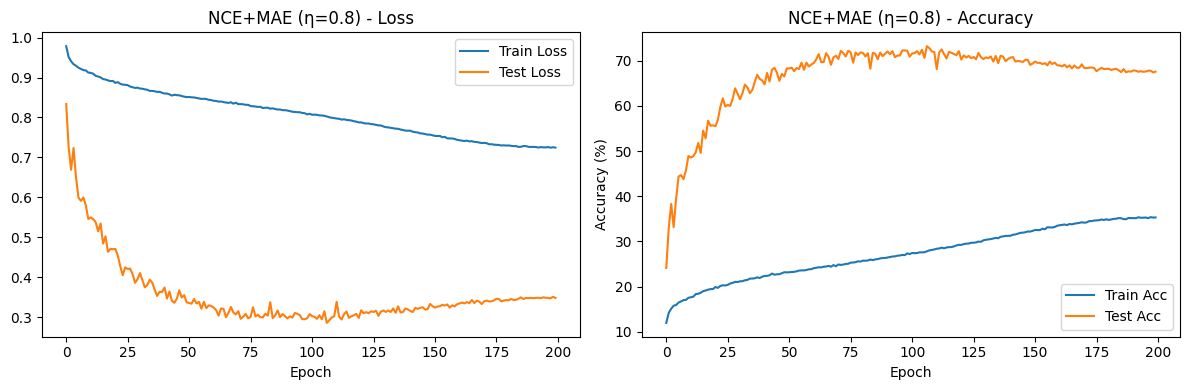

 - NFL+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 10.00% | Test Loss: 8.3926


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 10.00% | Test Loss: 8.3922


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 10.00% | Test Loss: 8.3916


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 10.00% | Test Loss: 8.3892


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 15.81% | Test Loss: 7.8521


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 16.30% | Test Loss: 7.8091


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 16.54% | Test Loss: 7.7661


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 13.98% | Test Loss: 8.0356


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 14.88% | Test Loss: 7.9290


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 14.23% | Test Loss: 8.0300


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 17.40% | Test Loss: 7.6857


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 20.60% | Test Loss: 7.4044


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 20.93% | Test Loss: 7.3784


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 18.33% | Test Loss: 7.6132


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 17.36% | Test Loss: 7.7026


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 17.89% | Test Loss: 7.6465


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 20.03% | Test Loss: 7.4537


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 20.84% | Test Loss: 7.3864


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 20.49% | Test Loss: 7.4131


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 19.54% | Test Loss: 7.5005


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 20.50% | Test Loss: 7.4181


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 21.48% | Test Loss: 7.3231


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 20.49% | Test Loss: 7.4125


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 21.91% | Test Loss: 7.2807


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.97it/s]


Test Acc: 14.61% | Test Loss: 7.9452


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 22.13% | Test Loss: 7.2474


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 22.75% | Test Loss: 7.2106


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.59it/s]


Test Acc: 21.63% | Test Loss: 7.3029


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 22.62% | Test Loss: 7.2094


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 20.30% | Test Loss: 7.4339


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 19.33% | Test Loss: 7.5265


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 18.13% | Test Loss: 7.6376


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 19.57% | Test Loss: 7.5057


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 19.00% | Test Loss: 7.5456


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.56it/s]


Test Acc: 18.96% | Test Loss: 7.5515


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 19.87% | Test Loss: 7.4661


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 17.64% | Test Loss: 7.6648


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 16.73% | Test Loss: 7.7502


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 16.18% | Test Loss: 7.8021


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 17.49% | Test Loss: 7.6799


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 13.12% | Test Loss: 8.0999


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 17.93% | Test Loss: 7.6399


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 18.00% | Test Loss: 7.6321


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 12.35% | Test Loss: 8.1724


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 17.05% | Test Loss: 7.7208


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 17.67% | Test Loss: 7.6630


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.79it/s]


Test Acc: 17.12% | Test Loss: 7.7158


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 16.44% | Test Loss: 7.7788


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 16.94% | Test Loss: 7.7318


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 16.75% | Test Loss: 7.7501


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 17.12% | Test Loss: 7.7129


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 17.49% | Test Loss: 7.6796


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 17.25% | Test Loss: 7.7021


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 16.39% | Test Loss: 7.7829


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 16.53% | Test Loss: 7.7668


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 15.41% | Test Loss: 7.8727


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 16.43% | Test Loss: 7.7776


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 17.24% | Test Loss: 7.7030


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 16.71% | Test Loss: 7.7514


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 16.98% | Test Loss: 7.7260


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 16.20% | Test Loss: 7.7979


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 12.53% | Test Loss: 8.1411


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 14.63% | Test Loss: 7.9450


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 16.00% | Test Loss: 7.8125


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 16.82% | Test Loss: 7.7464


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 14.39% | Test Loss: 7.9708


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 14.17% | Test Loss: 7.9919


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 15.81% | Test Loss: 7.8401


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 16.92% | Test Loss: 7.7356


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 17.17% | Test Loss: 7.7140


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 17.19% | Test Loss: 7.7146


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 17.42% | Test Loss: 7.6900


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 16.93% | Test Loss: 7.7280


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 17.46% | Test Loss: 7.6855


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 17.55% | Test Loss: 7.6775


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 17.33% | Test Loss: 7.6981


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 17.39% | Test Loss: 7.6916


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 17.38% | Test Loss: 7.6913


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.07it/s]


Test Acc: 17.24% | Test Loss: 7.7051


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 17.33% | Test Loss: 7.6968


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 17.18% | Test Loss: 7.7107


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 17.49% | Test Loss: 7.6831


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 17.23% | Test Loss: 7.7049


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 15.80% | Test Loss: 7.8394


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 17.18% | Test Loss: 7.7101


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 18.23% | Test Loss: 7.6115


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 15.92% | Test Loss: 7.8305


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 18.13% | Test Loss: 7.6186


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 18.66% | Test Loss: 7.5684


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 18.45% | Test Loss: 7.5920


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 18.33% | Test Loss: 7.6019


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 18.31% | Test Loss: 7.6029


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 18.57% | Test Loss: 7.5797


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 18.93% | Test Loss: 7.5404


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 19.12% | Test Loss: 7.5285


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.82it/s]


Test Acc: 19.12% | Test Loss: 7.5214


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 18.98% | Test Loss: 7.5401


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 19.03% | Test Loss: 7.5385


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 19.38% | Test Loss: 7.5034


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 19.84% | Test Loss: 7.4530


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 18.91% | Test Loss: 7.5503


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.10it/s]


Test Acc: 18.55% | Test Loss: 7.5806


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 18.96% | Test Loss: 7.5425


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 18.62% | Test Loss: 7.5685


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 19.22% | Test Loss: 7.5258


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 19.25% | Test Loss: 7.5120


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 19.88% | Test Loss: 7.4643


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 19.42% | Test Loss: 7.5013


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 18.19% | Test Loss: 7.5977


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.46it/s]


Test Acc: 18.18% | Test Loss: 7.5930


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 18.44% | Test Loss: 7.5705


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 18.67% | Test Loss: 7.5423


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 18.66% | Test Loss: 7.5519


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 18.10% | Test Loss: 7.6037


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 18.05% | Test Loss: 7.5965


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 18.32% | Test Loss: 7.5754


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 18.94% | Test Loss: 7.5232


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.11it/s]


Test Acc: 21.86% | Test Loss: 7.2753


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 19.13% | Test Loss: 7.5005


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 18.78% | Test Loss: 7.5348


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 19.51% | Test Loss: 7.4693


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 19.28% | Test Loss: 7.4894


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 19.53% | Test Loss: 7.4740


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 19.85% | Test Loss: 7.4471


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 19.57% | Test Loss: 7.4686


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 20.04% | Test Loss: 7.4240


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 20.05% | Test Loss: 7.4145


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 19.83% | Test Loss: 7.4395


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 21.26% | Test Loss: 7.3193


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 22.68% | Test Loss: 7.1883


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 23.48% | Test Loss: 7.1181


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 19.87% | Test Loss: 7.4391


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 20.36% | Test Loss: 7.3897


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 20.69% | Test Loss: 7.3565


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 20.66% | Test Loss: 7.3586


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 20.63% | Test Loss: 7.3647


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 20.21% | Test Loss: 7.4054


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 26.65% | Test Loss: 6.8175


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 26.69% | Test Loss: 6.8168


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 21.27% | Test Loss: 7.3021


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 21.17% | Test Loss: 7.3196


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 21.40% | Test Loss: 7.2929


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 26.81% | Test Loss: 6.8029


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 25.80% | Test Loss: 6.8924


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 26.76% | Test Loss: 6.8055


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 26.07% | Test Loss: 6.8733


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 26.74% | Test Loss: 6.8133


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 26.49% | Test Loss: 6.8308


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 26.47% | Test Loss: 6.8381


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 26.22% | Test Loss: 6.8534


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 26.74% | Test Loss: 6.8036


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 27.25% | Test Loss: 6.7628


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 27.36% | Test Loss: 6.7626


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 26.91% | Test Loss: 6.7932


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 26.93% | Test Loss: 6.7873


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 24.27% | Test Loss: 7.0249


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 26.86% | Test Loss: 6.7978


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 27.08% | Test Loss: 6.7734


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 26.20% | Test Loss: 6.8617


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 22.96% | Test Loss: 7.1511


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 23.39% | Test Loss: 7.1109


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 27.58% | Test Loss: 6.7311


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 27.35% | Test Loss: 6.7491


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 27.49% | Test Loss: 6.7416


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 27.50% | Test Loss: 6.7395


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 27.39% | Test Loss: 6.7471


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 27.50% | Test Loss: 6.7356


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 27.51% | Test Loss: 6.7331


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 27.75% | Test Loss: 6.7175


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 26.91% | Test Loss: 6.7921


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.87it/s]


Test Acc: 26.97% | Test Loss: 6.7846


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 27.08% | Test Loss: 6.7754


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 27.49% | Test Loss: 6.7418


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 27.10% | Test Loss: 6.7699


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 26.93% | Test Loss: 6.7912


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 27.68% | Test Loss: 6.7184


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 28.00% | Test Loss: 6.6896


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 28.09% | Test Loss: 6.6871


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 28.07% | Test Loss: 6.6852


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 27.91% | Test Loss: 6.6969


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 27.80% | Test Loss: 6.7066


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 27.99% | Test Loss: 6.6889


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 27.92% | Test Loss: 6.6977


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 27.92% | Test Loss: 6.6978


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 27.93% | Test Loss: 6.6993


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 27.87% | Test Loss: 6.6986


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 27.89% | Test Loss: 6.6974


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 28.07% | Test Loss: 6.6811


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 28.10% | Test Loss: 6.6804


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 28.16% | Test Loss: 6.6747


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 28.01% | Test Loss: 6.6910


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 28.09% | Test Loss: 6.6840


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 28.22% | Test Loss: 6.6740


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 28.08% | Test Loss: 6.6815


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.60it/s]


Test Acc: 28.26% | Test Loss: 6.6700


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 28.26% | Test Loss: 6.6700


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 28.21% | Test Loss: 6.6723


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 28.06% | Test Loss: 6.6862


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 28.27% | Test Loss: 6.6722


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 28.11% | Test Loss: 6.6830


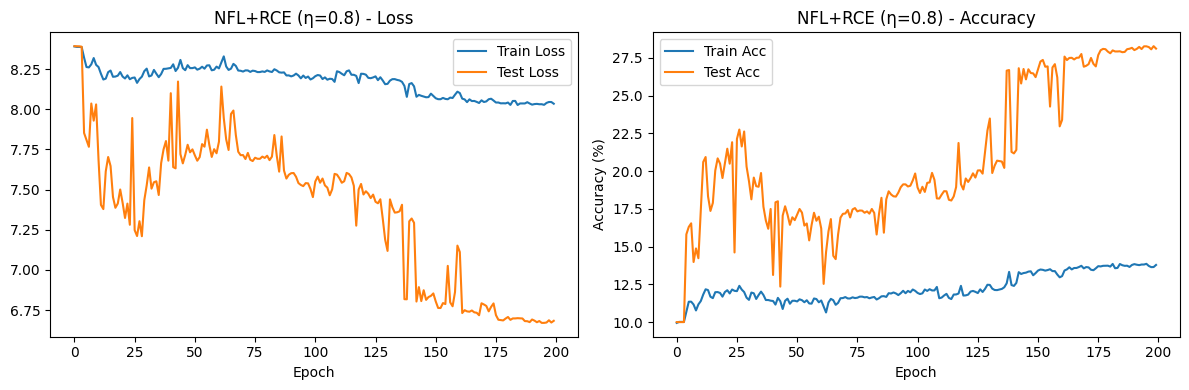

 - NFL+MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 28.57% | Test Loss: 0.7713


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 36.40% | Test Loss: 0.6887


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 41.88% | Test Loss: 0.6263


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 42.05% | Test Loss: 0.6222


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.81it/s]


Test Acc: 45.00% | Test Loss: 0.5906


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 46.60% | Test Loss: 0.5678


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 47.16% | Test Loss: 0.5669


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 49.11% | Test Loss: 0.5465


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 49.57% | Test Loss: 0.5380


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 51.12% | Test Loss: 0.5211


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 51.68% | Test Loss: 0.5143


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 53.88% | Test Loss: 0.4918


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 55.54% | Test Loss: 0.4706


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 53.38% | Test Loss: 0.4958


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 53.40% | Test Loss: 0.4959


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 56.76% | Test Loss: 0.4577


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 58.05% | Test Loss: 0.4439


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 58.01% | Test Loss: 0.4458


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 60.23% | Test Loss: 0.4192


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 59.71% | Test Loss: 0.4293


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 57.47% | Test Loss: 0.4497


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 58.55% | Test Loss: 0.4398


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 60.35% | Test Loss: 0.4188


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 61.53% | Test Loss: 0.4069


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 58.33% | Test Loss: 0.4424


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 62.27% | Test Loss: 0.4029


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 61.67% | Test Loss: 0.4042


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 62.03% | Test Loss: 0.4024


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 62.60% | Test Loss: 0.3956


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 63.00% | Test Loss: 0.3943


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 64.30% | Test Loss: 0.3771


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 64.19% | Test Loss: 0.3772


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 62.11% | Test Loss: 0.4030


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 61.36% | Test Loss: 0.4081


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 64.49% | Test Loss: 0.3763


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 65.34% | Test Loss: 0.3672


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 66.44% | Test Loss: 0.3551


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.04it/s]


Test Acc: 64.87% | Test Loss: 0.3724


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 59.38% | Test Loss: 0.4299


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 66.04% | Test Loss: 0.3590


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 67.05% | Test Loss: 0.3516


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 64.64% | Test Loss: 0.3736


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 67.57% | Test Loss: 0.3418


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 67.05% | Test Loss: 0.3485


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 66.43% | Test Loss: 0.3553


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 66.19% | Test Loss: 0.3587


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 66.41% | Test Loss: 0.3559


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 64.97% | Test Loss: 0.3678


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 67.93% | Test Loss: 0.3413


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.07it/s]


Test Acc: 69.95% | Test Loss: 0.3174


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 67.93% | Test Loss: 0.3399


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 67.60% | Test Loss: 0.3412


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 67.33% | Test Loss: 0.3452


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 67.03% | Test Loss: 0.3473


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 69.61% | Test Loss: 0.3222


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 66.32% | Test Loss: 0.3563


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 69.17% | Test Loss: 0.3259


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 69.94% | Test Loss: 0.3179


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 69.70% | Test Loss: 0.3200


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 68.76% | Test Loss: 0.3288


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 69.01% | Test Loss: 0.3294


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 69.79% | Test Loss: 0.3183


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 70.80% | Test Loss: 0.3106


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 69.75% | Test Loss: 0.3198


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 70.12% | Test Loss: 0.3177


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 68.87% | Test Loss: 0.3300


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 70.56% | Test Loss: 0.3119


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 69.41% | Test Loss: 0.3232


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 70.93% | Test Loss: 0.3097


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 71.36% | Test Loss: 0.3033


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 70.13% | Test Loss: 0.3161


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 70.57% | Test Loss: 0.3137


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.89it/s]


Test Acc: 70.70% | Test Loss: 0.3111


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 71.44% | Test Loss: 0.3036


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 71.60% | Test Loss: 0.3020


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 70.07% | Test Loss: 0.3157


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 69.96% | Test Loss: 0.3191


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 70.00% | Test Loss: 0.3174


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 68.97% | Test Loss: 0.3267


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 70.72% | Test Loss: 0.3115


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 69.29% | Test Loss: 0.3276


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 69.67% | Test Loss: 0.3224


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 72.58% | Test Loss: 0.2901


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 72.33% | Test Loss: 0.2951


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.97it/s]


Test Acc: 72.75% | Test Loss: 0.2913


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 72.23% | Test Loss: 0.2932


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 71.37% | Test Loss: 0.3008


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 71.32% | Test Loss: 0.3037


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 70.69% | Test Loss: 0.3067


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 71.48% | Test Loss: 0.3022


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 72.13% | Test Loss: 0.2953


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 71.36% | Test Loss: 0.3015


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 72.83% | Test Loss: 0.2881


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 71.17% | Test Loss: 0.3068


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 72.72% | Test Loss: 0.2903


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 71.93% | Test Loss: 0.2995


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 71.90% | Test Loss: 0.2978


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 70.71% | Test Loss: 0.3100


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 71.75% | Test Loss: 0.3012


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 72.07% | Test Loss: 0.2956


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 72.30% | Test Loss: 0.2924


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 71.90% | Test Loss: 0.2981


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 72.24% | Test Loss: 0.2963


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 72.00% | Test Loss: 0.2969


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 72.14% | Test Loss: 0.2947


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 72.35% | Test Loss: 0.2940


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 72.77% | Test Loss: 0.2892


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 71.14% | Test Loss: 0.3065


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 71.32% | Test Loss: 0.3057


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 71.83% | Test Loss: 0.3004


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 71.49% | Test Loss: 0.3038


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 70.97% | Test Loss: 0.3076


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 71.40% | Test Loss: 0.3030


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 71.32% | Test Loss: 0.3047


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.91it/s]


Test Acc: 71.29% | Test Loss: 0.3037


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 71.77% | Test Loss: 0.2985


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 70.45% | Test Loss: 0.3118


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 70.95% | Test Loss: 0.3120


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 71.00% | Test Loss: 0.3070


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 71.49% | Test Loss: 0.3025


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 70.80% | Test Loss: 0.3085


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 71.28% | Test Loss: 0.3056


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 70.37% | Test Loss: 0.3176


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 70.85% | Test Loss: 0.3098


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 71.49% | Test Loss: 0.3030


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 71.64% | Test Loss: 0.3026


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 69.60% | Test Loss: 0.3245


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 71.11% | Test Loss: 0.3077


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 69.55% | Test Loss: 0.3250


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 69.32% | Test Loss: 0.3274


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 69.48% | Test Loss: 0.3251


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 71.24% | Test Loss: 0.3075


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 70.44% | Test Loss: 0.3163


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 70.45% | Test Loss: 0.3123


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 70.70% | Test Loss: 0.3123


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 70.39% | Test Loss: 0.3140


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 70.44% | Test Loss: 0.3154


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 70.52% | Test Loss: 0.3127


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 69.89% | Test Loss: 0.3229


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 71.10% | Test Loss: 0.3109


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 69.89% | Test Loss: 0.3211


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 69.71% | Test Loss: 0.3233


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 69.65% | Test Loss: 0.3230


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 70.22% | Test Loss: 0.3138


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 68.74% | Test Loss: 0.3337


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 69.43% | Test Loss: 0.3286


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.04it/s]


Test Acc: 68.66% | Test Loss: 0.3321


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 69.33% | Test Loss: 0.3268


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 69.99% | Test Loss: 0.3202


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 69.73% | Test Loss: 0.3235


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 70.01% | Test Loss: 0.3200


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 69.34% | Test Loss: 0.3279


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 69.40% | Test Loss: 0.3286


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 68.71% | Test Loss: 0.3332


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.74it/s]


Test Acc: 68.19% | Test Loss: 0.3376


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 69.00% | Test Loss: 0.3344


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 68.92% | Test Loss: 0.3325


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 68.61% | Test Loss: 0.3355


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 69.16% | Test Loss: 0.3294


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 68.66% | Test Loss: 0.3365


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 69.03% | Test Loss: 0.3312


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 68.11% | Test Loss: 0.3407


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 68.32% | Test Loss: 0.3397


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.02it/s]


Test Acc: 67.69% | Test Loss: 0.3442


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.62it/s]


Test Acc: 67.50% | Test Loss: 0.3476


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 67.56% | Test Loss: 0.3433


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 67.77% | Test Loss: 0.3448


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 68.30% | Test Loss: 0.3417


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 67.41% | Test Loss: 0.3479


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 67.82% | Test Loss: 0.3447


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 67.36% | Test Loss: 0.3509


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 67.82% | Test Loss: 0.3436


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 68.02% | Test Loss: 0.3437


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 67.79% | Test Loss: 0.3453


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 67.39% | Test Loss: 0.3484


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 67.19% | Test Loss: 0.3491


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.82it/s]


Test Acc: 67.60% | Test Loss: 0.3468


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 67.90% | Test Loss: 0.3444


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 67.57% | Test Loss: 0.3466


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 67.68% | Test Loss: 0.3462


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 66.94% | Test Loss: 0.3523


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 67.65% | Test Loss: 0.3480


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 67.64% | Test Loss: 0.3485


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 67.31% | Test Loss: 0.3508


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 67.36% | Test Loss: 0.3506


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.68it/s]


Test Acc: 67.38% | Test Loss: 0.3503


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 67.16% | Test Loss: 0.3505


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 67.42% | Test Loss: 0.3502


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 67.32% | Test Loss: 0.3510


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 67.43% | Test Loss: 0.3514


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 67.06% | Test Loss: 0.3527


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 67.22% | Test Loss: 0.3514


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 67.41% | Test Loss: 0.3504


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.86it/s]


Test Acc: 67.31% | Test Loss: 0.3513


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 67.25% | Test Loss: 0.3506


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 67.34% | Test Loss: 0.3511


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 67.25% | Test Loss: 0.3512


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 67.44% | Test Loss: 0.3512


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 67.37% | Test Loss: 0.3513


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 67.41% | Test Loss: 0.3507


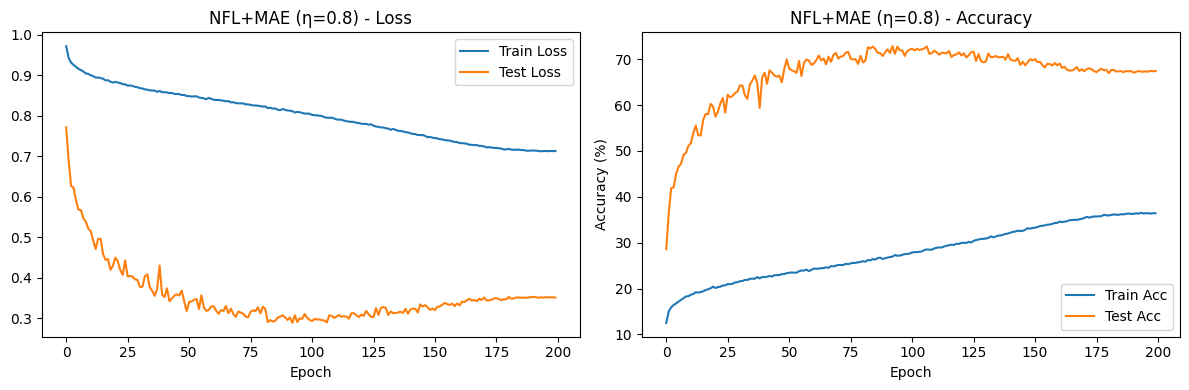

 - NFL+NCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 32.63% | Test Loss: 0.0988


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 34.79% | Test Loss: 0.0769


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 35.15% | Test Loss: 0.0666


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 35.38% | Test Loss: 0.0650


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.92it/s]


Test Acc: 39.54% | Test Loss: 0.0578


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 39.64% | Test Loss: 0.0545


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 38.80% | Test Loss: 0.0499


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 41.30% | Test Loss: 0.0499


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 41.33% | Test Loss: 0.0453


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 42.49% | Test Loss: 0.0466


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 43.71% | Test Loss: 0.0461


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 40.14% | Test Loss: 0.0472


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 40.14% | Test Loss: 0.0445


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 40.27% | Test Loss: 0.0436


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 42.32% | Test Loss: 0.0397


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.93it/s]


Test Acc: 44.04% | Test Loss: 0.0377


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.01it/s]


Test Acc: 39.87% | Test Loss: 0.0508


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 42.08% | Test Loss: 0.0420


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.26it/s]


Test Acc: 39.88% | Test Loss: 0.0421


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 40.14% | Test Loss: 0.0526


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 41.70% | Test Loss: 0.0387


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.83it/s]


Test Acc: 40.67% | Test Loss: 0.0419


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 41.28% | Test Loss: 0.0409


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 41.18% | Test Loss: 0.0395


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 40.80% | Test Loss: 0.0423


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 42.36% | Test Loss: 0.0404


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 43.13% | Test Loss: 0.0384


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 43.55% | Test Loss: 0.0384


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 40.55% | Test Loss: 0.0430


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 42.38% | Test Loss: 0.0430


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 42.28% | Test Loss: 0.0373


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 42.80% | Test Loss: 0.0383


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 44.54% | Test Loss: 0.0354


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 41.67% | Test Loss: 0.0399


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 43.58% | Test Loss: 0.0401


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 42.15% | Test Loss: 0.0384


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 44.01% | Test Loss: 0.0361


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 41.56% | Test Loss: 0.0397


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 43.27% | Test Loss: 0.0440


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 43.07% | Test Loss: 0.0383


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 41.18% | Test Loss: 0.0376


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 43.33% | Test Loss: 0.0369


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 42.83% | Test Loss: 0.0336


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.07it/s]


Test Acc: 43.72% | Test Loss: 0.0371


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 44.73% | Test Loss: 0.0359


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 39.64% | Test Loss: 0.0456


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 43.92% | Test Loss: 0.0371


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 41.92% | Test Loss: 0.0373


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.88it/s]


Test Acc: 41.18% | Test Loss: 0.0388


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 41.97% | Test Loss: 0.0436


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 41.63% | Test Loss: 0.0404


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 41.99% | Test Loss: 0.0386


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 38.53% | Test Loss: 0.0424


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 42.93% | Test Loss: 0.0414


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 37.09% | Test Loss: 0.0361


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 41.79% | Test Loss: 0.0357


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 40.32% | Test Loss: 0.0450


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 44.91% | Test Loss: 0.0390


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.00it/s]


Test Acc: 40.58% | Test Loss: 0.0475


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 44.27% | Test Loss: 0.0378


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 41.36% | Test Loss: 0.0445


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 43.22% | Test Loss: 0.0457


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 40.15% | Test Loss: 0.0431


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 42.66% | Test Loss: 0.0438


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 43.95% | Test Loss: 0.0450


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.70it/s]


Test Acc: 40.10% | Test Loss: 0.0419


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 40.59% | Test Loss: 0.0356


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.90it/s]


Test Acc: 41.83% | Test Loss: 0.0555


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 42.48% | Test Loss: 0.0350


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 44.67% | Test Loss: 0.0376


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 42.43% | Test Loss: 0.0475


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 42.10% | Test Loss: 0.0447


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 44.24% | Test Loss: 0.0438


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 40.08% | Test Loss: 0.0456


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 39.30% | Test Loss: 0.0562


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 45.52% | Test Loss: 0.0438


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 43.40% | Test Loss: 0.0534


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 44.87% | Test Loss: 0.0451


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 44.14% | Test Loss: 0.0433


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 42.92% | Test Loss: 0.0442


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 43.25% | Test Loss: 0.0370


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 40.60% | Test Loss: 0.0449


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 42.45% | Test Loss: 0.0407


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 38.81% | Test Loss: 0.0444


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 44.45% | Test Loss: 0.0445


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 43.46% | Test Loss: 0.0391


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 43.56% | Test Loss: 0.0340


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 41.99% | Test Loss: 0.0491


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 44.10% | Test Loss: 0.0380


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 40.64% | Test Loss: 0.0389


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 38.65% | Test Loss: 0.0433


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 39.59% | Test Loss: 0.0649


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 41.73% | Test Loss: 0.0401


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 43.62% | Test Loss: 0.0503


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.85it/s]


Test Acc: 41.99% | Test Loss: 0.0561


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 40.49% | Test Loss: 0.0525


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 42.62% | Test Loss: 0.0346


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 41.52% | Test Loss: 0.0519


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.11it/s]


Test Acc: 43.53% | Test Loss: 0.0496


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 41.49% | Test Loss: 0.0521


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 41.46% | Test Loss: 0.0357


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 38.38% | Test Loss: 0.0412


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 41.89% | Test Loss: 0.0526


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 42.18% | Test Loss: 0.0423


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 41.98% | Test Loss: 0.0468


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 41.75% | Test Loss: 0.0477


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 41.53% | Test Loss: 0.0479


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.71it/s]


Test Acc: 38.68% | Test Loss: 0.0486


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 39.85% | Test Loss: 0.0508


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 40.78% | Test Loss: 0.0427


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 44.25% | Test Loss: 0.0429


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 41.61% | Test Loss: 0.0434


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 39.56% | Test Loss: 0.0441


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 41.06% | Test Loss: 0.0357


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 41.43% | Test Loss: 0.0443


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 42.43% | Test Loss: 0.0476


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 41.52% | Test Loss: 0.0510


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 41.83% | Test Loss: 0.0442


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 39.83% | Test Loss: 0.0396


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 39.10% | Test Loss: 0.0454


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 39.52% | Test Loss: 0.0440


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 40.86% | Test Loss: 0.0407


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 39.63% | Test Loss: 0.0429


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 42.37% | Test Loss: 0.0417


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 39.88% | Test Loss: 0.0419


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.91it/s]


Test Acc: 41.30% | Test Loss: 0.0398


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.93it/s]


Test Acc: 41.41% | Test Loss: 0.0471


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.91it/s]


Test Acc: 38.55% | Test Loss: 0.0447


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 41.08% | Test Loss: 0.0422


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 39.05% | Test Loss: 0.0483


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 39.55% | Test Loss: 0.0447


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 38.21% | Test Loss: 0.0453


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 41.22% | Test Loss: 0.0383


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.93it/s]


Test Acc: 40.35% | Test Loss: 0.0496


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.65it/s]


Test Acc: 40.28% | Test Loss: 0.0420


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 39.55% | Test Loss: 0.0483


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 40.30% | Test Loss: 0.0549


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 41.23% | Test Loss: 0.0460


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 39.54% | Test Loss: 0.0460


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 38.77% | Test Loss: 0.0514


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 40.83% | Test Loss: 0.0499


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 39.44% | Test Loss: 0.0478


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 38.36% | Test Loss: 0.0571


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 36.83% | Test Loss: 0.0570


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 36.39% | Test Loss: 0.0450


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 38.06% | Test Loss: 0.0426


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 37.31% | Test Loss: 0.0425


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 37.79% | Test Loss: 0.0424


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 35.93% | Test Loss: 0.0534


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 36.15% | Test Loss: 0.0440


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 38.01% | Test Loss: 0.0456


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 36.07% | Test Loss: 0.0566


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 38.26% | Test Loss: 0.0490


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 37.24% | Test Loss: 0.0479


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 37.33% | Test Loss: 0.0451


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 37.35% | Test Loss: 0.0458


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 37.36% | Test Loss: 0.0461


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.49it/s]


Test Acc: 36.19% | Test Loss: 0.0490


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.92it/s]


Test Acc: 36.59% | Test Loss: 0.0456


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 37.95% | Test Loss: 0.0429


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 36.66% | Test Loss: 0.0457


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 35.87% | Test Loss: 0.0549


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 37.59% | Test Loss: 0.0474


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.96it/s]


Test Acc: 36.97% | Test Loss: 0.0490


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 37.22% | Test Loss: 0.0471


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 37.40% | Test Loss: 0.0447


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 36.25% | Test Loss: 0.0484


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 36.67% | Test Loss: 0.0474


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 36.49% | Test Loss: 0.0509


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.26it/s]


Test Acc: 36.05% | Test Loss: 0.0477


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 36.74% | Test Loss: 0.0486


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 36.58% | Test Loss: 0.0458


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 35.82% | Test Loss: 0.0495


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 36.18% | Test Loss: 0.0515


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 36.29% | Test Loss: 0.0488


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 36.22% | Test Loss: 0.0465


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.79it/s]


Test Acc: 36.62% | Test Loss: 0.0478


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 36.27% | Test Loss: 0.0482


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 36.14% | Test Loss: 0.0490


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 35.71% | Test Loss: 0.0501


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 36.76% | Test Loss: 0.0471


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 36.05% | Test Loss: 0.0484


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 36.00% | Test Loss: 0.0467


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 36.61% | Test Loss: 0.0476


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 35.95% | Test Loss: 0.0496


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 35.81% | Test Loss: 0.0483


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 35.90% | Test Loss: 0.0462


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 35.86% | Test Loss: 0.0475


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.07it/s]


Test Acc: 35.97% | Test Loss: 0.0472


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 36.11% | Test Loss: 0.0480


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 35.94% | Test Loss: 0.0469


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 35.91% | Test Loss: 0.0482


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 35.88% | Test Loss: 0.0478


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 35.87% | Test Loss: 0.0480


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 35.98% | Test Loss: 0.0477


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 35.84% | Test Loss: 0.0477


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 35.78% | Test Loss: 0.0475


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 36.02% | Test Loss: 0.0475


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 35.74% | Test Loss: 0.0474


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 35.78% | Test Loss: 0.0477


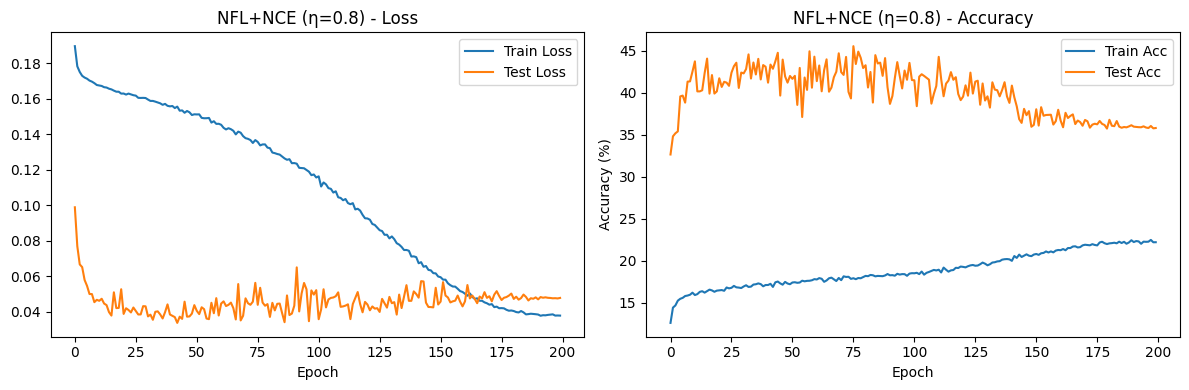

 - MAE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 13.37% | Test Loss: 8.8548


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 14.11% | Test Loss: 8.7808


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 14.40% | Test Loss: 8.7526


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 16.02% | Test Loss: 8.5887


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 14.92% | Test Loss: 8.6961


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 16.03% | Test Loss: 8.5851


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 13.73% | Test Loss: 8.8156


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 15.62% | Test Loss: 8.6241


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 16.32% | Test Loss: 8.5569


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 14.99% | Test Loss: 8.6910


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 16.52% | Test Loss: 8.5324


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 16.75% | Test Loss: 8.5241


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.67it/s]


Test Acc: 18.27% | Test Loss: 8.3527


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 17.74% | Test Loss: 8.4074


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 17.25% | Test Loss: 8.4611


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 17.04% | Test Loss: 8.4733


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 18.75% | Test Loss: 8.3032


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 17.54% | Test Loss: 8.4309


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 17.16% | Test Loss: 8.4703


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 17.69% | Test Loss: 8.4051


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 14.54% | Test Loss: 8.7183


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 18.73% | Test Loss: 8.2985


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 17.76% | Test Loss: 8.4050


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 18.54% | Test Loss: 8.3135


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 17.79% | Test Loss: 8.3972


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 16.33% | Test Loss: 8.5532


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 15.57% | Test Loss: 8.6308


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 16.68% | Test Loss: 8.5119


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 15.66% | Test Loss: 8.6072


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 17.72% | Test Loss: 8.3917


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 16.81% | Test Loss: 8.4919


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.89it/s]


Test Acc: 12.14% | Test Loss: 8.9793


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 17.50% | Test Loss: 8.4223


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 16.74% | Test Loss: 8.5108


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 16.26% | Test Loss: 8.5592


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 15.01% | Test Loss: 8.6881


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 14.05% | Test Loss: 8.7838


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 13.06% | Test Loss: 8.8839


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 13.32% | Test Loss: 8.8601


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 12.14% | Test Loss: 8.9778


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 15.62% | Test Loss: 8.6260


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 16.11% | Test Loss: 8.5756


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 17.02% | Test Loss: 8.4847


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 17.15% | Test Loss: 8.4651


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 18.45% | Test Loss: 8.3317


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 18.02% | Test Loss: 8.3657


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 18.83% | Test Loss: 8.2971


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 17.59% | Test Loss: 8.4139


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 17.34% | Test Loss: 8.4352


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 18.28% | Test Loss: 8.3436


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 17.73% | Test Loss: 8.3987


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 18.34% | Test Loss: 8.3358


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 19.59% | Test Loss: 8.2166


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 19.22% | Test Loss: 8.2476


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 19.44% | Test Loss: 8.2345


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 20.21% | Test Loss: 8.1571


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 15.82% | Test Loss: 8.5998


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 16.40% | Test Loss: 8.5333


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 16.61% | Test Loss: 8.5121


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 19.73% | Test Loss: 8.1979


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.81it/s]


Test Acc: 19.57% | Test Loss: 8.2092


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 18.57% | Test Loss: 8.3132


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 16.81% | Test Loss: 8.4914


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 18.83% | Test Loss: 8.2943


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 18.41% | Test Loss: 8.3352


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 18.78% | Test Loss: 8.2943


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 18.88% | Test Loss: 8.2889


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 18.94% | Test Loss: 8.2803


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 19.05% | Test Loss: 8.2716


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 19.47% | Test Loss: 8.2200


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 18.36% | Test Loss: 8.3417


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 18.54% | Test Loss: 8.3274


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 19.17% | Test Loss: 8.2596


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 17.80% | Test Loss: 8.4067


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 17.90% | Test Loss: 8.3925


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 17.18% | Test Loss: 8.4608


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 18.65% | Test Loss: 8.3205


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 19.25% | Test Loss: 8.2591


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 19.24% | Test Loss: 8.2537


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 18.90% | Test Loss: 8.2880


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 18.77% | Test Loss: 8.3058


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 18.96% | Test Loss: 8.2723


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 18.41% | Test Loss: 8.3281


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 18.90% | Test Loss: 8.2787


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.76it/s]


Test Acc: 18.68% | Test Loss: 8.3014


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 18.55% | Test Loss: 8.3173


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 17.97% | Test Loss: 8.3836


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 16.67% | Test Loss: 8.5195


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 17.17% | Test Loss: 8.4617


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 17.48% | Test Loss: 8.4347


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 17.54% | Test Loss: 8.4226


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.86it/s]


Test Acc: 17.78% | Test Loss: 8.4024


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 17.77% | Test Loss: 8.4001


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 18.06% | Test Loss: 8.3727


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 17.31% | Test Loss: 8.4565


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 17.07% | Test Loss: 8.4708


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 17.06% | Test Loss: 8.4695


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 18.07% | Test Loss: 8.3710


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 18.47% | Test Loss: 8.3308


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.02it/s]


Test Acc: 18.02% | Test Loss: 8.3753


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 17.83% | Test Loss: 8.4022


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 17.50% | Test Loss: 8.4365


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 17.48% | Test Loss: 8.4378


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 18.04% | Test Loss: 8.3826


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 18.21% | Test Loss: 8.3653


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 17.93% | Test Loss: 8.3770


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 18.23% | Test Loss: 8.3477


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 17.96% | Test Loss: 8.3754


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 17.71% | Test Loss: 8.3994


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 18.97% | Test Loss: 8.2783


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 18.04% | Test Loss: 8.3638


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 18.57% | Test Loss: 8.3168


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 18.87% | Test Loss: 8.2929


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 18.09% | Test Loss: 8.3715


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 19.09% | Test Loss: 8.2668


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.01it/s]


Test Acc: 18.79% | Test Loss: 8.2926


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 18.78% | Test Loss: 8.2930


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 18.85% | Test Loss: 8.2843


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 18.79% | Test Loss: 8.2922


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 19.25% | Test Loss: 8.2443


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 18.34% | Test Loss: 8.3446


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 18.29% | Test Loss: 8.3480


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 18.44% | Test Loss: 8.3345


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 18.64% | Test Loss: 8.3130


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 18.58% | Test Loss: 8.3187


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 18.25% | Test Loss: 8.3542


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 19.14% | Test Loss: 8.2666


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 18.56% | Test Loss: 8.3223


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 18.82% | Test Loss: 8.2987


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 19.83% | Test Loss: 8.1922


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 20.12% | Test Loss: 8.1654


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 20.16% | Test Loss: 8.1551


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 20.45% | Test Loss: 8.1223


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 20.05% | Test Loss: 8.1644


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 19.20% | Test Loss: 8.2501


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 20.21% | Test Loss: 8.1458


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.62it/s]


Test Acc: 19.99% | Test Loss: 8.1686


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 19.90% | Test Loss: 8.1818


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 19.75% | Test Loss: 8.1958


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 19.24% | Test Loss: 8.2436


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 19.29% | Test Loss: 8.2387


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 19.64% | Test Loss: 8.2034


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 19.70% | Test Loss: 8.1972


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 19.72% | Test Loss: 8.1963


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 19.99% | Test Loss: 8.1704


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 19.98% | Test Loss: 8.1732


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 20.02% | Test Loss: 8.1651


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 20.35% | Test Loss: 8.1324


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 20.25% | Test Loss: 8.1413


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 20.17% | Test Loss: 8.1513


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 20.21% | Test Loss: 8.1487


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 20.30% | Test Loss: 8.1380


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 20.32% | Test Loss: 8.1345


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 20.47% | Test Loss: 8.1244


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 20.44% | Test Loss: 8.1264


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 20.09% | Test Loss: 8.1586


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 20.05% | Test Loss: 8.1677


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 19.93% | Test Loss: 8.1795


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 20.15% | Test Loss: 8.1548


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 20.16% | Test Loss: 8.1536


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 20.21% | Test Loss: 8.1491


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 20.08% | Test Loss: 8.1641


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 20.15% | Test Loss: 8.1549


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 20.14% | Test Loss: 8.1580


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.63it/s]


Test Acc: 19.92% | Test Loss: 8.1767


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 19.99% | Test Loss: 8.1722


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 20.09% | Test Loss: 8.1614


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 20.15% | Test Loss: 8.1578


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 20.12% | Test Loss: 8.1556


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 20.05% | Test Loss: 8.1628


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 20.04% | Test Loss: 8.1671


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 20.00% | Test Loss: 8.1693


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 20.05% | Test Loss: 8.1664


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 19.82% | Test Loss: 8.1866


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 19.67% | Test Loss: 8.2004


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 19.67% | Test Loss: 8.1999


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 19.79% | Test Loss: 8.1900


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 19.83% | Test Loss: 8.1847


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 19.71% | Test Loss: 8.1976


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.82it/s]


Test Acc: 19.69% | Test Loss: 8.2021


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 19.73% | Test Loss: 8.1958


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 19.85% | Test Loss: 8.1827


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 19.94% | Test Loss: 8.1745


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.71it/s]


Test Acc: 19.87% | Test Loss: 8.1822


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 19.85% | Test Loss: 8.1839


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 19.80% | Test Loss: 8.1901


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 19.94% | Test Loss: 8.1760


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 19.93% | Test Loss: 8.1752


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 19.93% | Test Loss: 8.1754


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.63it/s]


Test Acc: 19.96% | Test Loss: 8.1724


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 19.99% | Test Loss: 8.1686


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 19.99% | Test Loss: 8.1680


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 20.03% | Test Loss: 8.1670


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 19.95% | Test Loss: 8.1720


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 20.06% | Test Loss: 8.1662


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 19.97% | Test Loss: 8.1706


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 20.04% | Test Loss: 8.1663


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 19.96% | Test Loss: 8.1735


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 20.00% | Test Loss: 8.1675


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 19.97% | Test Loss: 8.1703


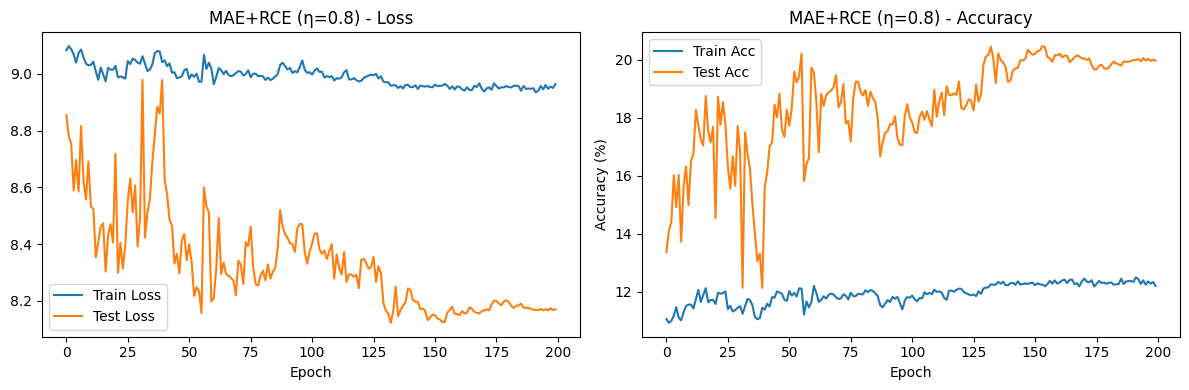


=== Asymmetric Noise Experiments ===

Noise Rate: 0.1

Training vanilla Losses...
 - CE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.17it/s]


Test Acc: 62.91% | Test Loss: 1.0541


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 104.77it/s]


Test Acc: 69.32% | Test Loss: 0.8686


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.89it/s]


Test Acc: 72.04% | Test Loss: 0.8140


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.66it/s]


Test Acc: 76.30% | Test Loss: 0.6969


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.19it/s]


Test Acc: 81.42% | Test Loss: 0.5628


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.60it/s]


Test Acc: 80.46% | Test Loss: 0.5885


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 105.49it/s]


Test Acc: 81.22% | Test Loss: 0.5869


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 104.44it/s]


Test Acc: 81.25% | Test Loss: 0.5689


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 106.12it/s]


Test Acc: 80.53% | Test Loss: 0.6052


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.06it/s]


Test Acc: 84.38% | Test Loss: 0.5056


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.65it/s]


Test Acc: 84.06% | Test Loss: 0.4755


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.75it/s]


Test Acc: 83.01% | Test Loss: 0.5214


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.48it/s]


Test Acc: 85.30% | Test Loss: 0.4618


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 103.26it/s]


Test Acc: 84.69% | Test Loss: 0.4701


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.88it/s]


Test Acc: 84.22% | Test Loss: 0.4652


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 102.74it/s]


Test Acc: 83.17% | Test Loss: 0.5208


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.64it/s]


Test Acc: 84.63% | Test Loss: 0.4752


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.41it/s]


Test Acc: 86.64% | Test Loss: 0.4250


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.51it/s]


Test Acc: 86.11% | Test Loss: 0.4532


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.43it/s]


Test Acc: 86.78% | Test Loss: 0.4253


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.10it/s]


Test Acc: 86.58% | Test Loss: 0.4294


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.52it/s]


Test Acc: 87.35% | Test Loss: 0.4038


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.49it/s]


Test Acc: 86.53% | Test Loss: 0.4371


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.49it/s]


Test Acc: 87.40% | Test Loss: 0.4069


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.05it/s]


Test Acc: 87.40% | Test Loss: 0.4373


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.56it/s]


Test Acc: 88.11% | Test Loss: 0.3979


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 103.47it/s]


Test Acc: 87.91% | Test Loss: 0.4055


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.17it/s]


Test Acc: 86.71% | Test Loss: 0.4315


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.68it/s]


Test Acc: 87.82% | Test Loss: 0.4079


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.09it/s]


Test Acc: 88.03% | Test Loss: 0.3980


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.94it/s]


Test Acc: 85.81% | Test Loss: 0.5089


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.70it/s]


Test Acc: 87.86% | Test Loss: 0.4253


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.96it/s]


Test Acc: 87.98% | Test Loss: 0.4059


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.45it/s]


Test Acc: 87.02% | Test Loss: 0.4561


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.38it/s]


Test Acc: 86.65% | Test Loss: 0.4600


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.46it/s]


Test Acc: 87.92% | Test Loss: 0.3983


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.61it/s]


Test Acc: 88.27% | Test Loss: 0.3968


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.11it/s]


Test Acc: 88.10% | Test Loss: 0.4041


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.39it/s]


Test Acc: 87.96% | Test Loss: 0.4007


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.29it/s]


Test Acc: 88.28% | Test Loss: 0.4022


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.48it/s]


Test Acc: 88.21% | Test Loss: 0.3964


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.94it/s]


Test Acc: 85.86% | Test Loss: 0.4910


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.73it/s]


Test Acc: 87.52% | Test Loss: 0.4442


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.47it/s]


Test Acc: 88.20% | Test Loss: 0.4188


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.67it/s]


Test Acc: 88.06% | Test Loss: 0.4220


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.57it/s]


Test Acc: 88.05% | Test Loss: 0.4153


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.90it/s]


Test Acc: 87.50% | Test Loss: 0.4545


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.50it/s]


Test Acc: 85.78% | Test Loss: 0.5296


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.45it/s]


Test Acc: 87.18% | Test Loss: 0.4399


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.97it/s]


Test Acc: 88.06% | Test Loss: 0.4501


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 103.54it/s]


Test Acc: 88.07% | Test Loss: 0.4472


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.86it/s]


Test Acc: 88.58% | Test Loss: 0.4075


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.35it/s]


Test Acc: 86.39% | Test Loss: 0.4821


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.81it/s]


Test Acc: 87.44% | Test Loss: 0.4503


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.93it/s]


Test Acc: 87.62% | Test Loss: 0.4462


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.02it/s]


Test Acc: 87.93% | Test Loss: 0.4584


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.38it/s]


Test Acc: 86.96% | Test Loss: 0.5093


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.77it/s]


Test Acc: 87.63% | Test Loss: 0.4680


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.94it/s]


Test Acc: 86.96% | Test Loss: 0.4900


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.12it/s]


Test Acc: 87.09% | Test Loss: 0.4718


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.14it/s]


Test Acc: 87.56% | Test Loss: 0.4683


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.91it/s]


Test Acc: 87.78% | Test Loss: 0.4864


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.50it/s]


Test Acc: 88.09% | Test Loss: 0.4630


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.00it/s]


Test Acc: 88.13% | Test Loss: 0.4589


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.91it/s]


Test Acc: 87.54% | Test Loss: 0.4813


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.50it/s]


Test Acc: 87.89% | Test Loss: 0.4708


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.14it/s]


Test Acc: 87.61% | Test Loss: 0.4968


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.20it/s]


Test Acc: 86.44% | Test Loss: 0.5253


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.33it/s]


Test Acc: 87.40% | Test Loss: 0.4814


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.40it/s]


Test Acc: 86.48% | Test Loss: 0.5580


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.21it/s]


Test Acc: 87.62% | Test Loss: 0.5130


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.68it/s]


Test Acc: 87.09% | Test Loss: 0.5175


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.67it/s]


Test Acc: 87.04% | Test Loss: 0.5162


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.36it/s]


Test Acc: 86.96% | Test Loss: 0.5115


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.02it/s]


Test Acc: 86.71% | Test Loss: 0.5620


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.67it/s]


Test Acc: 87.16% | Test Loss: 0.5015


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.69it/s]


Test Acc: 87.91% | Test Loss: 0.4944


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.29it/s]


Test Acc: 88.36% | Test Loss: 0.4956


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.58it/s]


Test Acc: 87.10% | Test Loss: 0.5385


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.19it/s]


Test Acc: 87.31% | Test Loss: 0.5341


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.24it/s]


Test Acc: 88.67% | Test Loss: 0.4805


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.64it/s]


Test Acc: 88.30% | Test Loss: 0.4779


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.45it/s]


Test Acc: 86.95% | Test Loss: 0.5769


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.13it/s]


Test Acc: 88.24% | Test Loss: 0.5300


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.30it/s]


Test Acc: 87.32% | Test Loss: 0.5275


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.59it/s]


Test Acc: 87.36% | Test Loss: 0.5331


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.10it/s]


Test Acc: 87.90% | Test Loss: 0.5181


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.42it/s]


Test Acc: 87.65% | Test Loss: 0.5194


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.98it/s]


Test Acc: 88.15% | Test Loss: 0.5269


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.38it/s]


Test Acc: 87.20% | Test Loss: 0.5446


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.31it/s]


Test Acc: 88.26% | Test Loss: 0.5114


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.11it/s]


Test Acc: 87.81% | Test Loss: 0.5424


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.63it/s]


Test Acc: 88.18% | Test Loss: 0.5239


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.62it/s]


Test Acc: 88.45% | Test Loss: 0.5263


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.31it/s]


Test Acc: 87.89% | Test Loss: 0.5360


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.85it/s]


Test Acc: 88.49% | Test Loss: 0.5212


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.92it/s]


Test Acc: 88.62% | Test Loss: 0.5332


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 104.46it/s]


Test Acc: 88.99% | Test Loss: 0.5142


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.10it/s]


Test Acc: 88.65% | Test Loss: 0.5288


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.10it/s]


Test Acc: 88.16% | Test Loss: 0.5424


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.01it/s]


Test Acc: 88.35% | Test Loss: 0.5215


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.19it/s]


Test Acc: 88.52% | Test Loss: 0.5247


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.70it/s]


Test Acc: 88.77% | Test Loss: 0.5009


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.12it/s]


Test Acc: 88.19% | Test Loss: 0.5264


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.60it/s]


Test Acc: 88.63% | Test Loss: 0.5161


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.43it/s]


Test Acc: 88.83% | Test Loss: 0.5032


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.10it/s]


Test Acc: 88.87% | Test Loss: 0.5240


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.37it/s]


Test Acc: 88.71% | Test Loss: 0.5271


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.50it/s]


Test Acc: 88.87% | Test Loss: 0.5080


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.63it/s]


Test Acc: 88.81% | Test Loss: 0.5146


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.78it/s]


Test Acc: 88.30% | Test Loss: 0.5268


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.80it/s]


Test Acc: 88.89% | Test Loss: 0.5146


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.71it/s]


Test Acc: 89.19% | Test Loss: 0.5139


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.94it/s]


Test Acc: 89.12% | Test Loss: 0.5333


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.65it/s]


Test Acc: 89.20% | Test Loss: 0.5168


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.75it/s]


Test Acc: 89.40% | Test Loss: 0.5119


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.34it/s]


Test Acc: 88.91% | Test Loss: 0.5246


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.89it/s]


Test Acc: 88.46% | Test Loss: 0.5432


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.62it/s]


Test Acc: 88.83% | Test Loss: 0.5245


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.27it/s]


Test Acc: 89.13% | Test Loss: 0.5323


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.74it/s]


Test Acc: 89.08% | Test Loss: 0.5223


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.31it/s]


Test Acc: 89.18% | Test Loss: 0.5208


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.58it/s]


Test Acc: 89.16% | Test Loss: 0.5218


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.40it/s]


Test Acc: 88.59% | Test Loss: 0.5540


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.08it/s]


Test Acc: 88.23% | Test Loss: 0.5619


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.04it/s]


Test Acc: 88.93% | Test Loss: 0.5404


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.15it/s]


Test Acc: 89.20% | Test Loss: 0.5246


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.09it/s]


Test Acc: 88.75% | Test Loss: 0.5416


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.60it/s]


Test Acc: 89.21% | Test Loss: 0.5308


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.80it/s]


Test Acc: 89.36% | Test Loss: 0.5237


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.51it/s]


Test Acc: 89.61% | Test Loss: 0.5170


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.37it/s]


Test Acc: 89.62% | Test Loss: 0.5231


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.44it/s]


Test Acc: 89.28% | Test Loss: 0.5251


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.18it/s]


Test Acc: 88.91% | Test Loss: 0.5385


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.94it/s]


Test Acc: 89.32% | Test Loss: 0.5284


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.16it/s]


Test Acc: 89.40% | Test Loss: 0.5264


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.22it/s]


Test Acc: 89.28% | Test Loss: 0.5316


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.87it/s]


Test Acc: 89.15% | Test Loss: 0.5307


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.00it/s]


Test Acc: 89.62% | Test Loss: 0.5204


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.84it/s]


Test Acc: 89.35% | Test Loss: 0.5262


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.49it/s]


Test Acc: 89.30% | Test Loss: 0.5322


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.55it/s]


Test Acc: 89.24% | Test Loss: 0.5256


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.24it/s]


Test Acc: 89.75% | Test Loss: 0.5134


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.46it/s]


Test Acc: 89.61% | Test Loss: 0.5133


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.81it/s]


Test Acc: 89.36% | Test Loss: 0.5268


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.27it/s]


Test Acc: 89.34% | Test Loss: 0.5294


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.26it/s]


Test Acc: 89.07% | Test Loss: 0.5290


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.86it/s]


Test Acc: 89.54% | Test Loss: 0.5264


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.60it/s]


Test Acc: 89.28% | Test Loss: 0.5324


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.22it/s]


Test Acc: 89.23% | Test Loss: 0.5305


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.72it/s]


Test Acc: 89.30% | Test Loss: 0.5373


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.36it/s]


Test Acc: 89.43% | Test Loss: 0.5264


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.90it/s]


Test Acc: 89.18% | Test Loss: 0.5281


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.17it/s]


Test Acc: 89.35% | Test Loss: 0.5277


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.32it/s]


Test Acc: 89.43% | Test Loss: 0.5243


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.10it/s]


Test Acc: 89.38% | Test Loss: 0.5382


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.46it/s]


Test Acc: 89.19% | Test Loss: 0.5350


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.34it/s]


Test Acc: 89.42% | Test Loss: 0.5294


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.10it/s]


Test Acc: 89.24% | Test Loss: 0.5358


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.48it/s]


Test Acc: 89.23% | Test Loss: 0.5328


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.38it/s]


Test Acc: 89.31% | Test Loss: 0.5319


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.38it/s]


Test Acc: 89.35% | Test Loss: 0.5313


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.05it/s]


Test Acc: 89.21% | Test Loss: 0.5358


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.47it/s]


Test Acc: 89.41% | Test Loss: 0.5300


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.66it/s]


Test Acc: 89.46% | Test Loss: 0.5332


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.69it/s]


Test Acc: 89.35% | Test Loss: 0.5306


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.21it/s]


Test Acc: 89.38% | Test Loss: 0.5287


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.65it/s]


Test Acc: 89.30% | Test Loss: 0.5336


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.09it/s]


Test Acc: 89.30% | Test Loss: 0.5386


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.86it/s]


Test Acc: 89.26% | Test Loss: 0.5405


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.77it/s]


Test Acc: 89.32% | Test Loss: 0.5303


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.04it/s]


Test Acc: 89.33% | Test Loss: 0.5346


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.78it/s]


Test Acc: 89.35% | Test Loss: 0.5324


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.67it/s]


Test Acc: 89.49% | Test Loss: 0.5317


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.78it/s]


Test Acc: 89.38% | Test Loss: 0.5339


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.58it/s]


Test Acc: 89.34% | Test Loss: 0.5365


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.91it/s]


Test Acc: 89.28% | Test Loss: 0.5326


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.87it/s]


Test Acc: 89.26% | Test Loss: 0.5335


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.95it/s]


Test Acc: 89.32% | Test Loss: 0.5375


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.83it/s]


Test Acc: 89.27% | Test Loss: 0.5326


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.48it/s]


Test Acc: 89.27% | Test Loss: 0.5342


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.54it/s]


Test Acc: 89.30% | Test Loss: 0.5310


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.75it/s]


Test Acc: 89.37% | Test Loss: 0.5312


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.50it/s]


Test Acc: 89.27% | Test Loss: 0.5300


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.05it/s]


Test Acc: 89.38% | Test Loss: 0.5303


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.34it/s]


Test Acc: 89.34% | Test Loss: 0.5343


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.77it/s]


Test Acc: 89.32% | Test Loss: 0.5304


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.05it/s]


Test Acc: 89.36% | Test Loss: 0.5310


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.48it/s]


Test Acc: 89.36% | Test Loss: 0.5354


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.42it/s]


Test Acc: 89.38% | Test Loss: 0.5332


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.18it/s]


Test Acc: 89.39% | Test Loss: 0.5370


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.34it/s]


Test Acc: 89.37% | Test Loss: 0.5343


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.59it/s]


Test Acc: 89.30% | Test Loss: 0.5326


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.07it/s]


Test Acc: 89.36% | Test Loss: 0.5327


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.76it/s]


Test Acc: 89.33% | Test Loss: 0.5357


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.27it/s]


Test Acc: 89.37% | Test Loss: 0.5312


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.79it/s]


Test Acc: 89.33% | Test Loss: 0.5324


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.82it/s]


Test Acc: 89.36% | Test Loss: 0.5355


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.97it/s]


Test Acc: 89.33% | Test Loss: 0.5315


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 104.56it/s]


Test Acc: 89.37% | Test Loss: 0.5317


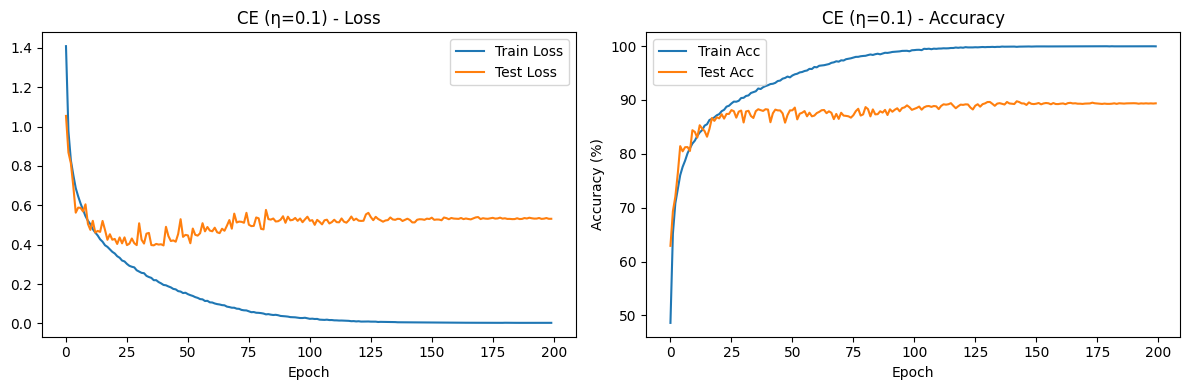

 - MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 35.87% | Test Loss: 0.6425


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 40.26% | Test Loss: 0.5990


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 39.56% | Test Loss: 0.6055


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 45.21% | Test Loss: 0.5494


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 47.23% | Test Loss: 0.5305


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 48.64% | Test Loss: 0.5157


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 51.53% | Test Loss: 0.4880


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 52.61% | Test Loss: 0.4770


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 54.12% | Test Loss: 0.4614


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 56.34% | Test Loss: 0.4389


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 57.40% | Test Loss: 0.4290


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 56.42% | Test Loss: 0.4354


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 59.39% | Test Loss: 0.4106


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 58.75% | Test Loss: 0.4137


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 58.07% | Test Loss: 0.4196


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 61.28% | Test Loss: 0.3884


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 59.00% | Test Loss: 0.4120


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 58.26% | Test Loss: 0.4171


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 57.36% | Test Loss: 0.4264


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 63.82% | Test Loss: 0.3637


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 62.40% | Test Loss: 0.3774


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 63.60% | Test Loss: 0.3650


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 64.42% | Test Loss: 0.3581


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 61.76% | Test Loss: 0.3831


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 62.40% | Test Loss: 0.3770


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 64.03% | Test Loss: 0.3601


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.17it/s]


Test Acc: 63.58% | Test Loss: 0.3652


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 64.24% | Test Loss: 0.3573


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 64.85% | Test Loss: 0.3525


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 62.78% | Test Loss: 0.3725


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 64.79% | Test Loss: 0.3539


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 65.52% | Test Loss: 0.3459


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 66.55% | Test Loss: 0.3361


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 65.30% | Test Loss: 0.3479


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 66.50% | Test Loss: 0.3364


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 66.94% | Test Loss: 0.3321


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 66.51% | Test Loss: 0.3362


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 66.93% | Test Loss: 0.3323


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 65.57% | Test Loss: 0.3460


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 65.19% | Test Loss: 0.3471


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 65.69% | Test Loss: 0.3434


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 65.60% | Test Loss: 0.3469


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 67.10% | Test Loss: 0.3302


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 66.75% | Test Loss: 0.3316


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 66.97% | Test Loss: 0.3304


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 66.68% | Test Loss: 0.3326


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 67.29% | Test Loss: 0.3285


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 67.47% | Test Loss: 0.3256


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 68.89% | Test Loss: 0.3125


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 67.36% | Test Loss: 0.3273


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 67.66% | Test Loss: 0.3236


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 68.37% | Test Loss: 0.3172


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 68.43% | Test Loss: 0.3166


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 67.70% | Test Loss: 0.3238


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 68.49% | Test Loss: 0.3155


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 68.59% | Test Loss: 0.3146


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 67.65% | Test Loss: 0.3242


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 69.40% | Test Loss: 0.3070


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 68.32% | Test Loss: 0.3180


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 67.79% | Test Loss: 0.3228


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 69.24% | Test Loss: 0.3085


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 68.57% | Test Loss: 0.3150


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 69.16% | Test Loss: 0.3097


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 69.24% | Test Loss: 0.3078


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 67.84% | Test Loss: 0.3216


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 69.40% | Test Loss: 0.3066


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 69.60% | Test Loss: 0.3058


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 69.60% | Test Loss: 0.3044


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 69.78% | Test Loss: 0.3049


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 70.15% | Test Loss: 0.2993


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 68.39% | Test Loss: 0.3173


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.37it/s]


Test Acc: 69.64% | Test Loss: 0.3046


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.54it/s]


Test Acc: 69.38% | Test Loss: 0.3067


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 69.82% | Test Loss: 0.3030


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 69.97% | Test Loss: 0.3007


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 70.91% | Test Loss: 0.2929


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 70.10% | Test Loss: 0.3003


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 70.22% | Test Loss: 0.2984


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 70.20% | Test Loss: 0.2982


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 70.57% | Test Loss: 0.2955


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 70.06% | Test Loss: 0.3011


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 69.78% | Test Loss: 0.3038


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 70.84% | Test Loss: 0.2940


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 70.39% | Test Loss: 0.2956


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 70.02% | Test Loss: 0.3013


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.50it/s]


Test Acc: 70.33% | Test Loss: 0.2975


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 70.55% | Test Loss: 0.2972


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 69.96% | Test Loss: 0.3024


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 70.77% | Test Loss: 0.2938


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 70.15% | Test Loss: 0.2995


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 70.98% | Test Loss: 0.2936


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 70.43% | Test Loss: 0.2970


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 71.38% | Test Loss: 0.2877


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 70.57% | Test Loss: 0.2959


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 70.97% | Test Loss: 0.2922


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 71.01% | Test Loss: 0.2917


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 71.10% | Test Loss: 0.2915


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 70.65% | Test Loss: 0.2957


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 71.12% | Test Loss: 0.2901


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 71.24% | Test Loss: 0.2890


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 71.09% | Test Loss: 0.2908


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.45it/s]


Test Acc: 71.24% | Test Loss: 0.2894


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 71.35% | Test Loss: 0.2886


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 71.42% | Test Loss: 0.2881


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 71.20% | Test Loss: 0.2886


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 71.23% | Test Loss: 0.2890


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 70.75% | Test Loss: 0.2948


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 71.28% | Test Loss: 0.2891


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 71.23% | Test Loss: 0.2881


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 71.09% | Test Loss: 0.2920


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 71.66% | Test Loss: 0.2861


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.52it/s]


Test Acc: 71.44% | Test Loss: 0.2868


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 71.59% | Test Loss: 0.2854


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 71.35% | Test Loss: 0.2876


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 71.54% | Test Loss: 0.2862


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 71.27% | Test Loss: 0.2883


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 71.34% | Test Loss: 0.2877


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 71.50% | Test Loss: 0.2857


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 71.53% | Test Loss: 0.2852


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 71.02% | Test Loss: 0.2906


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 71.56% | Test Loss: 0.2866


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 71.63% | Test Loss: 0.2861


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 71.67% | Test Loss: 0.2849


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 71.46% | Test Loss: 0.2855


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 71.57% | Test Loss: 0.2856


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 71.40% | Test Loss: 0.2876


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 71.56% | Test Loss: 0.2854


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 71.41% | Test Loss: 0.2870


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 71.53% | Test Loss: 0.2868


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 71.96% | Test Loss: 0.2816


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 78.52% | Test Loss: 0.2175


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 78.98% | Test Loss: 0.2118


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 79.49% | Test Loss: 0.2067


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 79.59% | Test Loss: 0.2050


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 80.02% | Test Loss: 0.2015


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 79.68% | Test Loss: 0.2056


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 80.15% | Test Loss: 0.2013


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 79.97% | Test Loss: 0.2023


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 80.27% | Test Loss: 0.1996


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 79.98% | Test Loss: 0.2024


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 80.22% | Test Loss: 0.2010


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 79.99% | Test Loss: 0.2014


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 80.37% | Test Loss: 0.1985


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 80.47% | Test Loss: 0.1976


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 80.40% | Test Loss: 0.1975


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 80.41% | Test Loss: 0.1967


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 80.37% | Test Loss: 0.1979


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 80.56% | Test Loss: 0.1970


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 80.49% | Test Loss: 0.1969


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 80.30% | Test Loss: 0.1986


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 80.49% | Test Loss: 0.1965


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 80.17% | Test Loss: 0.1999


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 80.46% | Test Loss: 0.1971


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 80.45% | Test Loss: 0.1972


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 80.51% | Test Loss: 0.1962


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 80.60% | Test Loss: 0.1968


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 80.41% | Test Loss: 0.1969


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 80.44% | Test Loss: 0.1969


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 80.33% | Test Loss: 0.1977


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 80.69% | Test Loss: 0.1963


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 80.56% | Test Loss: 0.1954


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 80.47% | Test Loss: 0.1962


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 80.61% | Test Loss: 0.1961


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 80.75% | Test Loss: 0.1949


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 80.56% | Test Loss: 0.1962


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 80.58% | Test Loss: 0.1959


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 80.78% | Test Loss: 0.1950


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 80.69% | Test Loss: 0.1960


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 80.64% | Test Loss: 0.1955


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 80.59% | Test Loss: 0.1955


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.97it/s]


Test Acc: 80.72% | Test Loss: 0.1953


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 80.68% | Test Loss: 0.1957


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 80.67% | Test Loss: 0.1956


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 80.51% | Test Loss: 0.1957


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 80.51% | Test Loss: 0.1958


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 80.53% | Test Loss: 0.1966


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 80.63% | Test Loss: 0.1958


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 80.70% | Test Loss: 0.1953


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 80.73% | Test Loss: 0.1952


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 80.71% | Test Loss: 0.1952


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 80.54% | Test Loss: 0.1961


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 80.61% | Test Loss: 0.1955


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 80.72% | Test Loss: 0.1948


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 80.62% | Test Loss: 0.1955


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 80.68% | Test Loss: 0.1949


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.07it/s]


Test Acc: 80.61% | Test Loss: 0.1954


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 80.58% | Test Loss: 0.1954


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 80.52% | Test Loss: 0.1961


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 80.61% | Test Loss: 0.1954


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.21it/s]


Test Acc: 80.58% | Test Loss: 0.1955


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 80.50% | Test Loss: 0.1957


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 80.66% | Test Loss: 0.1952


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.11it/s]


Test Acc: 80.63% | Test Loss: 0.1952


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 80.69% | Test Loss: 0.1951


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 80.49% | Test Loss: 0.1959


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 80.55% | Test Loss: 0.1955


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 80.56% | Test Loss: 0.1958


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 80.55% | Test Loss: 0.1954


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 80.66% | Test Loss: 0.1954


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 80.62% | Test Loss: 0.1953


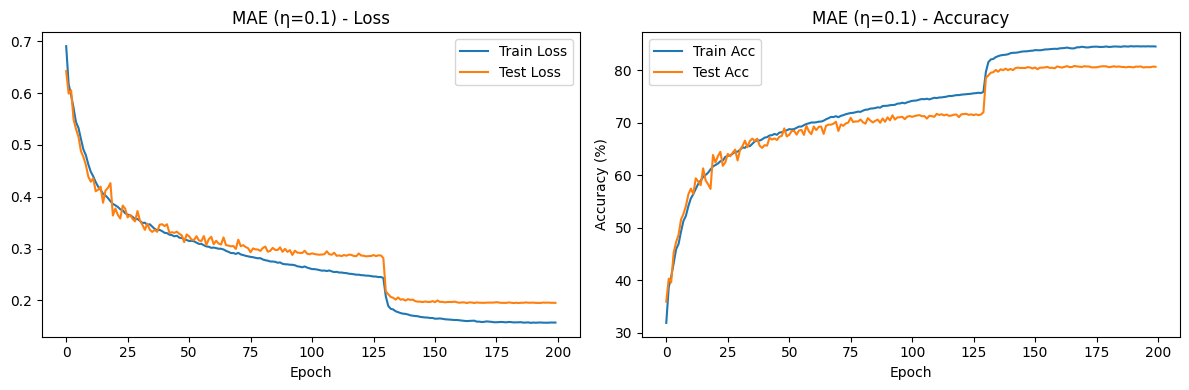

 - RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 25.47% | Test Loss: 6.8473


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 27.37% | Test Loss: 6.6843


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 26.98% | Test Loss: 6.7163


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 28.23% | Test Loss: 6.5997


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 30.89% | Test Loss: 6.3647


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 29.30% | Test Loss: 6.5053


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 30.01% | Test Loss: 6.4473


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 29.54% | Test Loss: 6.4847


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.15it/s]


Test Acc: 24.61% | Test Loss: 6.9450


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 26.67% | Test Loss: 6.7516


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 26.83% | Test Loss: 6.7365


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 25.58% | Test Loss: 6.8492


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 29.17% | Test Loss: 6.5127


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 29.62% | Test Loss: 6.4744


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 29.33% | Test Loss: 6.4997


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 31.59% | Test Loss: 6.2953


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 31.83% | Test Loss: 6.2669


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 30.60% | Test Loss: 6.3930


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 30.63% | Test Loss: 6.3889


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 31.37% | Test Loss: 6.3146


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 30.33% | Test Loss: 6.4223


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 30.57% | Test Loss: 6.3991


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 28.70% | Test Loss: 6.5776


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 30.81% | Test Loss: 6.3720


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 27.18% | Test Loss: 6.7092


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 29.32% | Test Loss: 6.5069


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 31.57% | Test Loss: 6.2815


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 30.19% | Test Loss: 6.4275


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 31.31% | Test Loss: 6.3259


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 32.78% | Test Loss: 6.1923


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 32.79% | Test Loss: 6.1853


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 32.56% | Test Loss: 6.2121


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 29.35% | Test Loss: 6.4921


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 32.32% | Test Loss: 6.2289


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 32.07% | Test Loss: 6.2570


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 33.07% | Test Loss: 6.1557


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 32.31% | Test Loss: 6.2232


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 31.96% | Test Loss: 6.2551


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 33.18% | Test Loss: 6.1464


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 32.84% | Test Loss: 6.1746


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 31.52% | Test Loss: 6.3008


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 33.16% | Test Loss: 6.1470


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 30.59% | Test Loss: 6.3918


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 30.71% | Test Loss: 6.3662


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 31.60% | Test Loss: 6.2825


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 33.80% | Test Loss: 6.0953


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 31.62% | Test Loss: 6.2850


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 33.12% | Test Loss: 6.1560


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 32.49% | Test Loss: 6.2204


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 33.43% | Test Loss: 6.1267


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.19it/s]


Test Acc: 32.41% | Test Loss: 6.2058


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 33.56% | Test Loss: 6.1151


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 31.73% | Test Loss: 6.2893


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 32.81% | Test Loss: 6.1775


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 32.35% | Test Loss: 6.2191


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 33.38% | Test Loss: 6.1244


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 32.13% | Test Loss: 6.2504


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 34.17% | Test Loss: 6.0664


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 29.51% | Test Loss: 6.4840


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 33.82% | Test Loss: 6.0983


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 33.78% | Test Loss: 6.0995


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 31.88% | Test Loss: 6.2606


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 33.75% | Test Loss: 6.0985


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 31.09% | Test Loss: 6.3247


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 32.74% | Test Loss: 6.1971


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 33.01% | Test Loss: 6.1717


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 34.96% | Test Loss: 5.9805


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 33.00% | Test Loss: 6.1685


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 33.64% | Test Loss: 6.1024


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 34.63% | Test Loss: 6.0101


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 34.91% | Test Loss: 5.9927


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 34.06% | Test Loss: 6.0700


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 34.59% | Test Loss: 6.0135


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 34.26% | Test Loss: 6.0443


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 32.90% | Test Loss: 6.1759


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 33.49% | Test Loss: 6.1141


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 34.37% | Test Loss: 6.0340


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 33.97% | Test Loss: 6.0775


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 35.19% | Test Loss: 5.9722


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 33.67% | Test Loss: 6.1051


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 34.93% | Test Loss: 5.9848


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 35.55% | Test Loss: 5.9272


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 35.39% | Test Loss: 5.9490


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 34.16% | Test Loss: 6.0642


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 35.21% | Test Loss: 5.9666


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.17it/s]


Test Acc: 34.07% | Test Loss: 6.0684


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 35.53% | Test Loss: 5.9286


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 35.06% | Test Loss: 5.9914


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 35.13% | Test Loss: 5.9700


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 34.95% | Test Loss: 5.9965


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 34.74% | Test Loss: 6.0007


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 34.95% | Test Loss: 5.9829


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 36.09% | Test Loss: 5.8784


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 36.08% | Test Loss: 5.8801


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 35.76% | Test Loss: 5.9086


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 35.98% | Test Loss: 5.8884


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 35.94% | Test Loss: 5.8911


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 35.98% | Test Loss: 5.8892


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 35.41% | Test Loss: 5.9393


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 35.34% | Test Loss: 5.9525


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 36.23% | Test Loss: 5.8647


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 36.45% | Test Loss: 5.8454


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.66it/s]


Test Acc: 35.50% | Test Loss: 5.9341


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 35.83% | Test Loss: 5.9076


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 35.59% | Test Loss: 5.9231


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 36.96% | Test Loss: 5.7986


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 36.61% | Test Loss: 5.8387


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 36.25% | Test Loss: 5.8698


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 35.74% | Test Loss: 5.9173


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 36.24% | Test Loss: 5.8640


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 36.69% | Test Loss: 5.8217


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 36.72% | Test Loss: 5.8166


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.20it/s]


Test Acc: 36.95% | Test Loss: 5.8075


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 37.10% | Test Loss: 5.7871


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 36.44% | Test Loss: 5.8416


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 36.69% | Test Loss: 5.8249


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 36.32% | Test Loss: 5.8574


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 36.80% | Test Loss: 5.8208


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 36.79% | Test Loss: 5.8133


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 37.04% | Test Loss: 5.8004


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 36.78% | Test Loss: 5.8098


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 37.06% | Test Loss: 5.7958


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 37.53% | Test Loss: 5.7545


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 37.61% | Test Loss: 5.7393


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 36.07% | Test Loss: 5.8868


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 37.01% | Test Loss: 5.7958


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 36.11% | Test Loss: 5.8752


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 37.64% | Test Loss: 5.7431


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 36.93% | Test Loss: 5.8081


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 37.42% | Test Loss: 5.7656


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 37.28% | Test Loss: 5.7762


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 36.78% | Test Loss: 5.8287


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 37.32% | Test Loss: 5.7801


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 38.12% | Test Loss: 5.7006


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 37.97% | Test Loss: 5.7142


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 37.60% | Test Loss: 5.7341


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 37.46% | Test Loss: 5.7536


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 37.73% | Test Loss: 5.7285


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 37.83% | Test Loss: 5.7147


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 37.59% | Test Loss: 5.7472


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 37.61% | Test Loss: 5.7337


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 37.44% | Test Loss: 5.7568


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 38.09% | Test Loss: 5.6897


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 38.17% | Test Loss: 5.6845


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 37.83% | Test Loss: 5.7139


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 38.32% | Test Loss: 5.6765


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 38.19% | Test Loss: 5.6814


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 38.08% | Test Loss: 5.6907


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 38.38% | Test Loss: 5.6647


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 38.56% | Test Loss: 5.6478


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 37.80% | Test Loss: 5.7159


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 38.24% | Test Loss: 5.6755


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 38.65% | Test Loss: 5.6419


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 38.57% | Test Loss: 5.6473


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 38.61% | Test Loss: 5.6474


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 38.93% | Test Loss: 5.6142


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 38.99% | Test Loss: 5.6096


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 38.84% | Test Loss: 5.6225


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 38.94% | Test Loss: 5.6117


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 38.86% | Test Loss: 5.6190


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 39.19% | Test Loss: 5.5892


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 38.82% | Test Loss: 5.6296


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 38.77% | Test Loss: 5.6335


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 38.67% | Test Loss: 5.6427


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 38.71% | Test Loss: 5.6333


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 39.00% | Test Loss: 5.6073


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 39.09% | Test Loss: 5.5970


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 39.14% | Test Loss: 5.5959


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 39.05% | Test Loss: 5.6012


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 38.99% | Test Loss: 5.6076


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 38.94% | Test Loss: 5.6131


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 38.92% | Test Loss: 5.6153


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 38.94% | Test Loss: 5.6085


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.35it/s]


Test Acc: 38.95% | Test Loss: 5.6083


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.18it/s]


Test Acc: 39.10% | Test Loss: 5.5982


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 39.23% | Test Loss: 5.5856


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 39.17% | Test Loss: 5.5858


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 39.01% | Test Loss: 5.5978


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 38.99% | Test Loss: 5.6012


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 39.03% | Test Loss: 5.5988


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 39.06% | Test Loss: 5.6033


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 39.13% | Test Loss: 5.5950


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 38.98% | Test Loss: 5.6098


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 39.02% | Test Loss: 5.6033


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 39.02% | Test Loss: 5.6075


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 38.99% | Test Loss: 5.6065


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 38.94% | Test Loss: 5.6146


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 39.07% | Test Loss: 5.6036


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 39.00% | Test Loss: 5.6080


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 38.95% | Test Loss: 5.6111


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 38.89% | Test Loss: 5.6169


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.25it/s]


Test Acc: 39.02% | Test Loss: 5.6052


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 38.95% | Test Loss: 5.6118


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 39.01% | Test Loss: 5.6063


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 38.99% | Test Loss: 5.6098


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 39.10% | Test Loss: 5.5983


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 39.05% | Test Loss: 5.6051


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 39.03% | Test Loss: 5.6050


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 38.93% | Test Loss: 5.6124


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 38.99% | Test Loss: 5.6080


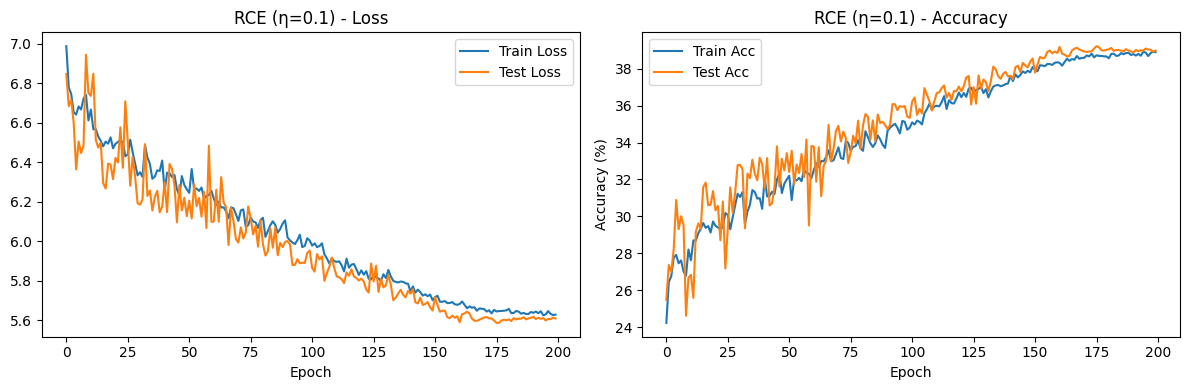


Training normalized Losses...
 - NCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 41.68% | Test Loss: 0.0304


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 43.48% | Test Loss: 0.0236


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 44.51% | Test Loss: 0.0219


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 48.85% | Test Loss: 0.0180


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 49.20% | Test Loss: 0.0168


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 49.16% | Test Loss: 0.0171


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 51.44% | Test Loss: 0.0153


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 52.96% | Test Loss: 0.0137


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 54.13% | Test Loss: 0.0126


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 54.97% | Test Loss: 0.0136


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 56.45% | Test Loss: 0.0120


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 57.59% | Test Loss: 0.0110


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 58.53% | Test Loss: 0.0104


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 58.33% | Test Loss: 0.0102


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 58.72% | Test Loss: 0.0101


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 60.67% | Test Loss: 0.0089


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 60.59% | Test Loss: 0.0092


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 57.03% | Test Loss: 0.0134


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 60.04% | Test Loss: 0.0085


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 61.47% | Test Loss: 0.0091


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 63.02% | Test Loss: 0.0080


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 62.30% | Test Loss: 0.0081


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 61.18% | Test Loss: 0.0085


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 62.44% | Test Loss: 0.0081


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 63.12% | Test Loss: 0.0094


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 63.82% | Test Loss: 0.0074


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 64.49% | Test Loss: 0.0070


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 63.95% | Test Loss: 0.0086


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 60.62% | Test Loss: 0.0122


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 64.82% | Test Loss: 0.0078


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 64.25% | Test Loss: 0.0082


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 66.26% | Test Loss: 0.0064


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 66.38% | Test Loss: 0.0067


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 66.41% | Test Loss: 0.0066


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 66.76% | Test Loss: 0.0061


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 66.80% | Test Loss: 0.0068


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 67.02% | Test Loss: 0.0062


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 67.55% | Test Loss: 0.0060


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 66.36% | Test Loss: 0.0074


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 67.55% | Test Loss: 0.0064


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 67.73% | Test Loss: 0.0058


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 67.09% | Test Loss: 0.0066


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 67.11% | Test Loss: 0.0059


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 68.09% | Test Loss: 0.0060


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.00it/s]


Test Acc: 69.00% | Test Loss: 0.0058


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 68.15% | Test Loss: 0.0068


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 68.01% | Test Loss: 0.0061


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 69.14% | Test Loss: 0.0055


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 68.64% | Test Loss: 0.0058


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 66.01% | Test Loss: 0.0088


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 68.56% | Test Loss: 0.0059


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 69.16% | Test Loss: 0.0067


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 69.66% | Test Loss: 0.0054


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 69.66% | Test Loss: 0.0055


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 69.61% | Test Loss: 0.0051


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 69.75% | Test Loss: 0.0062


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 69.48% | Test Loss: 0.0048


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 70.37% | Test Loss: 0.0050


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 70.25% | Test Loss: 0.0049


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 70.59% | Test Loss: 0.0051


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 70.39% | Test Loss: 0.0050


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 71.46% | Test Loss: 0.0045


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 71.59% | Test Loss: 0.0052


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 70.53% | Test Loss: 0.0054


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 70.82% | Test Loss: 0.0049


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 68.99% | Test Loss: 0.0060


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 71.61% | Test Loss: 0.0045


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 71.37% | Test Loss: 0.0050


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 71.57% | Test Loss: 0.0045


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 71.58% | Test Loss: 0.0050


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 70.52% | Test Loss: 0.0050


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 71.55% | Test Loss: 0.0049


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 71.41% | Test Loss: 0.0051


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 71.02% | Test Loss: 0.0056


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 72.74% | Test Loss: 0.0044


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 71.67% | Test Loss: 0.0050


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 72.16% | Test Loss: 0.0047


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 72.36% | Test Loss: 0.0048


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 72.56% | Test Loss: 0.0045


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.56it/s]


Test Acc: 72.83% | Test Loss: 0.0046


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 72.39% | Test Loss: 0.0046


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 71.96% | Test Loss: 0.0050


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 72.96% | Test Loss: 0.0044


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 73.11% | Test Loss: 0.0043


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 72.84% | Test Loss: 0.0047


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 73.09% | Test Loss: 0.0048


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 73.24% | Test Loss: 0.0042


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 73.57% | Test Loss: 0.0045


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 72.97% | Test Loss: 0.0046


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 72.40% | Test Loss: 0.0045


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 73.53% | Test Loss: 0.0041


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 73.01% | Test Loss: 0.0041


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 73.60% | Test Loss: 0.0044


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 73.12% | Test Loss: 0.0043


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 73.48% | Test Loss: 0.0042


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 73.27% | Test Loss: 0.0043


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 74.11% | Test Loss: 0.0044


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 73.21% | Test Loss: 0.0042


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 74.28% | Test Loss: 0.0043


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 74.12% | Test Loss: 0.0042


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 74.20% | Test Loss: 0.0041


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 74.29% | Test Loss: 0.0041


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 74.51% | Test Loss: 0.0040


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 74.13% | Test Loss: 0.0042


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 74.07% | Test Loss: 0.0044


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 74.17% | Test Loss: 0.0042


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 74.06% | Test Loss: 0.0043


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 74.16% | Test Loss: 0.0042


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 74.57% | Test Loss: 0.0039


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 74.36% | Test Loss: 0.0044


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 74.09% | Test Loss: 0.0042


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 73.94% | Test Loss: 0.0039


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 74.15% | Test Loss: 0.0040


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 74.21% | Test Loss: 0.0046


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 74.48% | Test Loss: 0.0039


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 74.62% | Test Loss: 0.0039


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 74.34% | Test Loss: 0.0044


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 74.37% | Test Loss: 0.0044


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 74.84% | Test Loss: 0.0040


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 74.85% | Test Loss: 0.0042


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 73.91% | Test Loss: 0.0042


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 74.25% | Test Loss: 0.0039


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 74.43% | Test Loss: 0.0042


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 74.14% | Test Loss: 0.0040


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 74.87% | Test Loss: 0.0039


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.79it/s]


Test Acc: 74.71% | Test Loss: 0.0040


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 74.96% | Test Loss: 0.0041


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 74.19% | Test Loss: 0.0041


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 75.09% | Test Loss: 0.0043


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 75.00% | Test Loss: 0.0040


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 75.15% | Test Loss: 0.0041


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 74.95% | Test Loss: 0.0041


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 75.14% | Test Loss: 0.0040


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 75.31% | Test Loss: 0.0040


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 75.68% | Test Loss: 0.0039


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 75.34% | Test Loss: 0.0039


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 75.03% | Test Loss: 0.0039


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 75.23% | Test Loss: 0.0040


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 75.35% | Test Loss: 0.0042


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 75.53% | Test Loss: 0.0038


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 75.22% | Test Loss: 0.0041


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 74.74% | Test Loss: 0.0039


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 75.47% | Test Loss: 0.0040


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 75.27% | Test Loss: 0.0039


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 75.52% | Test Loss: 0.0038


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 75.34% | Test Loss: 0.0041


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 75.50% | Test Loss: 0.0038


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 75.21% | Test Loss: 0.0039


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 75.26% | Test Loss: 0.0040


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 75.25% | Test Loss: 0.0040


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 75.05% | Test Loss: 0.0039


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 75.26% | Test Loss: 0.0041


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 75.10% | Test Loss: 0.0041


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 75.14% | Test Loss: 0.0039


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 75.30% | Test Loss: 0.0041


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 75.17% | Test Loss: 0.0039


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 75.33% | Test Loss: 0.0039


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 75.43% | Test Loss: 0.0039


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 75.52% | Test Loss: 0.0039


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 75.53% | Test Loss: 0.0040


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 75.51% | Test Loss: 0.0040


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 75.33% | Test Loss: 0.0040


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 75.38% | Test Loss: 0.0040


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 75.60% | Test Loss: 0.0039


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 75.38% | Test Loss: 0.0041


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 75.55% | Test Loss: 0.0040


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 75.54% | Test Loss: 0.0039


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 75.62% | Test Loss: 0.0039


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 75.61% | Test Loss: 0.0039


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 75.71% | Test Loss: 0.0040


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 75.62% | Test Loss: 0.0041


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 75.74% | Test Loss: 0.0039


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 75.59% | Test Loss: 0.0039


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 75.66% | Test Loss: 0.0039


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 75.61% | Test Loss: 0.0040


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.03it/s]


Test Acc: 75.76% | Test Loss: 0.0039


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 75.50% | Test Loss: 0.0041


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 75.56% | Test Loss: 0.0040


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 75.58% | Test Loss: 0.0039


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 75.76% | Test Loss: 0.0040


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 75.55% | Test Loss: 0.0039


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 75.71% | Test Loss: 0.0039


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 75.69% | Test Loss: 0.0039


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 75.67% | Test Loss: 0.0039


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 75.62% | Test Loss: 0.0040


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 75.54% | Test Loss: 0.0039


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 75.55% | Test Loss: 0.0038


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 75.79% | Test Loss: 0.0039


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 75.80% | Test Loss: 0.0039


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 75.67% | Test Loss: 0.0039


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 75.67% | Test Loss: 0.0039


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 75.64% | Test Loss: 0.0039


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 75.69% | Test Loss: 0.0039


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 75.68% | Test Loss: 0.0039


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 75.67% | Test Loss: 0.0039


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 75.65% | Test Loss: 0.0040


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 75.56% | Test Loss: 0.0040


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 75.56% | Test Loss: 0.0039


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 75.59% | Test Loss: 0.0039


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 75.56% | Test Loss: 0.0040


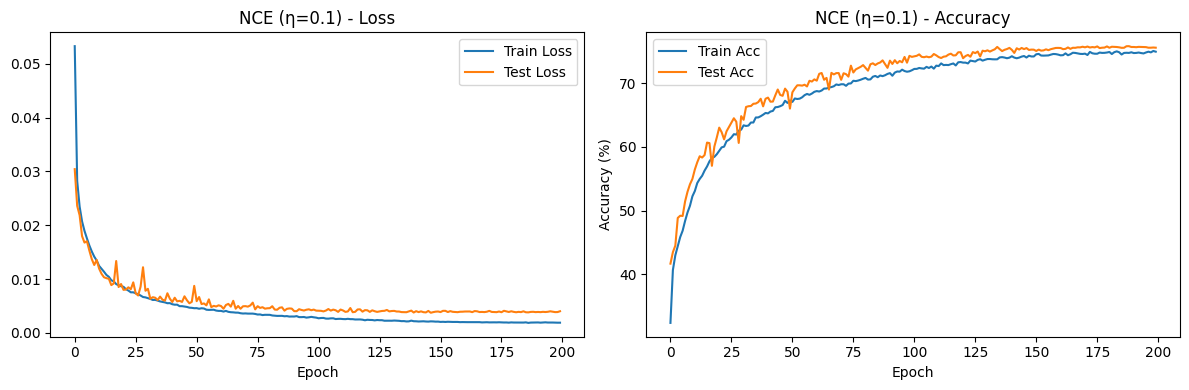

 - NRCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 16.56% | Test Loss: 17.3007


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 16.78% | Test Loss: 17.2554


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 17.46% | Test Loss: 17.1160


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 17.68% | Test Loss: 17.0707


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.02it/s]


Test Acc: 17.05% | Test Loss: 17.2343


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 16.83% | Test Loss: 17.2726


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 17.86% | Test Loss: 17.0615


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 17.06% | Test Loss: 17.2264


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 16.63% | Test Loss: 17.3132


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 19.90% | Test Loss: 16.6479


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 21.08% | Test Loss: 16.3865


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 21.12% | Test Loss: 16.3783


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 20.25% | Test Loss: 16.5736


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 19.16% | Test Loss: 16.7779


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 15.56% | Test Loss: 17.5063


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 21.31% | Test Loss: 16.3414


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 18.43% | Test Loss: 16.9200


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 22.24% | Test Loss: 16.1367


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.35it/s]


Test Acc: 18.55% | Test Loss: 16.8947


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 16.98% | Test Loss: 17.1983


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 21.35% | Test Loss: 16.3198


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 20.94% | Test Loss: 16.4171


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 21.65% | Test Loss: 16.2714


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 21.80% | Test Loss: 16.2121


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 15.55% | Test Loss: 17.4940


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 17.48% | Test Loss: 17.0968


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 17.53% | Test Loss: 17.0853


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 18.27% | Test Loss: 16.9331


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 19.96% | Test Loss: 16.5904


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 21.66% | Test Loss: 16.2693


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 18.94% | Test Loss: 16.8151


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 19.26% | Test Loss: 16.7617


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 20.73% | Test Loss: 16.4612


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.67it/s]


Test Acc: 20.33% | Test Loss: 16.5553


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 22.25% | Test Loss: 16.1333


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 21.05% | Test Loss: 16.3950


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 22.44% | Test Loss: 16.0973


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 21.93% | Test Loss: 16.2037


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 22.62% | Test Loss: 16.0733


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 17.94% | Test Loss: 17.0304


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 22.58% | Test Loss: 16.0835


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 22.24% | Test Loss: 16.1213


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 23.10% | Test Loss: 15.9334


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 24.07% | Test Loss: 15.7608


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 22.08% | Test Loss: 16.1845


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 20.25% | Test Loss: 16.5441


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 25.01% | Test Loss: 15.5558


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.98it/s]


Test Acc: 23.99% | Test Loss: 15.7513


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 22.19% | Test Loss: 16.1328


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 16.23% | Test Loss: 17.3687


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 24.36% | Test Loss: 15.6596


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 23.81% | Test Loss: 15.8025


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 25.04% | Test Loss: 15.5211


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 22.45% | Test Loss: 16.0802


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 19.85% | Test Loss: 16.5832


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 22.70% | Test Loss: 16.0288


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 21.56% | Test Loss: 16.2629


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 24.69% | Test Loss: 15.6034


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 21.95% | Test Loss: 16.1525


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 24.30% | Test Loss: 15.6726


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 23.53% | Test Loss: 15.8288


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 20.43% | Test Loss: 16.4776


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 24.07% | Test Loss: 15.7330


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 24.20% | Test Loss: 15.7235


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 24.52% | Test Loss: 15.6270


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 23.68% | Test Loss: 15.7985


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 22.39% | Test Loss: 16.0652


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 24.20% | Test Loss: 15.7073


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 23.04% | Test Loss: 15.9286


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 23.91% | Test Loss: 15.7780


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 21.75% | Test Loss: 16.2349


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 21.32% | Test Loss: 16.3249


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.10it/s]


Test Acc: 22.01% | Test Loss: 16.1560


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 23.07% | Test Loss: 15.9240


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 23.59% | Test Loss: 15.8150


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 23.71% | Test Loss: 15.8050


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.96it/s]


Test Acc: 23.62% | Test Loss: 15.8254


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 22.93% | Test Loss: 15.9504


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 22.85% | Test Loss: 15.9670


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 21.53% | Test Loss: 16.2383


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 23.55% | Test Loss: 15.8399


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 25.63% | Test Loss: 15.4125


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 24.24% | Test Loss: 15.6981


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 23.73% | Test Loss: 15.8026


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 25.02% | Test Loss: 15.5236


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 24.47% | Test Loss: 15.6502


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 23.82% | Test Loss: 15.7831


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 24.42% | Test Loss: 15.6610


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 25.12% | Test Loss: 15.5187


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 24.52% | Test Loss: 15.6382


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.70it/s]


Test Acc: 24.09% | Test Loss: 15.7149


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 23.84% | Test Loss: 15.7521


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 23.86% | Test Loss: 15.7638


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 25.61% | Test Loss: 15.4018


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 25.88% | Test Loss: 15.3478


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 25.82% | Test Loss: 15.3602


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 24.15% | Test Loss: 15.7160


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 24.96% | Test Loss: 15.5373


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 25.49% | Test Loss: 15.4258


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 25.64% | Test Loss: 15.3983


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.23it/s]


Test Acc: 25.32% | Test Loss: 15.4775


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 24.52% | Test Loss: 15.6400


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 24.86% | Test Loss: 15.5564


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 25.49% | Test Loss: 15.4293


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 25.48% | Test Loss: 15.4427


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 25.65% | Test Loss: 15.3949


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 25.19% | Test Loss: 15.4882


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 24.76% | Test Loss: 15.5785


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 25.35% | Test Loss: 15.4562


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 26.07% | Test Loss: 15.3089


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 23.62% | Test Loss: 15.8247


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 24.00% | Test Loss: 15.7331


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 24.19% | Test Loss: 15.6938


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.04it/s]


Test Acc: 26.02% | Test Loss: 15.3341


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 24.07% | Test Loss: 15.7178


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 23.88% | Test Loss: 15.7576


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 24.92% | Test Loss: 15.5444


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 25.68% | Test Loss: 15.3893


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 24.26% | Test Loss: 15.6789


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.97it/s]


Test Acc: 25.56% | Test Loss: 15.4166


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.29it/s]


Test Acc: 25.26% | Test Loss: 15.4761


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 25.90% | Test Loss: 15.3582


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 26.46% | Test Loss: 15.2291


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 26.19% | Test Loss: 15.2839


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 25.72% | Test Loss: 15.3818


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 25.96% | Test Loss: 15.3313


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 24.84% | Test Loss: 15.5620


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 25.12% | Test Loss: 15.5030


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 23.91% | Test Loss: 15.7501


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.02it/s]


Test Acc: 23.12% | Test Loss: 15.9139


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 22.56% | Test Loss: 16.0423


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 24.14% | Test Loss: 15.7041


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 24.50% | Test Loss: 15.6283


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 26.32% | Test Loss: 15.2578


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 26.43% | Test Loss: 15.2361


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 26.68% | Test Loss: 15.1838


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 26.83% | Test Loss: 15.1515


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 26.70% | Test Loss: 15.1796


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 26.57% | Test Loss: 15.2065


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 26.58% | Test Loss: 15.2196


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 26.65% | Test Loss: 15.1900


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 26.59% | Test Loss: 15.2149


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 25.72% | Test Loss: 15.3941


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 26.31% | Test Loss: 15.2738


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 26.06% | Test Loss: 15.3235


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 26.70% | Test Loss: 15.1799


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.33it/s]


Test Acc: 26.56% | Test Loss: 15.2230


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 26.48% | Test Loss: 15.2392


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 26.60% | Test Loss: 15.2002


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 26.72% | Test Loss: 15.1753


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 26.54% | Test Loss: 15.2114


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.86it/s]


Test Acc: 26.82% | Test Loss: 15.1538


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 27.15% | Test Loss: 15.0891


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 26.90% | Test Loss: 15.1402


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.31it/s]


Test Acc: 27.10% | Test Loss: 15.0980


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 27.09% | Test Loss: 15.0999


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 27.01% | Test Loss: 15.1160


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.27it/s]


Test Acc: 26.88% | Test Loss: 15.1429


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 26.80% | Test Loss: 15.1591


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 26.87% | Test Loss: 15.1449


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 26.71% | Test Loss: 15.1788


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 26.71% | Test Loss: 15.1780


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.21it/s]


Test Acc: 26.70% | Test Loss: 15.1803


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 26.81% | Test Loss: 15.1576


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 26.66% | Test Loss: 15.1880


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 26.93% | Test Loss: 15.1318


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 27.33% | Test Loss: 15.0500


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.14it/s]


Test Acc: 27.01% | Test Loss: 15.1158


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 26.99% | Test Loss: 15.1204


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 27.21% | Test Loss: 15.0748


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 27.29% | Test Loss: 15.0594


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 27.31% | Test Loss: 15.0557


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 27.31% | Test Loss: 15.0544


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 27.40% | Test Loss: 15.0362


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 27.22% | Test Loss: 15.0720


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 27.28% | Test Loss: 15.0624


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 27.24% | Test Loss: 15.0678


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.30it/s]


Test Acc: 27.37% | Test Loss: 15.0424


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 27.35% | Test Loss: 15.0452


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 27.28% | Test Loss: 15.0624


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 27.28% | Test Loss: 15.0613


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 27.36% | Test Loss: 15.0448


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 27.32% | Test Loss: 15.0543


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.36it/s]


Test Acc: 27.30% | Test Loss: 15.0577


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.96it/s]


Test Acc: 27.26% | Test Loss: 15.0641


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 27.36% | Test Loss: 15.0435


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 27.41% | Test Loss: 15.0351


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 27.29% | Test Loss: 15.0626


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 27.29% | Test Loss: 15.0591


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 27.31% | Test Loss: 15.0546


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.12it/s]


Test Acc: 27.11% | Test Loss: 15.0956


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 27.29% | Test Loss: 15.0585


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 27.31% | Test Loss: 15.0530


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 27.30% | Test Loss: 15.0572


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 27.34% | Test Loss: 15.0489


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 27.25% | Test Loss: 15.0665


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 27.17% | Test Loss: 15.0821


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 27.32% | Test Loss: 15.0528


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 27.22% | Test Loss: 15.0739


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 27.29% | Test Loss: 15.0606


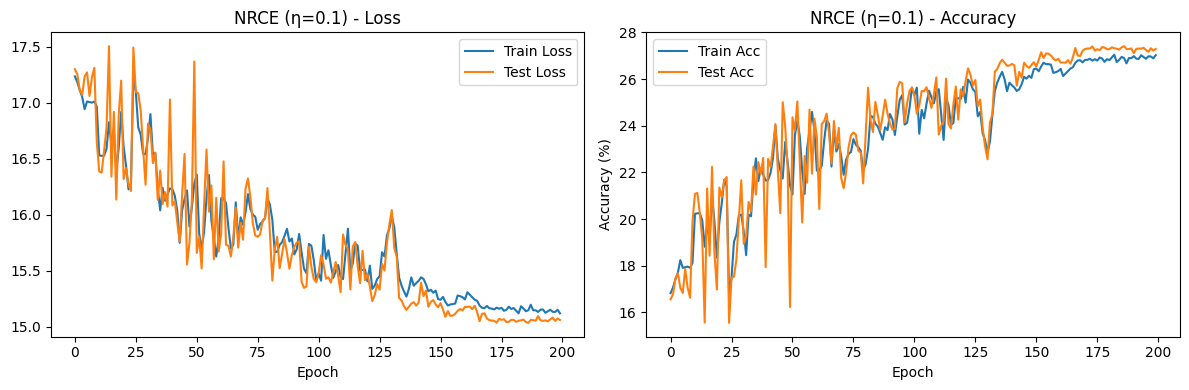

 - NFL


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 42.43% | Test Loss: 0.1707


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 44.38% | Test Loss: 0.1206


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 52.99% | Test Loss: 0.0932


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 54.63% | Test Loss: 0.0914


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 53.41% | Test Loss: 0.0822


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 54.50% | Test Loss: 0.0806


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 109.08it/s]


Test Acc: 57.45% | Test Loss: 0.0661


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 62.67% | Test Loss: 0.0576


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 61.15% | Test Loss: 0.0751


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 63.66% | Test Loss: 0.0489


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 63.63% | Test Loss: 0.0443


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.16it/s]


Test Acc: 64.96% | Test Loss: 0.0375


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 65.36% | Test Loss: 0.0408


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 66.17% | Test Loss: 0.0385


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 64.37% | Test Loss: 0.0490


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 62.27% | Test Loss: 0.0383


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 68.34% | Test Loss: 0.0390


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 63.72% | Test Loss: 0.0460


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 69.61% | Test Loss: 0.0313


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 69.36% | Test Loss: 0.0432


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 65.54% | Test Loss: 0.0380


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 68.06% | Test Loss: 0.0490


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 68.53% | Test Loss: 0.0416


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 68.62% | Test Loss: 0.0350


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 69.46% | Test Loss: 0.0417


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 67.74% | Test Loss: 0.0336


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 69.53% | Test Loss: 0.0323


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 69.40% | Test Loss: 0.0326


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 69.03% | Test Loss: 0.0296


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 68.37% | Test Loss: 0.0344


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 73.83% | Test Loss: 0.0268


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 73.40% | Test Loss: 0.0298


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 71.87% | Test Loss: 0.0309


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 69.58% | Test Loss: 0.0286


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 72.28% | Test Loss: 0.0270


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 73.30% | Test Loss: 0.0254


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 70.05% | Test Loss: 0.0401


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 73.58% | Test Loss: 0.0285


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 71.36% | Test Loss: 0.0246


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.05it/s]


Test Acc: 72.56% | Test Loss: 0.0276


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 73.11% | Test Loss: 0.0262


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 73.51% | Test Loss: 0.0250


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 72.18% | Test Loss: 0.0259


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 75.24% | Test Loss: 0.0220


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.28it/s]


Test Acc: 72.31% | Test Loss: 0.0244


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 73.97% | Test Loss: 0.0266


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 74.27% | Test Loss: 0.0243


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 75.75% | Test Loss: 0.0283


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 73.94% | Test Loss: 0.0236


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 75.00% | Test Loss: 0.0258


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 73.67% | Test Loss: 0.0246


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 73.36% | Test Loss: 0.0288


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 75.72% | Test Loss: 0.0245


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 72.37% | Test Loss: 0.0318


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 74.68% | Test Loss: 0.0241


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 73.90% | Test Loss: 0.0226


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 75.95% | Test Loss: 0.0225


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 77.01% | Test Loss: 0.0229


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 76.19% | Test Loss: 0.0217


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.66it/s]


Test Acc: 74.36% | Test Loss: 0.0227


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 75.51% | Test Loss: 0.0213


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 75.41% | Test Loss: 0.0212


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 76.35% | Test Loss: 0.0211


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 77.01% | Test Loss: 0.0213


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 73.86% | Test Loss: 0.0407


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 75.90% | Test Loss: 0.0195


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 76.84% | Test Loss: 0.0204


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 76.96% | Test Loss: 0.0211


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 76.29% | Test Loss: 0.0220


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 74.47% | Test Loss: 0.0243


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 78.08% | Test Loss: 0.0220


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 76.38% | Test Loss: 0.0211


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 76.60% | Test Loss: 0.0178


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 73.92% | Test Loss: 0.0241


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 75.11% | Test Loss: 0.0208


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 76.48% | Test Loss: 0.0297


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 74.60% | Test Loss: 0.0259


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.92it/s]


Test Acc: 76.22% | Test Loss: 0.0226


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 77.74% | Test Loss: 0.0171


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 77.57% | Test Loss: 0.0191


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 77.19% | Test Loss: 0.0189


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 76.18% | Test Loss: 0.0218


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 78.02% | Test Loss: 0.0203


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 77.93% | Test Loss: 0.0193


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 75.88% | Test Loss: 0.0211


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 79.18% | Test Loss: 0.0177


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 78.88% | Test Loss: 0.0177


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 77.14% | Test Loss: 0.0187


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 78.57% | Test Loss: 0.0200


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 78.17% | Test Loss: 0.0209


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 77.30% | Test Loss: 0.0207


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 77.72% | Test Loss: 0.0260


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 78.83% | Test Loss: 0.0189


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 79.82% | Test Loss: 0.0201


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 79.81% | Test Loss: 0.0175


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 77.40% | Test Loss: 0.0232


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 80.43% | Test Loss: 0.0197


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 79.34% | Test Loss: 0.0225


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 78.38% | Test Loss: 0.0177


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 78.80% | Test Loss: 0.0207


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 79.77% | Test Loss: 0.0177


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 79.80% | Test Loss: 0.0193


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 78.02% | Test Loss: 0.0191


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 78.98% | Test Loss: 0.0197


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 78.35% | Test Loss: 0.0214


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 78.59% | Test Loss: 0.0188


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 79.84% | Test Loss: 0.0185


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 79.78% | Test Loss: 0.0209


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 80.36% | Test Loss: 0.0181


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 79.53% | Test Loss: 0.0191


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 80.02% | Test Loss: 0.0195


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 80.42% | Test Loss: 0.0192


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 80.56% | Test Loss: 0.0185


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 80.35% | Test Loss: 0.0183


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 80.11% | Test Loss: 0.0190


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 80.69% | Test Loss: 0.0176


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 78.21% | Test Loss: 0.0244


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 80.43% | Test Loss: 0.0186


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 79.47% | Test Loss: 0.0172


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 79.55% | Test Loss: 0.0190


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 80.26% | Test Loss: 0.0175


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 80.14% | Test Loss: 0.0223


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 80.86% | Test Loss: 0.0175


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 80.58% | Test Loss: 0.0170


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 80.54% | Test Loss: 0.0167


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 80.22% | Test Loss: 0.0185


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 80.07% | Test Loss: 0.0177


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 79.94% | Test Loss: 0.0173


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 80.68% | Test Loss: 0.0192


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 80.36% | Test Loss: 0.0172


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 80.58% | Test Loss: 0.0191


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 80.99% | Test Loss: 0.0194


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 80.72% | Test Loss: 0.0172


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 81.25% | Test Loss: 0.0175


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 81.30% | Test Loss: 0.0180


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 81.03% | Test Loss: 0.0177


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.75it/s]


Test Acc: 80.52% | Test Loss: 0.0177


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 81.33% | Test Loss: 0.0177


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 80.58% | Test Loss: 0.0183


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 81.11% | Test Loss: 0.0173


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.01it/s]


Test Acc: 81.00% | Test Loss: 0.0176


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 81.13% | Test Loss: 0.0173


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 80.78% | Test Loss: 0.0178


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 81.46% | Test Loss: 0.0192


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 81.13% | Test Loss: 0.0175


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 81.11% | Test Loss: 0.0182


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 81.31% | Test Loss: 0.0185


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 81.39% | Test Loss: 0.0189


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 81.39% | Test Loss: 0.0197


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 81.56% | Test Loss: 0.0197


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 81.42% | Test Loss: 0.0195


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 81.68% | Test Loss: 0.0182


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 81.32% | Test Loss: 0.0187


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 81.38% | Test Loss: 0.0182


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 81.28% | Test Loss: 0.0206


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 81.73% | Test Loss: 0.0195


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 81.82% | Test Loss: 0.0196


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.05it/s]


Test Acc: 81.52% | Test Loss: 0.0187


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 81.54% | Test Loss: 0.0192


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 81.52% | Test Loss: 0.0187


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 81.37% | Test Loss: 0.0192


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 81.56% | Test Loss: 0.0188


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 81.70% | Test Loss: 0.0182


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 81.32% | Test Loss: 0.0182


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 81.58% | Test Loss: 0.0183


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.02it/s]


Test Acc: 81.89% | Test Loss: 0.0181


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 81.70% | Test Loss: 0.0188


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 81.62% | Test Loss: 0.0182


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 81.51% | Test Loss: 0.0185


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 81.55% | Test Loss: 0.0198


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 81.77% | Test Loss: 0.0188


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 81.60% | Test Loss: 0.0186


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 81.71% | Test Loss: 0.0185


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 81.57% | Test Loss: 0.0187


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 81.68% | Test Loss: 0.0187


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 81.52% | Test Loss: 0.0188


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 81.75% | Test Loss: 0.0184


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.65it/s]


Test Acc: 81.57% | Test Loss: 0.0179


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 81.77% | Test Loss: 0.0189


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 81.98% | Test Loss: 0.0182


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 81.64% | Test Loss: 0.0186


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 81.54% | Test Loss: 0.0185


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.79it/s]


Test Acc: 81.61% | Test Loss: 0.0189


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 81.67% | Test Loss: 0.0184


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 81.67% | Test Loss: 0.0184


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 81.64% | Test Loss: 0.0183


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 81.48% | Test Loss: 0.0185


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 81.73% | Test Loss: 0.0188


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 81.59% | Test Loss: 0.0184


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 81.66% | Test Loss: 0.0184


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 81.71% | Test Loss: 0.0187


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 81.69% | Test Loss: 0.0190


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 81.66% | Test Loss: 0.0184


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 81.78% | Test Loss: 0.0181


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 81.66% | Test Loss: 0.0183


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 81.61% | Test Loss: 0.0186


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 81.54% | Test Loss: 0.0187


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 81.81% | Test Loss: 0.0182


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 81.63% | Test Loss: 0.0186


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 81.68% | Test Loss: 0.0189


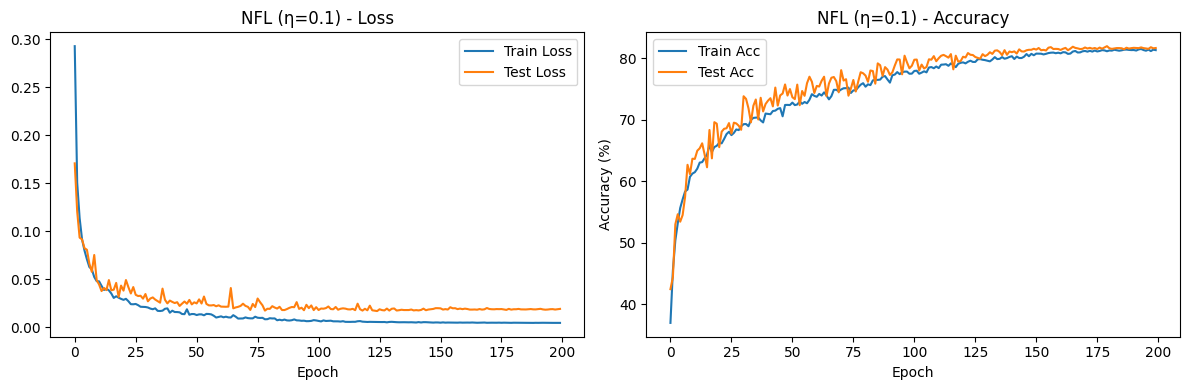


Training apl Losses...
 - NCE+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 26.49% | Test Loss: 6.8426


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 30.30% | Test Loss: 6.4755


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 27.23% | Test Loss: 6.7493


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 32.22% | Test Loss: 6.3030


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 27.58% | Test Loss: 6.7390


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 34.20% | Test Loss: 6.1257


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 34.92% | Test Loss: 6.0484


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 32.38% | Test Loss: 6.2757


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 30.78% | Test Loss: 6.4199


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 31.73% | Test Loss: 6.3421


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 35.03% | Test Loss: 6.0392


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 31.82% | Test Loss: 6.3452


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 33.14% | Test Loss: 6.2134


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 32.62% | Test Loss: 6.2712


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 31.82% | Test Loss: 6.3485


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 35.73% | Test Loss: 5.9679


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 27.04% | Test Loss: 6.7709


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.77it/s]


Test Acc: 35.82% | Test Loss: 5.9548


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 35.53% | Test Loss: 6.0161


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 34.61% | Test Loss: 6.0690


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 36.05% | Test Loss: 5.9662


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 34.42% | Test Loss: 6.1093


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 37.48% | Test Loss: 5.8150


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 39.30% | Test Loss: 5.6292


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 36.91% | Test Loss: 5.8754


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 37.94% | Test Loss: 5.7600


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 37.76% | Test Loss: 5.8015


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 36.28% | Test Loss: 5.9225


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 39.03% | Test Loss: 5.6529


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 37.45% | Test Loss: 5.8069


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 39.22% | Test Loss: 5.6541


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 36.24% | Test Loss: 5.9110


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 32.93% | Test Loss: 6.2153


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.24it/s]


Test Acc: 37.55% | Test Loss: 5.8156


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 41.49% | Test Loss: 5.4383


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 37.07% | Test Loss: 5.8521


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 35.62% | Test Loss: 5.9684


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 37.87% | Test Loss: 5.7782


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 35.68% | Test Loss: 5.9631


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 37.82% | Test Loss: 5.7791


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 35.10% | Test Loss: 6.0347


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 39.34% | Test Loss: 5.6417


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 34.10% | Test Loss: 6.1415


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 39.48% | Test Loss: 5.6291


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 37.56% | Test Loss: 5.8133


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.95it/s]


Test Acc: 38.61% | Test Loss: 5.7044


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 39.69% | Test Loss: 5.6112


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 41.28% | Test Loss: 5.4721


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 37.72% | Test Loss: 5.8013


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 42.54% | Test Loss: 5.3535


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 40.06% | Test Loss: 5.5676


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 32.67% | Test Loss: 6.2465


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 39.97% | Test Loss: 5.5961


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 37.02% | Test Loss: 5.8472


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 38.15% | Test Loss: 5.7489


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 40.53% | Test Loss: 5.5305


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 43.93% | Test Loss: 5.2052


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 42.59% | Test Loss: 5.3368


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 44.53% | Test Loss: 5.1531


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 41.38% | Test Loss: 5.4454


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 37.76% | Test Loss: 5.7891


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 37.08% | Test Loss: 5.8484


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 38.42% | Test Loss: 5.7303


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 43.78% | Test Loss: 5.2264


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.93it/s]


Test Acc: 44.84% | Test Loss: 5.1248


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 39.30% | Test Loss: 5.6422


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 41.51% | Test Loss: 5.4389


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.88it/s]


Test Acc: 42.31% | Test Loss: 5.3599


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 42.07% | Test Loss: 5.3789


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 42.94% | Test Loss: 5.3071


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 43.17% | Test Loss: 5.2689


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 43.79% | Test Loss: 5.2205


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 40.60% | Test Loss: 5.5221


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 43.22% | Test Loss: 5.2797


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 40.40% | Test Loss: 5.5241


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 43.06% | Test Loss: 5.3028


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 43.94% | Test Loss: 5.2129


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 43.19% | Test Loss: 5.2834


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 44.43% | Test Loss: 5.1596


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 44.60% | Test Loss: 5.1581


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 38.59% | Test Loss: 5.6999


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 40.50% | Test Loss: 5.5184


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 42.90% | Test Loss: 5.3091


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 45.94% | Test Loss: 5.0380


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 46.32% | Test Loss: 4.9837


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 45.87% | Test Loss: 5.0302


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 45.22% | Test Loss: 5.1006


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 44.65% | Test Loss: 5.1439


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 43.45% | Test Loss: 5.2528


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 47.58% | Test Loss: 4.8719


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 45.87% | Test Loss: 5.0341


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 46.17% | Test Loss: 5.0088


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 43.41% | Test Loss: 5.2606


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 44.16% | Test Loss: 5.2005


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 44.38% | Test Loss: 5.1906


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 46.42% | Test Loss: 4.9843


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 43.43% | Test Loss: 5.2649


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 44.31% | Test Loss: 5.1843


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 47.33% | Test Loss: 4.9018


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 47.41% | Test Loss: 4.8860


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 48.32% | Test Loss: 4.7966


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 48.27% | Test Loss: 4.8007


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 46.54% | Test Loss: 4.9722


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 45.32% | Test Loss: 5.0837


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 45.95% | Test Loss: 5.0256


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 49.64% | Test Loss: 4.6946


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 48.56% | Test Loss: 4.7988


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 46.58% | Test Loss: 4.9742


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 49.46% | Test Loss: 4.7043


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 49.18% | Test Loss: 4.7245


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 50.40% | Test Loss: 4.6102


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 50.97% | Test Loss: 4.5769


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 50.88% | Test Loss: 4.5717


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 50.56% | Test Loss: 4.5980


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 49.60% | Test Loss: 4.6836


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 49.39% | Test Loss: 4.7204


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.83it/s]


Test Acc: 48.12% | Test Loss: 4.8234


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 47.85% | Test Loss: 4.8437


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 48.61% | Test Loss: 4.7808


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 51.24% | Test Loss: 4.5244


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 51.72% | Test Loss: 4.4535


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 51.37% | Test Loss: 4.4925


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.06it/s]


Test Acc: 53.77% | Test Loss: 4.2939


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 51.75% | Test Loss: 4.4907


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 52.04% | Test Loss: 4.4639


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 51.57% | Test Loss: 4.4999


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 52.28% | Test Loss: 4.4358


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 52.28% | Test Loss: 4.4346


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 52.43% | Test Loss: 4.4092


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 53.08% | Test Loss: 4.3570


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 52.41% | Test Loss: 4.4310


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 51.52% | Test Loss: 4.5058


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 53.95% | Test Loss: 4.2717


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 53.65% | Test Loss: 4.3070


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 54.80% | Test Loss: 4.2027


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 55.15% | Test Loss: 4.1781


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 55.69% | Test Loss: 4.1286


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 55.67% | Test Loss: 4.1372


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 55.33% | Test Loss: 4.1627


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 54.59% | Test Loss: 4.2361


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 54.62% | Test Loss: 4.2206


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 54.10% | Test Loss: 4.2805


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.08it/s]


Test Acc: 54.02% | Test Loss: 4.2738


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 54.73% | Test Loss: 4.2046


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 55.76% | Test Loss: 4.1159


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 55.34% | Test Loss: 4.1467


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 55.27% | Test Loss: 4.1602


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 55.17% | Test Loss: 4.1686


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 54.93% | Test Loss: 4.1909


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.72it/s]


Test Acc: 56.13% | Test Loss: 4.0759


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 55.71% | Test Loss: 4.1105


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 55.99% | Test Loss: 4.0958


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 56.59% | Test Loss: 4.0392


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 56.76% | Test Loss: 4.0137


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 56.71% | Test Loss: 4.0224


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 56.45% | Test Loss: 4.0492


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.49it/s]


Test Acc: 56.93% | Test Loss: 4.0074


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 56.50% | Test Loss: 4.0416


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.80it/s]


Test Acc: 56.69% | Test Loss: 4.0243


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 56.40% | Test Loss: 4.0511


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 55.93% | Test Loss: 4.0944


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 56.31% | Test Loss: 4.0636


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.09it/s]


Test Acc: 56.79% | Test Loss: 4.0216


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 57.43% | Test Loss: 3.9630


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 57.15% | Test Loss: 3.9891


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 56.74% | Test Loss: 4.0173


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 56.71% | Test Loss: 4.0239


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 56.86% | Test Loss: 4.0108


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 57.35% | Test Loss: 3.9682


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 57.41% | Test Loss: 3.9539


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 57.67% | Test Loss: 3.9324


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 57.39% | Test Loss: 3.9569


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 57.91% | Test Loss: 3.9164


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 57.71% | Test Loss: 3.9353


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 57.62% | Test Loss: 3.9443


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 57.73% | Test Loss: 3.9278


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 58.08% | Test Loss: 3.8946


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 58.07% | Test Loss: 3.8968


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 58.13% | Test Loss: 3.8912


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 58.47% | Test Loss: 3.8517


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 58.35% | Test Loss: 3.8793


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 58.40% | Test Loss: 3.8715


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 58.35% | Test Loss: 3.8751


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 58.38% | Test Loss: 3.8735


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 58.28% | Test Loss: 3.8808


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 58.37% | Test Loss: 3.8679


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.54it/s]


Test Acc: 58.44% | Test Loss: 3.8605


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 58.49% | Test Loss: 3.8631


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.99it/s]


Test Acc: 58.31% | Test Loss: 3.8809


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.52it/s]


Test Acc: 58.39% | Test Loss: 3.8745


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.80it/s]


Test Acc: 58.42% | Test Loss: 3.8716


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 58.49% | Test Loss: 3.8647


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 58.41% | Test Loss: 3.8635


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 58.47% | Test Loss: 3.8665


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 58.43% | Test Loss: 3.8650


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 58.42% | Test Loss: 3.8575


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 58.44% | Test Loss: 3.8626


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 58.50% | Test Loss: 3.8568


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 58.62% | Test Loss: 3.8526


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 58.44% | Test Loss: 3.8621


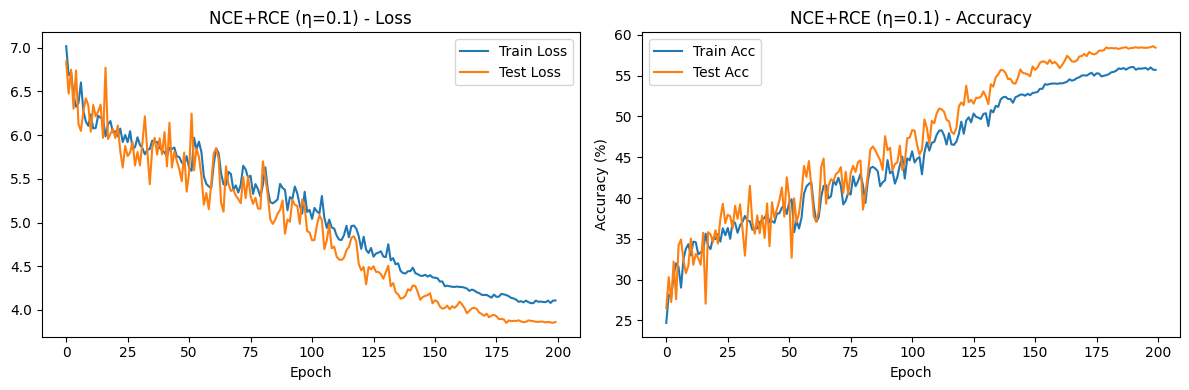

 - NCE+MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 51.51% | Test Loss: 0.5213


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 54.04% | Test Loss: 0.4940


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 66.24% | Test Loss: 0.3604


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 65.59% | Test Loss: 0.3657


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 70.24% | Test Loss: 0.3163


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 73.04% | Test Loss: 0.2847


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 75.00% | Test Loss: 0.2638


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 73.22% | Test Loss: 0.2824


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 74.07% | Test Loss: 0.2738


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 77.51% | Test Loss: 0.2394


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 77.20% | Test Loss: 0.2388


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 75.37% | Test Loss: 0.2611


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 75.42% | Test Loss: 0.2578


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 79.48% | Test Loss: 0.2139


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 80.29% | Test Loss: 0.2062


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 78.04% | Test Loss: 0.2300


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 80.53% | Test Loss: 0.2046


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 78.76% | Test Loss: 0.2221


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 79.38% | Test Loss: 0.2152


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.92it/s]


Test Acc: 79.03% | Test Loss: 0.2189


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.22it/s]


Test Acc: 82.07% | Test Loss: 0.1867


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 80.24% | Test Loss: 0.2053


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 82.43% | Test Loss: 0.1827


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 81.36% | Test Loss: 0.1942


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 80.43% | Test Loss: 0.2053


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 80.94% | Test Loss: 0.1983


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 83.16% | Test Loss: 0.1761


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 109.06it/s]


Test Acc: 81.95% | Test Loss: 0.1885


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 83.75% | Test Loss: 0.1707


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 82.82% | Test Loss: 0.1802


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 83.96% | Test Loss: 0.1670


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 82.13% | Test Loss: 0.1860


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 84.37% | Test Loss: 0.1611


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 83.77% | Test Loss: 0.1690


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 83.85% | Test Loss: 0.1697


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 82.00% | Test Loss: 0.1899


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 84.51% | Test Loss: 0.1616


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 84.80% | Test Loss: 0.1579


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 84.08% | Test Loss: 0.1659


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 84.49% | Test Loss: 0.1619


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 84.67% | Test Loss: 0.1584


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 85.36% | Test Loss: 0.1528


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 84.89% | Test Loss: 0.1569


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 84.98% | Test Loss: 0.1551


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 85.63% | Test Loss: 0.1509


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.71it/s]


Test Acc: 84.84% | Test Loss: 0.1576


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.51it/s]


Test Acc: 85.03% | Test Loss: 0.1558


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 85.89% | Test Loss: 0.1474


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 86.08% | Test Loss: 0.1449


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 86.06% | Test Loss: 0.1451


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 86.66% | Test Loss: 0.1389


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 86.39% | Test Loss: 0.1431


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 86.10% | Test Loss: 0.1458


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 85.69% | Test Loss: 0.1493


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 86.15% | Test Loss: 0.1435


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.96it/s]


Test Acc: 86.59% | Test Loss: 0.1401


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 87.19% | Test Loss: 0.1322


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 86.64% | Test Loss: 0.1403


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 86.60% | Test Loss: 0.1394


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 87.16% | Test Loss: 0.1345


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 87.20% | Test Loss: 0.1334


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 86.32% | Test Loss: 0.1411


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.81it/s]


Test Acc: 87.63% | Test Loss: 0.1304


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 87.82% | Test Loss: 0.1279


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 87.13% | Test Loss: 0.1341


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 86.97% | Test Loss: 0.1357


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 87.74% | Test Loss: 0.1282


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 87.67% | Test Loss: 0.1289


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 88.03% | Test Loss: 0.1244


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 87.57% | Test Loss: 0.1298


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 86.53% | Test Loss: 0.1396


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 87.17% | Test Loss: 0.1350


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 87.26% | Test Loss: 0.1328


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 86.81% | Test Loss: 0.1393


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 88.01% | Test Loss: 0.1251


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 87.53% | Test Loss: 0.1293


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 88.12% | Test Loss: 0.1245


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 88.38% | Test Loss: 0.1218


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 88.12% | Test Loss: 0.1258


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 87.64% | Test Loss: 0.1293


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 87.51% | Test Loss: 0.1299


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 87.90% | Test Loss: 0.1262


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 88.27% | Test Loss: 0.1220


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 87.25% | Test Loss: 0.1329


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 87.76% | Test Loss: 0.1276


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 87.73% | Test Loss: 0.1286


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 88.73% | Test Loss: 0.1174


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.60it/s]


Test Acc: 88.67% | Test Loss: 0.1175


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 88.67% | Test Loss: 0.1195


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 88.73% | Test Loss: 0.1180


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 88.58% | Test Loss: 0.1190


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 88.39% | Test Loss: 0.1209


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 88.60% | Test Loss: 0.1186


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.30it/s]


Test Acc: 88.73% | Test Loss: 0.1189


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 88.69% | Test Loss: 0.1192


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 88.74% | Test Loss: 0.1167


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 89.05% | Test Loss: 0.1148


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 89.11% | Test Loss: 0.1140


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.48it/s]


Test Acc: 88.41% | Test Loss: 0.1209


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.75it/s]


Test Acc: 89.67% | Test Loss: 0.1092


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 89.15% | Test Loss: 0.1127


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 88.56% | Test Loss: 0.1187


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 89.40% | Test Loss: 0.1108


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.07it/s]


Test Acc: 89.51% | Test Loss: 0.1098


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 88.98% | Test Loss: 0.1149


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 88.81% | Test Loss: 0.1160


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.09it/s]


Test Acc: 89.03% | Test Loss: 0.1146


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 88.83% | Test Loss: 0.1155


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 89.24% | Test Loss: 0.1120


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 89.31% | Test Loss: 0.1118


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 89.41% | Test Loss: 0.1102


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 89.16% | Test Loss: 0.1126


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 89.52% | Test Loss: 0.1110


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 89.17% | Test Loss: 0.1122


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 89.29% | Test Loss: 0.1124


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 89.20% | Test Loss: 0.1127


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 89.51% | Test Loss: 0.1106


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 89.67% | Test Loss: 0.1078


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.72it/s]


Test Acc: 89.39% | Test Loss: 0.1106


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 88.15% | Test Loss: 0.1228


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 89.28% | Test Loss: 0.1118


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 89.36% | Test Loss: 0.1115


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 89.23% | Test Loss: 0.1122


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 89.44% | Test Loss: 0.1120


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 89.31% | Test Loss: 0.1107


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 89.62% | Test Loss: 0.1095


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 89.58% | Test Loss: 0.1094


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 89.38% | Test Loss: 0.1107


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 89.36% | Test Loss: 0.1103


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.40it/s]


Test Acc: 89.51% | Test Loss: 0.1087


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 89.77% | Test Loss: 0.1079


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 89.87% | Test Loss: 0.1070


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 89.81% | Test Loss: 0.1072


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 89.84% | Test Loss: 0.1061


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 90.00% | Test Loss: 0.1055


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 89.79% | Test Loss: 0.1060


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.85it/s]


Test Acc: 89.99% | Test Loss: 0.1047


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 89.33% | Test Loss: 0.1100


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 90.10% | Test Loss: 0.1047


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 90.17% | Test Loss: 0.1039


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 89.93% | Test Loss: 0.1057


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 89.84% | Test Loss: 0.1061


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 89.88% | Test Loss: 0.1059


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 89.84% | Test Loss: 0.1059


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 89.93% | Test Loss: 0.1057


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 89.97% | Test Loss: 0.1065


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.86it/s]


Test Acc: 89.73% | Test Loss: 0.1064


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 89.68% | Test Loss: 0.1073


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.97it/s]


Test Acc: 89.98% | Test Loss: 0.1052


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 90.16% | Test Loss: 0.1042


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.69it/s]


Test Acc: 89.84% | Test Loss: 0.1076


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 89.97% | Test Loss: 0.1052


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 89.80% | Test Loss: 0.1065


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 89.95% | Test Loss: 0.1057


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 89.69% | Test Loss: 0.1086


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 90.12% | Test Loss: 0.1044


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 89.99% | Test Loss: 0.1045


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 90.03% | Test Loss: 0.1047


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 89.85% | Test Loss: 0.1066


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 89.84% | Test Loss: 0.1067


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 89.85% | Test Loss: 0.1063


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 89.86% | Test Loss: 0.1069


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.84it/s]


Test Acc: 89.87% | Test Loss: 0.1063


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 89.88% | Test Loss: 0.1058


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 89.97% | Test Loss: 0.1060


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 90.08% | Test Loss: 0.1052


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 89.92% | Test Loss: 0.1051


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 90.00% | Test Loss: 0.1048


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 90.08% | Test Loss: 0.1050


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 90.01% | Test Loss: 0.1050


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 90.20% | Test Loss: 0.1041


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 90.12% | Test Loss: 0.1044


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 90.11% | Test Loss: 0.1048


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 90.16% | Test Loss: 0.1047


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 89.89% | Test Loss: 0.1057


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 90.16% | Test Loss: 0.1042


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.06it/s]


Test Acc: 90.05% | Test Loss: 0.1048


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 90.04% | Test Loss: 0.1050


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 90.02% | Test Loss: 0.1047


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 90.01% | Test Loss: 0.1057


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 90.02% | Test Loss: 0.1048


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 90.16% | Test Loss: 0.1045


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 90.11% | Test Loss: 0.1040


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 90.17% | Test Loss: 0.1040


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 90.15% | Test Loss: 0.1045


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 89.90% | Test Loss: 0.1056


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 90.09% | Test Loss: 0.1053


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 90.08% | Test Loss: 0.1049


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 90.05% | Test Loss: 0.1047


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 90.20% | Test Loss: 0.1040


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 90.06% | Test Loss: 0.1049


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 90.12% | Test Loss: 0.1048


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 109.09it/s]


Test Acc: 90.14% | Test Loss: 0.1047


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.97it/s]


Test Acc: 90.08% | Test Loss: 0.1049


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 90.03% | Test Loss: 0.1056


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 90.15% | Test Loss: 0.1048


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 90.12% | Test Loss: 0.1051


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 90.01% | Test Loss: 0.1052


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 90.06% | Test Loss: 0.1057


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 90.14% | Test Loss: 0.1047


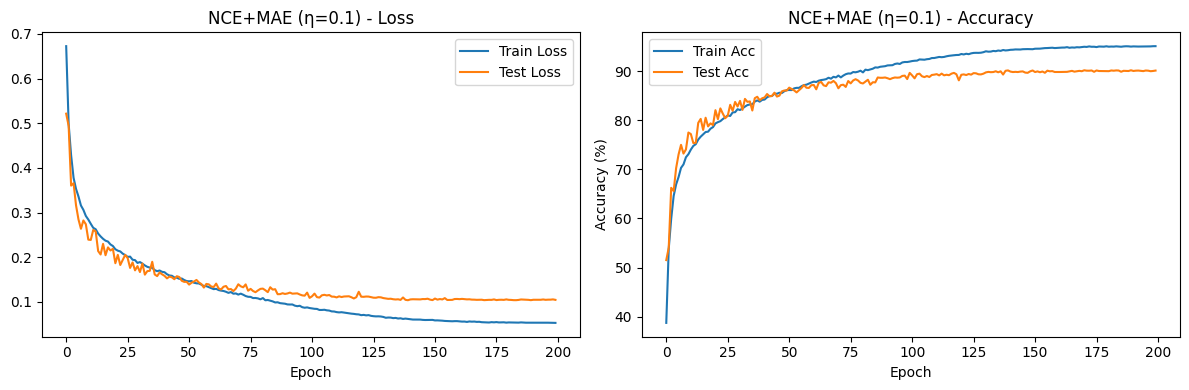

 - NFL+RCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 27.38% | Test Loss: 6.7633


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 30.10% | Test Loss: 6.5024


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 28.43% | Test Loss: 6.6737


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 25.59% | Test Loss: 6.9062


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 27.10% | Test Loss: 6.7652


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.90it/s]


Test Acc: 31.65% | Test Loss: 6.3421


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.81it/s]


Test Acc: 32.59% | Test Loss: 6.2699


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.77it/s]


Test Acc: 31.98% | Test Loss: 6.3134


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 32.56% | Test Loss: 6.2769


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.19it/s]


Test Acc: 30.56% | Test Loss: 6.4557


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 30.12% | Test Loss: 6.4860


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 32.12% | Test Loss: 6.3018


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 32.97% | Test Loss: 6.2364


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 30.32% | Test Loss: 6.4763


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 26.93% | Test Loss: 6.7844


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 30.82% | Test Loss: 6.4231


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 33.03% | Test Loss: 6.2343


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 31.54% | Test Loss: 6.3620


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.99it/s]


Test Acc: 32.63% | Test Loss: 6.2639


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 30.15% | Test Loss: 6.4846


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 31.56% | Test Loss: 6.3596


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 24.42% | Test Loss: 7.0158


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 28.95% | Test Loss: 6.6122


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 33.75% | Test Loss: 6.1526


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 31.01% | Test Loss: 6.4065


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 32.83% | Test Loss: 6.2355


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 35.07% | Test Loss: 6.0290


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 32.50% | Test Loss: 6.2764


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 34.54% | Test Loss: 6.0796


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 36.73% | Test Loss: 5.8833


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 34.53% | Test Loss: 6.0774


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.44it/s]


Test Acc: 33.52% | Test Loss: 6.1824


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 37.18% | Test Loss: 5.8475


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 35.39% | Test Loss: 5.9997


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 34.91% | Test Loss: 6.0452


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 36.22% | Test Loss: 5.9272


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 33.94% | Test Loss: 6.1424


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 37.05% | Test Loss: 5.8395


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 35.99% | Test Loss: 5.9613


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 37.02% | Test Loss: 5.8448


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 33.63% | Test Loss: 6.1656


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 36.29% | Test Loss: 5.9273


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 37.39% | Test Loss: 5.8121


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 37.54% | Test Loss: 5.8043


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 37.61% | Test Loss: 5.7915


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 35.78% | Test Loss: 5.9717


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 33.53% | Test Loss: 6.1660


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 35.38% | Test Loss: 6.0108


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 34.04% | Test Loss: 6.1483


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 39.33% | Test Loss: 5.6394


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 38.04% | Test Loss: 5.7514


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 37.55% | Test Loss: 5.8027


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 37.58% | Test Loss: 5.8028


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 36.27% | Test Loss: 5.9249


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 39.41% | Test Loss: 5.6253


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.62it/s]


Test Acc: 41.12% | Test Loss: 5.4795


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.07it/s]


Test Acc: 38.05% | Test Loss: 5.7570


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 31.86% | Test Loss: 6.3416


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 40.16% | Test Loss: 5.5690


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 37.36% | Test Loss: 5.8255


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 40.99% | Test Loss: 5.5042


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 37.58% | Test Loss: 5.8025


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 33.14% | Test Loss: 6.2356


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 39.49% | Test Loss: 5.6161


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 41.54% | Test Loss: 5.4483


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 40.40% | Test Loss: 5.5447


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 41.00% | Test Loss: 5.4999


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 41.39% | Test Loss: 5.4631


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 39.89% | Test Loss: 5.5995


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 37.78% | Test Loss: 5.7883


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 42.47% | Test Loss: 5.3554


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 33.95% | Test Loss: 6.1474


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 40.13% | Test Loss: 5.5743


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 40.89% | Test Loss: 5.5236


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.04it/s]


Test Acc: 42.29% | Test Loss: 5.3659


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 37.34% | Test Loss: 5.8348


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 40.76% | Test Loss: 5.5151


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 40.16% | Test Loss: 5.5848


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 41.89% | Test Loss: 5.3907


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 36.65% | Test Loss: 5.8860


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 39.03% | Test Loss: 5.6857


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 41.28% | Test Loss: 5.4789


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 42.01% | Test Loss: 5.3914


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 40.45% | Test Loss: 5.5367


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 43.84% | Test Loss: 5.2148


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 40.90% | Test Loss: 5.5016


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 41.59% | Test Loss: 5.4306


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 41.68% | Test Loss: 5.4137


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 38.44% | Test Loss: 5.7263


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 43.16% | Test Loss: 5.2833


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 39.61% | Test Loss: 5.6129


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 42.82% | Test Loss: 5.3380


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 40.52% | Test Loss: 5.5360


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 44.39% | Test Loss: 5.1837


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 43.57% | Test Loss: 5.2546


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 44.86% | Test Loss: 5.1472


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 39.27% | Test Loss: 5.6373


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 42.44% | Test Loss: 5.3487


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 44.69% | Test Loss: 5.1411


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 45.37% | Test Loss: 5.0864


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 43.73% | Test Loss: 5.2354


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 44.49% | Test Loss: 5.1689


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 45.31% | Test Loss: 5.0930


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.64it/s]


Test Acc: 45.71% | Test Loss: 5.0227


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 45.80% | Test Loss: 5.0193


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.66it/s]


Test Acc: 46.24% | Test Loss: 4.9739


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 46.16% | Test Loss: 4.9927


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 46.54% | Test Loss: 4.9724


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 47.34% | Test Loss: 4.8835


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 46.50% | Test Loss: 4.9560


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 45.20% | Test Loss: 5.0886


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 47.11% | Test Loss: 4.9249


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 47.01% | Test Loss: 4.9279


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 47.84% | Test Loss: 4.8588


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 46.32% | Test Loss: 4.9988


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 47.09% | Test Loss: 4.9222


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.31it/s]


Test Acc: 49.21% | Test Loss: 4.7375


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 46.86% | Test Loss: 4.9487


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 47.45% | Test Loss: 4.8939


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 48.40% | Test Loss: 4.8007


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 48.66% | Test Loss: 4.7767


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 48.57% | Test Loss: 4.7858


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.18it/s]


Test Acc: 49.30% | Test Loss: 4.7151


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 48.46% | Test Loss: 4.7889


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 48.75% | Test Loss: 4.7618


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 49.93% | Test Loss: 4.6609


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 49.26% | Test Loss: 4.7282


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 50.50% | Test Loss: 4.6137


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 47.55% | Test Loss: 4.8805


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.50it/s]


Test Acc: 51.06% | Test Loss: 4.5467


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 50.57% | Test Loss: 4.6014


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 48.20% | Test Loss: 4.8086


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 50.67% | Test Loss: 4.5906


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.78it/s]


Test Acc: 50.23% | Test Loss: 4.6296


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 51.50% | Test Loss: 4.5152


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 51.55% | Test Loss: 4.5030


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 50.75% | Test Loss: 4.6030


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 50.69% | Test Loss: 4.5869


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 49.99% | Test Loss: 4.6420


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 50.06% | Test Loss: 4.6349


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 50.44% | Test Loss: 4.6055


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 52.68% | Test Loss: 4.4135


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 52.90% | Test Loss: 4.3778


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 51.51% | Test Loss: 4.5059


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 52.23% | Test Loss: 4.4486


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 52.35% | Test Loss: 4.4378


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 52.59% | Test Loss: 4.4039


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 51.71% | Test Loss: 4.4882


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 52.84% | Test Loss: 4.3971


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 52.53% | Test Loss: 4.4112


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.70it/s]


Test Acc: 53.21% | Test Loss: 4.3501


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.94it/s]


Test Acc: 53.40% | Test Loss: 4.3445


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 54.35% | Test Loss: 4.2579


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 54.35% | Test Loss: 4.2504


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 54.03% | Test Loss: 4.2872


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 53.98% | Test Loss: 4.2840


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 54.44% | Test Loss: 4.2449


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 54.18% | Test Loss: 4.2537


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 54.06% | Test Loss: 4.2685


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 54.04% | Test Loss: 4.2779


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 54.90% | Test Loss: 4.1869


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.98it/s]


Test Acc: 54.59% | Test Loss: 4.2272


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.76it/s]


Test Acc: 54.94% | Test Loss: 4.1966


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 55.01% | Test Loss: 4.1836


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.69it/s]


Test Acc: 54.68% | Test Loss: 4.2155


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 55.24% | Test Loss: 4.1638


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.89it/s]


Test Acc: 55.23% | Test Loss: 4.1626


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 55.29% | Test Loss: 4.1603


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 55.72% | Test Loss: 4.1191


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 55.78% | Test Loss: 4.1127


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 55.81% | Test Loss: 4.1127


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 54.84% | Test Loss: 4.2018


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 55.59% | Test Loss: 4.1299


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 55.78% | Test Loss: 4.1115


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 55.27% | Test Loss: 4.1748


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 55.46% | Test Loss: 4.1427


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.16it/s]


Test Acc: 55.50% | Test Loss: 4.1373


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 55.88% | Test Loss: 4.1055


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 55.94% | Test Loss: 4.1009


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.84it/s]


Test Acc: 55.86% | Test Loss: 4.1083


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 56.01% | Test Loss: 4.0931


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 55.75% | Test Loss: 4.1167


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 56.05% | Test Loss: 4.0878


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 56.10% | Test Loss: 4.0859


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 56.04% | Test Loss: 4.0950


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 56.19% | Test Loss: 4.0753


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.89it/s]


Test Acc: 56.17% | Test Loss: 4.0822


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 56.11% | Test Loss: 4.0898


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.27it/s]


Test Acc: 56.28% | Test Loss: 4.0673


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 56.00% | Test Loss: 4.0971


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.07it/s]


Test Acc: 56.28% | Test Loss: 4.0746


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 56.37% | Test Loss: 4.0668


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 56.48% | Test Loss: 4.0549


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 56.36% | Test Loss: 4.0649


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 56.28% | Test Loss: 4.0651


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 56.27% | Test Loss: 4.0736


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 56.29% | Test Loss: 4.0734


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.93it/s]


Test Acc: 56.19% | Test Loss: 4.0825


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 56.26% | Test Loss: 4.0778


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.11it/s]


Test Acc: 56.35% | Test Loss: 4.0603


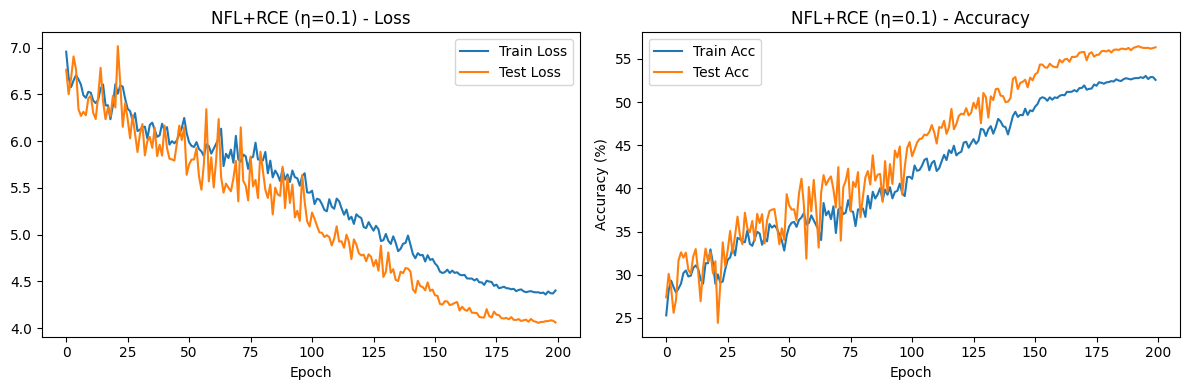

 - NFL+MAE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 49.92% | Test Loss: 0.5398


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 55.18% | Test Loss: 0.4743


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 63.63% | Test Loss: 0.3841


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 68.68% | Test Loss: 0.3325


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 70.58% | Test Loss: 0.3111


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 68.89% | Test Loss: 0.3282


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 73.64% | Test Loss: 0.2754


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 74.72% | Test Loss: 0.2660


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 75.72% | Test Loss: 0.2558


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 73.18% | Test Loss: 0.2817


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 74.44% | Test Loss: 0.2674


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 76.59% | Test Loss: 0.2463


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 78.62% | Test Loss: 0.2259


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 78.85% | Test Loss: 0.2227


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 80.55% | Test Loss: 0.2051


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 78.19% | Test Loss: 0.2274


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 78.24% | Test Loss: 0.2282


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 80.64% | Test Loss: 0.2034


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 79.69% | Test Loss: 0.2116


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.21it/s]


Test Acc: 80.47% | Test Loss: 0.2072


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 79.11% | Test Loss: 0.2196


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.84it/s]


Test Acc: 80.42% | Test Loss: 0.2060


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 81.95% | Test Loss: 0.1895


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 83.02% | Test Loss: 0.1767


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 81.07% | Test Loss: 0.1963


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 81.77% | Test Loss: 0.1920


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 81.54% | Test Loss: 0.1915


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.35it/s]


Test Acc: 82.58% | Test Loss: 0.1824


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.01it/s]


Test Acc: 81.52% | Test Loss: 0.1916


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 82.61% | Test Loss: 0.1806


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 81.55% | Test Loss: 0.1908


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 82.20% | Test Loss: 0.1844


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 84.72% | Test Loss: 0.1620


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 84.57% | Test Loss: 0.1603


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.15it/s]


Test Acc: 85.55% | Test Loss: 0.1510


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 84.47% | Test Loss: 0.1621


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 83.51% | Test Loss: 0.1738


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 84.25% | Test Loss: 0.1659


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.74it/s]


Test Acc: 85.11% | Test Loss: 0.1547


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 85.41% | Test Loss: 0.1516


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 85.75% | Test Loss: 0.1498


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 85.50% | Test Loss: 0.1517


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 86.02% | Test Loss: 0.1464


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 85.97% | Test Loss: 0.1459


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.02it/s]


Test Acc: 84.63% | Test Loss: 0.1616


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.02it/s]


Test Acc: 85.47% | Test Loss: 0.1499


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 84.24% | Test Loss: 0.1641


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 85.32% | Test Loss: 0.1530


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.96it/s]


Test Acc: 86.00% | Test Loss: 0.1445


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.36it/s]


Test Acc: 86.23% | Test Loss: 0.1436


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 86.18% | Test Loss: 0.1449


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 86.59% | Test Loss: 0.1400


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 85.87% | Test Loss: 0.1474


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.65it/s]


Test Acc: 86.33% | Test Loss: 0.1432


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 86.36% | Test Loss: 0.1411


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 87.09% | Test Loss: 0.1346


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 85.22% | Test Loss: 0.1524


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 85.91% | Test Loss: 0.1469


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 87.47% | Test Loss: 0.1304


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 87.45% | Test Loss: 0.1306


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 87.19% | Test Loss: 0.1328


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 86.95% | Test Loss: 0.1365


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 87.05% | Test Loss: 0.1346


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.39it/s]


Test Acc: 87.20% | Test Loss: 0.1335


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 88.40% | Test Loss: 0.1216


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.61it/s]


Test Acc: 87.78% | Test Loss: 0.1271


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.97it/s]


Test Acc: 86.01% | Test Loss: 0.1461


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 87.30% | Test Loss: 0.1318


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 87.61% | Test Loss: 0.1295


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 88.23% | Test Loss: 0.1238


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 87.06% | Test Loss: 0.1348


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 87.90% | Test Loss: 0.1254


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 88.55% | Test Loss: 0.1209


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 88.67% | Test Loss: 0.1201


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 88.19% | Test Loss: 0.1235


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.04it/s]


Test Acc: 87.66% | Test Loss: 0.1280


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 88.43% | Test Loss: 0.1215


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 87.74% | Test Loss: 0.1286


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 87.78% | Test Loss: 0.1272


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 87.59% | Test Loss: 0.1277


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 88.44% | Test Loss: 0.1206


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 88.80% | Test Loss: 0.1172


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.56it/s]


Test Acc: 88.33% | Test Loss: 0.1225


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.01it/s]


Test Acc: 88.66% | Test Loss: 0.1194


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 88.58% | Test Loss: 0.1186


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 88.56% | Test Loss: 0.1194


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.45it/s]


Test Acc: 88.38% | Test Loss: 0.1219


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.53it/s]


Test Acc: 88.65% | Test Loss: 0.1184


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 87.84% | Test Loss: 0.1251


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 88.28% | Test Loss: 0.1238


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 88.63% | Test Loss: 0.1192


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 88.84% | Test Loss: 0.1184


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.79it/s]


Test Acc: 89.10% | Test Loss: 0.1150


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 88.83% | Test Loss: 0.1174


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.70it/s]


Test Acc: 88.93% | Test Loss: 0.1147


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 88.93% | Test Loss: 0.1146


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 88.67% | Test Loss: 0.1187


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 89.16% | Test Loss: 0.1130


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 88.61% | Test Loss: 0.1193


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 89.22% | Test Loss: 0.1138


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 89.38% | Test Loss: 0.1118


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.82it/s]


Test Acc: 89.66% | Test Loss: 0.1089


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 88.64% | Test Loss: 0.1182


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 89.64% | Test Loss: 0.1089


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.55it/s]


Test Acc: 89.29% | Test Loss: 0.1110


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 89.46% | Test Loss: 0.1116


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 88.98% | Test Loss: 0.1143


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.24it/s]


Test Acc: 88.82% | Test Loss: 0.1167


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.13it/s]


Test Acc: 89.09% | Test Loss: 0.1139


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 89.18% | Test Loss: 0.1128


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 89.07% | Test Loss: 0.1157


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.29it/s]


Test Acc: 89.58% | Test Loss: 0.1091


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 89.54% | Test Loss: 0.1109


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.88it/s]


Test Acc: 89.70% | Test Loss: 0.1095


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 89.47% | Test Loss: 0.1107


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 89.59% | Test Loss: 0.1097


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 89.72% | Test Loss: 0.1087


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 89.67% | Test Loss: 0.1072


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 89.70% | Test Loss: 0.1085


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.54it/s]


Test Acc: 89.62% | Test Loss: 0.1089


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 89.86% | Test Loss: 0.1079


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 89.99% | Test Loss: 0.1064


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 90.06% | Test Loss: 0.1065


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 89.91% | Test Loss: 0.1072


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.97it/s]


Test Acc: 89.73% | Test Loss: 0.1079


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 90.01% | Test Loss: 0.1053


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 89.51% | Test Loss: 0.1093


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 89.96% | Test Loss: 0.1052


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 89.71% | Test Loss: 0.1068


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 89.94% | Test Loss: 0.1048


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 89.85% | Test Loss: 0.1072


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 89.91% | Test Loss: 0.1063


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 89.88% | Test Loss: 0.1065


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 90.03% | Test Loss: 0.1061


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 89.67% | Test Loss: 0.1076


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 90.24% | Test Loss: 0.1042


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 90.11% | Test Loss: 0.1058


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 89.74% | Test Loss: 0.1084


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 89.92% | Test Loss: 0.1062


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 90.30% | Test Loss: 0.1044


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 89.98% | Test Loss: 0.1052


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.22it/s]


Test Acc: 89.97% | Test Loss: 0.1062


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 90.14% | Test Loss: 0.1051


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 90.23% | Test Loss: 0.1034


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 90.13% | Test Loss: 0.1043


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 89.91% | Test Loss: 0.1067


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 89.96% | Test Loss: 0.1060


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 90.38% | Test Loss: 0.1020


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 90.10% | Test Loss: 0.1036


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 90.21% | Test Loss: 0.1046


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 90.21% | Test Loss: 0.1039


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 90.18% | Test Loss: 0.1045


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 90.20% | Test Loss: 0.1036


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.13it/s]


Test Acc: 90.35% | Test Loss: 0.1015


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.46it/s]


Test Acc: 90.03% | Test Loss: 0.1035


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.73it/s]


Test Acc: 90.24% | Test Loss: 0.1034


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 90.20% | Test Loss: 0.1040


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.51it/s]


Test Acc: 90.38% | Test Loss: 0.1032


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 90.17% | Test Loss: 0.1035


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.25it/s]


Test Acc: 90.06% | Test Loss: 0.1043


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.08it/s]


Test Acc: 90.24% | Test Loss: 0.1019


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 90.25% | Test Loss: 0.1033


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 90.35% | Test Loss: 0.1019


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 90.27% | Test Loss: 0.1017


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 90.16% | Test Loss: 0.1036


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 90.08% | Test Loss: 0.1038


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.17it/s]


Test Acc: 90.08% | Test Loss: 0.1036


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 90.11% | Test Loss: 0.1030


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.63it/s]


Test Acc: 90.15% | Test Loss: 0.1033


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 90.25% | Test Loss: 0.1025


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 90.09% | Test Loss: 0.1041


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 90.00% | Test Loss: 0.1040


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 90.08% | Test Loss: 0.1045


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 90.21% | Test Loss: 0.1038


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 90.35% | Test Loss: 0.1026


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.79it/s]


Test Acc: 90.19% | Test Loss: 0.1030


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.64it/s]


Test Acc: 90.33% | Test Loss: 0.1030


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 90.36% | Test Loss: 0.1028


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 90.17% | Test Loss: 0.1033


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.00it/s]


Test Acc: 90.28% | Test Loss: 0.1027


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 90.30% | Test Loss: 0.1033


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 90.19% | Test Loss: 0.1033


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.53it/s]


Test Acc: 90.29% | Test Loss: 0.1027


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 90.31% | Test Loss: 0.1027


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 90.23% | Test Loss: 0.1032


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 90.36% | Test Loss: 0.1035


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.76it/s]


Test Acc: 90.22% | Test Loss: 0.1031


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 90.25% | Test Loss: 0.1030


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 90.28% | Test Loss: 0.1030


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 90.28% | Test Loss: 0.1024


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.48it/s]


Test Acc: 90.26% | Test Loss: 0.1029


Epoch 192/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.87it/s]


Test Acc: 90.26% | Test Loss: 0.1026


Epoch 193/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 90.23% | Test Loss: 0.1029


Epoch 194/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 90.32% | Test Loss: 0.1028


Epoch 195/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.60it/s]


Test Acc: 90.27% | Test Loss: 0.1025


Epoch 196/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 90.27% | Test Loss: 0.1027


Epoch 197/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.86it/s]


Test Acc: 90.26% | Test Loss: 0.1029


Epoch 198/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 90.30% | Test Loss: 0.1028


Epoch 199/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 90.22% | Test Loss: 0.1031


Epoch 200/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.37it/s]


Test Acc: 90.27% | Test Loss: 0.1026


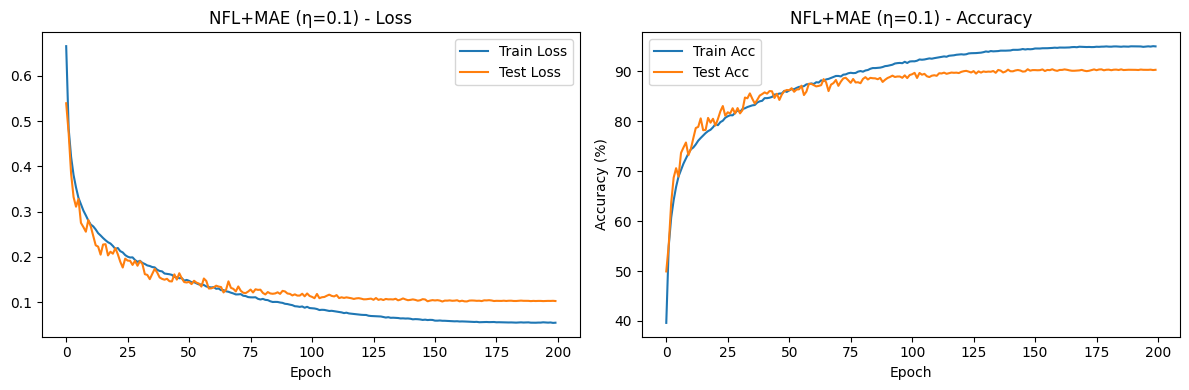

 - NFL+NCE


Epoch 1/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.22it/s]


Test Acc: 41.01% | Test Loss: 0.0520


Epoch 2/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.68it/s]


Test Acc: 44.63% | Test Loss: 0.0392


Epoch 3/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 47.23% | Test Loss: 0.0362


Epoch 4/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.41it/s]


Test Acc: 49.87% | Test Loss: 0.0306


Epoch 5/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 54.90% | Test Loss: 0.0251


Epoch 6/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.59it/s]


Test Acc: 54.50% | Test Loss: 0.0258


Epoch 7/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 57.02% | Test Loss: 0.0219


Epoch 8/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 55.46% | Test Loss: 0.0219


Epoch 9/200: 100%|███████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 60.05% | Test Loss: 0.0180


Epoch 10/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.73it/s]


Test Acc: 60.46% | Test Loss: 0.0183


Epoch 11/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 59.81% | Test Loss: 0.0191


Epoch 12/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 61.48% | Test Loss: 0.0181


Epoch 13/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 63.04% | Test Loss: 0.0166


Epoch 14/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 62.85% | Test Loss: 0.0142


Epoch 15/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.68it/s]


Test Acc: 61.59% | Test Loss: 0.0167


Epoch 16/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.94it/s]


Test Acc: 62.31% | Test Loss: 0.0151


Epoch 17/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.71it/s]


Test Acc: 62.69% | Test Loss: 0.0189


Epoch 18/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 66.97% | Test Loss: 0.0116


Epoch 19/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.28it/s]


Test Acc: 62.38% | Test Loss: 0.0136


Epoch 20/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 66.75% | Test Loss: 0.0115


Epoch 21/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.43it/s]


Test Acc: 67.33% | Test Loss: 0.0106


Epoch 22/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.57it/s]


Test Acc: 64.84% | Test Loss: 0.0165


Epoch 23/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 67.41% | Test Loss: 0.0106


Epoch 24/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.48it/s]


Test Acc: 67.08% | Test Loss: 0.0124


Epoch 25/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 69.01% | Test Loss: 0.0103


Epoch 26/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 66.65% | Test Loss: 0.0154


Epoch 27/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 68.69% | Test Loss: 0.0100


Epoch 28/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 69.49% | Test Loss: 0.0089


Epoch 29/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 69.00% | Test Loss: 0.0087


Epoch 30/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 68.84% | Test Loss: 0.0087


Epoch 31/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.87it/s]


Test Acc: 68.44% | Test Loss: 0.0091


Epoch 32/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.39it/s]


Test Acc: 69.39% | Test Loss: 0.0089


Epoch 33/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.92it/s]


Test Acc: 69.23% | Test Loss: 0.0093


Epoch 34/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.33it/s]


Test Acc: 69.64% | Test Loss: 0.0095


Epoch 35/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 69.59% | Test Loss: 0.0093


Epoch 36/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.97it/s]


Test Acc: 70.15% | Test Loss: 0.0088


Epoch 37/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.30it/s]


Test Acc: 71.65% | Test Loss: 0.0084


Epoch 38/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.70it/s]


Test Acc: 69.55% | Test Loss: 0.0093


Epoch 39/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 69.81% | Test Loss: 0.0091


Epoch 40/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.96it/s]


Test Acc: 71.32% | Test Loss: 0.0079


Epoch 41/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 70.37% | Test Loss: 0.0085


Epoch 42/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.14it/s]


Test Acc: 71.30% | Test Loss: 0.0088


Epoch 43/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.88it/s]


Test Acc: 71.78% | Test Loss: 0.0076


Epoch 44/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 71.88% | Test Loss: 0.0073


Epoch 45/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.58it/s]


Test Acc: 70.78% | Test Loss: 0.0075


Epoch 46/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 70.23% | Test Loss: 0.0089


Epoch 47/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 71.69% | Test Loss: 0.0083


Epoch 48/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 72.66% | Test Loss: 0.0076


Epoch 49/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 72.64% | Test Loss: 0.0078


Epoch 50/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.99it/s]


Test Acc: 72.53% | Test Loss: 0.0071


Epoch 51/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.18it/s]


Test Acc: 72.19% | Test Loss: 0.0077


Epoch 52/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 73.05% | Test Loss: 0.0075


Epoch 53/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 72.38% | Test Loss: 0.0069


Epoch 54/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 72.76% | Test Loss: 0.0072


Epoch 55/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.36it/s]


Test Acc: 74.40% | Test Loss: 0.0067


Epoch 56/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 73.48% | Test Loss: 0.0068


Epoch 57/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 73.18% | Test Loss: 0.0079


Epoch 58/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.09it/s]


Test Acc: 71.09% | Test Loss: 0.0082


Epoch 59/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.12it/s]


Test Acc: 71.32% | Test Loss: 0.0082


Epoch 60/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 72.91% | Test Loss: 0.0073


Epoch 61/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 73.14% | Test Loss: 0.0073


Epoch 62/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.93it/s]


Test Acc: 73.01% | Test Loss: 0.0085


Epoch 63/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 73.99% | Test Loss: 0.0069


Epoch 64/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.46it/s]


Test Acc: 74.27% | Test Loss: 0.0066


Epoch 65/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.57it/s]


Test Acc: 72.98% | Test Loss: 0.0067


Epoch 66/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.42it/s]


Test Acc: 74.01% | Test Loss: 0.0072


Epoch 67/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.32it/s]


Test Acc: 74.04% | Test Loss: 0.0066


Epoch 68/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.56it/s]


Test Acc: 74.48% | Test Loss: 0.0068


Epoch 69/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.98it/s]


Test Acc: 75.37% | Test Loss: 0.0066


Epoch 70/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 74.24% | Test Loss: 0.0070


Epoch 71/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 74.12% | Test Loss: 0.0073


Epoch 72/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.47it/s]


Test Acc: 73.45% | Test Loss: 0.0071


Epoch 73/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 74.38% | Test Loss: 0.0071


Epoch 74/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 74.29% | Test Loss: 0.0065


Epoch 75/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.29it/s]


Test Acc: 74.84% | Test Loss: 0.0061


Epoch 76/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 74.05% | Test Loss: 0.0067


Epoch 77/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.84it/s]


Test Acc: 74.12% | Test Loss: 0.0068


Epoch 78/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 74.90% | Test Loss: 0.0068


Epoch 79/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.82it/s]


Test Acc: 75.11% | Test Loss: 0.0064


Epoch 80/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.07it/s]


Test Acc: 75.08% | Test Loss: 0.0065


Epoch 81/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.74it/s]


Test Acc: 74.71% | Test Loss: 0.0059


Epoch 82/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.40it/s]


Test Acc: 74.66% | Test Loss: 0.0072


Epoch 83/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.90it/s]


Test Acc: 75.17% | Test Loss: 0.0066


Epoch 84/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 75.99% | Test Loss: 0.0057


Epoch 85/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 106.77it/s]


Test Acc: 74.69% | Test Loss: 0.0068


Epoch 86/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 75.39% | Test Loss: 0.0058


Epoch 87/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 75.52% | Test Loss: 0.0065


Epoch 88/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 105.55it/s]


Test Acc: 76.36% | Test Loss: 0.0059


Epoch 89/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 75.35% | Test Loss: 0.0062


Epoch 90/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 74.55% | Test Loss: 0.0067


Epoch 91/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 75.92% | Test Loss: 0.0065


Epoch 92/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 75.88% | Test Loss: 0.0057


Epoch 93/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.85it/s]


Test Acc: 75.18% | Test Loss: 0.0058


Epoch 94/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 75.99% | Test Loss: 0.0061


Epoch 95/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 75.84% | Test Loss: 0.0066


Epoch 96/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 75.96% | Test Loss: 0.0056


Epoch 97/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.04it/s]


Test Acc: 76.30% | Test Loss: 0.0057


Epoch 98/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.42it/s]


Test Acc: 76.33% | Test Loss: 0.0064


Epoch 99/200: 100%|██████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 75.58% | Test Loss: 0.0066


Epoch 100/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.11it/s]


Test Acc: 76.82% | Test Loss: 0.0061


Epoch 101/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.00it/s]


Test Acc: 76.69% | Test Loss: 0.0057


Epoch 102/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 76.55% | Test Loss: 0.0054


Epoch 103/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.33it/s]


Test Acc: 75.14% | Test Loss: 0.0063


Epoch 104/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.14it/s]


Test Acc: 77.02% | Test Loss: 0.0056


Epoch 105/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.12it/s]


Test Acc: 76.40% | Test Loss: 0.0055


Epoch 106/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.59it/s]


Test Acc: 76.65% | Test Loss: 0.0053


Epoch 107/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 76.37% | Test Loss: 0.0059


Epoch 108/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 76.77% | Test Loss: 0.0057


Epoch 109/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 76.57% | Test Loss: 0.0058


Epoch 110/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.25it/s]


Test Acc: 76.43% | Test Loss: 0.0058


Epoch 111/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.11it/s]


Test Acc: 77.04% | Test Loss: 0.0059


Epoch 112/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 77.21% | Test Loss: 0.0054


Epoch 113/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.20it/s]


Test Acc: 77.16% | Test Loss: 0.0055


Epoch 114/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.16it/s]


Test Acc: 76.32% | Test Loss: 0.0056


Epoch 115/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.05it/s]


Test Acc: 77.49% | Test Loss: 0.0058


Epoch 116/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 76.95% | Test Loss: 0.0055


Epoch 117/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.63it/s]


Test Acc: 76.34% | Test Loss: 0.0059


Epoch 118/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.36it/s]


Test Acc: 77.29% | Test Loss: 0.0060


Epoch 119/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.73it/s]


Test Acc: 77.09% | Test Loss: 0.0060


Epoch 120/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.23it/s]


Test Acc: 77.50% | Test Loss: 0.0055


Epoch 121/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.89it/s]


Test Acc: 77.55% | Test Loss: 0.0053


Epoch 122/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.50it/s]


Test Acc: 77.41% | Test Loss: 0.0056


Epoch 123/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.52it/s]


Test Acc: 76.78% | Test Loss: 0.0060


Epoch 124/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.95it/s]


Test Acc: 77.62% | Test Loss: 0.0056


Epoch 125/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.26it/s]


Test Acc: 77.36% | Test Loss: 0.0058


Epoch 126/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.57it/s]


Test Acc: 77.50% | Test Loss: 0.0055


Epoch 127/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.04it/s]


Test Acc: 77.23% | Test Loss: 0.0059


Epoch 128/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.80it/s]


Test Acc: 77.67% | Test Loss: 0.0056


Epoch 129/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.34it/s]


Test Acc: 77.18% | Test Loss: 0.0057


Epoch 130/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.23it/s]


Test Acc: 77.30% | Test Loss: 0.0056


Epoch 131/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.78it/s]


Test Acc: 77.45% | Test Loss: 0.0055


Epoch 132/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.67it/s]


Test Acc: 77.52% | Test Loss: 0.0057


Epoch 133/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.83it/s]


Test Acc: 77.84% | Test Loss: 0.0053


Epoch 134/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.38it/s]


Test Acc: 77.34% | Test Loss: 0.0057


Epoch 135/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.58it/s]


Test Acc: 77.61% | Test Loss: 0.0056


Epoch 136/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 77.75% | Test Loss: 0.0055


Epoch 137/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 77.70% | Test Loss: 0.0057


Epoch 138/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.34it/s]


Test Acc: 77.85% | Test Loss: 0.0054


Epoch 139/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.64it/s]


Test Acc: 77.42% | Test Loss: 0.0055


Epoch 140/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.64it/s]


Test Acc: 77.39% | Test Loss: 0.0057


Epoch 141/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.17it/s]


Test Acc: 77.92% | Test Loss: 0.0053


Epoch 142/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.23it/s]


Test Acc: 78.02% | Test Loss: 0.0055


Epoch 143/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.15it/s]


Test Acc: 77.77% | Test Loss: 0.0055


Epoch 144/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 78.26% | Test Loss: 0.0052


Epoch 145/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.61it/s]


Test Acc: 77.84% | Test Loss: 0.0058


Epoch 146/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.38it/s]


Test Acc: 78.08% | Test Loss: 0.0054


Epoch 147/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.85it/s]


Test Acc: 78.06% | Test Loss: 0.0053


Epoch 148/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.91it/s]


Test Acc: 78.19% | Test Loss: 0.0054


Epoch 149/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.37it/s]


Test Acc: 77.88% | Test Loss: 0.0054


Epoch 150/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.72it/s]


Test Acc: 77.82% | Test Loss: 0.0054


Epoch 151/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.09it/s]


Test Acc: 78.11% | Test Loss: 0.0055


Epoch 152/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.45it/s]


Test Acc: 78.02% | Test Loss: 0.0054


Epoch 153/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.49it/s]


Test Acc: 78.33% | Test Loss: 0.0053


Epoch 154/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.84it/s]


Test Acc: 78.18% | Test Loss: 0.0054


Epoch 155/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.19it/s]


Test Acc: 78.02% | Test Loss: 0.0053


Epoch 156/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.27it/s]


Test Acc: 78.10% | Test Loss: 0.0056


Epoch 157/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.55it/s]


Test Acc: 78.18% | Test Loss: 0.0055


Epoch 158/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.44it/s]


Test Acc: 78.19% | Test Loss: 0.0055


Epoch 159/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.00it/s]


Test Acc: 78.07% | Test Loss: 0.0054


Epoch 160/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.95it/s]


Test Acc: 78.06% | Test Loss: 0.0054


Epoch 161/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.74it/s]


Test Acc: 78.36% | Test Loss: 0.0053


Epoch 162/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.03it/s]


Test Acc: 78.26% | Test Loss: 0.0055


Epoch 163/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.32it/s]


Test Acc: 78.11% | Test Loss: 0.0056


Epoch 164/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 78.03% | Test Loss: 0.0054


Epoch 165/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.69it/s]


Test Acc: 78.38% | Test Loss: 0.0054


Epoch 166/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.43it/s]


Test Acc: 78.14% | Test Loss: 0.0056


Epoch 167/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.19it/s]


Test Acc: 78.09% | Test Loss: 0.0054


Epoch 168/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.49it/s]


Test Acc: 78.38% | Test Loss: 0.0053


Epoch 169/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 105.97it/s]


Test Acc: 78.39% | Test Loss: 0.0056


Epoch 170/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.47it/s]


Test Acc: 78.08% | Test Loss: 0.0056


Epoch 171/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.91it/s]


Test Acc: 78.16% | Test Loss: 0.0054


Epoch 172/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.02it/s]


Test Acc: 78.14% | Test Loss: 0.0055


Epoch 173/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.76it/s]


Test Acc: 78.20% | Test Loss: 0.0055


Epoch 174/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.88it/s]


Test Acc: 78.16% | Test Loss: 0.0054


Epoch 175/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.67it/s]


Test Acc: 78.14% | Test Loss: 0.0056


Epoch 176/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 78.36% | Test Loss: 0.0057


Epoch 177/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.55it/s]


Test Acc: 78.25% | Test Loss: 0.0053


Epoch 178/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.62it/s]


Test Acc: 78.42% | Test Loss: 0.0052


Epoch 179/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.75it/s]


Test Acc: 78.24% | Test Loss: 0.0053


Epoch 180/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.24it/s]


Test Acc: 78.30% | Test Loss: 0.0054


Epoch 181/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.65it/s]


Test Acc: 78.26% | Test Loss: 0.0057


Epoch 182/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.07it/s]


Test Acc: 78.06% | Test Loss: 0.0056


Epoch 183/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.20it/s]


Test Acc: 78.22% | Test Loss: 0.0054


Epoch 184/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.77it/s]


Test Acc: 78.14% | Test Loss: 0.0056


Epoch 185/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.80it/s]


Test Acc: 78.15% | Test Loss: 0.0053


Epoch 186/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 108.10it/s]


Test Acc: 78.17% | Test Loss: 0.0056


Epoch 187/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 106.33it/s]


Test Acc: 78.38% | Test Loss: 0.0054


Epoch 188/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.41it/s]


Test Acc: 78.38% | Test Loss: 0.0055


Epoch 189/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.58it/s]


Test Acc: 78.18% | Test Loss: 0.0055


Epoch 190/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.69it/s]


Test Acc: 78.32% | Test Loss: 0.0055


Epoch 191/200: 100%|█████████████████████████| 391/391 [00:03<00:00, 107.31it/s]


Test Acc: 78.28% | Test Loss: 0.0054


Epoch 192/200:  63%|███████████████▋         | 245/391 [00:02<00:01, 109.80it/s]

In [ ]:

loss_groups = {
    'vanilla': ['CE', 'MAE', 'RCE'],
    'normalized': ['NCE',  'NRCE', 'NFL'],
    'apl': ['NCE+RCE', 'NCE+MAE', 'NFL+RCE', 'NFL+MAE', 'NFL+NCE', 'MAE+RCE']
    
}

noise_levels = {
    "Symmetric": [0.2,0.4,0.6,0.8],
    "Asymmetric": [0.1, 0.2, 0.3, 0.4]
}

full_results = {}

for noise_type, rates in noise_levels.items():
    print(f"\n=== {noise_type} Noise Experiments ===")
    noise_results = {}

    for rate in rates:
        print(f"\nNoise Rate: {rate}")
        config = Config()
        config.noise_rate = rate
        config.asym = (noise_type == "Asymmetric")

        group_results = {}
        for group_name, loss_types in loss_groups.items():
            print(f"\nTraining {group_name} Losses...")
            loss_results = {}

            for loss in loss_types:
                config.loss_type = loss
                print(f" - {loss}")
                res = train_model(config)
                loss_results[loss] = res
                plot_results(res, f"{loss} (η={rate})")

            group_results[group_name] = loss_results

        noise_results[rate] = group_results

    full_results[noise_type] = noise_results


# Final Comparison Plot
def plot_final_accuracies(results, noise_type):
    plt.figure(figsize=(12,6))
    markers = ['o', 's', '^', 'D', 'v', '>']

    for group_idx, (group_name, loss_types) in enumerate(loss_groups.items()):
        for loss_idx, loss in enumerate(loss_types):
            accuracies = []
            rates = sorted(results.keys())

            for rate in rates:
                acc = results[rate][group_name][loss]['test_acc'][-1]
                accuracies.append(acc)

            plt.plot(rates, accuracies, marker=markers[loss_idx%len(markers)],
                     linestyle='--', label=f"{group_name}: {loss}")

    plt.title(f"Final Test Accuracy ({noise_type} Noise)")
    plt.xlabel("Noise Rate")
    plt.ylabel("Accuracy (%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate plots
for noise_type in noise_levels:
    plot_final_accuracies(full_results[noise_type], noise_type)
    plot_group_comparisons(full_results[noise_type], noise_type, 'vanilla', 'normalized')
